# Time-Series Forecasting with Prophet

Analytics Learning Exchange 2023

**Description of Session:** Want to predict the future? Now you can in just a few clicks! In this session, participants will learn about prophet, a forecasting package built by Facebook developers to make building time-series predictive models incredibly simple. Participants of this session will learn more about the package, the ins and outs of its core features, and get to see it in action to predict rat-related 311 requests at the city level. Attendees will walk away with a step-by-step example of how to use the package and may have some time exploring how to use it for themselves using their own data.

**Speaker:** Claire Boyd, MSc Candidate in Computational Analysis and Public Policy, University of Chicago

### Motivation

**What is Time Series Analysis or Forecasting?**

A time series *data* is a series of data points or observations recorded at different or regular time intervals. In general, a time series is a sequence of data points taken at equally spaced time intervals. The frequency of recorded data points may be hourly, daily, weekly, monthly, quarterly or annually.

Time series *forecasting* is a technique used in statistics and machine learning to **make predictions about future values based on historical data points that are ordered in time**. In a time series, each data point represents a measurement or observation taken at a specific time or over a specific time interval. 

A time series analysis encompasses statistical methods for analyzing time series data. These methods enable us to extract meaningful statistics, patterns and other characteristics of the data. So, time series analysis involves understanding inherent aspects of the time series data so that we can create meaningful and accurate forecasts.

**Why is it helpful?**

Time series analysis is very useful because of how **few inputs** we need in order to create accurate predictions. In order to create powerful time series models, all we need are **two variables** - a time stamp and the variable we want to analyze. 

Also, time series analysis can allow us to make more sophisticated predictions about what will happen next. Instead of just knowing that A/C usage will go up in the summer and down in the winter, we can make more sophisticated predictions of what will happen given years of historical trends and better account for contextualize recent fluctations.


General examples:
* Purchasing/inventory of certain goods
* Web traffic to allocate server resources/plan for content updates
* Energy consumption

*What are some other NYC-specific examples?*

In [2]:
pip install pandas


[notice] A new release of pip is available: 23.1.2 -> 23.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
import pandas as pd

#url of practice dataset on github
url = "https://github.com/selva86/datasets/blob/master/AirPassengers.csv"

# read in as DataFrame
airpassengers = pd.read_csv(url, sep=",")

ParserError: Error tokenizing data. C error: Expected 1 fields in line 32, saw 6


**How does time series forecasting work?**

The goal of time series forecasting is to break down historical data into multiple parts, capturing each component separately in order to 





**How is this typically done?**


component analysis
different models

why do we test things in this way...

### What is Prophet?



modern forecasting at a daily level 


Prophet is a package created by developers at Facebook make 

- expertise is the main limitation in applying forecasting
- lots of different ways to forecast, but not a lot of forecastors to do it
- a lot of way 


Documentation here: https://facebook.github.io/prophet/

Available in python and R. 




### Example: Time Series Modeling for Rat-related 311 Requests

To inform data-driven rodent mitigation, we can use historic data to give us a better picture of how many rat-related 311 requests we should expect given seasonal trends and compare those predictions to the observed values to prioritize different areas of the city for mitigation resources.

The following script uses a package called [prophet](https://facebook.github.io/prophet/docs/installation.html#python) to create time-series predictive models hypertuned for each geography of interest (the whole city, boroughs, community boards, and rat mitigation zones). In order to build custom models and generate predictions for the PowerBI dashboard, the code below follows the following steps:
- ***Set up***: Reads in data, does initial data cleaning.
- ***Descriptive analysis***: Explores data to confirm time-series analysis is the right approach.
- ***Model development***: Tests different model parameters, using a grid search to choose the parameters that have the best model performance (using two specific metrics).
- ***Data Export for PowerBI***: Generates predictions for custom models at all geographies, and saves csvs to sharepoint folder.

### Set-up

#### Read-in relevant data

Use NYC Open Data Portal to source all rat-related 311 requests that trigger building inspections. This includes all requests that fall under the following complaint types:
* School Maintenance
* Food Establishment
* Rodent
* Maintenance or Facility
* Dead Animal
* Unsanitary Condition

Because not all requests under these types are rat-related, we can subset based on specific descriptors when reading in the data using a specific query.

In [1]:
pip install sodapy


[notice] A new release of pip is available: 23.1.2 -> 23.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sodapy import Socrata
import input.helpers as helpers

Use function in `helpers.py` to get rat-related requests and show the number of observations of the resulting dataframe.

In [3]:
df_raw = helpers.get_rat_requests(dataset_id="erm2-nwe9")

# show (observations, variables) in the rat complaints dataframe
df_raw.shape

(706739, 43)

Check to make sure that all of the rat-related request types are appearing as expected.

In [4]:
df_raw.groupby(['complaint_type', 'descriptor']).agg({'unique_key':'count'})

unique_key
complaint_type          descriptor                         
Dead Animal             Rat or Mouse                   2392
Food Establishment      Rodents/Insects/Garbage       36303
Maintenance or Facility Rodent Sighting               11104
Rodent                  Rat Sighting                 226428
                        Signs of Rodents              34825
School Maintenance      Rodents/Mice                   2859
UNSANITARY CONDITION    PESTS                        392828

The raw requests dataframe includes categorical variables with different levels of geography that will be helpful later (e.g. `community_board` and `borough`) but it does not include our custom 'rat mitigation zones' (RMZs). Using a shapefile saved locally, we can add on an additional categorical variable (`rat_mitigation_zone`) that will indicate which requests are within RMZs.

In [5]:
pip install geopandas


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
import geopandas as gpd

# convert df to gdf and read in rmz shapefile
gdf = gpd.GeoDataFrame(df_raw, geometry = gpd.points_from_xy(df_raw.longitude, df_raw.latitude))
rmzs = gpd.GeoDataFrame.from_file('input/rmz/rmz.shp')

# indicate which requests are within the rmz boundaries
df_with_rmz_labels = gpd.sjoin(gdf, rmzs, how='left', predicate='within')

# Convert revised to df
df = pd.DataFrame(df_with_rmz_labels).rename(columns={'Label':'rat_mitigation_zone',
                                               'NRRType':'is_rmz'})

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_1291/1129823517.py:1: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling 

Add new col with custom names for RMZs

In [7]:
#change names of RMZs
new_rmz_names = {'Harlem Rat Mitigation Zone':'RMZ Harlem',
                 'Bronx Grand Concourse Zone':'RMZ Bronx',
                 'Brooklyn Bed Stuy and Bushwick':'RMZ Brooklyn',
                 'Manhattan East Village and Chinatown':'RMZ Chinatown/East Village',
                 np.nan: np.nan                 
                }

df['rat_mitigation_zone'] = df['rat_mitigation_zone'].apply(lambda x: new_rmz_names[x])

### Descriptive analysis

Using the prepared rat-related requests dataframe, we can take a look at some descriptive trends to ensure that a time-series model is the best approach to predict rat-related requests at the daily or weekly level.

In order to streamline this process, I made the following function to aggregate data by a 'level' (week, date or month).

In [8]:
import matplotlib.pyplot as plt
import datetime

In [9]:
def get_aggregates(df, level):
    '''
    Aggregates the input dataframe at the indicated 'level'.
    
    Inputs:
        df (pandas Dataframe): df output from the above data cleaning and set-up.
        level (str): a string to indicate which level to aggregate the number of rat-related 311 requests
            'date' for daily, 'week' for weekly, 'month' for monthly.
    
    Returns: aggregated pandas Dataframe with only 2 columns that are necessary for prophet time series predictions
        ('ds' as the date, and 'y' as the outcome variable of interest)
    '''
    # group by date to get count of 311 rat-related complaints by level
    aggregated_df = df.groupby([level, "year"]).agg({'unique_key':'count',
                                               'created_date':'last'}).reset_index().rename(columns={'unique_key':'y',
                                                                                                       'created_date': 'ds_str'})
    # reformat ds as datetime type
    aggregated_df.loc[:,'ds'] = pd.to_datetime(aggregated_df.loc[:,'ds_str']).dt.round('D')
    aggregated_df = aggregated_df.loc[:,["ds", 'y']].sort_values('ds', ascending=True)
    
    
    # only keep full weeks worth of data - must be less than or equal to the most recent saturday
    today = datetime.date.today()
    idx = (today.weekday() + 1) % 7 # MON = 0, SUN = 6 -> SUN = 0 .. SAT = 6
    last_saturday = today - datetime.timedelta(7+idx-6)

    aggregated_df = aggregated_df.loc[aggregated_df.loc[:,'ds'] <= pd.to_datetime(last_saturday),:]
    
    return aggregated_df

First - we can take a look at daily aggregates of rat-related requests to see if there are year-to-year or seasonal patterns. On a first glance, we can see that there is a big uptick in rat-related requests in the spring of 2014 and strong yearly seasonal trends from 2014-2023. There is a dip in rat-related requests in the spring of 2020 but similar yearly trends seem to pick up by the summer of 2020.

<AxesSubplot:title={'center':'Rat-Related 311 Requests (Jan 2010-July 2023) by Day'}, xlabel='Date', ylabel='Count of Rat-Related 311 Requests'>

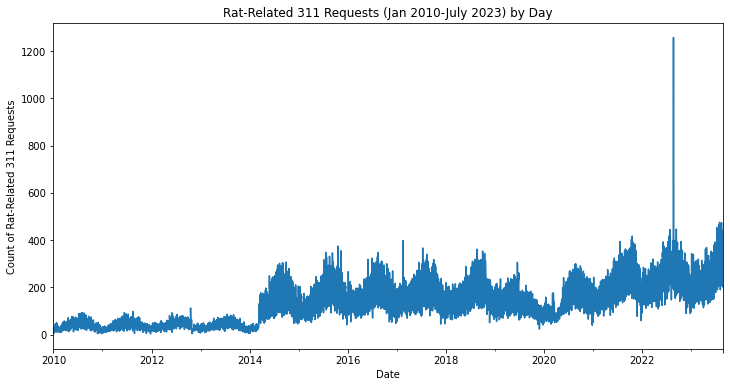

In [10]:
daily = get_aggregates(df, level='date')

#plot daily cases
daily.plot(x='ds', 
           y='y',
           xlabel='Date',
           ylabel="Count of Rat-Related 311 Requests",
           legend=False,
           title='Rat-Related 311 Requests (Jan 2010-July 2023) by Day',
           figsize=(12,6))

To give more context around the uptick of rat-related requests in 2014, let's take a look at the annual trends of each type of complaint. The below plot indicates that unsanitary condition requests started to be categorized in 2014 and Dead Animal requests started to be categorized in 2021. This unsanitary condition uptick gives us more clarity that rat-related 311 requests didn't only increase in 2014 due to additional requests but increased due to additional categories of rat-related requests.

<AxesSubplot:title={'center':'Annual Volume of 311 Requests by Complaint Type'}, xlabel='Year', ylabel='Number of Rat-related 311 requests'>

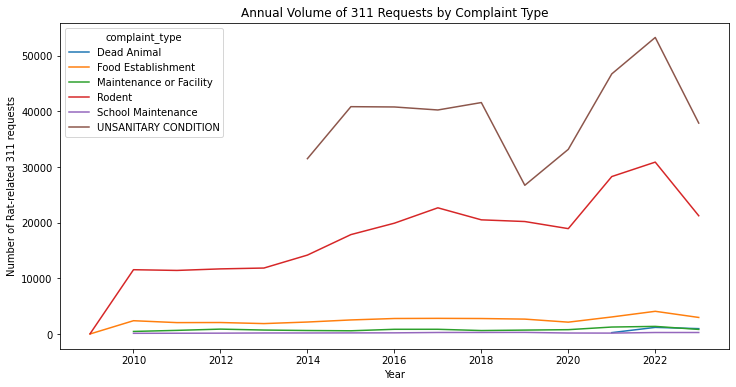

In [11]:
# number of complaints by year and by complaint type
yearly = df.groupby(["year", "complaint_type"]).agg({'unique_key':'count'}).reset_index().rename(columns={'unique_key':'count'})
yearly = yearly.pivot(index='year', columns='complaint_type', values='count').reset_index().reindex()

# plot yearly complaints by type
yearly.plot(x='year',
                 title='Annual Volume of 311 Requests by Complaint Type',
                 xlabel='Year',
                 ylabel="Number of Rat-related 311 requests",
                 figsize=(12,6))

Similar to the daily trend data, there seem to be strong yearly seasonal trends after 2014.

<AxesSubplot:title={'center':'Rat-Related 311 Requests (Jan 2010-July 2023) by Week'}, xlabel='Date', ylabel='Count of Rat-Related 311 Requests'>

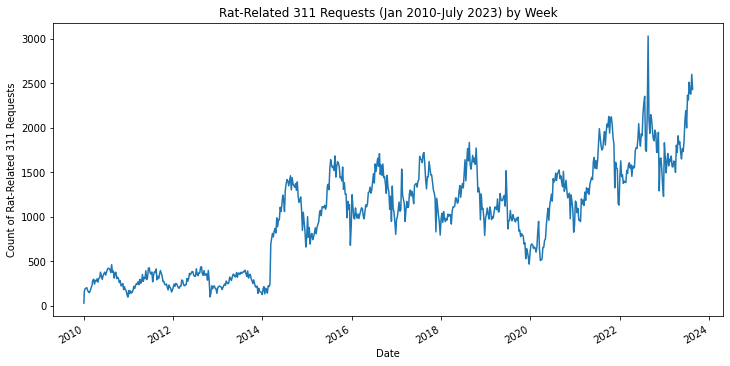

In [12]:
weekly = get_aggregates(df, level='week')

# plot weekly cases
weekly.plot(x='ds',
           y='y',
           xlabel='Date',
           ylabel="Count of Rat-Related 311 Requests",
           legend=False,
           title='Rat-Related 311 Requests (Jan 2010-July 2023) by Week',
           figsize=(12,6))

Plotting weekly totals by the week of the year (0-52, because python starts counting at 0), we can see that there is a clear curve of yearly cases. Across all years of data, rat-related 311 requests start lower in the beginning of the year, peak in the summer, and then drop off towards the end of the year in colder months. The darker lines depict averages over time-based clusters (2010-2013, 2014-2016, 2017-2019, 2020, 2021-2023).

Text(0.5, 0, 'Week of the Year')

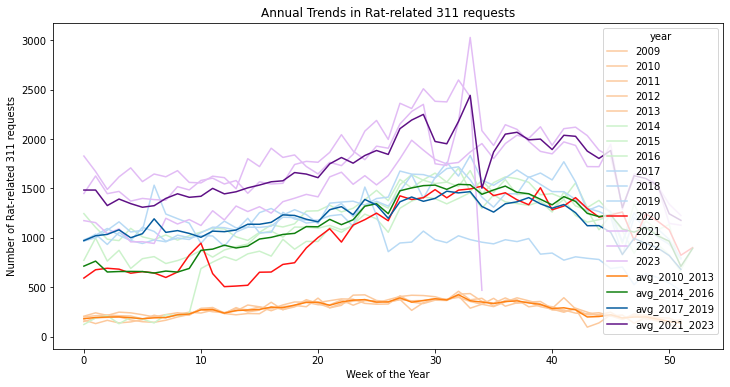

In [13]:
# agg number of complaints by week, year
weekly_summary = df.groupby(["week", "year"]).agg({'unique_key': 'count'}).reset_index().rename(columns={'unique_key': "count"})
weekly_summary = weekly_summary.pivot(index='week', columns='year', values='count').reset_index().reindex()

# create new cols with averages
weekly_summary['avg_2010_2013'] = weekly_summary[[2010, 2011, 2012, 2013]].mean(axis=1)
weekly_summary['avg_2014_2016'] = weekly_summary[[2014, 2015, 2016]].mean(axis=1)
weekly_summary['avg_2017_2019'] = weekly_summary[[2017, 2018, 2019]].mean(axis=1)
weekly_summary['avg_2021_2023'] = weekly_summary[[2021, 2022, 2023]].mean(axis=1)
weekly_summary = weekly_summary.drop(['week'], axis=1)

weekly_summary.plot(use_index=False,
                     color={#group - orange
                            'avg_2010_2013': "#ff8112",
                            2009: "#fcc99d",
                            2010: "#fcc99d",
                            2011: "#fcc99d",
                            2012: "#fcc99d",
                            2013: '#fcc99d',
                            #group - green
                            'avg_2014_2016': '#10800e',
                            2014: '#ccf2cb',
                            2015: '#ccf2cb',
                            2016: '#ccf2cb',
                            #group - blue
                            'avg_2017_2019': '#055c9e',
                            2017: '#b8daf5',                         
                            2018: "#b8daf5",
                            2019: "#b8daf5",
                            #red
                            2020: "#ff1212",
                            #group - purple
                            'avg_2021_2023': '#5e1085',
                            2021: '#e2bcf5',
                            2022: '#e2bcf5',
                            2023: '#e2bcf5'
                            },
                     xlabel="Week of the Year",
                     ylabel="Number of Rat-related 311 requests",
                     figsize=(12,6),
                     title="Annual Trends in Rat-related 311 requests"
                     )

plt.xlabel("Week of the Year")

<AxesSubplot:title={'center':'Rat-Related 311 Requests (Jan 2010-July 2023) by Month'}, xlabel='Date', ylabel='Count of Rat-Related 311 Requests'>

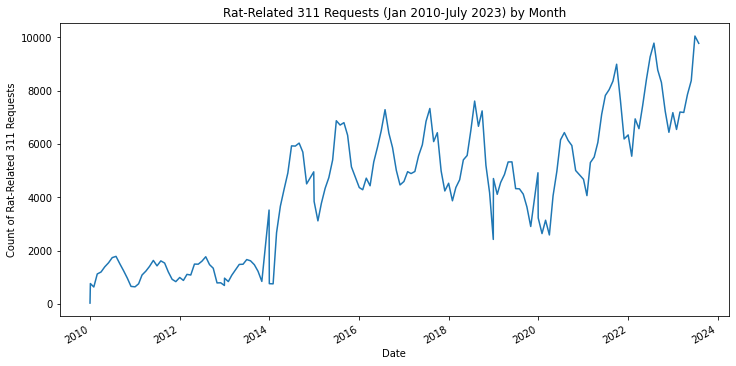

In [14]:
monthly = get_aggregates(df, level='month')

# plot weekly cases
monthly.plot(x='ds',
           y='y',
           xlabel='Date',
           ylabel="Count of Rat-Related 311 Requests",
           legend=False,
           title='Rat-Related 311 Requests (Jan 2010-July 2023) by Month',
           figsize=(12,6))

#### Subsetting train and test sets

Given the descriptive trends above, we need to decide what subset of the data to use to train our time-series model. Given that unsanitary conditions only started to be categorized in the spring of 2014, we can train the model on data after that shift in order to minimize the likelihood that the model will try to model based on that shift. *That said, the model will be trained on data from June 2014-2022 and tested on data after June 2022.*

The data is available at the daily level, but there are significant weekly trends (e.g. fewer complaints on sat/sun) so we can try modeling two different levels of aggregation (daily and weekly totals).

In [15]:
import datetime

def train_test_split(df,
                     n_months_to_predict=3,
                     train_start=None, 
                     train_end=None, 
                     test_start=None, 
                     test_end=None):
    '''
    Split a dataset into training and testing data based on input dates and level of aggregation.
    
    Inputs:
        df (pandas dataframe)
        train_start (str): in format "YYYY-MM-DD"
        train_end (str): in format "YYYY-MM-DD"
        test_start (str): in format "YYYY-MM-DD"
        test_end (str): in format "YYYY-MM-DD"
    
    Returns:
        df_train (pandas dataframe)
        df_test (pandas dataframe)
    '''
    #set defaults given n_months_to predict
    if test_end is None:
        #offset by one day so that it is complete data
        test_end = datetime.date.today() - pd.DateOffset(days=1) 

    if test_start is None:
        #get n months of data given input n_months
        test_start = test_end - pd.DateOffset(months=n_months_to_predict)

    if train_end is None:
        #offset train end by one day before test start
        train_end = test_start - pd.DateOffset(days=1)
    
    if train_start is None:
        train_start = '2014-06-01'

    for date in [train_start, train_end, test_start, test_end]:
        date = pd.to_datetime(date)
       
    train = df.loc[(df.loc[:,'ds'] >= train_start) & (df.loc[:,'ds'] < train_end),:] 
    test = df.loc[(df.loc[:,'ds'] >= test_start) & (df.loc[:,'ds'] < test_end),:]
    
    return train, test

The below visualizations clarify what data is used to train and test the daily and weekly models.

##### Daily

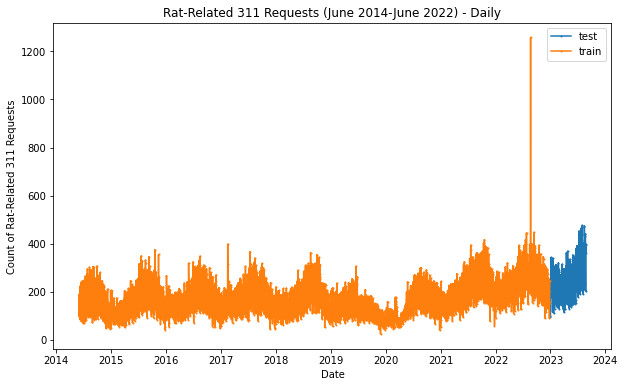

In [16]:
#use function to get training and test data sets
daily_train, daily_test = train_test_split(df=daily, n_months_to_predict=8)
daily_subset = pd.concat([daily_train, daily_test], axis=0, keys=['train', 'test']).reset_index()

# plot training and testing data
plt.figure(figsize=(10,6))
groups = daily_subset.groupby('level_0')

for name, group in groups:
    plt.plot(group.ds, 
             group.y,
             marker='o', 
             linestyle='-', 
             markersize=1, 
             label=name)

plt.xlabel('Date')
plt.ylabel('Count of Rat-Related 311 Requests')
plt.title('Rat-Related 311 Requests (June 2014-June 2022) - Daily')
plt.legend()

##### Weekly

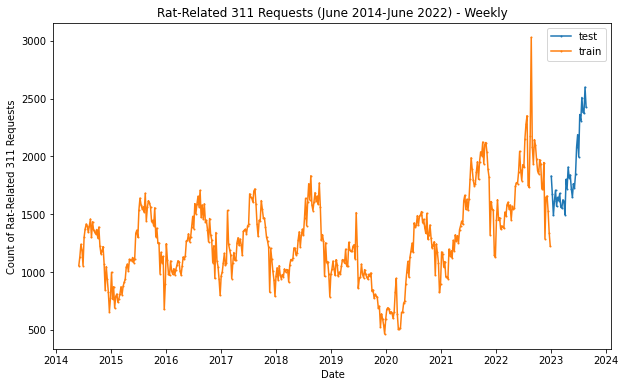

In [17]:
#use function to get training and test data sets
weekly_train, weekly_test = train_test_split(df=weekly, n_months_to_predict=8)
weekly_subset = pd.concat([weekly_train, weekly_test], axis=0, keys=['train', 'test']).reset_index()

# plot training and testing data
plt.figure(figsize=(10,6))
groups = weekly_subset.groupby('level_0')

for name, group in groups:
    plt.plot(group.ds, 
             group.y,
             marker='o', 
             linestyle='-', 
             markersize=1, 
             label=name)

plt.xlabel('Date')
plt.ylabel('Count of Rat-Related 311 Requests')
plt.title('Rat-Related 311 Requests (June 2014-June 2022) - Weekly')
plt.legend()

##### Monthly

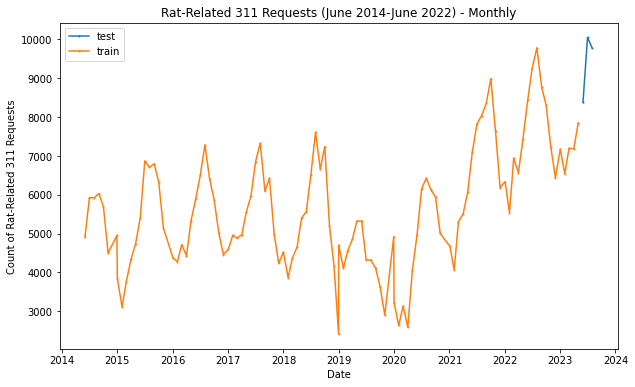

In [18]:
#use function to get training and test data sets
monthly_train, monthly_test = train_test_split(df=monthly, n_months_to_predict=3)
monthly_subset = pd.concat([monthly_train, monthly_test], axis=0, keys=['train', 'test']).reset_index()

# plot training and testing data
plt.figure(figsize=(10,6))
groups = monthly_subset.groupby('level_0')

for name, group in groups:
    plt.plot(group.ds, 
             group.y,
             marker='o', 
             linestyle='-', 
             markersize=1, 
             label=name)

plt.xlabel('Date')
plt.ylabel('Count of Rat-Related 311 Requests')
plt.title('Rat-Related 311 Requests (June 2014-June 2022) - Monthly')
plt.legend()

### Model Development

#### Overview of Prophet Model

The Prophet model is a time series forecasting tool developed by Facebook's Core Data Science team. It is designed to handle time series data with strong seasonal patterns and holidays. The model incorporates various components, including trend, seasonality (modeled using Fourier series), and holiday effects, providing an easy-to-use and effective solution for forecasting tasks. Prophet models can be tuned with a variety of trend and seasonality/holiday parameters.

In [19]:
pip install prophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 96.5 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 754.3/754.3 kB 108.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 114.5 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 131.4 MB/s eta 0:00:00
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732002 sha256=d5c681a171559f33067409a02dab1103f87e64f1f592d3b11085387aac31593e
  Stored in directory: /home/ubuntu/.cache/pip/wheels/c2/3a/3d/11734e652782d3f823a08aae1c452e887eb16349750cca3f8a
Successfully built pymeeus

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use u

In [20]:
import prophet
from prophet import Prophet
import matplotlib.pyplot as plt
import itertools

#### Assessing Model Fit

Before we play around with changing our model parameters, we will define a few measures of model performance to compare models to each other.

* **Coverage of Prediction Intervals:** If your Prophet model provides prediction intervals, you can assess how well the intervals capture the actual data. A higher percentage of actual data falling within the prediction intervals indicates better calibration. If we maximize being “within” prediction intervals, we are optimizing the model for the shape of the data and predicting outliers successfully. This puts less weight on individual weekly predictions being accurate, but rather that the most values are within the range we are looking at. Right now, this makes the most sense to be based on what we want to use the model for!

* **Mean Absolute Percentage Error (MAPE):** MAPE measures the percentage difference between the actual and predicted values. It provides a relative measure of the forecasting accuracy, making it easier to interpret. MAPE is not sensitive to the scale of the data, making it more appropriate when dealing with datasets with varying scales. One limitation of MAPE is that it can be sensitive to small actual values, as the percentage error can become very large for small denominators. This can result in a larger impact on the overall error for smaller actual values. MAPE values closer to zero indicate better performance. If we prioritize minimizing MAPE, we are selecting the model that minimizes the average percentage of the actual value of rat-related 311 requests the prediction is off by in our test data set. This metric might do worse with smaller geographies because the magnitude of those values are so small so the percentage adjustments would be larger for those differences between the predicted and actual values (think: a small Bronx community district with 5 rat-related requests one week and 20 the next month would likely do poorly and this metric might be high).
    
As we finetune our model parameters, we are aiming to maximize the coverage of prediction intervals (first priority) and minimize MAPE (second priority).

In [21]:
import numpy as np

def percentage_in_confidence_interval(forecast):
    '''
    Calculates the number of actual values that fall within the predicted confidence interval (80% certainty) 
    
    Input: pandas Dataframe, "forecast" output from prophet model
    Return: dictionary (key is string, value is float) which has percentages of actual values that fall
        within expected range, above expected range, and below the expected range.
    '''
    # create new column in df that categorizes the yhat in relation to y
    forecast.loc[:,'in_conf_int'] = "within expected range"
    forecast.loc[(forecast.loc[:,'y'] > forecast.loc[:,'yhat_upper']), 'in_conf_int'] = "above expected range"
    forecast.loc[(forecast.loc[:,'y'] < forecast.loc[:,'yhat_lower']), 'in_conf_int'] = "below expected range"
    
    # return dictionary of frequencies of each of those values
    return dict((forecast.loc[:,'in_conf_int'].value_counts()/forecast.shape[0])*100)

def mean_absolute_percentage_error(forecast):
    '''
    Calculates the mean absolute percentage error of the forecast.
    
    Inputs: pandas Dataframe, "forecast" output from prophet model
    Return: MAPE as a float
    '''
    y_true, y_pred = np.array(forecast.loc[:,'y']), np.array(forecast.loc[:,'yhat'])
    return (np.mean(np.abs(y_true - y_pred) / y_true) * 100)

Because we'll be making a lot of different models and want to test for their fit, lets make a function that creates a plot of predictions given a model and returns the forecast as a dataframe so that we can calculate MAPE and percent in confidence interval.

In [22]:
def get_forecast(model, train, test, level, plot=True, title_suffix=''):
    '''
    Get the forecast table from prophet, and plot if indicated.
    
    Inputs: 
        model: Prophet model object
        train: pandas Dataframe of train data (includes 'ds','y' - output of train_test_split function)
        test: pandas Dataframe of test data (includes 'ds','y'- output of train_test_split function)
        plot: boolean - defaults to True
        title suffix: string, used when labeling plots for smaller geographies.
    
    Returns: pandas Dataframe of forecast (note: if plot=True, the plot is printed but it is not returned.)
    '''
    #set number of predictions based on the size of the test data
    periods = test.shape[0]
    
    if level == "date":
        freq='D'
    if level == "week":
        freq='W'
    if level == "month":
        freq='M'
    
    # fit model with train data
    model.fit(train)

    # predict 1 year of data
    future = model.make_future_dataframe(periods=periods, include_history=False, freq=freq)
    forecast = model.predict(future)

    # join in 1 year of test data to forecase (actual values)
    test = test.set_index(forecast.index)
    forecast.loc[:,'y'] = test.loc[:,'y']

    if plot == True:
        # plot forecast
        fig1 = model.plot(forecast, figsize=(10,4))
        a = prophet.plot.add_changepoints_to_plot(fig1.gca(), model, forecast)

        plt.scatter(x=test['ds'], y=test['y'], c='red',marker='.')
        plt.xlabel("Year")
        plt.ylabel("Number of Rat-Related 311 Requests")
        
        if title_suffix != '':
            plt.title(level.title()+" Predicted Rat-Related 311 Calls for "+ title_suffix)
        else:
            plt.title(level.title()+" Predicted Rat-Related 311 Calls")
    
    return forecast

#### Default Models (daily, weekly, monthly)

Before we start fine tuning our model parameters, let's look at the model fit with the baseline, out-of-the-box model at the daily, monthly, and weekly levels.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/hoqqn_up.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/f4u6x273.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/opt/conda/lib/python3.8/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97188', 'data', 'file=/tmp/tmpkrazmhol/hoqqn_up.json', 'init=/tmp/tmpkrazmhol/f4u6x273.json', 'output', 'file=/tmp/tmpkrazmhol/prophet_modelqajiyv28/prophet_model-20230830141541.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:15:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:15:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


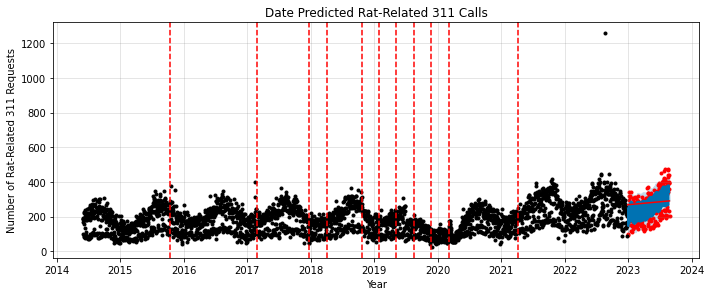

In [23]:
daily_m = Prophet()

daily_forecast = get_forecast(model=daily_m, 
                              train=daily_train, 
                              test=daily_test, 
                              level="date")

In [24]:
percentage_in_confidence_interval(daily_forecast)

{'within expected range': 55.601659751037346,
 'below expected range': 28.21576763485477,
 'above expected range': 16.182572614107883}

In [25]:
mean_absolute_percentage_error(daily_forecast)

24.644341567985446

Let's compare this running the default model on our weekly data.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/kksr1i0k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/cz0y4vfn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/opt/conda/lib/python3.8/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80166', 'data', 'file=/tmp/tmpkrazmhol/kksr1i0k.json', 'init=/tmp/tmpkrazmhol/cz0y4vfn.json', 'output', 'file=/tmp/tmpkrazmhol/prophet_modelktbrkzpv/prophet_model-20230830141543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:15:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:15:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


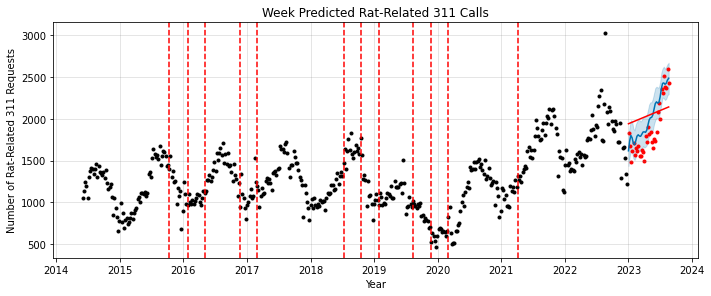

In [26]:
weekly_m = Prophet()

weekly_forecast = get_forecast(model=weekly_m, 
                               train=weekly_train, 
                               test=weekly_test, 
                               level="week")

In [27]:
percentage_in_confidence_interval(weekly_forecast)

{'within expected range': 58.82352941176471,
 'below expected range': 38.23529411764706,
 'above expected range': 2.941176470588235}

In [28]:
mean_absolute_percentage_error(weekly_forecast)

9.82575143229229

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/xlgb1jph.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/ia61c7gf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/opt/conda/lib/python3.8/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63276', 'data', 'file=/tmp/tmpkrazmhol/xlgb1jph.json', 'init=/tmp/tmpkrazmhol/ia61c7gf.json', 'output', 'file=/tmp/tmpkrazmhol/prophet_modelynfhlbbb/prophet_model-20230830141543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:15:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:15:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


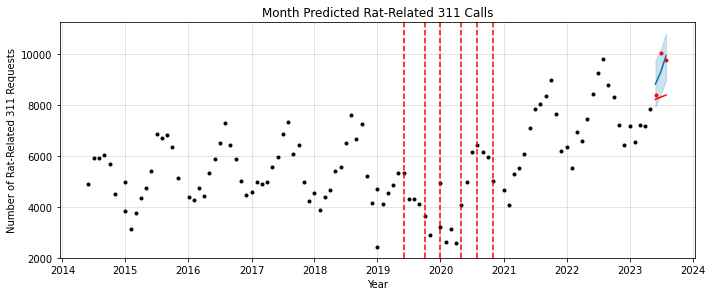

In [29]:
monthly_m = Prophet()

monthly_forecast = get_forecast(model=monthly_m, 
                               train=monthly_train, 
                               test=monthly_test, 
                               level="month")

In [30]:
percentage_in_confidence_interval(monthly_forecast)

{'within expected range': 100.0}

In [31]:
mean_absolute_percentage_error(monthly_forecast)

4.816815096624303

On it's face, the default monthly model out performs the daily and weekly models on "within expected range". However, the goal of creating this predictive model is to give real-time indications of where rat-related 311 requests are outside of expectations, so aggregating at the month level would not give the right level of quick feedback for decision making. 

Although the weekly model has a poor model fit with the default model, it's shape seems to be a right for the data and therefore might be a better candidate for parameter fine tuning in order to improve model predictions.

#### Parameter Tuning

*Default Model*

The default Prophet models above used the following parameters, descriptions below.

__init__(self, growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None)

There are a lot of parameters to unpack (you can explore all of them by uncommenting the code below (help(Prophet)), but let's explore a few that will help control how our model will work.

In [32]:
#help(Prophet)

*Changepoints*

Changepoints are essentially *dates* where there was a shift in behavior in the time series data. In many real-world scenarios, time series data can exhibit various structural breaks due to external events, policy changes, or shifts in user behavior (think: COVID and it's impact on reporting 311 requests in March 2020). If these changepoints are not appropriately accounted for, the forecasting model may have a harder time separating the trend line from seasonal patterns and therefore might make unreliable predictions.

Prophet allows for automatic detection of changepoints by considering potential locations in the time series where a change might occur. It then evaluates the impact of each potential changepoint on the overall model performance and selects the most relevant ones to incorporate in the forecasting process. 

In order to capture these changepoints appropriately in the model, there are a few parameters that are relevant:
* `changepoint_range` (*default: 0.8*): Proportion of history in which trend changepoints will be estimated. Defaults to 0.8 for the first 80%. Not used if `changepoints` is specified. 
* `changepoint_prior_scale` (*default: 0.5*): Parameter that controls the flexibility of the trend around the changepoints. Higher values make the trend more flexible, allowing it to fit more closely to the data points and potentially capturing more changepoints. 

By identifying and including changepoints in the model, Prophet can better adapt to the time series data's inherent non-stationarity and provide more accurate and robust forecasts. However, it's essential to strike a balance when choosing the changepoint_prior_scale parameter to avoid overfitting to noise or detecting too many changepoints.

For our purposes, we can do some tests to explore what changepoint parameters best fit our city-wide weekly model.

##### Modeling seasonality with fourier series

Fourier series is a mathematical technique that can approximate a wide range of periodic functions by combining sine and cosine functions with different frequencies and amplitudes. In the context of Prophet, the Fourier order determines the number of Fourier terms used to model the seasonality component of the time series. Each Fourier term is composed of two components: a sine term and a cosine term. These terms combine to form a wave pattern with a particular frequency. By increasing the Fourier order, you allow the model to capture more complex and higher-frequency seasonality patterns in the data.

As we increase the fourier order (from 1 to 4), we can see below that the line is more sensitive to fluctuations in faster-changing cycles.

![Fourier](https://miro.medium.com/v2/resize:fit:512/1*hBR26OFeHQgRS2XFC3QZMA.gif "fourier")
<h6><center>(credit: Deepti Goyal, Analytics Vidhya)</center></h6>

Choosing the appropriate Fourier order for the relevant data is crucial in the Prophet model, as using too few terms might result in underfitting, leading to the model being unable to capture the full complexity of the seasonality. On the other hand, using too many terms can lead to overfitting, where the model fits noise in the data rather than true patterns.

In order to capture these changepoints appropriately in the model, there are a few parameters that are relevant:
* `yearly_seasonality` (*default: 'auto'*): Fit yearly seasonality. Can be 'auto', True, False, or a number of Fourier terms to generate.
* `weekly_seasonality` (*default: 'auto'*): Fit weekly seasonality. Can be 'auto', True, False, or a number of Fourier terms to generate.
* `daily_seasonality` (*default: 'auto'*): Fit daily seasonality. Can be 'auto', True, False, or a number of Fourier terms to generate.

According to [greykite](https://linkedin.github.io/greykite/docs/0.1.0/html/pages/model_components/0300_seasonality.html#:~:text=Usually%20monthly%20seasonality%20has%20a,its%20Fourier%20order%20to%202.), a time-series forecasting library, typical values are <= 4, up to 12 for daily seasonality, and up to 15 for yearly seasonality. The forecast will not improve (and may get worse) if Fourier order is too high.

The Fourier order k should satisfy k <= (n_levels+1)/2. n_levels is the number of possible values in a cycle. For example, if your input data is at daily frequency:

* monthly seasonality: n_levels=31 days in a month. 

* weekly seasonality: n_levels=7 days in a week. 

* daily seasonality: n_levels=1 hours in a day.

Therefore if we use weekly data, then the following would apply:

* yearly seasonality: n_levels=52 weeks in a year. (52 + 1)/2 = 26.5 max

* quarterly seasonality: n_levels=13 weeks in a quarter. (13 + 1)/2 = 7 max

* monthly seasonality: n_levels=4 weeks in a month. (4 + 1)/2 = 2.5 max


For our purposes, we can do some tests to explore what fourier parameters to use to fine tune our models.

In [33]:
# set options of parameters to test
params = {
    # changepoint parameters
    'changepoint_range': [0.8, 0.85, 0.9],
    'changepoint_prior_scale': [0.5, 0.6, 0.7],
    # seasonality parameters
    'm_fourier': [False, 2, 3],
    'q_fourier': [False, 4, 5, 6, 7],
    'y_fourier': [False, 10, 11, 12]
}

In order to see what parameters work the best, let's run all combinations of these parameters and see which models perform best. First, let's make sure that the amount of model runs is reasonable to test (less than 600 or so is fine and should only take a minute or so).

In [34]:
# Generate all combinations of parameters
all_params = [dict(zip(params.keys(), v)) for v in itertools.product(*params.values())]
len(all_params)

540

Because we will likely need to do these for smaller geographies, we can functionalize this optimization process (called grid searching), returning the parameters that optimize the percentage of actual values within the confidence interval, and then the mean_absolute_percentage_error if there is a tie for "within CI".

In [35]:
def build_model(params):
    '''
    Builds a model given a dictionary of parameters:
    
    Inputs: params (dict), keys are names of Prophet() parameters, values are the values of the parameters
    Returns: Prophet model object    
    '''
    # set model with passed in parameters
    m = Prophet(changepoint_range=params['changepoint_range'],
                changepoint_prior_scale=params['changepoint_prior_scale'],

                # defaults across all models
                daily_seasonality=False,
                weekly_seasonality=False)

    # add seasonality
    if params['m_fourier'] != False:
        m.add_seasonality(name='monthly', period=30.5, fourier_order=int(params['m_fourier']))
    if params['q_fourier'] != False:
        m.add_seasonality(name='quarterly', period=365.25/4, fourier_order=int(params['q_fourier']))
    if params['y_fourier'] != False:
        m.add_seasonality(name='yearly', period=365.25, fourier_order=int(params['y_fourier']))

    return m

In [36]:
from joblib import Parallel, delayed

def evaluate_model(params, level, train, test):
    '''
    Generates dictionary of performance metrics for a model, including the params used to generate the model.
    
    Inputs: 
        params: dictionary of model parameters to use
        level: string, either 'date', 'week', or 'month'
        train: pandas Dataframe of train data (includes 'ds','y' - output of train_test_split function)
        test: pandas Dataframe of test data (includes 'ds','y'- output of train_test_split function)
    
    Returns: dictionary with metrics to evaluate model and params used to generate the model.
    '''
    # set model with passed in parameters
    m = build_model(params=params)
        
    # get forecast
    forecast = get_forecast(model=m, 
                            train=train, 
                            test=test, 
                            level=level,
                            plot=False)

    # create dictionary to track the performance metrics for each model run and populate dict with perfomance stats
    model_performance = {}
    
    # add all params to dictionary
    for key, value in params.items():
        model_performance[key] = value
    
    # add MAPE and percent in CI to dictionary
    model_performance['mean_absolute_percentage_error'] = mean_absolute_percentage_error(forecast)

    for key, value in percentage_in_confidence_interval(forecast).items():
        model_performance[key] = value

    return model_performance

In [37]:
from datetime import date

def grid_search(df, all_params, level, return_best_model_only, n_months_to_predict):
    '''
    Tries all possible model options to find the best params to optimize the model based on highest percentage within
    expected range and lowest MAPE.
    
    Inputs:
        df: pandas dataframe (before spliting for train, test - all data of interest)
        all params: list of dictionaries that have all possible options of params to try
        return_best_model_only: boolean, True if you want only the best params available, 
            False if you want results for all the models generated
        n_months_to_predict: integer for the number of months of data you want to predict
    
    Returns: df of ranked models or dictionary of the params of the best model only 
        (depending on the boolean value for 'return_best_model_only')  
    '''

    aggregated_df = get_aggregates(df, level)

    train, test = train_test_split(df=aggregated_df, 
                                   n_months_to_predict=n_months_to_predict)

    #if not enough data in either set for meaningful predictions
    if train.shape[0] < 5 or test.shape[0] == 0:
        return {}
    
    results = Parallel(n_jobs=-1)(delayed(evaluate_model)(params,level,train,test) for params in all_params)

    ranked_models = pd.DataFrame.from_records(results).sort_values(['within expected range', 'mean_absolute_percentage_error'],
                                                               ascending=[False, True])
    
    if return_best_model_only is True:
        return ranked_models.iloc[0]
    else:
        return ranked_models

In [38]:
ranked_models = grid_search(df=df, 
                            all_params=all_params,
                            level='week', 
                            return_best_model_only=False,
                            n_months_to_predict=3)

14:15:46 - cmdstanpy - INFO - Chain [1] start processing
14:15:46 - cmdstanpy - INFO - Chain [1] start processing
14:15:46 - cmdstanpy - INFO - Chain [1] start processing
14:15:46 - cmdstanpy - INFO - Chain [1] start processing
14:15:46 - cmdstanpy - INFO - Chain [1] start processing
14:15:46 - cmdstanpy - INFO - Chain [1] start processing
14:15:46 - cmdstanpy - INFO - Chain [1] done processing
14:15:46 - cmdstanpy - INFO - Chain [1] done processing
14:15:46 - cmdstanpy - INFO - Chain [1] done processing
14:15:46 - cmdstanpy - INFO - Chain [1] done processing
14:15:46 - cmdstanpy - INFO - Chain [1] done processing
14:15:46 - cmdstanpy - INFO - Chain [1] start processing
14:15:46 - cmdstanpy - INFO - Chain [1] done processing
14:15:46 - cmdstanpy - INFO - Chain [1] start processing
14:15:46 - cmdstanpy - INFO - Chain [1] start processing
14:15:46 - cmdstanpy - INFO - Chain [1] start processing
14:15:46 - cmdstanpy - INFO - Chain [1] start processing
14:15:46 - cmdstanpy - INFO - Chain [

14:15:50 - cmdstanpy - INFO - Chain [1] done processing
14:15:50 - cmdstanpy - INFO - Chain [1] start processing
14:15:50 - cmdstanpy - INFO - Chain [1] start processing
14:15:50 - cmdstanpy - INFO - Chain [1] done processing
14:15:50 - cmdstanpy - INFO - Chain [1] start processing
14:15:50 - cmdstanpy - INFO - Chain [1] start processing
14:15:50 - cmdstanpy - INFO - Chain [1] done processing
14:15:50 - cmdstanpy - INFO - Chain [1] start processing
14:15:50 - cmdstanpy - INFO - Chain [1] done processing
14:15:50 - cmdstanpy - INFO - Chain [1] start processing
14:15:50 - cmdstanpy - INFO - Chain [1] done processing
14:15:50 - cmdstanpy - INFO - Chain [1] done processing
14:15:50 - cmdstanpy - INFO - Chain [1] done processing
14:15:50 - cmdstanpy - INFO - Chain [1] start processing
14:15:50 - cmdstanpy - INFO - Chain [1] start processing
14:15:50 - cmdstanpy - INFO - Chain [1] done processing
14:15:50 - cmdstanpy - INFO - Chain [1] start processing
14:15:50 - cmdstanpy - INFO - Chain [1]

14:15:54 - cmdstanpy - INFO - Chain [1] start processing
14:15:54 - cmdstanpy - INFO - Chain [1] done processing
14:15:54 - cmdstanpy - INFO - Chain [1] start processing
14:15:54 - cmdstanpy - INFO - Chain [1] start processing
14:15:54 - cmdstanpy - INFO - Chain [1] done processing
14:15:54 - cmdstanpy - INFO - Chain [1] start processing
14:15:54 - cmdstanpy - INFO - Chain [1] start processing
14:15:55 - cmdstanpy - INFO - Chain [1] done processing
14:15:55 - cmdstanpy - INFO - Chain [1] done processing
14:15:55 - cmdstanpy - INFO - Chain [1] done processing
14:15:55 - cmdstanpy - INFO - Chain [1] done processing
14:15:55 - cmdstanpy - INFO - Chain [1] start processing
14:15:55 - cmdstanpy - INFO - Chain [1] start processing
14:15:55 - cmdstanpy - INFO - Chain [1] start processing
14:15:55 - cmdstanpy - INFO - Chain [1] start processing
14:15:55 - cmdstanpy - INFO - Chain [1] done processing
14:15:55 - cmdstanpy - INFO - Chain [1] done processing
14:15:55 - cmdstanpy - INFO - Chain [1]

14:15:59 - cmdstanpy - INFO - Chain [1] start processing
14:15:59 - cmdstanpy - INFO - Chain [1] start processing
14:15:59 - cmdstanpy - INFO - Chain [1] done processing
14:15:59 - cmdstanpy - INFO - Chain [1] start processing
14:15:59 - cmdstanpy - INFO - Chain [1] start processing
14:15:59 - cmdstanpy - INFO - Chain [1] done processing
14:15:59 - cmdstanpy - INFO - Chain [1] start processing
14:15:59 - cmdstanpy - INFO - Chain [1] start processing
14:15:59 - cmdstanpy - INFO - Chain [1] done processing
14:15:59 - cmdstanpy - INFO - Chain [1] done processing
14:15:59 - cmdstanpy - INFO - Chain [1] done processing
14:15:59 - cmdstanpy - INFO - Chain [1] done processing
14:15:59 - cmdstanpy - INFO - Chain [1] start processing
14:15:59 - cmdstanpy - INFO - Chain [1] start processing
14:15:59 - cmdstanpy - INFO - Chain [1] start processing
14:15:59 - cmdstanpy - INFO - Chain [1] done processing
14:15:59 - cmdstanpy - INFO - Chain [1] done processing
14:15:59 - cmdstanpy - INFO - Chain [1]

14:16:03 - cmdstanpy - INFO - Chain [1] done processing
14:16:03 - cmdstanpy - INFO - Chain [1] start processing
14:16:03 - cmdstanpy - INFO - Chain [1] start processing
14:16:03 - cmdstanpy - INFO - Chain [1] start processing
14:16:03 - cmdstanpy - INFO - Chain [1] done processing
14:16:03 - cmdstanpy - INFO - Chain [1] done processing
14:16:03 - cmdstanpy - INFO - Chain [1] start processing
14:16:03 - cmdstanpy - INFO - Chain [1] done processing
14:16:03 - cmdstanpy - INFO - Chain [1] done processing
14:16:03 - cmdstanpy - INFO - Chain [1] start processing
14:16:03 - cmdstanpy - INFO - Chain [1] done processing
14:16:03 - cmdstanpy - INFO - Chain [1] start processing
14:16:03 - cmdstanpy - INFO - Chain [1] start processing
14:16:03 - cmdstanpy - INFO - Chain [1] start processing
14:16:03 - cmdstanpy - INFO - Chain [1] done processing
14:16:03 - cmdstanpy - INFO - Chain [1] done processing
14:16:03 - cmdstanpy - INFO - Chain [1] done processing
14:16:04 - cmdstanpy - INFO - Chain [1] 

14:16:08 - cmdstanpy - INFO - Chain [1] start processing
14:16:08 - cmdstanpy - INFO - Chain [1] done processing
14:16:08 - cmdstanpy - INFO - Chain [1] start processing
14:16:08 - cmdstanpy - INFO - Chain [1] start processing
14:16:08 - cmdstanpy - INFO - Chain [1] done processing
14:16:08 - cmdstanpy - INFO - Chain [1] start processing
14:16:08 - cmdstanpy - INFO - Chain [1] done processing
14:16:08 - cmdstanpy - INFO - Chain [1] done processing
14:16:08 - cmdstanpy - INFO - Chain [1] start processing
14:16:08 - cmdstanpy - INFO - Chain [1] done processing
14:16:08 - cmdstanpy - INFO - Chain [1] done processing
14:16:08 - cmdstanpy - INFO - Chain [1] start processing
14:16:08 - cmdstanpy - INFO - Chain [1] start processing
14:16:08 - cmdstanpy - INFO - Chain [1] start processing
14:16:08 - cmdstanpy - INFO - Chain [1] start processing
14:16:08 - cmdstanpy - INFO - Chain [1] done processing
14:16:08 - cmdstanpy - INFO - Chain [1] done processing
14:16:08 - cmdstanpy - INFO - Chain [1]

14:16:12 - cmdstanpy - INFO - Chain [1] start processing
14:16:12 - cmdstanpy - INFO - Chain [1] done processing
14:16:12 - cmdstanpy - INFO - Chain [1] start processing
14:16:12 - cmdstanpy - INFO - Chain [1] done processing
14:16:12 - cmdstanpy - INFO - Chain [1] start processing
14:16:12 - cmdstanpy - INFO - Chain [1] done processing
14:16:12 - cmdstanpy - INFO - Chain [1] done processing
14:16:12 - cmdstanpy - INFO - Chain [1] start processing
14:16:12 - cmdstanpy - INFO - Chain [1] done processing
14:16:12 - cmdstanpy - INFO - Chain [1] start processing
14:16:12 - cmdstanpy - INFO - Chain [1] start processing
14:16:12 - cmdstanpy - INFO - Chain [1] start processing
14:16:12 - cmdstanpy - INFO - Chain [1] done processing
14:16:12 - cmdstanpy - INFO - Chain [1] done processing
14:16:12 - cmdstanpy - INFO - Chain [1] done processing
14:16:12 - cmdstanpy - INFO - Chain [1] start processing
14:16:12 - cmdstanpy - INFO - Chain [1] done processing
14:16:12 - cmdstanpy - INFO - Chain [1] 

14:16:17 - cmdstanpy - INFO - Chain [1] start processing
14:16:17 - cmdstanpy - INFO - Chain [1] done processing
14:16:17 - cmdstanpy - INFO - Chain [1] done processing
14:16:17 - cmdstanpy - INFO - Chain [1] done processing
14:16:17 - cmdstanpy - INFO - Chain [1] start processing
14:16:17 - cmdstanpy - INFO - Chain [1] done processing
14:16:17 - cmdstanpy - INFO - Chain [1] done processing
14:16:17 - cmdstanpy - INFO - Chain [1] start processing
14:16:17 - cmdstanpy - INFO - Chain [1] done processing
14:16:17 - cmdstanpy - INFO - Chain [1] start processing
14:16:17 - cmdstanpy - INFO - Chain [1] start processing
14:16:17 - cmdstanpy - INFO - Chain [1] start processing
14:16:17 - cmdstanpy - INFO - Chain [1] start processing
14:16:17 - cmdstanpy - INFO - Chain [1] done processing
14:16:17 - cmdstanpy - INFO - Chain [1] done processing
14:16:17 - cmdstanpy - INFO - Chain [1] done processing
14:16:17 - cmdstanpy - INFO - Chain [1] done processing
14:16:17 - cmdstanpy - INFO - Chain [1] d

In [39]:
ranked_models.head(10)

changepoint_range  changepoint_prior_scale m_fourier q_fourier y_fourier  \
150               0.80                      0.7         2         5        11   
31                0.80                      0.5         2         5        12   
91                0.80                      0.6         2         5        12   
151               0.80                      0.7         2         5        12   
140               0.80                      0.7         2     False     False   
203               0.85                      0.5         2     False        12   
89                0.80                      0.6         2         5        10   
84                0.80                      0.6         2         4     False   
223               0.85                      0.5         3     False        12   
327               0.85                      0.7         2         4        12   

     mean_absolute_percentage_error  above expected range  \
150                        7.576871             46.153846   
31                         7.583523             46.153846   
91                         7.602587             46.153846   
151                        7.635543             46.153846   
140                        7.778912             38.461538   
203                        7.863089             46.153846   
89                         7.900407             46.153846   
84                         7.942966             38.461538   
223                        7.943582             46.153846   
327                        7.953721             46.153846   

     within expected range  below expected range  
150              46.153846              7.692308  
31               46.153846              7.692308  
91               46.153846              7.692308  
151              46.153846              7.692308  
140              46.153846             15.384615  
203              46.153846              7.692308  
89               46.153846              7.692308  
84               46.153846             15.384615  
223              46.153846              7.692308  
327              46.153846              7.692308

The above table shows us the top 10 models given the range of parameters tested. The best weekly model is a great improvement from our default model just by changing a few parameters! We went from 1.9% within our prediction confidence interval to over 50%. This shows that Prophet is super sensitive to these parameters.

#### Modifying test/train split

Test to see if changing the dates for the train/test split help improve model fit.

In [40]:
best_city_model = ranked_models.iloc[0].to_dict()
best_city_model

{'changepoint_range': 0.8,
 'changepoint_prior_scale': 0.7,
 'm_fourier': 2,
 'q_fourier': 5,
 'y_fourier': 11,
 'mean_absolute_percentage_error': 7.576871228340848,
 'above expected range': 46.15384615384615,
 'within expected range': 46.15384615384615,
 'below expected range': 7.6923076923076925}

In [41]:
model_performance_dates = {}
level = 'week'

weekly = get_aggregates(df, level=level)

for n_months in range(12,1,-1):
    # use function to get training and test data sets
    train, test = train_test_split(df=weekly, 
                                   n_months_to_predict=n_months)

    # set model with passed in parameters
    m = build_model(params=best_city_model)
    
    # get forecast
    forecast = get_forecast(model=m, 
                            train=train, 
                            test=test, 
                            level=level,
                            plot=False,
                            title_suffix= str(n_months)+" months")
    
    model = {}
    
    # add MAPE and percent in CI to dictionary
    model['mean_absolute_percentage_error'] = mean_absolute_percentage_error(forecast)

    for key, value in percentage_in_confidence_interval(forecast).items():
        model[key] = value

    # save dictionary to model_performance dictionary
    model_performance_dates[n_months] = model

pd.DataFrame(model_performance_dates).T

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/_2pr32fg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/25w6wcn_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/opt/conda/lib/python3.8/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47423', 'data', 'file=/tmp/tmpkrazmhol/_2pr32fg.json', 'init=/tmp/tmpkrazmhol/25w6wcn_.json', 'output', 'file=/tmp/tmpkrazmhol/prophet_modelnc12qufi/prophet_model-20230830141618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:16:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:16:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/4c1k

14:16:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:16:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/68pi8dhi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/__9srxpw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/opt/conda/lib/python3.8/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63975', 'data', 'file=/tmp/tmpkrazmhol/68pi8dhi.json', 'init=/tmp/tmpkrazmhol/__9srxpw.json', 'output', 'file=/tmp/tmpkrazmhol/prophet_modelomq5fiko/prophet_model-20230830141623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:16:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:16:23 - cmdstanpy - INFO - Chain [1] done proc

mean_absolute_percentage_error  below expected range  \
12                       15.444353             65.384615   
11                       13.483566             57.446809   
10                       10.932600             44.186047   
9                         8.224389             28.947368   
8                         6.043018             14.705882   
7                         5.852471             20.000000   
6                         6.514672             16.000000   
5                         6.988712             19.047619   
4                         7.263866             23.529412   
3                         7.576871             15.384615   
2                         8.040344                   NaN   

    within expected range  above expected range  
12              34.615385                   NaN  
11              42.553191                   NaN  
10              53.488372              2.325581  
9               65.789474              5.263158  
8               79.411765              5.882353  
7               73.333333              6.666667  
6               68.000000             16.000000  
5               52.380952             28.571429  
4               41.176471             35.294118  
3               38.461538             46.153846  
2               25.000000             75.000000

#### Creating Custom Models for Smaller Geographies

Now, lets retrieve the best hyperparameters for each model at borough level.

In [42]:
df.loc[:,'borough'].value_counts()

BROOKLYN         235838
BRONX            178045
MANHATTAN        165443
QUEENS           104362
STATEN ISLAND     22028
Unspecified        1018
Name: borough, dtype: int64

In [43]:
def get_best_models_by(aggregation_level, df, all_params, level, n_months_to_predict):
    '''
    Repeats the grid search for all unique values in a certain geography or other
    aggregation level, returning the best params for each aggregation level.
    
    Inputs:
        aggregation_level: string, intended to be a column name of geographies but can
            be more flexible if needed. Examples are: `borough`, `community_board`, and
            `rat_mitigation_zone`.     
        df: pandas dataframe (before spliting for train, test - all data of interest)
        all params: list of dictionaries that have all possible options of params to try
        level: string, either 'date', 'week', or 'month'
        return_best_model_only: boolean, True if you want only the best params available, 
            False if you want results for all the models generated
        n_months_to_predict: integer for the number of months of data you want to predict
    
    Returns: dictionary of the best params for each aggregation level and for the aggregate 
    '''
    parameters_by_geog = {}
    
    unique_geogs = pd.Series(df.loc[:,aggregation_level].unique())
    unique_geogs = unique_geogs[unique_geogs.notnull()]

    for geog, n in df.loc[:,aggregation_level].value_counts().to_dict().items():
        
        #ignore certain geography types
        if 'Unspecified' in geog or 'nan' in geog:
            continue

        #ignore CBs with too little data
        if n < 100:
            continue

        print("retrieiving best model for ", geog, "...")

        # subset df by area of interest
        df_subset = df.loc[df.loc[:,aggregation_level] == geog,:]
        best_model = grid_search(df=df_subset, 
                                 all_params=all_params, 
                                 level=level, 
                                 return_best_model_only=True,
                                 n_months_to_predict=n_months_to_predict)

        print("found best model for ", geog, ".")

        parameters_by_geog[geog] = best_model
    
    return parameters_by_geog

In [44]:
borough_params = get_best_models_by(aggregation_level='borough', 
                                    df=df, 
                                    all_params=all_params, 
                                    level='week',
                                    n_months_to_predict=3)

retrieiving best model for  BROOKLYN ...


14:16:26 - cmdstanpy - INFO - Chain [1] start processing
14:16:26 - cmdstanpy - INFO - Chain [1] start processing
14:16:26 - cmdstanpy - INFO - Chain [1] start processing
14:16:26 - cmdstanpy - INFO - Chain [1] start processing
14:16:26 - cmdstanpy - INFO - Chain [1] start processing
14:16:26 - cmdstanpy - INFO - Chain [1] start processing
14:16:26 - cmdstanpy - INFO - Chain [1] done processing
14:16:26 - cmdstanpy - INFO - Chain [1] done processing
14:16:26 - cmdstanpy - INFO - Chain [1] done processing
14:16:26 - cmdstanpy - INFO - Chain [1] done processing
14:16:26 - cmdstanpy - INFO - Chain [1] done processing
14:16:26 - cmdstanpy - INFO - Chain [1] start processing
14:16:27 - cmdstanpy - INFO - Chain [1] start processing
14:16:27 - cmdstanpy - INFO - Chain [1] done processing
14:16:27 - cmdstanpy - INFO - Chain [1] start processing
14:16:27 - cmdstanpy - INFO - Chain [1] start processing
14:16:27 - cmdstanpy - INFO - Chain [1] start processing
14:16:27 - cmdstanpy - INFO - Chain [

14:16:30 - cmdstanpy - INFO - Chain [1] done processing
14:16:30 - cmdstanpy - INFO - Chain [1] start processing
14:16:30 - cmdstanpy - INFO - Chain [1] done processing
14:16:30 - cmdstanpy - INFO - Chain [1] start processing
14:16:30 - cmdstanpy - INFO - Chain [1] done processing
14:16:30 - cmdstanpy - INFO - Chain [1] start processing
14:16:30 - cmdstanpy - INFO - Chain [1] start processing
14:16:30 - cmdstanpy - INFO - Chain [1] done processing
14:16:30 - cmdstanpy - INFO - Chain [1] start processing
14:16:30 - cmdstanpy - INFO - Chain [1] done processing
14:16:30 - cmdstanpy - INFO - Chain [1] start processing
14:16:30 - cmdstanpy - INFO - Chain [1] done processing
14:16:30 - cmdstanpy - INFO - Chain [1] start processing
14:16:30 - cmdstanpy - INFO - Chain [1] done processing
14:16:30 - cmdstanpy - INFO - Chain [1] start processing
14:16:30 - cmdstanpy - INFO - Chain [1] done processing
14:16:30 - cmdstanpy - INFO - Chain [1] start processing
14:16:30 - cmdstanpy - INFO - Chain [1]

14:16:34 - cmdstanpy - INFO - Chain [1] start processing
14:16:34 - cmdstanpy - INFO - Chain [1] done processing
14:16:34 - cmdstanpy - INFO - Chain [1] start processing
14:16:34 - cmdstanpy - INFO - Chain [1] done processing
14:16:34 - cmdstanpy - INFO - Chain [1] done processing
14:16:34 - cmdstanpy - INFO - Chain [1] done processing
14:16:34 - cmdstanpy - INFO - Chain [1] start processing
14:16:34 - cmdstanpy - INFO - Chain [1] start processing
14:16:34 - cmdstanpy - INFO - Chain [1] start processing
14:16:34 - cmdstanpy - INFO - Chain [1] start processing
14:16:34 - cmdstanpy - INFO - Chain [1] done processing
14:16:34 - cmdstanpy - INFO - Chain [1] done processing
14:16:35 - cmdstanpy - INFO - Chain [1] start processing
14:16:35 - cmdstanpy - INFO - Chain [1] done processing
14:16:35 - cmdstanpy - INFO - Chain [1] start processing
14:16:35 - cmdstanpy - INFO - Chain [1] done processing
14:16:35 - cmdstanpy - INFO - Chain [1] done processing
14:16:35 - cmdstanpy - INFO - Chain [1] 

14:16:39 - cmdstanpy - INFO - Chain [1] start processing
14:16:39 - cmdstanpy - INFO - Chain [1] done processing
14:16:39 - cmdstanpy - INFO - Chain [1] done processing
14:16:39 - cmdstanpy - INFO - Chain [1] start processing
14:16:39 - cmdstanpy - INFO - Chain [1] start processing
14:16:39 - cmdstanpy - INFO - Chain [1] start processing
14:16:39 - cmdstanpy - INFO - Chain [1] start processing
14:16:39 - cmdstanpy - INFO - Chain [1] done processing
14:16:39 - cmdstanpy - INFO - Chain [1] done processing
14:16:39 - cmdstanpy - INFO - Chain [1] start processing
14:16:39 - cmdstanpy - INFO - Chain [1] done processing
14:16:39 - cmdstanpy - INFO - Chain [1] done processing
14:16:39 - cmdstanpy - INFO - Chain [1] done processing
14:16:39 - cmdstanpy - INFO - Chain [1] start processing
14:16:39 - cmdstanpy - INFO - Chain [1] done processing
14:16:39 - cmdstanpy - INFO - Chain [1] start processing
14:16:39 - cmdstanpy - INFO - Chain [1] start processing
14:16:39 - cmdstanpy - INFO - Chain [1]

14:16:43 - cmdstanpy - INFO - Chain [1] done processing
14:16:43 - cmdstanpy - INFO - Chain [1] done processing
14:16:43 - cmdstanpy - INFO - Chain [1] start processing
14:16:43 - cmdstanpy - INFO - Chain [1] start processing
14:16:43 - cmdstanpy - INFO - Chain [1] done processing
14:16:43 - cmdstanpy - INFO - Chain [1] done processing
14:16:43 - cmdstanpy - INFO - Chain [1] done processing
14:16:43 - cmdstanpy - INFO - Chain [1] done processing
14:16:43 - cmdstanpy - INFO - Chain [1] start processing
14:16:43 - cmdstanpy - INFO - Chain [1] done processing
14:16:43 - cmdstanpy - INFO - Chain [1] start processing
14:16:43 - cmdstanpy - INFO - Chain [1] done processing
14:16:43 - cmdstanpy - INFO - Chain [1] start processing
14:16:43 - cmdstanpy - INFO - Chain [1] start processing
14:16:43 - cmdstanpy - INFO - Chain [1] start processing
14:16:43 - cmdstanpy - INFO - Chain [1] start processing
14:16:43 - cmdstanpy - INFO - Chain [1] done processing
14:16:43 - cmdstanpy - INFO - Chain [1] 

14:16:47 - cmdstanpy - INFO - Chain [1] start processing
14:16:47 - cmdstanpy - INFO - Chain [1] start processing
14:16:47 - cmdstanpy - INFO - Chain [1] start processing
14:16:47 - cmdstanpy - INFO - Chain [1] done processing
14:16:47 - cmdstanpy - INFO - Chain [1] done processing
14:16:47 - cmdstanpy - INFO - Chain [1] done processing
14:16:47 - cmdstanpy - INFO - Chain [1] start processing
14:16:47 - cmdstanpy - INFO - Chain [1] start processing
14:16:47 - cmdstanpy - INFO - Chain [1] done processing
14:16:47 - cmdstanpy - INFO - Chain [1] start processing
14:16:47 - cmdstanpy - INFO - Chain [1] done processing
14:16:47 - cmdstanpy - INFO - Chain [1] done processing
14:16:47 - cmdstanpy - INFO - Chain [1] start processing
14:16:48 - cmdstanpy - INFO - Chain [1] start processing
14:16:48 - cmdstanpy - INFO - Chain [1] start processing
14:16:48 - cmdstanpy - INFO - Chain [1] done processing
14:16:48 - cmdstanpy - INFO - Chain [1] done processing
14:16:48 - cmdstanpy - INFO - Chain [1]

14:16:51 - cmdstanpy - INFO - Chain [1] done processing
14:16:51 - cmdstanpy - INFO - Chain [1] start processing
14:16:51 - cmdstanpy - INFO - Chain [1] done processing
14:16:51 - cmdstanpy - INFO - Chain [1] done processing
14:16:51 - cmdstanpy - INFO - Chain [1] start processing
14:16:51 - cmdstanpy - INFO - Chain [1] done processing
14:16:51 - cmdstanpy - INFO - Chain [1] start processing
14:16:51 - cmdstanpy - INFO - Chain [1] done processing
14:16:51 - cmdstanpy - INFO - Chain [1] start processing
14:16:51 - cmdstanpy - INFO - Chain [1] done processing
14:16:51 - cmdstanpy - INFO - Chain [1] start processing
14:16:51 - cmdstanpy - INFO - Chain [1] start processing
14:16:52 - cmdstanpy - INFO - Chain [1] start processing
14:16:52 - cmdstanpy - INFO - Chain [1] done processing
14:16:52 - cmdstanpy - INFO - Chain [1] done processing
14:16:52 - cmdstanpy - INFO - Chain [1] done processing
14:16:52 - cmdstanpy - INFO - Chain [1] done processing
14:16:52 - cmdstanpy - INFO - Chain [1] s

14:16:56 - cmdstanpy - INFO - Chain [1] start processing
14:16:56 - cmdstanpy - INFO - Chain [1] done processing
14:16:56 - cmdstanpy - INFO - Chain [1] done processing
14:16:56 - cmdstanpy - INFO - Chain [1] done processing
14:16:56 - cmdstanpy - INFO - Chain [1] done processing
14:16:56 - cmdstanpy - INFO - Chain [1] start processing
14:16:56 - cmdstanpy - INFO - Chain [1] done processing
14:16:56 - cmdstanpy - INFO - Chain [1] start processing
14:16:56 - cmdstanpy - INFO - Chain [1] start processing
14:16:56 - cmdstanpy - INFO - Chain [1] start processing
14:16:56 - cmdstanpy - INFO - Chain [1] start processing
14:16:56 - cmdstanpy - INFO - Chain [1] done processing
14:16:56 - cmdstanpy - INFO - Chain [1] done processing
14:16:56 - cmdstanpy - INFO - Chain [1] start processing
14:16:56 - cmdstanpy - INFO - Chain [1] done processing
14:16:56 - cmdstanpy - INFO - Chain [1] done processing
14:16:56 - cmdstanpy - INFO - Chain [1] start processing
14:16:56 - cmdstanpy - INFO - Chain [1] 

found best model for  BROOKLYN .
retrieiving best model for  BRONX ...


14:16:58 - cmdstanpy - INFO - Chain [1] start processing
14:16:58 - cmdstanpy - INFO - Chain [1] start processing
14:16:58 - cmdstanpy - INFO - Chain [1] start processing
14:16:58 - cmdstanpy - INFO - Chain [1] start processing
14:16:58 - cmdstanpy - INFO - Chain [1] start processing
14:16:58 - cmdstanpy - INFO - Chain [1] start processing
14:16:58 - cmdstanpy - INFO - Chain [1] done processing
14:16:58 - cmdstanpy - INFO - Chain [1] done processing
14:16:58 - cmdstanpy - INFO - Chain [1] done processing
14:16:58 - cmdstanpy - INFO - Chain [1] done processing
14:16:58 - cmdstanpy - INFO - Chain [1] done processing
14:16:58 - cmdstanpy - INFO - Chain [1] done processing
14:16:58 - cmdstanpy - INFO - Chain [1] start processing
14:16:58 - cmdstanpy - INFO - Chain [1] start processing
14:16:58 - cmdstanpy - INFO - Chain [1] start processing
14:16:58 - cmdstanpy - INFO - Chain [1] start processing
14:16:58 - cmdstanpy - INFO - Chain [1] start processing
14:16:58 - cmdstanpy - INFO - Chain [

14:17:01 - cmdstanpy - INFO - Chain [1] done processing
14:17:01 - cmdstanpy - INFO - Chain [1] start processing
14:17:01 - cmdstanpy - INFO - Chain [1] start processing
14:17:01 - cmdstanpy - INFO - Chain [1] start processing
14:17:01 - cmdstanpy - INFO - Chain [1] done processing
14:17:01 - cmdstanpy - INFO - Chain [1] start processing
14:17:01 - cmdstanpy - INFO - Chain [1] done processing
14:17:01 - cmdstanpy - INFO - Chain [1] start processing
14:17:01 - cmdstanpy - INFO - Chain [1] done processing
14:17:01 - cmdstanpy - INFO - Chain [1] done processing
14:17:01 - cmdstanpy - INFO - Chain [1] start processing
14:17:01 - cmdstanpy - INFO - Chain [1] done processing
14:17:01 - cmdstanpy - INFO - Chain [1] done processing
14:17:01 - cmdstanpy - INFO - Chain [1] start processing
14:17:01 - cmdstanpy - INFO - Chain [1] start processing
14:17:01 - cmdstanpy - INFO - Chain [1] start processing
14:17:01 - cmdstanpy - INFO - Chain [1] start processing
14:17:01 - cmdstanpy - INFO - Chain [1

14:17:05 - cmdstanpy - INFO - Chain [1] done processing
14:17:05 - cmdstanpy - INFO - Chain [1] start processing
14:17:05 - cmdstanpy - INFO - Chain [1] done processing
14:17:05 - cmdstanpy - INFO - Chain [1] done processing
14:17:05 - cmdstanpy - INFO - Chain [1] start processing
14:17:05 - cmdstanpy - INFO - Chain [1] done processing
14:17:05 - cmdstanpy - INFO - Chain [1] start processing
14:17:05 - cmdstanpy - INFO - Chain [1] start processing
14:17:05 - cmdstanpy - INFO - Chain [1] done processing
14:17:05 - cmdstanpy - INFO - Chain [1] done processing
14:17:05 - cmdstanpy - INFO - Chain [1] start processing
14:17:05 - cmdstanpy - INFO - Chain [1] start processing
14:17:05 - cmdstanpy - INFO - Chain [1] done processing
14:17:05 - cmdstanpy - INFO - Chain [1] done processing
14:17:05 - cmdstanpy - INFO - Chain [1] start processing
14:17:05 - cmdstanpy - INFO - Chain [1] done processing
14:17:05 - cmdstanpy - INFO - Chain [1] start processing
14:17:05 - cmdstanpy - INFO - Chain [1] 

14:17:09 - cmdstanpy - INFO - Chain [1] start processing
14:17:09 - cmdstanpy - INFO - Chain [1] start processing
14:17:09 - cmdstanpy - INFO - Chain [1] done processing
14:17:09 - cmdstanpy - INFO - Chain [1] start processing
14:17:09 - cmdstanpy - INFO - Chain [1] start processing
14:17:09 - cmdstanpy - INFO - Chain [1] done processing
14:17:09 - cmdstanpy - INFO - Chain [1] done processing
14:17:09 - cmdstanpy - INFO - Chain [1] done processing
14:17:09 - cmdstanpy - INFO - Chain [1] start processing
14:17:09 - cmdstanpy - INFO - Chain [1] start processing
14:17:09 - cmdstanpy - INFO - Chain [1] done processing
14:17:09 - cmdstanpy - INFO - Chain [1] done processing
14:17:09 - cmdstanpy - INFO - Chain [1] start processing
14:17:09 - cmdstanpy - INFO - Chain [1] start processing
14:17:09 - cmdstanpy - INFO - Chain [1] start processing
14:17:09 - cmdstanpy - INFO - Chain [1] done processing
14:17:09 - cmdstanpy - INFO - Chain [1] start processing
14:17:09 - cmdstanpy - INFO - Chain [1

14:17:12 - cmdstanpy - INFO - Chain [1] start processing
14:17:12 - cmdstanpy - INFO - Chain [1] done processing
14:17:12 - cmdstanpy - INFO - Chain [1] start processing
14:17:12 - cmdstanpy - INFO - Chain [1] start processing
14:17:12 - cmdstanpy - INFO - Chain [1] done processing
14:17:12 - cmdstanpy - INFO - Chain [1] done processing
14:17:12 - cmdstanpy - INFO - Chain [1] done processing
14:17:12 - cmdstanpy - INFO - Chain [1] done processing
14:17:12 - cmdstanpy - INFO - Chain [1] done processing
14:17:12 - cmdstanpy - INFO - Chain [1] start processing
14:17:12 - cmdstanpy - INFO - Chain [1] start processing
14:17:12 - cmdstanpy - INFO - Chain [1] start processing
14:17:12 - cmdstanpy - INFO - Chain [1] start processing
14:17:12 - cmdstanpy - INFO - Chain [1] done processing
14:17:12 - cmdstanpy - INFO - Chain [1] start processing
14:17:12 - cmdstanpy - INFO - Chain [1] start processing
14:17:13 - cmdstanpy - INFO - Chain [1] done processing
14:17:13 - cmdstanpy - INFO - Chain [1]

14:17:16 - cmdstanpy - INFO - Chain [1] done processing
14:17:16 - cmdstanpy - INFO - Chain [1] done processing
14:17:16 - cmdstanpy - INFO - Chain [1] start processing
14:17:16 - cmdstanpy - INFO - Chain [1] start processing
14:17:16 - cmdstanpy - INFO - Chain [1] done processing
14:17:16 - cmdstanpy - INFO - Chain [1] start processing
14:17:16 - cmdstanpy - INFO - Chain [1] start processing
14:17:16 - cmdstanpy - INFO - Chain [1] done processing
14:17:16 - cmdstanpy - INFO - Chain [1] start processing
14:17:16 - cmdstanpy - INFO - Chain [1] start processing
14:17:16 - cmdstanpy - INFO - Chain [1] done processing
14:17:16 - cmdstanpy - INFO - Chain [1] start processing
14:17:16 - cmdstanpy - INFO - Chain [1] done processing
14:17:16 - cmdstanpy - INFO - Chain [1] done processing
14:17:16 - cmdstanpy - INFO - Chain [1] start processing
14:17:16 - cmdstanpy - INFO - Chain [1] done processing
14:17:16 - cmdstanpy - INFO - Chain [1] start processing
14:17:16 - cmdstanpy - INFO - Chain [1]

14:17:19 - cmdstanpy - INFO - Chain [1] done processing
14:17:20 - cmdstanpy - INFO - Chain [1] start processing
14:17:20 - cmdstanpy - INFO - Chain [1] done processing
14:17:20 - cmdstanpy - INFO - Chain [1] done processing
14:17:20 - cmdstanpy - INFO - Chain [1] done processing
14:17:20 - cmdstanpy - INFO - Chain [1] start processing
14:17:20 - cmdstanpy - INFO - Chain [1] start processing
14:17:20 - cmdstanpy - INFO - Chain [1] start processing
14:17:20 - cmdstanpy - INFO - Chain [1] start processing
14:17:20 - cmdstanpy - INFO - Chain [1] done processing
14:17:20 - cmdstanpy - INFO - Chain [1] start processing
14:17:20 - cmdstanpy - INFO - Chain [1] done processing
14:17:20 - cmdstanpy - INFO - Chain [1] start processing
14:17:20 - cmdstanpy - INFO - Chain [1] done processing
14:17:20 - cmdstanpy - INFO - Chain [1] done processing
14:17:20 - cmdstanpy - INFO - Chain [1] done processing
14:17:20 - cmdstanpy - INFO - Chain [1] start processing
14:17:20 - cmdstanpy - INFO - Chain [1] 

14:17:24 - cmdstanpy - INFO - Chain [1] done processing
14:17:24 - cmdstanpy - INFO - Chain [1] start processing
14:17:24 - cmdstanpy - INFO - Chain [1] start processing
14:17:24 - cmdstanpy - INFO - Chain [1] start processing
14:17:24 - cmdstanpy - INFO - Chain [1] start processing
14:17:24 - cmdstanpy - INFO - Chain [1] start processing
14:17:24 - cmdstanpy - INFO - Chain [1] done processing
14:17:24 - cmdstanpy - INFO - Chain [1] done processing
14:17:24 - cmdstanpy - INFO - Chain [1] done processing
14:17:24 - cmdstanpy - INFO - Chain [1] done processing
14:17:24 - cmdstanpy - INFO - Chain [1] done processing
14:17:24 - cmdstanpy - INFO - Chain [1] start processing
14:17:24 - cmdstanpy - INFO - Chain [1] start processing
14:17:24 - cmdstanpy - INFO - Chain [1] start processing
14:17:24 - cmdstanpy - INFO - Chain [1] done processing
14:17:24 - cmdstanpy - INFO - Chain [1] start processing
14:17:24 - cmdstanpy - INFO - Chain [1] start processing
14:17:24 - cmdstanpy - INFO - Chain [1

found best model for  BRONX .
retrieiving best model for  MANHATTAN ...


14:17:25 - cmdstanpy - INFO - Chain [1] start processing
14:17:25 - cmdstanpy - INFO - Chain [1] start processing
14:17:25 - cmdstanpy - INFO - Chain [1] start processing
14:17:25 - cmdstanpy - INFO - Chain [1] start processing
14:17:25 - cmdstanpy - INFO - Chain [1] start processing
14:17:25 - cmdstanpy - INFO - Chain [1] start processing
14:17:25 - cmdstanpy - INFO - Chain [1] done processing
14:17:25 - cmdstanpy - INFO - Chain [1] done processing
14:17:25 - cmdstanpy - INFO - Chain [1] done processing
14:17:25 - cmdstanpy - INFO - Chain [1] done processing
14:17:25 - cmdstanpy - INFO - Chain [1] done processing
14:17:25 - cmdstanpy - INFO - Chain [1] done processing
14:17:25 - cmdstanpy - INFO - Chain [1] start processing
14:17:25 - cmdstanpy - INFO - Chain [1] start processing
14:17:25 - cmdstanpy - INFO - Chain [1] start processing
14:17:26 - cmdstanpy - INFO - Chain [1] start processing
14:17:26 - cmdstanpy - INFO - Chain [1] start processing
14:17:26 - cmdstanpy - INFO - Chain [

14:17:28 - cmdstanpy - INFO - Chain [1] start processing
14:17:28 - cmdstanpy - INFO - Chain [1] start processing
14:17:28 - cmdstanpy - INFO - Chain [1] start processing
14:17:29 - cmdstanpy - INFO - Chain [1] start processing
14:17:29 - cmdstanpy - INFO - Chain [1] done processing
14:17:29 - cmdstanpy - INFO - Chain [1] done processing
14:17:29 - cmdstanpy - INFO - Chain [1] done processing
14:17:29 - cmdstanpy - INFO - Chain [1] done processing
14:17:29 - cmdstanpy - INFO - Chain [1] done processing
14:17:29 - cmdstanpy - INFO - Chain [1] start processing
14:17:29 - cmdstanpy - INFO - Chain [1] start processing
14:17:29 - cmdstanpy - INFO - Chain [1] start processing
14:17:29 - cmdstanpy - INFO - Chain [1] done processing
14:17:29 - cmdstanpy - INFO - Chain [1] start processing
14:17:29 - cmdstanpy - INFO - Chain [1] start processing
14:17:29 - cmdstanpy - INFO - Chain [1] done processing
14:17:29 - cmdstanpy - INFO - Chain [1] done processing
14:17:29 - cmdstanpy - INFO - Chain [1]

14:17:32 - cmdstanpy - INFO - Chain [1] done processing
14:17:32 - cmdstanpy - INFO - Chain [1] done processing
14:17:32 - cmdstanpy - INFO - Chain [1] start processing
14:17:32 - cmdstanpy - INFO - Chain [1] done processing
14:17:32 - cmdstanpy - INFO - Chain [1] done processing
14:17:32 - cmdstanpy - INFO - Chain [1] start processing
14:17:32 - cmdstanpy - INFO - Chain [1] done processing
14:17:32 - cmdstanpy - INFO - Chain [1] start processing
14:17:32 - cmdstanpy - INFO - Chain [1] start processing
14:17:32 - cmdstanpy - INFO - Chain [1] start processing
14:17:32 - cmdstanpy - INFO - Chain [1] start processing
14:17:32 - cmdstanpy - INFO - Chain [1] done processing
14:17:32 - cmdstanpy - INFO - Chain [1] done processing
14:17:32 - cmdstanpy - INFO - Chain [1] done processing
14:17:32 - cmdstanpy - INFO - Chain [1] done processing
14:17:32 - cmdstanpy - INFO - Chain [1] done processing
14:17:32 - cmdstanpy - INFO - Chain [1] start processing
14:17:32 - cmdstanpy - INFO - Chain [1] s

14:17:36 - cmdstanpy - INFO - Chain [1] start processing
14:17:36 - cmdstanpy - INFO - Chain [1] done processing
14:17:36 - cmdstanpy - INFO - Chain [1] start processing
14:17:36 - cmdstanpy - INFO - Chain [1] start processing
14:17:36 - cmdstanpy - INFO - Chain [1] done processing
14:17:36 - cmdstanpy - INFO - Chain [1] done processing
14:17:36 - cmdstanpy - INFO - Chain [1] start processing
14:17:36 - cmdstanpy - INFO - Chain [1] done processing
14:17:36 - cmdstanpy - INFO - Chain [1] done processing
14:17:36 - cmdstanpy - INFO - Chain [1] start processing
14:17:36 - cmdstanpy - INFO - Chain [1] start processing
14:17:36 - cmdstanpy - INFO - Chain [1] done processing
14:17:36 - cmdstanpy - INFO - Chain [1] start processing
14:17:36 - cmdstanpy - INFO - Chain [1] start processing
14:17:36 - cmdstanpy - INFO - Chain [1] done processing
14:17:36 - cmdstanpy - INFO - Chain [1] start processing
14:17:36 - cmdstanpy - INFO - Chain [1] done processing
14:17:36 - cmdstanpy - INFO - Chain [1]

14:17:40 - cmdstanpy - INFO - Chain [1] done processing
14:17:40 - cmdstanpy - INFO - Chain [1] done processing
14:17:40 - cmdstanpy - INFO - Chain [1] start processing
14:17:40 - cmdstanpy - INFO - Chain [1] start processing
14:17:40 - cmdstanpy - INFO - Chain [1] done processing
14:17:40 - cmdstanpy - INFO - Chain [1] start processing
14:17:40 - cmdstanpy - INFO - Chain [1] start processing
14:17:40 - cmdstanpy - INFO - Chain [1] done processing
14:17:40 - cmdstanpy - INFO - Chain [1] done processing
14:17:40 - cmdstanpy - INFO - Chain [1] start processing
14:17:40 - cmdstanpy - INFO - Chain [1] done processing
14:17:40 - cmdstanpy - INFO - Chain [1] start processing
14:17:40 - cmdstanpy - INFO - Chain [1] start processing
14:17:40 - cmdstanpy - INFO - Chain [1] done processing
14:17:40 - cmdstanpy - INFO - Chain [1] start processing
14:17:40 - cmdstanpy - INFO - Chain [1] done processing
14:17:40 - cmdstanpy - INFO - Chain [1] done processing
14:17:40 - cmdstanpy - INFO - Chain [1] 

14:17:43 - cmdstanpy - INFO - Chain [1] start processing
14:17:43 - cmdstanpy - INFO - Chain [1] done processing
14:17:43 - cmdstanpy - INFO - Chain [1] start processing
14:17:43 - cmdstanpy - INFO - Chain [1] done processing
14:17:43 - cmdstanpy - INFO - Chain [1] done processing
14:17:44 - cmdstanpy - INFO - Chain [1] start processing
14:17:44 - cmdstanpy - INFO - Chain [1] done processing
14:17:44 - cmdstanpy - INFO - Chain [1] done processing
14:17:44 - cmdstanpy - INFO - Chain [1] start processing
14:17:44 - cmdstanpy - INFO - Chain [1] start processing
14:17:44 - cmdstanpy - INFO - Chain [1] done processing
14:17:44 - cmdstanpy - INFO - Chain [1] done processing
14:17:44 - cmdstanpy - INFO - Chain [1] start processing
14:17:44 - cmdstanpy - INFO - Chain [1] start processing
14:17:44 - cmdstanpy - INFO - Chain [1] done processing
14:17:44 - cmdstanpy - INFO - Chain [1] done processing
14:17:44 - cmdstanpy - INFO - Chain [1] start processing
14:17:44 - cmdstanpy - INFO - Chain [1] 

14:17:47 - cmdstanpy - INFO - Chain [1] start processing
14:17:47 - cmdstanpy - INFO - Chain [1] start processing
14:17:47 - cmdstanpy - INFO - Chain [1] start processing
14:17:47 - cmdstanpy - INFO - Chain [1] start processing
14:17:47 - cmdstanpy - INFO - Chain [1] start processing
14:17:47 - cmdstanpy - INFO - Chain [1] start processing
14:17:47 - cmdstanpy - INFO - Chain [1] done processing
14:17:47 - cmdstanpy - INFO - Chain [1] done processing
14:17:47 - cmdstanpy - INFO - Chain [1] done processing
14:17:47 - cmdstanpy - INFO - Chain [1] done processing
14:17:47 - cmdstanpy - INFO - Chain [1] done processing
14:17:47 - cmdstanpy - INFO - Chain [1] done processing
14:17:47 - cmdstanpy - INFO - Chain [1] start processing
14:17:47 - cmdstanpy - INFO - Chain [1] start processing
14:17:47 - cmdstanpy - INFO - Chain [1] start processing
14:17:47 - cmdstanpy - INFO - Chain [1] start processing
14:17:47 - cmdstanpy - INFO - Chain [1] start processing
14:17:47 - cmdstanpy - INFO - Chain [

14:17:50 - cmdstanpy - INFO - Chain [1] start processing
14:17:50 - cmdstanpy - INFO - Chain [1] start processing
14:17:50 - cmdstanpy - INFO - Chain [1] start processing
14:17:50 - cmdstanpy - INFO - Chain [1] done processing
14:17:50 - cmdstanpy - INFO - Chain [1] done processing
14:17:51 - cmdstanpy - INFO - Chain [1] done processing
14:17:51 - cmdstanpy - INFO - Chain [1] done processing
14:17:51 - cmdstanpy - INFO - Chain [1] done processing
14:17:51 - cmdstanpy - INFO - Chain [1] start processing
14:17:51 - cmdstanpy - INFO - Chain [1] start processing
14:17:51 - cmdstanpy - INFO - Chain [1] done processing
14:17:51 - cmdstanpy - INFO - Chain [1] start processing
14:17:51 - cmdstanpy - INFO - Chain [1] start processing
14:17:51 - cmdstanpy - INFO - Chain [1] start processing
14:17:51 - cmdstanpy - INFO - Chain [1] start processing
14:17:51 - cmdstanpy - INFO - Chain [1] done processing
14:17:51 - cmdstanpy - INFO - Chain [1] done processing
14:17:51 - cmdstanpy - INFO - Chain [1]

found best model for  MANHATTAN .
retrieiving best model for  QUEENS ...


14:17:52 - cmdstanpy - INFO - Chain [1] start processing
14:17:52 - cmdstanpy - INFO - Chain [1] start processing
14:17:52 - cmdstanpy - INFO - Chain [1] start processing
14:17:52 - cmdstanpy - INFO - Chain [1] start processing
14:17:52 - cmdstanpy - INFO - Chain [1] start processing
14:17:52 - cmdstanpy - INFO - Chain [1] start processing
14:17:52 - cmdstanpy - INFO - Chain [1] done processing
14:17:52 - cmdstanpy - INFO - Chain [1] done processing
14:17:52 - cmdstanpy - INFO - Chain [1] done processing
14:17:52 - cmdstanpy - INFO - Chain [1] done processing
14:17:52 - cmdstanpy - INFO - Chain [1] done processing
14:17:52 - cmdstanpy - INFO - Chain [1] done processing
14:17:52 - cmdstanpy - INFO - Chain [1] start processing
14:17:53 - cmdstanpy - INFO - Chain [1] start processing
14:17:53 - cmdstanpy - INFO - Chain [1] start processing
14:17:53 - cmdstanpy - INFO - Chain [1] start processing
14:17:53 - cmdstanpy - INFO - Chain [1] start processing
14:17:53 - cmdstanpy - INFO - Chain [

14:17:56 - cmdstanpy - INFO - Chain [1] start processing
14:17:56 - cmdstanpy - INFO - Chain [1] done processing
14:17:56 - cmdstanpy - INFO - Chain [1] start processing
14:17:56 - cmdstanpy - INFO - Chain [1] start processing
14:17:56 - cmdstanpy - INFO - Chain [1] start processing
14:17:56 - cmdstanpy - INFO - Chain [1] done processing
14:17:56 - cmdstanpy - INFO - Chain [1] start processing
14:17:56 - cmdstanpy - INFO - Chain [1] done processing
14:17:56 - cmdstanpy - INFO - Chain [1] done processing
14:17:56 - cmdstanpy - INFO - Chain [1] done processing
14:17:56 - cmdstanpy - INFO - Chain [1] start processing
14:17:56 - cmdstanpy - INFO - Chain [1] done processing
14:17:56 - cmdstanpy - INFO - Chain [1] done processing
14:17:56 - cmdstanpy - INFO - Chain [1] start processing
14:17:56 - cmdstanpy - INFO - Chain [1] start processing
14:17:56 - cmdstanpy - INFO - Chain [1] start processing
14:17:56 - cmdstanpy - INFO - Chain [1] start processing
14:17:56 - cmdstanpy - INFO - Chain [1

14:17:59 - cmdstanpy - INFO - Chain [1] done processing
14:17:59 - cmdstanpy - INFO - Chain [1] start processing
14:17:59 - cmdstanpy - INFO - Chain [1] done processing
14:17:59 - cmdstanpy - INFO - Chain [1] done processing
14:17:59 - cmdstanpy - INFO - Chain [1] done processing
14:17:59 - cmdstanpy - INFO - Chain [1] start processing
14:17:59 - cmdstanpy - INFO - Chain [1] done processing
14:17:59 - cmdstanpy - INFO - Chain [1] start processing
14:17:59 - cmdstanpy - INFO - Chain [1] start processing
14:17:59 - cmdstanpy - INFO - Chain [1] start processing
14:17:59 - cmdstanpy - INFO - Chain [1] done processing
14:17:59 - cmdstanpy - INFO - Chain [1] start processing
14:17:59 - cmdstanpy - INFO - Chain [1] done processing
14:17:59 - cmdstanpy - INFO - Chain [1] start processing
14:17:59 - cmdstanpy - INFO - Chain [1] done processing
14:17:59 - cmdstanpy - INFO - Chain [1] done processing
14:17:59 - cmdstanpy - INFO - Chain [1] done processing
14:17:59 - cmdstanpy - INFO - Chain [1] d

14:18:02 - cmdstanpy - INFO - Chain [1] done processing
14:18:02 - cmdstanpy - INFO - Chain [1] start processing
14:18:02 - cmdstanpy - INFO - Chain [1] start processing
14:18:02 - cmdstanpy - INFO - Chain [1] done processing
14:18:02 - cmdstanpy - INFO - Chain [1] done processing
14:18:03 - cmdstanpy - INFO - Chain [1] done processing
14:18:03 - cmdstanpy - INFO - Chain [1] start processing
14:18:03 - cmdstanpy - INFO - Chain [1] done processing
14:18:03 - cmdstanpy - INFO - Chain [1] start processing
14:18:03 - cmdstanpy - INFO - Chain [1] done processing
14:18:03 - cmdstanpy - INFO - Chain [1] start processing
14:18:03 - cmdstanpy - INFO - Chain [1] start processing
14:18:03 - cmdstanpy - INFO - Chain [1] start processing
14:18:03 - cmdstanpy - INFO - Chain [1] start processing
14:18:03 - cmdstanpy - INFO - Chain [1] done processing
14:18:03 - cmdstanpy - INFO - Chain [1] done processing
14:18:03 - cmdstanpy - INFO - Chain [1] done processing
14:18:03 - cmdstanpy - INFO - Chain [1] 

14:18:06 - cmdstanpy - INFO - Chain [1] start processing
14:18:06 - cmdstanpy - INFO - Chain [1] start processing
14:18:06 - cmdstanpy - INFO - Chain [1] done processing
14:18:06 - cmdstanpy - INFO - Chain [1] done processing
14:18:06 - cmdstanpy - INFO - Chain [1] done processing
14:18:06 - cmdstanpy - INFO - Chain [1] start processing
14:18:06 - cmdstanpy - INFO - Chain [1] start processing
14:18:06 - cmdstanpy - INFO - Chain [1] start processing
14:18:06 - cmdstanpy - INFO - Chain [1] start processing
14:18:06 - cmdstanpy - INFO - Chain [1] done processing
14:18:06 - cmdstanpy - INFO - Chain [1] done processing
14:18:06 - cmdstanpy - INFO - Chain [1] done processing
14:18:06 - cmdstanpy - INFO - Chain [1] done processing
14:18:06 - cmdstanpy - INFO - Chain [1] done processing
14:18:06 - cmdstanpy - INFO - Chain [1] start processing
14:18:06 - cmdstanpy - INFO - Chain [1] start processing
14:18:06 - cmdstanpy - INFO - Chain [1] done processing
14:18:06 - cmdstanpy - INFO - Chain [1] 

14:18:10 - cmdstanpy - INFO - Chain [1] done processing
14:18:10 - cmdstanpy - INFO - Chain [1] done processing
14:18:10 - cmdstanpy - INFO - Chain [1] start processing
14:18:10 - cmdstanpy - INFO - Chain [1] start processing
14:18:10 - cmdstanpy - INFO - Chain [1] done processing
14:18:10 - cmdstanpy - INFO - Chain [1] start processing
14:18:10 - cmdstanpy - INFO - Chain [1] done processing
14:18:10 - cmdstanpy - INFO - Chain [1] start processing
14:18:10 - cmdstanpy - INFO - Chain [1] start processing
14:18:10 - cmdstanpy - INFO - Chain [1] done processing
14:18:10 - cmdstanpy - INFO - Chain [1] done processing
14:18:10 - cmdstanpy - INFO - Chain [1] start processing
14:18:10 - cmdstanpy - INFO - Chain [1] done processing
14:18:10 - cmdstanpy - INFO - Chain [1] start processing
14:18:10 - cmdstanpy - INFO - Chain [1] start processing
14:18:10 - cmdstanpy - INFO - Chain [1] done processing
14:18:10 - cmdstanpy - INFO - Chain [1] done processing
14:18:10 - cmdstanpy - INFO - Chain [1] 

14:18:13 - cmdstanpy - INFO - Chain [1] done processing
14:18:13 - cmdstanpy - INFO - Chain [1] start processing
14:18:13 - cmdstanpy - INFO - Chain [1] start processing
14:18:13 - cmdstanpy - INFO - Chain [1] start processing
14:18:13 - cmdstanpy - INFO - Chain [1] done processing
14:18:13 - cmdstanpy - INFO - Chain [1] start processing
14:18:13 - cmdstanpy - INFO - Chain [1] done processing
14:18:13 - cmdstanpy - INFO - Chain [1] start processing
14:18:13 - cmdstanpy - INFO - Chain [1] done processing
14:18:13 - cmdstanpy - INFO - Chain [1] done processing
14:18:13 - cmdstanpy - INFO - Chain [1] start processing
14:18:13 - cmdstanpy - INFO - Chain [1] done processing
14:18:13 - cmdstanpy - INFO - Chain [1] done processing
14:18:13 - cmdstanpy - INFO - Chain [1] start processing
14:18:13 - cmdstanpy - INFO - Chain [1] start processing
14:18:13 - cmdstanpy - INFO - Chain [1] done processing
14:18:14 - cmdstanpy - INFO - Chain [1] start processing
14:18:14 - cmdstanpy - INFO - Chain [1]

14:18:17 - cmdstanpy - INFO - Chain [1] done processing
14:18:17 - cmdstanpy - INFO - Chain [1] done processing
14:18:17 - cmdstanpy - INFO - Chain [1] done processing
14:18:17 - cmdstanpy - INFO - Chain [1] done processing
14:18:17 - cmdstanpy - INFO - Chain [1] done processing
14:18:17 - cmdstanpy - INFO - Chain [1] done processing
14:18:17 - cmdstanpy - INFO - Chain [1] start processing
14:18:17 - cmdstanpy - INFO - Chain [1] start processing
14:18:17 - cmdstanpy - INFO - Chain [1] start processing
14:18:17 - cmdstanpy - INFO - Chain [1] start processing
14:18:17 - cmdstanpy - INFO - Chain [1] start processing
14:18:17 - cmdstanpy - INFO - Chain [1] start processing
14:18:17 - cmdstanpy - INFO - Chain [1] done processing
14:18:17 - cmdstanpy - INFO - Chain [1] done processing
14:18:17 - cmdstanpy - INFO - Chain [1] done processing
14:18:17 - cmdstanpy - INFO - Chain [1] done processing
14:18:17 - cmdstanpy - INFO - Chain [1] done processing
14:18:17 - cmdstanpy - INFO - Chain [1] do

found best model for  QUEENS .
retrieiving best model for  STATEN ISLAND ...


14:18:18 - cmdstanpy - INFO - Chain [1] start processing
14:18:18 - cmdstanpy - INFO - Chain [1] start processing
14:18:18 - cmdstanpy - INFO - Chain [1] start processing
14:18:18 - cmdstanpy - INFO - Chain [1] start processing
14:18:18 - cmdstanpy - INFO - Chain [1] start processing
14:18:18 - cmdstanpy - INFO - Chain [1] start processing
14:18:18 - cmdstanpy - INFO - Chain [1] done processing
14:18:18 - cmdstanpy - INFO - Chain [1] done processing
14:18:18 - cmdstanpy - INFO - Chain [1] done processing
14:18:18 - cmdstanpy - INFO - Chain [1] done processing
14:18:18 - cmdstanpy - INFO - Chain [1] done processing
14:18:18 - cmdstanpy - INFO - Chain [1] done processing
14:18:18 - cmdstanpy - INFO - Chain [1] start processing
14:18:18 - cmdstanpy - INFO - Chain [1] start processing
14:18:18 - cmdstanpy - INFO - Chain [1] start processing
14:18:18 - cmdstanpy - INFO - Chain [1] start processing
14:18:18 - cmdstanpy - INFO - Chain [1] start processing
14:18:18 - cmdstanpy - INFO - Chain [

14:18:20 - cmdstanpy - INFO - Chain [1] done processing
14:18:21 - cmdstanpy - INFO - Chain [1] start processing
14:18:21 - cmdstanpy - INFO - Chain [1] done processing
14:18:21 - cmdstanpy - INFO - Chain [1] start processing
14:18:21 - cmdstanpy - INFO - Chain [1] start processing
14:18:21 - cmdstanpy - INFO - Chain [1] done processing
14:18:21 - cmdstanpy - INFO - Chain [1] done processing
14:18:21 - cmdstanpy - INFO - Chain [1] start processing
14:18:21 - cmdstanpy - INFO - Chain [1] done processing
14:18:21 - cmdstanpy - INFO - Chain [1] done processing
14:18:21 - cmdstanpy - INFO - Chain [1] start processing
14:18:21 - cmdstanpy - INFO - Chain [1] done processing
14:18:21 - cmdstanpy - INFO - Chain [1] start processing
14:18:21 - cmdstanpy - INFO - Chain [1] start processing
14:18:21 - cmdstanpy - INFO - Chain [1] start processing
14:18:21 - cmdstanpy - INFO - Chain [1] done processing
14:18:21 - cmdstanpy - INFO - Chain [1] start processing
14:18:21 - cmdstanpy - INFO - Chain [1]

14:18:23 - cmdstanpy - INFO - Chain [1] start processing
14:18:23 - cmdstanpy - INFO - Chain [1] done processing
14:18:23 - cmdstanpy - INFO - Chain [1] start processing
14:18:23 - cmdstanpy - INFO - Chain [1] done processing
14:18:23 - cmdstanpy - INFO - Chain [1] start processing
14:18:23 - cmdstanpy - INFO - Chain [1] done processing
14:18:23 - cmdstanpy - INFO - Chain [1] start processing
14:18:23 - cmdstanpy - INFO - Chain [1] done processing
14:18:23 - cmdstanpy - INFO - Chain [1] start processing
14:18:23 - cmdstanpy - INFO - Chain [1] done processing
14:18:23 - cmdstanpy - INFO - Chain [1] start processing
14:18:23 - cmdstanpy - INFO - Chain [1] done processing
14:18:23 - cmdstanpy - INFO - Chain [1] start processing
14:18:23 - cmdstanpy - INFO - Chain [1] start processing
14:18:23 - cmdstanpy - INFO - Chain [1] done processing
14:18:23 - cmdstanpy - INFO - Chain [1] done processing
14:18:23 - cmdstanpy - INFO - Chain [1] start processing
14:18:23 - cmdstanpy - INFO - Chain [1]

14:18:26 - cmdstanpy - INFO - Chain [1] done processing
14:18:26 - cmdstanpy - INFO - Chain [1] start processing
14:18:26 - cmdstanpy - INFO - Chain [1] start processing
14:18:26 - cmdstanpy - INFO - Chain [1] done processing
14:18:26 - cmdstanpy - INFO - Chain [1] start processing
14:18:26 - cmdstanpy - INFO - Chain [1] done processing
14:18:26 - cmdstanpy - INFO - Chain [1] done processing
14:18:26 - cmdstanpy - INFO - Chain [1] start processing
14:18:26 - cmdstanpy - INFO - Chain [1] done processing
14:18:26 - cmdstanpy - INFO - Chain [1] done processing
14:18:26 - cmdstanpy - INFO - Chain [1] start processing
14:18:26 - cmdstanpy - INFO - Chain [1] start processing
14:18:26 - cmdstanpy - INFO - Chain [1] done processing
14:18:26 - cmdstanpy - INFO - Chain [1] done processing
14:18:26 - cmdstanpy - INFO - Chain [1] start processing
14:18:26 - cmdstanpy - INFO - Chain [1] done processing
14:18:26 - cmdstanpy - INFO - Chain [1] start processing
14:18:26 - cmdstanpy - INFO - Chain [1] 

14:18:28 - cmdstanpy - INFO - Chain [1] start processing
14:18:28 - cmdstanpy - INFO - Chain [1] start processing
14:18:28 - cmdstanpy - INFO - Chain [1] start processing
14:18:28 - cmdstanpy - INFO - Chain [1] done processing
14:18:28 - cmdstanpy - INFO - Chain [1] done processing
14:18:28 - cmdstanpy - INFO - Chain [1] done processing
14:18:28 - cmdstanpy - INFO - Chain [1] start processing
14:18:28 - cmdstanpy - INFO - Chain [1] done processing
14:18:28 - cmdstanpy - INFO - Chain [1] done processing
14:18:28 - cmdstanpy - INFO - Chain [1] done processing
14:18:28 - cmdstanpy - INFO - Chain [1] start processing
14:18:28 - cmdstanpy - INFO - Chain [1] start processing
14:18:28 - cmdstanpy - INFO - Chain [1] start processing
14:18:28 - cmdstanpy - INFO - Chain [1] start processing
14:18:28 - cmdstanpy - INFO - Chain [1] start processing
14:18:28 - cmdstanpy - INFO - Chain [1] done processing
14:18:28 - cmdstanpy - INFO - Chain [1] done processing
14:18:28 - cmdstanpy - INFO - Chain [1]

14:18:31 - cmdstanpy - INFO - Chain [1] done processing
14:18:31 - cmdstanpy - INFO - Chain [1] start processing
14:18:31 - cmdstanpy - INFO - Chain [1] start processing
14:18:31 - cmdstanpy - INFO - Chain [1] start processing
14:18:31 - cmdstanpy - INFO - Chain [1] start processing
14:18:31 - cmdstanpy - INFO - Chain [1] done processing
14:18:31 - cmdstanpy - INFO - Chain [1] start processing
14:18:31 - cmdstanpy - INFO - Chain [1] done processing
14:18:31 - cmdstanpy - INFO - Chain [1] start processing
14:18:31 - cmdstanpy - INFO - Chain [1] done processing
14:18:31 - cmdstanpy - INFO - Chain [1] done processing
14:18:31 - cmdstanpy - INFO - Chain [1] done processing
14:18:31 - cmdstanpy - INFO - Chain [1] done processing
14:18:31 - cmdstanpy - INFO - Chain [1] start processing
14:18:31 - cmdstanpy - INFO - Chain [1] start processing
14:18:31 - cmdstanpy - INFO - Chain [1] start processing
14:18:31 - cmdstanpy - INFO - Chain [1] start processing
14:18:31 - cmdstanpy - INFO - Chain [1

14:18:33 - cmdstanpy - INFO - Chain [1] start processing
14:18:33 - cmdstanpy - INFO - Chain [1] done processing
14:18:33 - cmdstanpy - INFO - Chain [1] done processing
14:18:33 - cmdstanpy - INFO - Chain [1] start processing
14:18:33 - cmdstanpy - INFO - Chain [1] start processing
14:18:33 - cmdstanpy - INFO - Chain [1] start processing
14:18:33 - cmdstanpy - INFO - Chain [1] start processing
14:18:33 - cmdstanpy - INFO - Chain [1] done processing
14:18:33 - cmdstanpy - INFO - Chain [1] start processing
14:18:33 - cmdstanpy - INFO - Chain [1] done processing
14:18:33 - cmdstanpy - INFO - Chain [1] start processing
14:18:33 - cmdstanpy - INFO - Chain [1] done processing
14:18:33 - cmdstanpy - INFO - Chain [1] done processing
14:18:33 - cmdstanpy - INFO - Chain [1] done processing
14:18:33 - cmdstanpy - INFO - Chain [1] done processing
14:18:33 - cmdstanpy - INFO - Chain [1] start processing
14:18:33 - cmdstanpy - INFO - Chain [1] start processing
14:18:33 - cmdstanpy - INFO - Chain [1]

14:18:35 - cmdstanpy - INFO - Chain [1] start processing
14:18:35 - cmdstanpy - INFO - Chain [1] start processing
14:18:35 - cmdstanpy - INFO - Chain [1] start processing
14:18:35 - cmdstanpy - INFO - Chain [1] start processing
14:18:35 - cmdstanpy - INFO - Chain [1] done processing
14:18:35 - cmdstanpy - INFO - Chain [1] done processing
14:18:35 - cmdstanpy - INFO - Chain [1] done processing
14:18:35 - cmdstanpy - INFO - Chain [1] done processing
14:18:35 - cmdstanpy - INFO - Chain [1] done processing
14:18:35 - cmdstanpy - INFO - Chain [1] start processing
14:18:35 - cmdstanpy - INFO - Chain [1] start processing
14:18:35 - cmdstanpy - INFO - Chain [1] start processing
14:18:35 - cmdstanpy - INFO - Chain [1] start processing
14:18:35 - cmdstanpy - INFO - Chain [1] done processing
14:18:35 - cmdstanpy - INFO - Chain [1] start processing
14:18:35 - cmdstanpy - INFO - Chain [1] start processing
14:18:36 - cmdstanpy - INFO - Chain [1] done processing
14:18:36 - cmdstanpy - INFO - Chain [1

found best model for  STATEN ISLAND .


The "best" weekly borough models vary in parameters, so it is important to use the grid_search method in order to find the best model for each geographic subset.

In [45]:
borough_params

{'BROOKLYN': changepoint_range                       0.8
 changepoint_prior_scale                 0.6
 m_fourier                                 2
 q_fourier                             False
 y_fourier                                12
 mean_absolute_percentage_error     8.397165
 within expected range             53.846154
 above expected range              30.769231
 below expected range              15.384615
 Name: 83, dtype: object,
 'BRONX': changepoint_range                       0.8
 changepoint_prior_scale                 0.7
 m_fourier                                 3
 q_fourier                                 7
 y_fourier                                11
 mean_absolute_percentage_error     7.879415
 within expected range             69.230769
 above expected range              23.076923
 below expected range               7.692308
 Name: 178, dtype: object,
 'MANHATTAN': changepoint_range                       0.8
 changepoint_prior_scale                 0.5
 m_fourier   

Now we can do the same thing at the community_board level.

In [46]:
community_board_params = get_best_models_by(aggregation_level='community_board', 
                                            df=df, 
                                            all_params=all_params, 
                                            level='week',
                                            n_months_to_predict=3)

retrieiving best model for  04 BRONX ...


14:18:37 - cmdstanpy - INFO - Chain [1] start processing
14:18:37 - cmdstanpy - INFO - Chain [1] start processing
14:18:37 - cmdstanpy - INFO - Chain [1] start processing
14:18:37 - cmdstanpy - INFO - Chain [1] start processing
14:18:37 - cmdstanpy - INFO - Chain [1] start processing
14:18:37 - cmdstanpy - INFO - Chain [1] start processing
14:18:37 - cmdstanpy - INFO - Chain [1] done processing
14:18:37 - cmdstanpy - INFO - Chain [1] done processing
14:18:37 - cmdstanpy - INFO - Chain [1] done processing
14:18:37 - cmdstanpy - INFO - Chain [1] done processing
14:18:37 - cmdstanpy - INFO - Chain [1] done processing
14:18:37 - cmdstanpy - INFO - Chain [1] done processing
14:18:37 - cmdstanpy - INFO - Chain [1] start processing
14:18:37 - cmdstanpy - INFO - Chain [1] start processing
14:18:37 - cmdstanpy - INFO - Chain [1] start processing
14:18:37 - cmdstanpy - INFO - Chain [1] start processing
14:18:37 - cmdstanpy - INFO - Chain [1] start processing
14:18:37 - cmdstanpy - INFO - Chain [

14:18:39 - cmdstanpy - INFO - Chain [1] start processing
14:18:39 - cmdstanpy - INFO - Chain [1] done processing
14:18:39 - cmdstanpy - INFO - Chain [1] done processing
14:18:39 - cmdstanpy - INFO - Chain [1] done processing
14:18:39 - cmdstanpy - INFO - Chain [1] start processing
14:18:39 - cmdstanpy - INFO - Chain [1] start processing
14:18:39 - cmdstanpy - INFO - Chain [1] done processing
14:18:39 - cmdstanpy - INFO - Chain [1] start processing
14:18:39 - cmdstanpy - INFO - Chain [1] done processing
14:18:39 - cmdstanpy - INFO - Chain [1] done processing
14:18:39 - cmdstanpy - INFO - Chain [1] start processing
14:18:39 - cmdstanpy - INFO - Chain [1] done processing
14:18:39 - cmdstanpy - INFO - Chain [1] start processing
14:18:39 - cmdstanpy - INFO - Chain [1] start processing
14:18:39 - cmdstanpy - INFO - Chain [1] start processing
14:18:39 - cmdstanpy - INFO - Chain [1] done processing
14:18:39 - cmdstanpy - INFO - Chain [1] start processing
14:18:39 - cmdstanpy - INFO - Chain [1]

14:18:42 - cmdstanpy - INFO - Chain [1] done processing
14:18:42 - cmdstanpy - INFO - Chain [1] done processing
14:18:42 - cmdstanpy - INFO - Chain [1] start processing
14:18:42 - cmdstanpy - INFO - Chain [1] done processing
14:18:42 - cmdstanpy - INFO - Chain [1] start processing
14:18:42 - cmdstanpy - INFO - Chain [1] start processing
14:18:42 - cmdstanpy - INFO - Chain [1] done processing
14:18:42 - cmdstanpy - INFO - Chain [1] start processing
14:18:42 - cmdstanpy - INFO - Chain [1] start processing
14:18:42 - cmdstanpy - INFO - Chain [1] start processing
14:18:42 - cmdstanpy - INFO - Chain [1] done processing
14:18:42 - cmdstanpy - INFO - Chain [1] done processing
14:18:42 - cmdstanpy - INFO - Chain [1] start processing
14:18:42 - cmdstanpy - INFO - Chain [1] done processing
14:18:42 - cmdstanpy - INFO - Chain [1] done processing
14:18:42 - cmdstanpy - INFO - Chain [1] done processing
14:18:42 - cmdstanpy - INFO - Chain [1] start processing
14:18:42 - cmdstanpy - INFO - Chain [1] 

14:18:45 - cmdstanpy - INFO - Chain [1] start processing
14:18:45 - cmdstanpy - INFO - Chain [1] start processing
14:18:45 - cmdstanpy - INFO - Chain [1] done processing
14:18:45 - cmdstanpy - INFO - Chain [1] start processing
14:18:45 - cmdstanpy - INFO - Chain [1] start processing
14:18:45 - cmdstanpy - INFO - Chain [1] done processing
14:18:45 - cmdstanpy - INFO - Chain [1] done processing
14:18:45 - cmdstanpy - INFO - Chain [1] start processing
14:18:45 - cmdstanpy - INFO - Chain [1] done processing
14:18:45 - cmdstanpy - INFO - Chain [1] done processing
14:18:45 - cmdstanpy - INFO - Chain [1] start processing
14:18:45 - cmdstanpy - INFO - Chain [1] done processing
14:18:45 - cmdstanpy - INFO - Chain [1] start processing
14:18:45 - cmdstanpy - INFO - Chain [1] start processing
14:18:45 - cmdstanpy - INFO - Chain [1] done processing
14:18:45 - cmdstanpy - INFO - Chain [1] start processing
14:18:45 - cmdstanpy - INFO - Chain [1] start processing
14:18:45 - cmdstanpy - INFO - Chain [1

14:18:47 - cmdstanpy - INFO - Chain [1] start processing
14:18:47 - cmdstanpy - INFO - Chain [1] done processing
14:18:47 - cmdstanpy - INFO - Chain [1] done processing
14:18:47 - cmdstanpy - INFO - Chain [1] start processing
14:18:47 - cmdstanpy - INFO - Chain [1] done processing
14:18:47 - cmdstanpy - INFO - Chain [1] done processing
14:18:47 - cmdstanpy - INFO - Chain [1] done processing
14:18:47 - cmdstanpy - INFO - Chain [1] start processing
14:18:47 - cmdstanpy - INFO - Chain [1] done processing
14:18:47 - cmdstanpy - INFO - Chain [1] start processing
14:18:47 - cmdstanpy - INFO - Chain [1] start processing
14:18:47 - cmdstanpy - INFO - Chain [1] start processing
14:18:47 - cmdstanpy - INFO - Chain [1] start processing
14:18:47 - cmdstanpy - INFO - Chain [1] done processing
14:18:47 - cmdstanpy - INFO - Chain [1] start processing
14:18:47 - cmdstanpy - INFO - Chain [1] done processing
14:18:47 - cmdstanpy - INFO - Chain [1] done processing
14:18:47 - cmdstanpy - INFO - Chain [1] 

14:18:50 - cmdstanpy - INFO - Chain [1] done processing
14:18:50 - cmdstanpy - INFO - Chain [1] done processing
14:18:50 - cmdstanpy - INFO - Chain [1] done processing
14:18:50 - cmdstanpy - INFO - Chain [1] done processing
14:18:50 - cmdstanpy - INFO - Chain [1] start processing
14:18:50 - cmdstanpy - INFO - Chain [1] start processing
14:18:50 - cmdstanpy - INFO - Chain [1] start processing
14:18:50 - cmdstanpy - INFO - Chain [1] start processing
14:18:50 - cmdstanpy - INFO - Chain [1] done processing
14:18:50 - cmdstanpy - INFO - Chain [1] start processing
14:18:50 - cmdstanpy - INFO - Chain [1] start processing
14:18:50 - cmdstanpy - INFO - Chain [1] done processing
14:18:50 - cmdstanpy - INFO - Chain [1] done processing
14:18:50 - cmdstanpy - INFO - Chain [1] done processing
14:18:50 - cmdstanpy - INFO - Chain [1] done processing
14:18:50 - cmdstanpy - INFO - Chain [1] start processing
14:18:50 - cmdstanpy - INFO - Chain [1] done processing
14:18:50 - cmdstanpy - INFO - Chain [1] s

14:18:52 - cmdstanpy - INFO - Chain [1] done processing
14:18:52 - cmdstanpy - INFO - Chain [1] start processing
14:18:52 - cmdstanpy - INFO - Chain [1] done processing
14:18:52 - cmdstanpy - INFO - Chain [1] start processing
14:18:52 - cmdstanpy - INFO - Chain [1] done processing
14:18:52 - cmdstanpy - INFO - Chain [1] done processing
14:18:52 - cmdstanpy - INFO - Chain [1] done processing
14:18:53 - cmdstanpy - INFO - Chain [1] start processing
14:18:53 - cmdstanpy - INFO - Chain [1] start processing
14:18:53 - cmdstanpy - INFO - Chain [1] done processing
14:18:53 - cmdstanpy - INFO - Chain [1] start processing
14:18:53 - cmdstanpy - INFO - Chain [1] start processing
14:18:53 - cmdstanpy - INFO - Chain [1] start processing
14:18:53 - cmdstanpy - INFO - Chain [1] done processing
14:18:53 - cmdstanpy - INFO - Chain [1] start processing
14:18:53 - cmdstanpy - INFO - Chain [1] done processing
14:18:53 - cmdstanpy - INFO - Chain [1] done processing
14:18:53 - cmdstanpy - INFO - Chain [1] 

14:18:55 - cmdstanpy - INFO - Chain [1] done processing
14:18:55 - cmdstanpy - INFO - Chain [1] done processing
14:18:55 - cmdstanpy - INFO - Chain [1] done processing
14:18:55 - cmdstanpy - INFO - Chain [1] start processing
14:18:55 - cmdstanpy - INFO - Chain [1] start processing
14:18:55 - cmdstanpy - INFO - Chain [1] start processing
14:18:55 - cmdstanpy - INFO - Chain [1] start processing
14:18:55 - cmdstanpy - INFO - Chain [1] start processing
14:18:55 - cmdstanpy - INFO - Chain [1] done processing
14:18:55 - cmdstanpy - INFO - Chain [1] start processing
14:18:55 - cmdstanpy - INFO - Chain [1] done processing
14:18:55 - cmdstanpy - INFO - Chain [1] done processing
14:18:55 - cmdstanpy - INFO - Chain [1] done processing
14:18:55 - cmdstanpy - INFO - Chain [1] done processing
14:18:55 - cmdstanpy - INFO - Chain [1] done processing
14:18:55 - cmdstanpy - INFO - Chain [1] start processing
14:18:56 - cmdstanpy - INFO - Chain [1] start processing
14:18:56 - cmdstanpy - INFO - Chain [1] 

found best model for  04 BRONX .
retrieiving best model for  12 MANHATTAN ...


14:18:56 - cmdstanpy - INFO - Chain [1] start processing
14:18:56 - cmdstanpy - INFO - Chain [1] start processing
14:18:56 - cmdstanpy - INFO - Chain [1] start processing
14:18:56 - cmdstanpy - INFO - Chain [1] start processing
14:18:56 - cmdstanpy - INFO - Chain [1] start processing
14:18:56 - cmdstanpy - INFO - Chain [1] start processing
14:18:56 - cmdstanpy - INFO - Chain [1] done processing
14:18:56 - cmdstanpy - INFO - Chain [1] done processing
14:18:56 - cmdstanpy - INFO - Chain [1] done processing
14:18:56 - cmdstanpy - INFO - Chain [1] done processing
14:18:56 - cmdstanpy - INFO - Chain [1] done processing
14:18:56 - cmdstanpy - INFO - Chain [1] done processing
14:18:56 - cmdstanpy - INFO - Chain [1] start processing
14:18:56 - cmdstanpy - INFO - Chain [1] start processing
14:18:56 - cmdstanpy - INFO - Chain [1] start processing
14:18:56 - cmdstanpy - INFO - Chain [1] start processing
14:18:56 - cmdstanpy - INFO - Chain [1] start processing
14:18:56 - cmdstanpy - INFO - Chain [

14:18:59 - cmdstanpy - INFO - Chain [1] done processing
14:18:59 - cmdstanpy - INFO - Chain [1] done processing
14:18:59 - cmdstanpy - INFO - Chain [1] start processing
14:18:59 - cmdstanpy - INFO - Chain [1] start processing
14:18:59 - cmdstanpy - INFO - Chain [1] done processing
14:18:59 - cmdstanpy - INFO - Chain [1] done processing
14:18:59 - cmdstanpy - INFO - Chain [1] start processing
14:18:59 - cmdstanpy - INFO - Chain [1] start processing
14:18:59 - cmdstanpy - INFO - Chain [1] done processing
14:18:59 - cmdstanpy - INFO - Chain [1] done processing
14:18:59 - cmdstanpy - INFO - Chain [1] start processing
14:18:59 - cmdstanpy - INFO - Chain [1] start processing
14:18:59 - cmdstanpy - INFO - Chain [1] done processing
14:18:59 - cmdstanpy - INFO - Chain [1] done processing
14:18:59 - cmdstanpy - INFO - Chain [1] start processing
14:18:59 - cmdstanpy - INFO - Chain [1] start processing
14:18:59 - cmdstanpy - INFO - Chain [1] done processing
14:18:59 - cmdstanpy - INFO - Chain [1] 

14:19:02 - cmdstanpy - INFO - Chain [1] start processing
14:19:02 - cmdstanpy - INFO - Chain [1] start processing
14:19:02 - cmdstanpy - INFO - Chain [1] start processing
14:19:02 - cmdstanpy - INFO - Chain [1] start processing
14:19:02 - cmdstanpy - INFO - Chain [1] done processing
14:19:02 - cmdstanpy - INFO - Chain [1] start processing
14:19:02 - cmdstanpy - INFO - Chain [1] done processing
14:19:02 - cmdstanpy - INFO - Chain [1] done processing
14:19:02 - cmdstanpy - INFO - Chain [1] start processing
14:19:02 - cmdstanpy - INFO - Chain [1] done processing
14:19:02 - cmdstanpy - INFO - Chain [1] done processing
14:19:02 - cmdstanpy - INFO - Chain [1] done processing
14:19:02 - cmdstanpy - INFO - Chain [1] start processing
14:19:02 - cmdstanpy - INFO - Chain [1] start processing
14:19:02 - cmdstanpy - INFO - Chain [1] done processing
14:19:02 - cmdstanpy - INFO - Chain [1] start processing
14:19:02 - cmdstanpy - INFO - Chain [1] start processing
14:19:02 - cmdstanpy - INFO - Chain [1

14:19:05 - cmdstanpy - INFO - Chain [1] start processing
14:19:05 - cmdstanpy - INFO - Chain [1] done processing
14:19:05 - cmdstanpy - INFO - Chain [1] start processing
14:19:05 - cmdstanpy - INFO - Chain [1] start processing
14:19:05 - cmdstanpy - INFO - Chain [1] done processing
14:19:05 - cmdstanpy - INFO - Chain [1] done processing
14:19:05 - cmdstanpy - INFO - Chain [1] done processing
14:19:05 - cmdstanpy - INFO - Chain [1] start processing
14:19:05 - cmdstanpy - INFO - Chain [1] done processing
14:19:05 - cmdstanpy - INFO - Chain [1] start processing
14:19:05 - cmdstanpy - INFO - Chain [1] start processing
14:19:05 - cmdstanpy - INFO - Chain [1] start processing
14:19:05 - cmdstanpy - INFO - Chain [1] done processing
14:19:05 - cmdstanpy - INFO - Chain [1] done processing
14:19:05 - cmdstanpy - INFO - Chain [1] start processing
14:19:05 - cmdstanpy - INFO - Chain [1] done processing
14:19:05 - cmdstanpy - INFO - Chain [1] start processing
14:19:05 - cmdstanpy - INFO - Chain [1]

14:19:08 - cmdstanpy - INFO - Chain [1] done processing
14:19:08 - cmdstanpy - INFO - Chain [1] start processing
14:19:08 - cmdstanpy - INFO - Chain [1] start processing
14:19:08 - cmdstanpy - INFO - Chain [1] start processing
14:19:08 - cmdstanpy - INFO - Chain [1] start processing
14:19:08 - cmdstanpy - INFO - Chain [1] start processing
14:19:08 - cmdstanpy - INFO - Chain [1] done processing
14:19:08 - cmdstanpy - INFO - Chain [1] done processing
14:19:08 - cmdstanpy - INFO - Chain [1] done processing
14:19:08 - cmdstanpy - INFO - Chain [1] done processing
14:19:08 - cmdstanpy - INFO - Chain [1] done processing
14:19:08 - cmdstanpy - INFO - Chain [1] done processing
14:19:08 - cmdstanpy - INFO - Chain [1] start processing
14:19:08 - cmdstanpy - INFO - Chain [1] start processing
14:19:08 - cmdstanpy - INFO - Chain [1] start processing
14:19:08 - cmdstanpy - INFO - Chain [1] start processing
14:19:08 - cmdstanpy - INFO - Chain [1] start processing
14:19:08 - cmdstanpy - INFO - Chain [1

14:19:11 - cmdstanpy - INFO - Chain [1] start processing
14:19:11 - cmdstanpy - INFO - Chain [1] done processing
14:19:11 - cmdstanpy - INFO - Chain [1] done processing
14:19:11 - cmdstanpy - INFO - Chain [1] start processing
14:19:11 - cmdstanpy - INFO - Chain [1] done processing
14:19:11 - cmdstanpy - INFO - Chain [1] done processing
14:19:11 - cmdstanpy - INFO - Chain [1] start processing
14:19:11 - cmdstanpy - INFO - Chain [1] done processing
14:19:11 - cmdstanpy - INFO - Chain [1] start processing
14:19:11 - cmdstanpy - INFO - Chain [1] done processing
14:19:11 - cmdstanpy - INFO - Chain [1] start processing
14:19:11 - cmdstanpy - INFO - Chain [1] start processing
14:19:11 - cmdstanpy - INFO - Chain [1] done processing
14:19:11 - cmdstanpy - INFO - Chain [1] start processing
14:19:11 - cmdstanpy - INFO - Chain [1] start processing
14:19:11 - cmdstanpy - INFO - Chain [1] done processing
14:19:11 - cmdstanpy - INFO - Chain [1] done processing
14:19:11 - cmdstanpy - INFO - Chain [1] 

14:19:14 - cmdstanpy - INFO - Chain [1] start processing
14:19:14 - cmdstanpy - INFO - Chain [1] start processing
14:19:14 - cmdstanpy - INFO - Chain [1] done processing
14:19:14 - cmdstanpy - INFO - Chain [1] start processing
14:19:14 - cmdstanpy - INFO - Chain [1] start processing
14:19:14 - cmdstanpy - INFO - Chain [1] start processing
14:19:14 - cmdstanpy - INFO - Chain [1] done processing
14:19:14 - cmdstanpy - INFO - Chain [1] done processing
14:19:14 - cmdstanpy - INFO - Chain [1] start processing
14:19:14 - cmdstanpy - INFO - Chain [1] done processing
14:19:14 - cmdstanpy - INFO - Chain [1] done processing
14:19:14 - cmdstanpy - INFO - Chain [1] done processing
14:19:14 - cmdstanpy - INFO - Chain [1] done processing
14:19:14 - cmdstanpy - INFO - Chain [1] start processing
14:19:14 - cmdstanpy - INFO - Chain [1] start processing
14:19:14 - cmdstanpy - INFO - Chain [1] start processing
14:19:14 - cmdstanpy - INFO - Chain [1] start processing
14:19:14 - cmdstanpy - INFO - Chain [1

14:19:17 - cmdstanpy - INFO - Chain [1] start processing
14:19:17 - cmdstanpy - INFO - Chain [1] start processing
14:19:17 - cmdstanpy - INFO - Chain [1] start processing
14:19:17 - cmdstanpy - INFO - Chain [1] done processing
14:19:17 - cmdstanpy - INFO - Chain [1] start processing
14:19:17 - cmdstanpy - INFO - Chain [1] start processing
14:19:17 - cmdstanpy - INFO - Chain [1] done processing
14:19:17 - cmdstanpy - INFO - Chain [1] done processing
14:19:17 - cmdstanpy - INFO - Chain [1] done processing
14:19:17 - cmdstanpy - INFO - Chain [1] start processing
14:19:17 - cmdstanpy - INFO - Chain [1] start processing
14:19:17 - cmdstanpy - INFO - Chain [1] done processing
14:19:17 - cmdstanpy - INFO - Chain [1] done processing
14:19:17 - cmdstanpy - INFO - Chain [1] start processing
14:19:17 - cmdstanpy - INFO - Chain [1] done processing
14:19:17 - cmdstanpy - INFO - Chain [1] done processing
14:19:17 - cmdstanpy - INFO - Chain [1] start processing
14:19:17 - cmdstanpy - INFO - Chain [1]

found best model for  12 MANHATTAN .
retrieiving best model for  03 BROOKLYN ...


14:19:18 - cmdstanpy - INFO - Chain [1] start processing
14:19:18 - cmdstanpy - INFO - Chain [1] start processing
14:19:18 - cmdstanpy - INFO - Chain [1] start processing
14:19:18 - cmdstanpy - INFO - Chain [1] start processing
14:19:18 - cmdstanpy - INFO - Chain [1] start processing
14:19:18 - cmdstanpy - INFO - Chain [1] start processing
14:19:18 - cmdstanpy - INFO - Chain [1] done processing
14:19:18 - cmdstanpy - INFO - Chain [1] done processing
14:19:18 - cmdstanpy - INFO - Chain [1] done processing
14:19:18 - cmdstanpy - INFO - Chain [1] done processing
14:19:18 - cmdstanpy - INFO - Chain [1] done processing
14:19:18 - cmdstanpy - INFO - Chain [1] done processing
14:19:18 - cmdstanpy - INFO - Chain [1] start processing
14:19:18 - cmdstanpy - INFO - Chain [1] start processing
14:19:18 - cmdstanpy - INFO - Chain [1] start processing
14:19:18 - cmdstanpy - INFO - Chain [1] start processing
14:19:18 - cmdstanpy - INFO - Chain [1] start processing
14:19:18 - cmdstanpy - INFO - Chain [

14:19:20 - cmdstanpy - INFO - Chain [1] start processing
14:19:20 - cmdstanpy - INFO - Chain [1] done processing
14:19:20 - cmdstanpy - INFO - Chain [1] done processing
14:19:20 - cmdstanpy - INFO - Chain [1] start processing
14:19:20 - cmdstanpy - INFO - Chain [1] done processing
14:19:20 - cmdstanpy - INFO - Chain [1] start processing
14:19:20 - cmdstanpy - INFO - Chain [1] done processing
14:19:20 - cmdstanpy - INFO - Chain [1] start processing
14:19:20 - cmdstanpy - INFO - Chain [1] start processing
14:19:20 - cmdstanpy - INFO - Chain [1] done processing
14:19:20 - cmdstanpy - INFO - Chain [1] start processing
14:19:20 - cmdstanpy - INFO - Chain [1] done processing
14:19:20 - cmdstanpy - INFO - Chain [1] start processing
14:19:20 - cmdstanpy - INFO - Chain [1] done processing
14:19:20 - cmdstanpy - INFO - Chain [1] done processing
14:19:20 - cmdstanpy - INFO - Chain [1] done processing
14:19:20 - cmdstanpy - INFO - Chain [1] start processing
14:19:20 - cmdstanpy - INFO - Chain [1] 

14:19:22 - cmdstanpy - INFO - Chain [1] start processing
14:19:22 - cmdstanpy - INFO - Chain [1] start processing
14:19:22 - cmdstanpy - INFO - Chain [1] done processing
14:19:22 - cmdstanpy - INFO - Chain [1] done processing
14:19:22 - cmdstanpy - INFO - Chain [1] done processing
14:19:22 - cmdstanpy - INFO - Chain [1] done processing
14:19:22 - cmdstanpy - INFO - Chain [1] done processing
14:19:22 - cmdstanpy - INFO - Chain [1] start processing
14:19:22 - cmdstanpy - INFO - Chain [1] start processing
14:19:22 - cmdstanpy - INFO - Chain [1] start processing
14:19:22 - cmdstanpy - INFO - Chain [1] done processing
14:19:22 - cmdstanpy - INFO - Chain [1] start processing
14:19:22 - cmdstanpy - INFO - Chain [1] start processing
14:19:22 - cmdstanpy - INFO - Chain [1] done processing
14:19:22 - cmdstanpy - INFO - Chain [1] start processing
14:19:22 - cmdstanpy - INFO - Chain [1] done processing
14:19:22 - cmdstanpy - INFO - Chain [1] done processing
14:19:22 - cmdstanpy - INFO - Chain [1] 

14:19:25 - cmdstanpy - INFO - Chain [1] start processing
14:19:25 - cmdstanpy - INFO - Chain [1] start processing
14:19:25 - cmdstanpy - INFO - Chain [1] start processing
14:19:25 - cmdstanpy - INFO - Chain [1] done processing
14:19:25 - cmdstanpy - INFO - Chain [1] done processing
14:19:25 - cmdstanpy - INFO - Chain [1] start processing
14:19:25 - cmdstanpy - INFO - Chain [1] done processing
14:19:25 - cmdstanpy - INFO - Chain [1] start processing
14:19:25 - cmdstanpy - INFO - Chain [1] done processing
14:19:25 - cmdstanpy - INFO - Chain [1] done processing
14:19:25 - cmdstanpy - INFO - Chain [1] start processing
14:19:25 - cmdstanpy - INFO - Chain [1] start processing
14:19:25 - cmdstanpy - INFO - Chain [1] done processing
14:19:25 - cmdstanpy - INFO - Chain [1] start processing
14:19:25 - cmdstanpy - INFO - Chain [1] start processing
14:19:25 - cmdstanpy - INFO - Chain [1] done processing
14:19:25 - cmdstanpy - INFO - Chain [1] start processing
14:19:25 - cmdstanpy - INFO - Chain [1

14:19:27 - cmdstanpy - INFO - Chain [1] start processing
14:19:27 - cmdstanpy - INFO - Chain [1] done processing
14:19:27 - cmdstanpy - INFO - Chain [1] start processing
14:19:27 - cmdstanpy - INFO - Chain [1] done processing
14:19:27 - cmdstanpy - INFO - Chain [1] start processing
14:19:27 - cmdstanpy - INFO - Chain [1] start processing
14:19:27 - cmdstanpy - INFO - Chain [1] start processing
14:19:27 - cmdstanpy - INFO - Chain [1] done processing
14:19:27 - cmdstanpy - INFO - Chain [1] start processing
14:19:27 - cmdstanpy - INFO - Chain [1] done processing
14:19:27 - cmdstanpy - INFO - Chain [1] done processing
14:19:27 - cmdstanpy - INFO - Chain [1] done processing
14:19:27 - cmdstanpy - INFO - Chain [1] start processing
14:19:27 - cmdstanpy - INFO - Chain [1] start processing
14:19:27 - cmdstanpy - INFO - Chain [1] done processing
14:19:27 - cmdstanpy - INFO - Chain [1] done processing
14:19:27 - cmdstanpy - INFO - Chain [1] start processing
14:19:27 - cmdstanpy - INFO - Chain [1]

14:19:29 - cmdstanpy - INFO - Chain [1] start processing
14:19:29 - cmdstanpy - INFO - Chain [1] done processing
14:19:29 - cmdstanpy - INFO - Chain [1] done processing
14:19:30 - cmdstanpy - INFO - Chain [1] start processing
14:19:30 - cmdstanpy - INFO - Chain [1] start processing
14:19:30 - cmdstanpy - INFO - Chain [1] start processing
14:19:30 - cmdstanpy - INFO - Chain [1] start processing
14:19:30 - cmdstanpy - INFO - Chain [1] done processing
14:19:30 - cmdstanpy - INFO - Chain [1] done processing
14:19:30 - cmdstanpy - INFO - Chain [1] done processing
14:19:30 - cmdstanpy - INFO - Chain [1] start processing
14:19:30 - cmdstanpy - INFO - Chain [1] done processing
14:19:30 - cmdstanpy - INFO - Chain [1] start processing
14:19:30 - cmdstanpy - INFO - Chain [1] done processing
14:19:30 - cmdstanpy - INFO - Chain [1] done processing
14:19:30 - cmdstanpy - INFO - Chain [1] start processing
14:19:30 - cmdstanpy - INFO - Chain [1] start processing
14:19:30 - cmdstanpy - INFO - Chain [1]

14:19:32 - cmdstanpy - INFO - Chain [1] done processing
14:19:32 - cmdstanpy - INFO - Chain [1] done processing
14:19:32 - cmdstanpy - INFO - Chain [1] done processing
14:19:32 - cmdstanpy - INFO - Chain [1] done processing
14:19:32 - cmdstanpy - INFO - Chain [1] start processing
14:19:32 - cmdstanpy - INFO - Chain [1] start processing
14:19:32 - cmdstanpy - INFO - Chain [1] start processing
14:19:32 - cmdstanpy - INFO - Chain [1] done processing
14:19:32 - cmdstanpy - INFO - Chain [1] start processing
14:19:32 - cmdstanpy - INFO - Chain [1] start processing
14:19:32 - cmdstanpy - INFO - Chain [1] done processing
14:19:32 - cmdstanpy - INFO - Chain [1] start processing
14:19:32 - cmdstanpy - INFO - Chain [1] done processing
14:19:32 - cmdstanpy - INFO - Chain [1] done processing
14:19:32 - cmdstanpy - INFO - Chain [1] done processing
14:19:32 - cmdstanpy - INFO - Chain [1] done processing
14:19:32 - cmdstanpy - INFO - Chain [1] start processing
14:19:32 - cmdstanpy - INFO - Chain [1] s

14:19:34 - cmdstanpy - INFO - Chain [1] start processing
14:19:34 - cmdstanpy - INFO - Chain [1] start processing
14:19:34 - cmdstanpy - INFO - Chain [1] start processing
14:19:34 - cmdstanpy - INFO - Chain [1] done processing
14:19:34 - cmdstanpy - INFO - Chain [1] start processing
14:19:34 - cmdstanpy - INFO - Chain [1] done processing
14:19:34 - cmdstanpy - INFO - Chain [1] start processing
14:19:34 - cmdstanpy - INFO - Chain [1] done processing
14:19:34 - cmdstanpy - INFO - Chain [1] done processing
14:19:34 - cmdstanpy - INFO - Chain [1] done processing
14:19:34 - cmdstanpy - INFO - Chain [1] start processing
14:19:34 - cmdstanpy - INFO - Chain [1] start processing
14:19:34 - cmdstanpy - INFO - Chain [1] done processing
14:19:34 - cmdstanpy - INFO - Chain [1] start processing
14:19:35 - cmdstanpy - INFO - Chain [1] start processing
14:19:35 - cmdstanpy - INFO - Chain [1] start processing
14:19:35 - cmdstanpy - INFO - Chain [1] done processing
14:19:35 - cmdstanpy - INFO - Chain [1

found best model for  03 BROOKLYN .
retrieiving best model for  10 MANHATTAN ...


14:19:35 - cmdstanpy - INFO - Chain [1] start processing
14:19:35 - cmdstanpy - INFO - Chain [1] start processing
14:19:35 - cmdstanpy - INFO - Chain [1] start processing
14:19:35 - cmdstanpy - INFO - Chain [1] start processing
14:19:35 - cmdstanpy - INFO - Chain [1] start processing
14:19:35 - cmdstanpy - INFO - Chain [1] start processing
14:19:35 - cmdstanpy - INFO - Chain [1] done processing
14:19:35 - cmdstanpy - INFO - Chain [1] done processing
14:19:35 - cmdstanpy - INFO - Chain [1] done processing
14:19:35 - cmdstanpy - INFO - Chain [1] done processing
14:19:35 - cmdstanpy - INFO - Chain [1] done processing
14:19:35 - cmdstanpy - INFO - Chain [1] done processing
14:19:35 - cmdstanpy - INFO - Chain [1] start processing
14:19:35 - cmdstanpy - INFO - Chain [1] start processing
14:19:35 - cmdstanpy - INFO - Chain [1] start processing
14:19:35 - cmdstanpy - INFO - Chain [1] start processing
14:19:35 - cmdstanpy - INFO - Chain [1] start processing
14:19:35 - cmdstanpy - INFO - Chain [

14:19:38 - cmdstanpy - INFO - Chain [1] start processing
14:19:38 - cmdstanpy - INFO - Chain [1] done processing
14:19:38 - cmdstanpy - INFO - Chain [1] done processing
14:19:38 - cmdstanpy - INFO - Chain [1] start processing
14:19:38 - cmdstanpy - INFO - Chain [1] done processing
14:19:38 - cmdstanpy - INFO - Chain [1] start processing
14:19:38 - cmdstanpy - INFO - Chain [1] done processing
14:19:38 - cmdstanpy - INFO - Chain [1] start processing
14:19:38 - cmdstanpy - INFO - Chain [1] start processing
14:19:38 - cmdstanpy - INFO - Chain [1] done processing
14:19:38 - cmdstanpy - INFO - Chain [1] done processing
14:19:38 - cmdstanpy - INFO - Chain [1] start processing
14:19:38 - cmdstanpy - INFO - Chain [1] start processing
14:19:38 - cmdstanpy - INFO - Chain [1] done processing
14:19:38 - cmdstanpy - INFO - Chain [1] done processing
14:19:38 - cmdstanpy - INFO - Chain [1] done processing
14:19:38 - cmdstanpy - INFO - Chain [1] start processing
14:19:38 - cmdstanpy - INFO - Chain [1] 

14:19:40 - cmdstanpy - INFO - Chain [1] done processing
14:19:40 - cmdstanpy - INFO - Chain [1] done processing
14:19:40 - cmdstanpy - INFO - Chain [1] start processing
14:19:40 - cmdstanpy - INFO - Chain [1] start processing
14:19:40 - cmdstanpy - INFO - Chain [1] start processing
14:19:40 - cmdstanpy - INFO - Chain [1] start processing
14:19:40 - cmdstanpy - INFO - Chain [1] start processing
14:19:41 - cmdstanpy - INFO - Chain [1] start processing
14:19:41 - cmdstanpy - INFO - Chain [1] done processing
14:19:41 - cmdstanpy - INFO - Chain [1] done processing
14:19:41 - cmdstanpy - INFO - Chain [1] done processing
14:19:41 - cmdstanpy - INFO - Chain [1] done processing
14:19:41 - cmdstanpy - INFO - Chain [1] done processing
14:19:41 - cmdstanpy - INFO - Chain [1] start processing
14:19:41 - cmdstanpy - INFO - Chain [1] done processing
14:19:41 - cmdstanpy - INFO - Chain [1] start processing
14:19:41 - cmdstanpy - INFO - Chain [1] start processing
14:19:41 - cmdstanpy - INFO - Chain [1]

14:19:43 - cmdstanpy - INFO - Chain [1] done processing
14:19:43 - cmdstanpy - INFO - Chain [1] done processing
14:19:43 - cmdstanpy - INFO - Chain [1] done processing
14:19:43 - cmdstanpy - INFO - Chain [1] start processing
14:19:43 - cmdstanpy - INFO - Chain [1] start processing
14:19:43 - cmdstanpy - INFO - Chain [1] start processing
14:19:43 - cmdstanpy - INFO - Chain [1] start processing
14:19:43 - cmdstanpy - INFO - Chain [1] start processing
14:19:43 - cmdstanpy - INFO - Chain [1] start processing
14:19:43 - cmdstanpy - INFO - Chain [1] done processing
14:19:43 - cmdstanpy - INFO - Chain [1] done processing
14:19:43 - cmdstanpy - INFO - Chain [1] done processing
14:19:43 - cmdstanpy - INFO - Chain [1] done processing
14:19:43 - cmdstanpy - INFO - Chain [1] done processing
14:19:43 - cmdstanpy - INFO - Chain [1] done processing
14:19:43 - cmdstanpy - INFO - Chain [1] start processing
14:19:43 - cmdstanpy - INFO - Chain [1] start processing
14:19:43 - cmdstanpy - INFO - Chain [1] 

14:19:45 - cmdstanpy - INFO - Chain [1] done processing
14:19:45 - cmdstanpy - INFO - Chain [1] start processing
14:19:45 - cmdstanpy - INFO - Chain [1] start processing
14:19:45 - cmdstanpy - INFO - Chain [1] start processing
14:19:45 - cmdstanpy - INFO - Chain [1] start processing
14:19:45 - cmdstanpy - INFO - Chain [1] start processing
14:19:45 - cmdstanpy - INFO - Chain [1] start processing
14:19:45 - cmdstanpy - INFO - Chain [1] done processing
14:19:45 - cmdstanpy - INFO - Chain [1] done processing
14:19:45 - cmdstanpy - INFO - Chain [1] done processing
14:19:45 - cmdstanpy - INFO - Chain [1] done processing
14:19:45 - cmdstanpy - INFO - Chain [1] done processing
14:19:46 - cmdstanpy - INFO - Chain [1] done processing
14:19:46 - cmdstanpy - INFO - Chain [1] start processing
14:19:46 - cmdstanpy - INFO - Chain [1] start processing
14:19:46 - cmdstanpy - INFO - Chain [1] start processing
14:19:46 - cmdstanpy - INFO - Chain [1] start processing
14:19:46 - cmdstanpy - INFO - Chain [1

14:19:48 - cmdstanpy - INFO - Chain [1] done processing
14:19:48 - cmdstanpy - INFO - Chain [1] done processing
14:19:48 - cmdstanpy - INFO - Chain [1] start processing
14:19:48 - cmdstanpy - INFO - Chain [1] start processing
14:19:48 - cmdstanpy - INFO - Chain [1] done processing
14:19:48 - cmdstanpy - INFO - Chain [1] done processing
14:19:48 - cmdstanpy - INFO - Chain [1] done processing
14:19:48 - cmdstanpy - INFO - Chain [1] start processing
14:19:48 - cmdstanpy - INFO - Chain [1] start processing
14:19:48 - cmdstanpy - INFO - Chain [1] start processing
14:19:48 - cmdstanpy - INFO - Chain [1] done processing
14:19:48 - cmdstanpy - INFO - Chain [1] start processing
14:19:48 - cmdstanpy - INFO - Chain [1] done processing
14:19:48 - cmdstanpy - INFO - Chain [1] done processing
14:19:48 - cmdstanpy - INFO - Chain [1] start processing
14:19:48 - cmdstanpy - INFO - Chain [1] done processing
14:19:48 - cmdstanpy - INFO - Chain [1] start processing
14:19:48 - cmdstanpy - INFO - Chain [1] 

14:19:51 - cmdstanpy - INFO - Chain [1] start processing
14:19:51 - cmdstanpy - INFO - Chain [1] done processing
14:19:51 - cmdstanpy - INFO - Chain [1] done processing
14:19:51 - cmdstanpy - INFO - Chain [1] done processing
14:19:51 - cmdstanpy - INFO - Chain [1] done processing
14:19:51 - cmdstanpy - INFO - Chain [1] done processing
14:19:51 - cmdstanpy - INFO - Chain [1] done processing
14:19:51 - cmdstanpy - INFO - Chain [1] start processing
14:19:51 - cmdstanpy - INFO - Chain [1] start processing
14:19:51 - cmdstanpy - INFO - Chain [1] start processing
14:19:51 - cmdstanpy - INFO - Chain [1] start processing
14:19:51 - cmdstanpy - INFO - Chain [1] start processing
14:19:51 - cmdstanpy - INFO - Chain [1] done processing
14:19:51 - cmdstanpy - INFO - Chain [1] start processing
14:19:51 - cmdstanpy - INFO - Chain [1] done processing
14:19:51 - cmdstanpy - INFO - Chain [1] done processing
14:19:51 - cmdstanpy - INFO - Chain [1] done processing
14:19:51 - cmdstanpy - INFO - Chain [1] d

14:19:54 - cmdstanpy - INFO - Chain [1] start processing
14:19:54 - cmdstanpy - INFO - Chain [1] done processing
14:19:54 - cmdstanpy - INFO - Chain [1] done processing
14:19:54 - cmdstanpy - INFO - Chain [1] start processing
14:19:54 - cmdstanpy - INFO - Chain [1] start processing
14:19:54 - cmdstanpy - INFO - Chain [1] done processing
14:19:54 - cmdstanpy - INFO - Chain [1] start processing
14:19:54 - cmdstanpy - INFO - Chain [1] start processing
14:19:54 - cmdstanpy - INFO - Chain [1] done processing
14:19:54 - cmdstanpy - INFO - Chain [1] done processing
14:19:54 - cmdstanpy - INFO - Chain [1] done processing
14:19:54 - cmdstanpy - INFO - Chain [1] start processing
14:19:54 - cmdstanpy - INFO - Chain [1] done processing
14:19:54 - cmdstanpy - INFO - Chain [1] done processing
14:19:54 - cmdstanpy - INFO - Chain [1] start processing
14:19:54 - cmdstanpy - INFO - Chain [1] done processing
14:19:54 - cmdstanpy - INFO - Chain [1] done processing
14:19:54 - cmdstanpy - INFO - Chain [1] s

found best model for  10 MANHATTAN .
retrieiving best model for  05 BRONX ...


14:19:54 - cmdstanpy - INFO - Chain [1] start processing
14:19:54 - cmdstanpy - INFO - Chain [1] start processing
14:19:54 - cmdstanpy - INFO - Chain [1] start processing
14:19:54 - cmdstanpy - INFO - Chain [1] start processing
14:19:54 - cmdstanpy - INFO - Chain [1] start processing
14:19:54 - cmdstanpy - INFO - Chain [1] start processing
14:19:55 - cmdstanpy - INFO - Chain [1] done processing
14:19:55 - cmdstanpy - INFO - Chain [1] done processing
14:19:55 - cmdstanpy - INFO - Chain [1] done processing
14:19:55 - cmdstanpy - INFO - Chain [1] done processing
14:19:55 - cmdstanpy - INFO - Chain [1] done processing
14:19:55 - cmdstanpy - INFO - Chain [1] done processing
14:19:55 - cmdstanpy - INFO - Chain [1] start processing
14:19:55 - cmdstanpy - INFO - Chain [1] start processing
14:19:55 - cmdstanpy - INFO - Chain [1] start processing
14:19:55 - cmdstanpy - INFO - Chain [1] start processing
14:19:55 - cmdstanpy - INFO - Chain [1] start processing
14:19:55 - cmdstanpy - INFO - Chain [

14:19:57 - cmdstanpy - INFO - Chain [1] start processing
14:19:57 - cmdstanpy - INFO - Chain [1] start processing
14:19:57 - cmdstanpy - INFO - Chain [1] start processing
14:19:57 - cmdstanpy - INFO - Chain [1] done processing
14:19:57 - cmdstanpy - INFO - Chain [1] start processing
14:19:57 - cmdstanpy - INFO - Chain [1] start processing
14:19:57 - cmdstanpy - INFO - Chain [1] done processing
14:19:57 - cmdstanpy - INFO - Chain [1] done processing
14:19:57 - cmdstanpy - INFO - Chain [1] done processing
14:19:57 - cmdstanpy - INFO - Chain [1] start processing
14:19:57 - cmdstanpy - INFO - Chain [1] done processing
14:19:57 - cmdstanpy - INFO - Chain [1] done processing
14:19:57 - cmdstanpy - INFO - Chain [1] start processing
14:19:57 - cmdstanpy - INFO - Chain [1] start processing
14:19:57 - cmdstanpy - INFO - Chain [1] done processing
14:19:57 - cmdstanpy - INFO - Chain [1] start processing
14:19:57 - cmdstanpy - INFO - Chain [1] done processing
14:19:57 - cmdstanpy - INFO - Chain [1]

14:20:00 - cmdstanpy - INFO - Chain [1] done processing
14:20:00 - cmdstanpy - INFO - Chain [1] start processing
14:20:00 - cmdstanpy - INFO - Chain [1] done processing
14:20:00 - cmdstanpy - INFO - Chain [1] start processing
14:20:00 - cmdstanpy - INFO - Chain [1] done processing
14:20:00 - cmdstanpy - INFO - Chain [1] done processing
14:20:00 - cmdstanpy - INFO - Chain [1] done processing
14:20:00 - cmdstanpy - INFO - Chain [1] done processing
14:20:00 - cmdstanpy - INFO - Chain [1] start processing
14:20:00 - cmdstanpy - INFO - Chain [1] start processing
14:20:00 - cmdstanpy - INFO - Chain [1] start processing
14:20:00 - cmdstanpy - INFO - Chain [1] start processing
14:20:00 - cmdstanpy - INFO - Chain [1] start processing
14:20:00 - cmdstanpy - INFO - Chain [1] done processing
14:20:00 - cmdstanpy - INFO - Chain [1] start processing
14:20:00 - cmdstanpy - INFO - Chain [1] done processing
14:20:00 - cmdstanpy - INFO - Chain [1] done processing
14:20:00 - cmdstanpy - INFO - Chain [1] 

14:20:02 - cmdstanpy - INFO - Chain [1] start processing
14:20:02 - cmdstanpy - INFO - Chain [1] done processing
14:20:02 - cmdstanpy - INFO - Chain [1] start processing
14:20:02 - cmdstanpy - INFO - Chain [1] start processing
14:20:02 - cmdstanpy - INFO - Chain [1] done processing
14:20:02 - cmdstanpy - INFO - Chain [1] start processing
14:20:02 - cmdstanpy - INFO - Chain [1] done processing
14:20:02 - cmdstanpy - INFO - Chain [1] done processing
14:20:02 - cmdstanpy - INFO - Chain [1] done processing
14:20:02 - cmdstanpy - INFO - Chain [1] start processing
14:20:02 - cmdstanpy - INFO - Chain [1] done processing
14:20:02 - cmdstanpy - INFO - Chain [1] start processing
14:20:02 - cmdstanpy - INFO - Chain [1] start processing
14:20:02 - cmdstanpy - INFO - Chain [1] start processing
14:20:02 - cmdstanpy - INFO - Chain [1] done processing
14:20:02 - cmdstanpy - INFO - Chain [1] start processing
14:20:02 - cmdstanpy - INFO - Chain [1] done processing
14:20:02 - cmdstanpy - INFO - Chain [1]

14:20:05 - cmdstanpy - INFO - Chain [1] start processing
14:20:05 - cmdstanpy - INFO - Chain [1] done processing
14:20:05 - cmdstanpy - INFO - Chain [1] start processing
14:20:05 - cmdstanpy - INFO - Chain [1] done processing
14:20:05 - cmdstanpy - INFO - Chain [1] done processing
14:20:05 - cmdstanpy - INFO - Chain [1] done processing
14:20:05 - cmdstanpy - INFO - Chain [1] done processing
14:20:05 - cmdstanpy - INFO - Chain [1] done processing
14:20:05 - cmdstanpy - INFO - Chain [1] start processing
14:20:05 - cmdstanpy - INFO - Chain [1] start processing
14:20:05 - cmdstanpy - INFO - Chain [1] start processing
14:20:05 - cmdstanpy - INFO - Chain [1] done processing
14:20:05 - cmdstanpy - INFO - Chain [1] start processing
14:20:05 - cmdstanpy - INFO - Chain [1] start processing
14:20:05 - cmdstanpy - INFO - Chain [1] done processing
14:20:05 - cmdstanpy - INFO - Chain [1] start processing
14:20:05 - cmdstanpy - INFO - Chain [1] done processing
14:20:05 - cmdstanpy - INFO - Chain [1] 

14:20:07 - cmdstanpy - INFO - Chain [1] start processing
14:20:07 - cmdstanpy - INFO - Chain [1] done processing
14:20:07 - cmdstanpy - INFO - Chain [1] start processing
14:20:07 - cmdstanpy - INFO - Chain [1] start processing
14:20:07 - cmdstanpy - INFO - Chain [1] done processing
14:20:07 - cmdstanpy - INFO - Chain [1] start processing
14:20:07 - cmdstanpy - INFO - Chain [1] done processing
14:20:07 - cmdstanpy - INFO - Chain [1] done processing
14:20:07 - cmdstanpy - INFO - Chain [1] start processing
14:20:07 - cmdstanpy - INFO - Chain [1] done processing
14:20:07 - cmdstanpy - INFO - Chain [1] start processing
14:20:07 - cmdstanpy - INFO - Chain [1] done processing
14:20:07 - cmdstanpy - INFO - Chain [1] done processing
14:20:07 - cmdstanpy - INFO - Chain [1] start processing
14:20:07 - cmdstanpy - INFO - Chain [1] done processing
14:20:07 - cmdstanpy - INFO - Chain [1] start processing
14:20:07 - cmdstanpy - INFO - Chain [1] start processing
14:20:07 - cmdstanpy - INFO - Chain [1]

14:20:10 - cmdstanpy - INFO - Chain [1] start processing
14:20:10 - cmdstanpy - INFO - Chain [1] done processing
14:20:10 - cmdstanpy - INFO - Chain [1] done processing
14:20:10 - cmdstanpy - INFO - Chain [1] done processing
14:20:10 - cmdstanpy - INFO - Chain [1] done processing
14:20:10 - cmdstanpy - INFO - Chain [1] done processing
14:20:10 - cmdstanpy - INFO - Chain [1] start processing
14:20:10 - cmdstanpy - INFO - Chain [1] start processing
14:20:10 - cmdstanpy - INFO - Chain [1] start processing
14:20:10 - cmdstanpy - INFO - Chain [1] start processing
14:20:10 - cmdstanpy - INFO - Chain [1] start processing
14:20:10 - cmdstanpy - INFO - Chain [1] done processing
14:20:10 - cmdstanpy - INFO - Chain [1] start processing
14:20:10 - cmdstanpy - INFO - Chain [1] done processing
14:20:10 - cmdstanpy - INFO - Chain [1] done processing
14:20:10 - cmdstanpy - INFO - Chain [1] done processing
14:20:10 - cmdstanpy - INFO - Chain [1] done processing
14:20:10 - cmdstanpy - INFO - Chain [1] s

14:20:12 - cmdstanpy - INFO - Chain [1] done processing
14:20:12 - cmdstanpy - INFO - Chain [1] start processing
14:20:12 - cmdstanpy - INFO - Chain [1] start processing
14:20:12 - cmdstanpy - INFO - Chain [1] done processing
14:20:12 - cmdstanpy - INFO - Chain [1] done processing
14:20:12 - cmdstanpy - INFO - Chain [1] start processing
14:20:12 - cmdstanpy - INFO - Chain [1] start processing
14:20:12 - cmdstanpy - INFO - Chain [1] done processing
14:20:12 - cmdstanpy - INFO - Chain [1] done processing
14:20:12 - cmdstanpy - INFO - Chain [1] done processing
14:20:12 - cmdstanpy - INFO - Chain [1] start processing
14:20:12 - cmdstanpy - INFO - Chain [1] start processing
14:20:12 - cmdstanpy - INFO - Chain [1] done processing
14:20:12 - cmdstanpy - INFO - Chain [1] start processing
14:20:12 - cmdstanpy - INFO - Chain [1] done processing
14:20:12 - cmdstanpy - INFO - Chain [1] start processing
14:20:12 - cmdstanpy - INFO - Chain [1] done processing
14:20:12 - cmdstanpy - INFO - Chain [1] 

found best model for  05 BRONX .
retrieiving best model for  07 BRONX ...


14:20:13 - cmdstanpy - INFO - Chain [1] start processing
14:20:13 - cmdstanpy - INFO - Chain [1] start processing
14:20:13 - cmdstanpy - INFO - Chain [1] start processing
14:20:13 - cmdstanpy - INFO - Chain [1] start processing
14:20:13 - cmdstanpy - INFO - Chain [1] start processing
14:20:13 - cmdstanpy - INFO - Chain [1] start processing
14:20:13 - cmdstanpy - INFO - Chain [1] done processing
14:20:13 - cmdstanpy - INFO - Chain [1] done processing
14:20:13 - cmdstanpy - INFO - Chain [1] done processing
14:20:14 - cmdstanpy - INFO - Chain [1] done processing
14:20:14 - cmdstanpy - INFO - Chain [1] done processing
14:20:14 - cmdstanpy - INFO - Chain [1] done processing
14:20:14 - cmdstanpy - INFO - Chain [1] start processing
14:20:14 - cmdstanpy - INFO - Chain [1] start processing
14:20:14 - cmdstanpy - INFO - Chain [1] start processing
14:20:14 - cmdstanpy - INFO - Chain [1] start processing
14:20:14 - cmdstanpy - INFO - Chain [1] start processing
14:20:14 - cmdstanpy - INFO - Chain [

14:20:16 - cmdstanpy - INFO - Chain [1] start processing
14:20:16 - cmdstanpy - INFO - Chain [1] start processing
14:20:16 - cmdstanpy - INFO - Chain [1] start processing
14:20:16 - cmdstanpy - INFO - Chain [1] start processing
14:20:16 - cmdstanpy - INFO - Chain [1] done processing
14:20:16 - cmdstanpy - INFO - Chain [1] start processing
14:20:16 - cmdstanpy - INFO - Chain [1] done processing
14:20:16 - cmdstanpy - INFO - Chain [1] done processing
14:20:16 - cmdstanpy - INFO - Chain [1] done processing
14:20:16 - cmdstanpy - INFO - Chain [1] done processing
14:20:16 - cmdstanpy - INFO - Chain [1] start processing
14:20:16 - cmdstanpy - INFO - Chain [1] done processing
14:20:16 - cmdstanpy - INFO - Chain [1] start processing
14:20:16 - cmdstanpy - INFO - Chain [1] start processing
14:20:16 - cmdstanpy - INFO - Chain [1] start processing
14:20:16 - cmdstanpy - INFO - Chain [1] start processing
14:20:16 - cmdstanpy - INFO - Chain [1] done processing
14:20:16 - cmdstanpy - INFO - Chain [1

14:20:19 - cmdstanpy - INFO - Chain [1] start processing
14:20:19 - cmdstanpy - INFO - Chain [1] start processing
14:20:19 - cmdstanpy - INFO - Chain [1] done processing
14:20:19 - cmdstanpy - INFO - Chain [1] done processing
14:20:19 - cmdstanpy - INFO - Chain [1] done processing
14:20:19 - cmdstanpy - INFO - Chain [1] start processing
14:20:19 - cmdstanpy - INFO - Chain [1] start processing
14:20:19 - cmdstanpy - INFO - Chain [1] done processing
14:20:19 - cmdstanpy - INFO - Chain [1] start processing
14:20:19 - cmdstanpy - INFO - Chain [1] start processing
14:20:19 - cmdstanpy - INFO - Chain [1] done processing
14:20:19 - cmdstanpy - INFO - Chain [1] done processing
14:20:19 - cmdstanpy - INFO - Chain [1] done processing
14:20:19 - cmdstanpy - INFO - Chain [1] start processing
14:20:19 - cmdstanpy - INFO - Chain [1] done processing
14:20:19 - cmdstanpy - INFO - Chain [1] done processing
14:20:19 - cmdstanpy - INFO - Chain [1] start processing
14:20:19 - cmdstanpy - INFO - Chain [1] 

14:20:22 - cmdstanpy - INFO - Chain [1] done processing
14:20:22 - cmdstanpy - INFO - Chain [1] start processing
14:20:22 - cmdstanpy - INFO - Chain [1] done processing
14:20:22 - cmdstanpy - INFO - Chain [1] start processing
14:20:22 - cmdstanpy - INFO - Chain [1] done processing
14:20:22 - cmdstanpy - INFO - Chain [1] done processing
14:20:22 - cmdstanpy - INFO - Chain [1] done processing
14:20:22 - cmdstanpy - INFO - Chain [1] done processing
14:20:22 - cmdstanpy - INFO - Chain [1] start processing
14:20:22 - cmdstanpy - INFO - Chain [1] start processing
14:20:22 - cmdstanpy - INFO - Chain [1] start processing
14:20:22 - cmdstanpy - INFO - Chain [1] start processing
14:20:22 - cmdstanpy - INFO - Chain [1] done processing
14:20:22 - cmdstanpy - INFO - Chain [1] start processing
14:20:22 - cmdstanpy - INFO - Chain [1] done processing
14:20:22 - cmdstanpy - INFO - Chain [1] start processing
14:20:22 - cmdstanpy - INFO - Chain [1] done processing
14:20:22 - cmdstanpy - INFO - Chain [1] 

14:20:25 - cmdstanpy - INFO - Chain [1] start processing
14:20:25 - cmdstanpy - INFO - Chain [1] done processing
14:20:25 - cmdstanpy - INFO - Chain [1] done processing
14:20:25 - cmdstanpy - INFO - Chain [1] done processing
14:20:25 - cmdstanpy - INFO - Chain [1] start processing
14:20:25 - cmdstanpy - INFO - Chain [1] start processing
14:20:25 - cmdstanpy - INFO - Chain [1] done processing
14:20:25 - cmdstanpy - INFO - Chain [1] start processing
14:20:25 - cmdstanpy - INFO - Chain [1] done processing
14:20:25 - cmdstanpy - INFO - Chain [1] start processing
14:20:25 - cmdstanpy - INFO - Chain [1] done processing
14:20:25 - cmdstanpy - INFO - Chain [1] start processing
14:20:25 - cmdstanpy - INFO - Chain [1] start processing
14:20:25 - cmdstanpy - INFO - Chain [1] done processing
14:20:25 - cmdstanpy - INFO - Chain [1] done processing
14:20:25 - cmdstanpy - INFO - Chain [1] done processing
14:20:25 - cmdstanpy - INFO - Chain [1] start processing
14:20:25 - cmdstanpy - INFO - Chain [1] 

14:20:27 - cmdstanpy - INFO - Chain [1] start processing
14:20:27 - cmdstanpy - INFO - Chain [1] start processing
14:20:27 - cmdstanpy - INFO - Chain [1] start processing
14:20:27 - cmdstanpy - INFO - Chain [1] start processing
14:20:27 - cmdstanpy - INFO - Chain [1] start processing
14:20:27 - cmdstanpy - INFO - Chain [1] start processing
14:20:27 - cmdstanpy - INFO - Chain [1] done processing
14:20:27 - cmdstanpy - INFO - Chain [1] done processing
14:20:28 - cmdstanpy - INFO - Chain [1] done processing
14:20:28 - cmdstanpy - INFO - Chain [1] done processing
14:20:28 - cmdstanpy - INFO - Chain [1] done processing
14:20:28 - cmdstanpy - INFO - Chain [1] start processing
14:20:28 - cmdstanpy - INFO - Chain [1] done processing
14:20:28 - cmdstanpy - INFO - Chain [1] start processing
14:20:28 - cmdstanpy - INFO - Chain [1] start processing
14:20:28 - cmdstanpy - INFO - Chain [1] start processing
14:20:28 - cmdstanpy - INFO - Chain [1] start processing
14:20:28 - cmdstanpy - INFO - Chain [

14:20:30 - cmdstanpy - INFO - Chain [1] done processing
14:20:30 - cmdstanpy - INFO - Chain [1] done processing
14:20:30 - cmdstanpy - INFO - Chain [1] start processing
14:20:30 - cmdstanpy - INFO - Chain [1] done processing
14:20:30 - cmdstanpy - INFO - Chain [1] done processing
14:20:30 - cmdstanpy - INFO - Chain [1] start processing
14:20:30 - cmdstanpy - INFO - Chain [1] done processing
14:20:30 - cmdstanpy - INFO - Chain [1] start processing
14:20:30 - cmdstanpy - INFO - Chain [1] start processing
14:20:30 - cmdstanpy - INFO - Chain [1] done processing
14:20:30 - cmdstanpy - INFO - Chain [1] done processing
14:20:30 - cmdstanpy - INFO - Chain [1] start processing
14:20:30 - cmdstanpy - INFO - Chain [1] start processing
14:20:30 - cmdstanpy - INFO - Chain [1] start processing
14:20:30 - cmdstanpy - INFO - Chain [1] start processing
14:20:30 - cmdstanpy - INFO - Chain [1] done processing
14:20:31 - cmdstanpy - INFO - Chain [1] done processing
14:20:31 - cmdstanpy - INFO - Chain [1] 

14:20:33 - cmdstanpy - INFO - Chain [1] done processing
14:20:33 - cmdstanpy - INFO - Chain [1] start processing
14:20:33 - cmdstanpy - INFO - Chain [1] done processing
14:20:33 - cmdstanpy - INFO - Chain [1] done processing
14:20:33 - cmdstanpy - INFO - Chain [1] start processing
14:20:33 - cmdstanpy - INFO - Chain [1] done processing
14:20:33 - cmdstanpy - INFO - Chain [1] start processing
14:20:33 - cmdstanpy - INFO - Chain [1] start processing
14:20:33 - cmdstanpy - INFO - Chain [1] done processing
14:20:33 - cmdstanpy - INFO - Chain [1] start processing
14:20:33 - cmdstanpy - INFO - Chain [1] start processing
14:20:33 - cmdstanpy - INFO - Chain [1] done processing
14:20:33 - cmdstanpy - INFO - Chain [1] done processing
14:20:33 - cmdstanpy - INFO - Chain [1] done processing
14:20:33 - cmdstanpy - INFO - Chain [1] done processing
14:20:34 - cmdstanpy - INFO - Chain [1] done processing
14:20:34 - cmdstanpy - INFO - Chain [1] start processing
14:20:34 - cmdstanpy - INFO - Chain [1] d

found best model for  07 BRONX .
retrieiving best model for  05 BROOKLYN ...


14:20:34 - cmdstanpy - INFO - Chain [1] start processing
14:20:34 - cmdstanpy - INFO - Chain [1] start processing
14:20:34 - cmdstanpy - INFO - Chain [1] start processing
14:20:34 - cmdstanpy - INFO - Chain [1] start processing
14:20:34 - cmdstanpy - INFO - Chain [1] start processing
14:20:34 - cmdstanpy - INFO - Chain [1] start processing
14:20:34 - cmdstanpy - INFO - Chain [1] done processing
14:20:34 - cmdstanpy - INFO - Chain [1] done processing
14:20:34 - cmdstanpy - INFO - Chain [1] done processing
14:20:34 - cmdstanpy - INFO - Chain [1] done processing
14:20:34 - cmdstanpy - INFO - Chain [1] done processing
14:20:34 - cmdstanpy - INFO - Chain [1] done processing
14:20:34 - cmdstanpy - INFO - Chain [1] start processing
14:20:34 - cmdstanpy - INFO - Chain [1] start processing
14:20:34 - cmdstanpy - INFO - Chain [1] start processing
14:20:34 - cmdstanpy - INFO - Chain [1] start processing
14:20:34 - cmdstanpy - INFO - Chain [1] start processing
14:20:34 - cmdstanpy - INFO - Chain [

14:20:37 - cmdstanpy - INFO - Chain [1] done processing
14:20:37 - cmdstanpy - INFO - Chain [1] start processing
14:20:37 - cmdstanpy - INFO - Chain [1] done processing
14:20:37 - cmdstanpy - INFO - Chain [1] start processing
14:20:37 - cmdstanpy - INFO - Chain [1] done processing
14:20:37 - cmdstanpy - INFO - Chain [1] start processing
14:20:37 - cmdstanpy - INFO - Chain [1] start processing
14:20:37 - cmdstanpy - INFO - Chain [1] start processing
14:20:37 - cmdstanpy - INFO - Chain [1] done processing
14:20:37 - cmdstanpy - INFO - Chain [1] done processing
14:20:37 - cmdstanpy - INFO - Chain [1] start processing
14:20:37 - cmdstanpy - INFO - Chain [1] done processing
14:20:37 - cmdstanpy - INFO - Chain [1] done processing
14:20:37 - cmdstanpy - INFO - Chain [1] done processing
14:20:37 - cmdstanpy - INFO - Chain [1] start processing
14:20:37 - cmdstanpy - INFO - Chain [1] start processing
14:20:37 - cmdstanpy - INFO - Chain [1] done processing
14:20:37 - cmdstanpy - INFO - Chain [1] 

14:20:39 - cmdstanpy - INFO - Chain [1] done processing
14:20:40 - cmdstanpy - INFO - Chain [1] start processing
14:20:40 - cmdstanpy - INFO - Chain [1] done processing
14:20:40 - cmdstanpy - INFO - Chain [1] start processing
14:20:40 - cmdstanpy - INFO - Chain [1] start processing
14:20:40 - cmdstanpy - INFO - Chain [1] start processing
14:20:40 - cmdstanpy - INFO - Chain [1] start processing
14:20:40 - cmdstanpy - INFO - Chain [1] start processing
14:20:40 - cmdstanpy - INFO - Chain [1] done processing
14:20:40 - cmdstanpy - INFO - Chain [1] done processing
14:20:40 - cmdstanpy - INFO - Chain [1] done processing
14:20:40 - cmdstanpy - INFO - Chain [1] done processing
14:20:40 - cmdstanpy - INFO - Chain [1] done processing
14:20:40 - cmdstanpy - INFO - Chain [1] start processing
14:20:40 - cmdstanpy - INFO - Chain [1] done processing
14:20:40 - cmdstanpy - INFO - Chain [1] start processing
14:20:40 - cmdstanpy - INFO - Chain [1] start processing
14:20:40 - cmdstanpy - INFO - Chain [1]

14:20:42 - cmdstanpy - INFO - Chain [1] done processing
14:20:42 - cmdstanpy - INFO - Chain [1] start processing
14:20:42 - cmdstanpy - INFO - Chain [1] done processing
14:20:42 - cmdstanpy - INFO - Chain [1] start processing
14:20:42 - cmdstanpy - INFO - Chain [1] done processing
14:20:42 - cmdstanpy - INFO - Chain [1] start processing
14:20:42 - cmdstanpy - INFO - Chain [1] done processing
14:20:42 - cmdstanpy - INFO - Chain [1] start processing
14:20:42 - cmdstanpy - INFO - Chain [1] done processing
14:20:42 - cmdstanpy - INFO - Chain [1] start processing
14:20:42 - cmdstanpy - INFO - Chain [1] done processing
14:20:42 - cmdstanpy - INFO - Chain [1] start processing
14:20:43 - cmdstanpy - INFO - Chain [1] start processing
14:20:43 - cmdstanpy - INFO - Chain [1] done processing
14:20:43 - cmdstanpy - INFO - Chain [1] done processing
14:20:43 - cmdstanpy - INFO - Chain [1] start processing
14:20:43 - cmdstanpy - INFO - Chain [1] start processing
14:20:43 - cmdstanpy - INFO - Chain [1]

14:20:45 - cmdstanpy - INFO - Chain [1] start processing
14:20:45 - cmdstanpy - INFO - Chain [1] done processing
14:20:45 - cmdstanpy - INFO - Chain [1] done processing
14:20:45 - cmdstanpy - INFO - Chain [1] done processing
14:20:45 - cmdstanpy - INFO - Chain [1] start processing
14:20:45 - cmdstanpy - INFO - Chain [1] start processing
14:20:45 - cmdstanpy - INFO - Chain [1] done processing
14:20:45 - cmdstanpy - INFO - Chain [1] start processing
14:20:45 - cmdstanpy - INFO - Chain [1] start processing
14:20:45 - cmdstanpy - INFO - Chain [1] start processing
14:20:45 - cmdstanpy - INFO - Chain [1] done processing
14:20:45 - cmdstanpy - INFO - Chain [1] done processing
14:20:45 - cmdstanpy - INFO - Chain [1] start processing
14:20:45 - cmdstanpy - INFO - Chain [1] done processing
14:20:45 - cmdstanpy - INFO - Chain [1] done processing
14:20:45 - cmdstanpy - INFO - Chain [1] start processing
14:20:45 - cmdstanpy - INFO - Chain [1] start processing
14:20:45 - cmdstanpy - INFO - Chain [1]

14:20:48 - cmdstanpy - INFO - Chain [1] done processing
14:20:48 - cmdstanpy - INFO - Chain [1] done processing
14:20:48 - cmdstanpy - INFO - Chain [1] start processing
14:20:48 - cmdstanpy - INFO - Chain [1] done processing
14:20:48 - cmdstanpy - INFO - Chain [1] start processing
14:20:48 - cmdstanpy - INFO - Chain [1] start processing
14:20:48 - cmdstanpy - INFO - Chain [1] start processing
14:20:48 - cmdstanpy - INFO - Chain [1] done processing
14:20:48 - cmdstanpy - INFO - Chain [1] start processing
14:20:48 - cmdstanpy - INFO - Chain [1] start processing
14:20:48 - cmdstanpy - INFO - Chain [1] done processing
14:20:48 - cmdstanpy - INFO - Chain [1] done processing
14:20:48 - cmdstanpy - INFO - Chain [1] done processing
14:20:48 - cmdstanpy - INFO - Chain [1] start processing
14:20:48 - cmdstanpy - INFO - Chain [1] done processing
14:20:48 - cmdstanpy - INFO - Chain [1] done processing
14:20:48 - cmdstanpy - INFO - Chain [1] start processing
14:20:48 - cmdstanpy - INFO - Chain [1] 

14:20:51 - cmdstanpy - INFO - Chain [1] start processing
14:20:51 - cmdstanpy - INFO - Chain [1] start processing
14:20:51 - cmdstanpy - INFO - Chain [1] done processing
14:20:51 - cmdstanpy - INFO - Chain [1] start processing
14:20:51 - cmdstanpy - INFO - Chain [1] done processing
14:20:51 - cmdstanpy - INFO - Chain [1] done processing
14:20:51 - cmdstanpy - INFO - Chain [1] done processing
14:20:51 - cmdstanpy - INFO - Chain [1] done processing
14:20:51 - cmdstanpy - INFO - Chain [1] done processing
14:20:51 - cmdstanpy - INFO - Chain [1] start processing
14:20:51 - cmdstanpy - INFO - Chain [1] start processing
14:20:51 - cmdstanpy - INFO - Chain [1] start processing
14:20:51 - cmdstanpy - INFO - Chain [1] done processing
14:20:51 - cmdstanpy - INFO - Chain [1] start processing
14:20:51 - cmdstanpy - INFO - Chain [1] done processing
14:20:51 - cmdstanpy - INFO - Chain [1] start processing
14:20:51 - cmdstanpy - INFO - Chain [1] start processing
14:20:51 - cmdstanpy - INFO - Chain [1]

14:20:54 - cmdstanpy - INFO - Chain [1] start processing
14:20:54 - cmdstanpy - INFO - Chain [1] done processing
14:20:54 - cmdstanpy - INFO - Chain [1] start processing
14:20:54 - cmdstanpy - INFO - Chain [1] start processing
14:20:54 - cmdstanpy - INFO - Chain [1] done processing
14:20:54 - cmdstanpy - INFO - Chain [1] start processing
14:20:54 - cmdstanpy - INFO - Chain [1] done processing
14:20:54 - cmdstanpy - INFO - Chain [1] start processing
14:20:54 - cmdstanpy - INFO - Chain [1] done processing
14:20:54 - cmdstanpy - INFO - Chain [1] done processing
14:20:54 - cmdstanpy - INFO - Chain [1] done processing
14:20:54 - cmdstanpy - INFO - Chain [1] done processing
14:20:54 - cmdstanpy - INFO - Chain [1] start processing
14:20:54 - cmdstanpy - INFO - Chain [1] start processing
14:20:54 - cmdstanpy - INFO - Chain [1] start processing
14:20:54 - cmdstanpy - INFO - Chain [1] done processing
14:20:54 - cmdstanpy - INFO - Chain [1] done processing
14:20:54 - cmdstanpy - INFO - Chain [1] 

found best model for  05 BROOKLYN .
retrieiving best model for  17 BROOKLYN ...


14:20:54 - cmdstanpy - INFO - Chain [1] start processing
14:20:54 - cmdstanpy - INFO - Chain [1] start processing
14:20:54 - cmdstanpy - INFO - Chain [1] start processing
14:20:54 - cmdstanpy - INFO - Chain [1] start processing
14:20:54 - cmdstanpy - INFO - Chain [1] start processing
14:20:54 - cmdstanpy - INFO - Chain [1] start processing
14:20:54 - cmdstanpy - INFO - Chain [1] done processing
14:20:54 - cmdstanpy - INFO - Chain [1] done processing
14:20:54 - cmdstanpy - INFO - Chain [1] done processing
14:20:54 - cmdstanpy - INFO - Chain [1] done processing
14:20:54 - cmdstanpy - INFO - Chain [1] done processing
14:20:54 - cmdstanpy - INFO - Chain [1] done processing
14:20:54 - cmdstanpy - INFO - Chain [1] start processing
14:20:54 - cmdstanpy - INFO - Chain [1] start processing
14:20:54 - cmdstanpy - INFO - Chain [1] start processing
14:20:54 - cmdstanpy - INFO - Chain [1] start processing
14:20:55 - cmdstanpy - INFO - Chain [1] start processing
14:20:55 - cmdstanpy - INFO - Chain [

14:20:57 - cmdstanpy - INFO - Chain [1] start processing
14:20:57 - cmdstanpy - INFO - Chain [1] start processing
14:20:57 - cmdstanpy - INFO - Chain [1] start processing
14:20:57 - cmdstanpy - INFO - Chain [1] done processing
14:20:57 - cmdstanpy - INFO - Chain [1] done processing
14:20:57 - cmdstanpy - INFO - Chain [1] start processing
14:20:57 - cmdstanpy - INFO - Chain [1] start processing
14:20:57 - cmdstanpy - INFO - Chain [1] done processing
14:20:57 - cmdstanpy - INFO - Chain [1] done processing
14:20:57 - cmdstanpy - INFO - Chain [1] done processing
14:20:57 - cmdstanpy - INFO - Chain [1] start processing
14:20:57 - cmdstanpy - INFO - Chain [1] start processing
14:20:57 - cmdstanpy - INFO - Chain [1] done processing
14:20:57 - cmdstanpy - INFO - Chain [1] start processing
14:20:57 - cmdstanpy - INFO - Chain [1] start processing
14:20:57 - cmdstanpy - INFO - Chain [1] done processing
14:20:57 - cmdstanpy - INFO - Chain [1] start processing
14:20:57 - cmdstanpy - INFO - Chain [1

14:20:59 - cmdstanpy - INFO - Chain [1] start processing
14:20:59 - cmdstanpy - INFO - Chain [1] start processing
14:20:59 - cmdstanpy - INFO - Chain [1] start processing
14:20:59 - cmdstanpy - INFO - Chain [1] done processing
14:20:59 - cmdstanpy - INFO - Chain [1] start processing
14:20:59 - cmdstanpy - INFO - Chain [1] done processing
14:20:59 - cmdstanpy - INFO - Chain [1] done processing
14:20:59 - cmdstanpy - INFO - Chain [1] done processing
14:21:00 - cmdstanpy - INFO - Chain [1] done processing
14:21:00 - cmdstanpy - INFO - Chain [1] done processing
14:21:00 - cmdstanpy - INFO - Chain [1] start processing
14:21:00 - cmdstanpy - INFO - Chain [1] start processing
14:21:00 - cmdstanpy - INFO - Chain [1] start processing
14:21:00 - cmdstanpy - INFO - Chain [1] start processing
14:21:00 - cmdstanpy - INFO - Chain [1] start processing
14:21:00 - cmdstanpy - INFO - Chain [1] done processing
14:21:00 - cmdstanpy - INFO - Chain [1] start processing
14:21:00 - cmdstanpy - INFO - Chain [1

14:21:02 - cmdstanpy - INFO - Chain [1] start processing
14:21:02 - cmdstanpy - INFO - Chain [1] start processing
14:21:02 - cmdstanpy - INFO - Chain [1] done processing
14:21:02 - cmdstanpy - INFO - Chain [1] done processing
14:21:02 - cmdstanpy - INFO - Chain [1] start processing
14:21:02 - cmdstanpy - INFO - Chain [1] done processing
14:21:02 - cmdstanpy - INFO - Chain [1] done processing
14:21:02 - cmdstanpy - INFO - Chain [1] done processing
14:21:02 - cmdstanpy - INFO - Chain [1] done processing
14:21:02 - cmdstanpy - INFO - Chain [1] start processing
14:21:02 - cmdstanpy - INFO - Chain [1] start processing
14:21:02 - cmdstanpy - INFO - Chain [1] start processing
14:21:02 - cmdstanpy - INFO - Chain [1] start processing
14:21:02 - cmdstanpy - INFO - Chain [1] start processing
14:21:02 - cmdstanpy - INFO - Chain [1] start processing
14:21:02 - cmdstanpy - INFO - Chain [1] done processing
14:21:02 - cmdstanpy - INFO - Chain [1] done processing
14:21:02 - cmdstanpy - INFO - Chain [1]

14:21:05 - cmdstanpy - INFO - Chain [1] start processing
14:21:05 - cmdstanpy - INFO - Chain [1] done processing
14:21:05 - cmdstanpy - INFO - Chain [1] start processing
14:21:05 - cmdstanpy - INFO - Chain [1] done processing
14:21:05 - cmdstanpy - INFO - Chain [1] done processing
14:21:05 - cmdstanpy - INFO - Chain [1] start processing
14:21:05 - cmdstanpy - INFO - Chain [1] start processing
14:21:05 - cmdstanpy - INFO - Chain [1] done processing
14:21:05 - cmdstanpy - INFO - Chain [1] done processing
14:21:05 - cmdstanpy - INFO - Chain [1] start processing
14:21:05 - cmdstanpy - INFO - Chain [1] start processing
14:21:05 - cmdstanpy - INFO - Chain [1] start processing
14:21:05 - cmdstanpy - INFO - Chain [1] done processing
14:21:05 - cmdstanpy - INFO - Chain [1] done processing
14:21:05 - cmdstanpy - INFO - Chain [1] start processing
14:21:05 - cmdstanpy - INFO - Chain [1] done processing
14:21:05 - cmdstanpy - INFO - Chain [1] start processing
14:21:05 - cmdstanpy - INFO - Chain [1]

14:21:07 - cmdstanpy - INFO - Chain [1] done processing
14:21:07 - cmdstanpy - INFO - Chain [1] done processing
14:21:07 - cmdstanpy - INFO - Chain [1] start processing
14:21:07 - cmdstanpy - INFO - Chain [1] start processing
14:21:07 - cmdstanpy - INFO - Chain [1] done processing
14:21:07 - cmdstanpy - INFO - Chain [1] done processing
14:21:07 - cmdstanpy - INFO - Chain [1] start processing
14:21:07 - cmdstanpy - INFO - Chain [1] done processing
14:21:07 - cmdstanpy - INFO - Chain [1] done processing
14:21:07 - cmdstanpy - INFO - Chain [1] start processing
14:21:07 - cmdstanpy - INFO - Chain [1] start processing
14:21:07 - cmdstanpy - INFO - Chain [1] start processing
14:21:07 - cmdstanpy - INFO - Chain [1] done processing
14:21:07 - cmdstanpy - INFO - Chain [1] done processing
14:21:07 - cmdstanpy - INFO - Chain [1] start processing
14:21:07 - cmdstanpy - INFO - Chain [1] start processing
14:21:07 - cmdstanpy - INFO - Chain [1] done processing
14:21:07 - cmdstanpy - INFO - Chain [1] 

14:21:10 - cmdstanpy - INFO - Chain [1] start processing
14:21:10 - cmdstanpy - INFO - Chain [1] start processing
14:21:10 - cmdstanpy - INFO - Chain [1] done processing
14:21:10 - cmdstanpy - INFO - Chain [1] start processing
14:21:10 - cmdstanpy - INFO - Chain [1] done processing
14:21:10 - cmdstanpy - INFO - Chain [1] start processing
14:21:10 - cmdstanpy - INFO - Chain [1] done processing
14:21:10 - cmdstanpy - INFO - Chain [1] start processing
14:21:10 - cmdstanpy - INFO - Chain [1] done processing
14:21:10 - cmdstanpy - INFO - Chain [1] done processing
14:21:10 - cmdstanpy - INFO - Chain [1] start processing
14:21:10 - cmdstanpy - INFO - Chain [1] start processing
14:21:10 - cmdstanpy - INFO - Chain [1] start processing
14:21:10 - cmdstanpy - INFO - Chain [1] done processing
14:21:10 - cmdstanpy - INFO - Chain [1] done processing
14:21:10 - cmdstanpy - INFO - Chain [1] done processing
14:21:10 - cmdstanpy - INFO - Chain [1] start processing
14:21:10 - cmdstanpy - INFO - Chain [1]

14:21:12 - cmdstanpy - INFO - Chain [1] done processing
14:21:12 - cmdstanpy - INFO - Chain [1] done processing
14:21:12 - cmdstanpy - INFO - Chain [1] start processing
14:21:12 - cmdstanpy - INFO - Chain [1] start processing
14:21:12 - cmdstanpy - INFO - Chain [1] done processing
14:21:12 - cmdstanpy - INFO - Chain [1] start processing
14:21:12 - cmdstanpy - INFO - Chain [1] done processing
14:21:12 - cmdstanpy - INFO - Chain [1] done processing
14:21:12 - cmdstanpy - INFO - Chain [1] start processing
14:21:13 - cmdstanpy - INFO - Chain [1] done processing


found best model for  17 BROOKLYN .
retrieiving best model for  07 MANHATTAN ...


14:21:13 - cmdstanpy - INFO - Chain [1] start processing
14:21:13 - cmdstanpy - INFO - Chain [1] start processing
14:21:13 - cmdstanpy - INFO - Chain [1] start processing
14:21:13 - cmdstanpy - INFO - Chain [1] start processing
14:21:13 - cmdstanpy - INFO - Chain [1] start processing
14:21:13 - cmdstanpy - INFO - Chain [1] start processing
14:21:13 - cmdstanpy - INFO - Chain [1] done processing
14:21:13 - cmdstanpy - INFO - Chain [1] done processing
14:21:13 - cmdstanpy - INFO - Chain [1] done processing
14:21:13 - cmdstanpy - INFO - Chain [1] done processing
14:21:13 - cmdstanpy - INFO - Chain [1] done processing
14:21:13 - cmdstanpy - INFO - Chain [1] done processing
14:21:13 - cmdstanpy - INFO - Chain [1] start processing
14:21:13 - cmdstanpy - INFO - Chain [1] start processing
14:21:13 - cmdstanpy - INFO - Chain [1] start processing
14:21:13 - cmdstanpy - INFO - Chain [1] start processing
14:21:13 - cmdstanpy - INFO - Chain [1] start processing
14:21:13 - cmdstanpy - INFO - Chain [

14:21:15 - cmdstanpy - INFO - Chain [1] start processing
14:21:15 - cmdstanpy - INFO - Chain [1] start processing
14:21:15 - cmdstanpy - INFO - Chain [1] done processing
14:21:15 - cmdstanpy - INFO - Chain [1] done processing
14:21:15 - cmdstanpy - INFO - Chain [1] done processing
14:21:15 - cmdstanpy - INFO - Chain [1] start processing
14:21:15 - cmdstanpy - INFO - Chain [1] start processing
14:21:15 - cmdstanpy - INFO - Chain [1] done processing
14:21:15 - cmdstanpy - INFO - Chain [1] done processing
14:21:15 - cmdstanpy - INFO - Chain [1] start processing
14:21:15 - cmdstanpy - INFO - Chain [1] start processing
14:21:15 - cmdstanpy - INFO - Chain [1] done processing
14:21:15 - cmdstanpy - INFO - Chain [1] start processing
14:21:15 - cmdstanpy - INFO - Chain [1] start processing
14:21:15 - cmdstanpy - INFO - Chain [1] done processing
14:21:15 - cmdstanpy - INFO - Chain [1] start processing
14:21:15 - cmdstanpy - INFO - Chain [1] done processing
14:21:15 - cmdstanpy - INFO - Chain [1]

14:21:18 - cmdstanpy - INFO - Chain [1] start processing
14:21:18 - cmdstanpy - INFO - Chain [1] done processing
14:21:18 - cmdstanpy - INFO - Chain [1] start processing
14:21:18 - cmdstanpy - INFO - Chain [1] start processing
14:21:18 - cmdstanpy - INFO - Chain [1] done processing
14:21:18 - cmdstanpy - INFO - Chain [1] start processing
14:21:18 - cmdstanpy - INFO - Chain [1] done processing
14:21:18 - cmdstanpy - INFO - Chain [1] done processing
14:21:18 - cmdstanpy - INFO - Chain [1] done processing
14:21:18 - cmdstanpy - INFO - Chain [1] start processing
14:21:18 - cmdstanpy - INFO - Chain [1] done processing
14:21:18 - cmdstanpy - INFO - Chain [1] start processing
14:21:18 - cmdstanpy - INFO - Chain [1] done processing
14:21:18 - cmdstanpy - INFO - Chain [1] start processing
14:21:18 - cmdstanpy - INFO - Chain [1] start processing
14:21:18 - cmdstanpy - INFO - Chain [1] start processing
14:21:18 - cmdstanpy - INFO - Chain [1] done processing
14:21:18 - cmdstanpy - INFO - Chain [1]

14:21:20 - cmdstanpy - INFO - Chain [1] done processing
14:21:20 - cmdstanpy - INFO - Chain [1] start processing
14:21:20 - cmdstanpy - INFO - Chain [1] start processing
14:21:20 - cmdstanpy - INFO - Chain [1] start processing
14:21:20 - cmdstanpy - INFO - Chain [1] start processing
14:21:20 - cmdstanpy - INFO - Chain [1] start processing
14:21:20 - cmdstanpy - INFO - Chain [1] done processing
14:21:20 - cmdstanpy - INFO - Chain [1] done processing
14:21:20 - cmdstanpy - INFO - Chain [1] start processing
14:21:20 - cmdstanpy - INFO - Chain [1] done processing
14:21:21 - cmdstanpy - INFO - Chain [1] done processing
14:21:21 - cmdstanpy - INFO - Chain [1] done processing
14:21:21 - cmdstanpy - INFO - Chain [1] start processing
14:21:21 - cmdstanpy - INFO - Chain [1] done processing
14:21:21 - cmdstanpy - INFO - Chain [1] start processing
14:21:21 - cmdstanpy - INFO - Chain [1] start processing
14:21:21 - cmdstanpy - INFO - Chain [1] start processing
14:21:21 - cmdstanpy - INFO - Chain [1

14:21:23 - cmdstanpy - INFO - Chain [1] start processing
14:21:23 - cmdstanpy - INFO - Chain [1] start processing
14:21:23 - cmdstanpy - INFO - Chain [1] start processing
14:21:23 - cmdstanpy - INFO - Chain [1] start processing
14:21:23 - cmdstanpy - INFO - Chain [1] done processing
14:21:23 - cmdstanpy - INFO - Chain [1] start processing
14:21:23 - cmdstanpy - INFO - Chain [1] done processing
14:21:23 - cmdstanpy - INFO - Chain [1] done processing
14:21:23 - cmdstanpy - INFO - Chain [1] done processing
14:21:23 - cmdstanpy - INFO - Chain [1] done processing
14:21:23 - cmdstanpy - INFO - Chain [1] done processing
14:21:23 - cmdstanpy - INFO - Chain [1] start processing
14:21:23 - cmdstanpy - INFO - Chain [1] start processing
14:21:23 - cmdstanpy - INFO - Chain [1] start processing
14:21:23 - cmdstanpy - INFO - Chain [1] start processing
14:21:23 - cmdstanpy - INFO - Chain [1] start processing
14:21:23 - cmdstanpy - INFO - Chain [1] start processing
14:21:23 - cmdstanpy - INFO - Chain [

14:21:25 - cmdstanpy - INFO - Chain [1] start processing
14:21:25 - cmdstanpy - INFO - Chain [1] done processing
14:21:25 - cmdstanpy - INFO - Chain [1] done processing
14:21:25 - cmdstanpy - INFO - Chain [1] done processing
14:21:25 - cmdstanpy - INFO - Chain [1] start processing
14:21:25 - cmdstanpy - INFO - Chain [1] start processing
14:21:25 - cmdstanpy - INFO - Chain [1] done processing
14:21:26 - cmdstanpy - INFO - Chain [1] done processing
14:21:26 - cmdstanpy - INFO - Chain [1] done processing
14:21:26 - cmdstanpy - INFO - Chain [1] start processing
14:21:26 - cmdstanpy - INFO - Chain [1] start processing
14:21:26 - cmdstanpy - INFO - Chain [1] start processing
14:21:26 - cmdstanpy - INFO - Chain [1] start processing
14:21:26 - cmdstanpy - INFO - Chain [1] done processing
14:21:26 - cmdstanpy - INFO - Chain [1] done processing
14:21:26 - cmdstanpy - INFO - Chain [1] done processing
14:21:26 - cmdstanpy - INFO - Chain [1] start processing
14:21:26 - cmdstanpy - INFO - Chain [1] 

14:21:28 - cmdstanpy - INFO - Chain [1] done processing
14:21:28 - cmdstanpy - INFO - Chain [1] done processing
14:21:28 - cmdstanpy - INFO - Chain [1] done processing
14:21:28 - cmdstanpy - INFO - Chain [1] done processing
14:21:28 - cmdstanpy - INFO - Chain [1] done processing
14:21:28 - cmdstanpy - INFO - Chain [1] start processing
14:21:28 - cmdstanpy - INFO - Chain [1] start processing
14:21:28 - cmdstanpy - INFO - Chain [1] start processing
14:21:28 - cmdstanpy - INFO - Chain [1] done processing
14:21:28 - cmdstanpy - INFO - Chain [1] start processing
14:21:28 - cmdstanpy - INFO - Chain [1] start processing
14:21:28 - cmdstanpy - INFO - Chain [1] start processing
14:21:28 - cmdstanpy - INFO - Chain [1] done processing
14:21:28 - cmdstanpy - INFO - Chain [1] done processing
14:21:28 - cmdstanpy - INFO - Chain [1] done processing
14:21:28 - cmdstanpy - INFO - Chain [1] done processing
14:21:28 - cmdstanpy - INFO - Chain [1] done processing
14:21:28 - cmdstanpy - INFO - Chain [1] st

14:21:30 - cmdstanpy - INFO - Chain [1] done processing
14:21:30 - cmdstanpy - INFO - Chain [1] start processing
14:21:30 - cmdstanpy - INFO - Chain [1] start processing
14:21:30 - cmdstanpy - INFO - Chain [1] start processing
14:21:30 - cmdstanpy - INFO - Chain [1] done processing
14:21:30 - cmdstanpy - INFO - Chain [1] done processing
14:21:30 - cmdstanpy - INFO - Chain [1] start processing
14:21:30 - cmdstanpy - INFO - Chain [1] done processing
14:21:30 - cmdstanpy - INFO - Chain [1] done processing
14:21:30 - cmdstanpy - INFO - Chain [1] start processing
14:21:30 - cmdstanpy - INFO - Chain [1] start processing
14:21:30 - cmdstanpy - INFO - Chain [1] done processing
14:21:30 - cmdstanpy - INFO - Chain [1] start processing
14:21:30 - cmdstanpy - INFO - Chain [1] start processing
14:21:30 - cmdstanpy - INFO - Chain [1] done processing
14:21:30 - cmdstanpy - INFO - Chain [1] start processing
14:21:30 - cmdstanpy - INFO - Chain [1] done processing
14:21:30 - cmdstanpy - INFO - Chain [1]

found best model for  07 MANHATTAN .
retrieiving best model for  14 BROOKLYN ...


14:21:31 - cmdstanpy - INFO - Chain [1] start processing
14:21:31 - cmdstanpy - INFO - Chain [1] start processing
14:21:31 - cmdstanpy - INFO - Chain [1] start processing
14:21:31 - cmdstanpy - INFO - Chain [1] start processing
14:21:31 - cmdstanpy - INFO - Chain [1] start processing
14:21:31 - cmdstanpy - INFO - Chain [1] start processing
14:21:31 - cmdstanpy - INFO - Chain [1] done processing
14:21:31 - cmdstanpy - INFO - Chain [1] done processing
14:21:31 - cmdstanpy - INFO - Chain [1] done processing
14:21:31 - cmdstanpy - INFO - Chain [1] done processing
14:21:31 - cmdstanpy - INFO - Chain [1] done processing
14:21:31 - cmdstanpy - INFO - Chain [1] done processing
14:21:31 - cmdstanpy - INFO - Chain [1] start processing
14:21:31 - cmdstanpy - INFO - Chain [1] start processing
14:21:31 - cmdstanpy - INFO - Chain [1] start processing
14:21:31 - cmdstanpy - INFO - Chain [1] start processing
14:21:31 - cmdstanpy - INFO - Chain [1] start processing
14:21:31 - cmdstanpy - INFO - Chain [

14:21:33 - cmdstanpy - INFO - Chain [1] start processing
14:21:33 - cmdstanpy - INFO - Chain [1] start processing
14:21:33 - cmdstanpy - INFO - Chain [1] done processing
14:21:34 - cmdstanpy - INFO - Chain [1] done processing
14:21:34 - cmdstanpy - INFO - Chain [1] done processing
14:21:34 - cmdstanpy - INFO - Chain [1] done processing
14:21:34 - cmdstanpy - INFO - Chain [1] start processing
14:21:34 - cmdstanpy - INFO - Chain [1] done processing
14:21:34 - cmdstanpy - INFO - Chain [1] start processing
14:21:34 - cmdstanpy - INFO - Chain [1] start processing
14:21:34 - cmdstanpy - INFO - Chain [1] done processing
14:21:34 - cmdstanpy - INFO - Chain [1] start processing
14:21:34 - cmdstanpy - INFO - Chain [1] start processing
14:21:34 - cmdstanpy - INFO - Chain [1] done processing
14:21:34 - cmdstanpy - INFO - Chain [1] start processing
14:21:34 - cmdstanpy - INFO - Chain [1] done processing
14:21:34 - cmdstanpy - INFO - Chain [1] done processing
14:21:34 - cmdstanpy - INFO - Chain [1] 

14:21:36 - cmdstanpy - INFO - Chain [1] start processing
14:21:36 - cmdstanpy - INFO - Chain [1] done processing
14:21:36 - cmdstanpy - INFO - Chain [1] start processing
14:21:36 - cmdstanpy - INFO - Chain [1] done processing
14:21:36 - cmdstanpy - INFO - Chain [1] start processing
14:21:36 - cmdstanpy - INFO - Chain [1] start processing
14:21:36 - cmdstanpy - INFO - Chain [1] done processing
14:21:36 - cmdstanpy - INFO - Chain [1] start processing
14:21:36 - cmdstanpy - INFO - Chain [1] done processing
14:21:36 - cmdstanpy - INFO - Chain [1] done processing
14:21:36 - cmdstanpy - INFO - Chain [1] done processing
14:21:36 - cmdstanpy - INFO - Chain [1] start processing
14:21:36 - cmdstanpy - INFO - Chain [1] done processing
14:21:36 - cmdstanpy - INFO - Chain [1] start processing
14:21:36 - cmdstanpy - INFO - Chain [1] start processing
14:21:36 - cmdstanpy - INFO - Chain [1] start processing
14:21:36 - cmdstanpy - INFO - Chain [1] done processing
14:21:36 - cmdstanpy - INFO - Chain [1]

14:21:39 - cmdstanpy - INFO - Chain [1] start processing
14:21:39 - cmdstanpy - INFO - Chain [1] start processing
14:21:39 - cmdstanpy - INFO - Chain [1] done processing
14:21:39 - cmdstanpy - INFO - Chain [1] start processing
14:21:39 - cmdstanpy - INFO - Chain [1] start processing
14:21:39 - cmdstanpy - INFO - Chain [1] done processing
14:21:39 - cmdstanpy - INFO - Chain [1] start processing
14:21:39 - cmdstanpy - INFO - Chain [1] done processing
14:21:39 - cmdstanpy - INFO - Chain [1] done processing
14:21:39 - cmdstanpy - INFO - Chain [1] done processing
14:21:39 - cmdstanpy - INFO - Chain [1] start processing
14:21:39 - cmdstanpy - INFO - Chain [1] done processing
14:21:39 - cmdstanpy - INFO - Chain [1] start processing
14:21:39 - cmdstanpy - INFO - Chain [1] start processing
14:21:39 - cmdstanpy - INFO - Chain [1] done processing
14:21:39 - cmdstanpy - INFO - Chain [1] start processing
14:21:39 - cmdstanpy - INFO - Chain [1] start processing
14:21:39 - cmdstanpy - INFO - Chain [1

14:21:41 - cmdstanpy - INFO - Chain [1] start processing
14:21:41 - cmdstanpy - INFO - Chain [1] done processing
14:21:41 - cmdstanpy - INFO - Chain [1] done processing
14:21:41 - cmdstanpy - INFO - Chain [1] start processing
14:21:41 - cmdstanpy - INFO - Chain [1] done processing
14:21:41 - cmdstanpy - INFO - Chain [1] done processing
14:21:41 - cmdstanpy - INFO - Chain [1] start processing
14:21:41 - cmdstanpy - INFO - Chain [1] start processing
14:21:41 - cmdstanpy - INFO - Chain [1] done processing
14:21:41 - cmdstanpy - INFO - Chain [1] start processing
14:21:41 - cmdstanpy - INFO - Chain [1] start processing
14:21:41 - cmdstanpy - INFO - Chain [1] start processing
14:21:41 - cmdstanpy - INFO - Chain [1] done processing
14:21:41 - cmdstanpy - INFO - Chain [1] done processing
14:21:41 - cmdstanpy - INFO - Chain [1] start processing
14:21:41 - cmdstanpy - INFO - Chain [1] done processing
14:21:41 - cmdstanpy - INFO - Chain [1] done processing
14:21:41 - cmdstanpy - INFO - Chain [1] 

14:21:44 - cmdstanpy - INFO - Chain [1] start processing
14:21:44 - cmdstanpy - INFO - Chain [1] start processing
14:21:44 - cmdstanpy - INFO - Chain [1] done processing
14:21:44 - cmdstanpy - INFO - Chain [1] done processing
14:21:44 - cmdstanpy - INFO - Chain [1] done processing
14:21:44 - cmdstanpy - INFO - Chain [1] start processing
14:21:44 - cmdstanpy - INFO - Chain [1] start processing
14:21:44 - cmdstanpy - INFO - Chain [1] done processing
14:21:44 - cmdstanpy - INFO - Chain [1] start processing
14:21:44 - cmdstanpy - INFO - Chain [1] done processing
14:21:44 - cmdstanpy - INFO - Chain [1] done processing
14:21:44 - cmdstanpy - INFO - Chain [1] start processing
14:21:44 - cmdstanpy - INFO - Chain [1] start processing
14:21:44 - cmdstanpy - INFO - Chain [1] done processing
14:21:44 - cmdstanpy - INFO - Chain [1] done processing
14:21:44 - cmdstanpy - INFO - Chain [1] start processing
14:21:44 - cmdstanpy - INFO - Chain [1] done processing
14:21:44 - cmdstanpy - INFO - Chain [1] 

14:21:46 - cmdstanpy - INFO - Chain [1] done processing
14:21:46 - cmdstanpy - INFO - Chain [1] done processing
14:21:46 - cmdstanpy - INFO - Chain [1] done processing
14:21:46 - cmdstanpy - INFO - Chain [1] done processing
14:21:46 - cmdstanpy - INFO - Chain [1] done processing
14:21:46 - cmdstanpy - INFO - Chain [1] done processing
14:21:46 - cmdstanpy - INFO - Chain [1] start processing
14:21:46 - cmdstanpy - INFO - Chain [1] start processing
14:21:46 - cmdstanpy - INFO - Chain [1] start processing
14:21:46 - cmdstanpy - INFO - Chain [1] start processing
14:21:46 - cmdstanpy - INFO - Chain [1] done processing
14:21:46 - cmdstanpy - INFO - Chain [1] done processing
14:21:46 - cmdstanpy - INFO - Chain [1] start processing
14:21:46 - cmdstanpy - INFO - Chain [1] done processing
14:21:46 - cmdstanpy - INFO - Chain [1] start processing
14:21:46 - cmdstanpy - INFO - Chain [1] done processing
14:21:46 - cmdstanpy - INFO - Chain [1] done processing
14:21:46 - cmdstanpy - INFO - Chain [1] st

14:21:49 - cmdstanpy - INFO - Chain [1] start processing
14:21:49 - cmdstanpy - INFO - Chain [1] done processing
14:21:49 - cmdstanpy - INFO - Chain [1] start processing
14:21:49 - cmdstanpy - INFO - Chain [1] done processing
14:21:49 - cmdstanpy - INFO - Chain [1] start processing
14:21:49 - cmdstanpy - INFO - Chain [1] done processing
14:21:49 - cmdstanpy - INFO - Chain [1] start processing
14:21:49 - cmdstanpy - INFO - Chain [1] done processing
14:21:49 - cmdstanpy - INFO - Chain [1] start processing
14:21:49 - cmdstanpy - INFO - Chain [1] done processing
14:21:49 - cmdstanpy - INFO - Chain [1] start processing
14:21:49 - cmdstanpy - INFO - Chain [1] start processing
14:21:49 - cmdstanpy - INFO - Chain [1] done processing
14:21:49 - cmdstanpy - INFO - Chain [1] start processing
14:21:49 - cmdstanpy - INFO - Chain [1] done processing
14:21:49 - cmdstanpy - INFO - Chain [1] start processing
14:21:49 - cmdstanpy - INFO - Chain [1] done processing
14:21:49 - cmdstanpy - INFO - Chain [1]

found best model for  14 BROOKLYN .
retrieiving best model for  08 BROOKLYN ...


14:21:50 - cmdstanpy - INFO - Chain [1] start processing
14:21:50 - cmdstanpy - INFO - Chain [1] start processing
14:21:50 - cmdstanpy - INFO - Chain [1] start processing
14:21:50 - cmdstanpy - INFO - Chain [1] start processing
14:21:50 - cmdstanpy - INFO - Chain [1] start processing
14:21:50 - cmdstanpy - INFO - Chain [1] start processing
14:21:50 - cmdstanpy - INFO - Chain [1] done processing
14:21:50 - cmdstanpy - INFO - Chain [1] done processing
14:21:50 - cmdstanpy - INFO - Chain [1] done processing
14:21:50 - cmdstanpy - INFO - Chain [1] done processing
14:21:50 - cmdstanpy - INFO - Chain [1] done processing
14:21:50 - cmdstanpy - INFO - Chain [1] done processing
14:21:50 - cmdstanpy - INFO - Chain [1] start processing
14:21:50 - cmdstanpy - INFO - Chain [1] start processing
14:21:50 - cmdstanpy - INFO - Chain [1] start processing
14:21:50 - cmdstanpy - INFO - Chain [1] start processing
14:21:50 - cmdstanpy - INFO - Chain [1] start processing
14:21:50 - cmdstanpy - INFO - Chain [

14:21:52 - cmdstanpy - INFO - Chain [1] start processing
14:21:52 - cmdstanpy - INFO - Chain [1] done processing
14:21:52 - cmdstanpy - INFO - Chain [1] done processing
14:21:52 - cmdstanpy - INFO - Chain [1] start processing
14:21:52 - cmdstanpy - INFO - Chain [1] start processing
14:21:52 - cmdstanpy - INFO - Chain [1] start processing
14:21:52 - cmdstanpy - INFO - Chain [1] done processing
14:21:52 - cmdstanpy - INFO - Chain [1] done processing
14:21:52 - cmdstanpy - INFO - Chain [1] start processing
14:21:52 - cmdstanpy - INFO - Chain [1] start processing
14:21:52 - cmdstanpy - INFO - Chain [1] done processing
14:21:52 - cmdstanpy - INFO - Chain [1] done processing
14:21:52 - cmdstanpy - INFO - Chain [1] done processing
14:21:52 - cmdstanpy - INFO - Chain [1] start processing
14:21:52 - cmdstanpy - INFO - Chain [1] done processing
14:21:52 - cmdstanpy - INFO - Chain [1] start processing
14:21:52 - cmdstanpy - INFO - Chain [1] start processing
14:21:52 - cmdstanpy - INFO - Chain [1]

14:21:54 - cmdstanpy - INFO - Chain [1] done processing
14:21:54 - cmdstanpy - INFO - Chain [1] done processing
14:21:54 - cmdstanpy - INFO - Chain [1] done processing
14:21:54 - cmdstanpy - INFO - Chain [1] start processing
14:21:54 - cmdstanpy - INFO - Chain [1] done processing
14:21:54 - cmdstanpy - INFO - Chain [1] start processing
14:21:55 - cmdstanpy - INFO - Chain [1] done processing
14:21:55 - cmdstanpy - INFO - Chain [1] start processing
14:21:55 - cmdstanpy - INFO - Chain [1] start processing
14:21:55 - cmdstanpy - INFO - Chain [1] done processing
14:21:55 - cmdstanpy - INFO - Chain [1] start processing
14:21:55 - cmdstanpy - INFO - Chain [1] start processing
14:21:55 - cmdstanpy - INFO - Chain [1] done processing
14:21:55 - cmdstanpy - INFO - Chain [1] done processing
14:21:55 - cmdstanpy - INFO - Chain [1] start processing
14:21:55 - cmdstanpy - INFO - Chain [1] done processing
14:21:55 - cmdstanpy - INFO - Chain [1] start processing
14:21:55 - cmdstanpy - INFO - Chain [1] 

14:21:57 - cmdstanpy - INFO - Chain [1] start processing
14:21:57 - cmdstanpy - INFO - Chain [1] start processing
14:21:57 - cmdstanpy - INFO - Chain [1] done processing
14:21:57 - cmdstanpy - INFO - Chain [1] start processing
14:21:57 - cmdstanpy - INFO - Chain [1] start processing
14:21:57 - cmdstanpy - INFO - Chain [1] done processing
14:21:57 - cmdstanpy - INFO - Chain [1] done processing
14:21:57 - cmdstanpy - INFO - Chain [1] done processing
14:21:57 - cmdstanpy - INFO - Chain [1] done processing
14:21:57 - cmdstanpy - INFO - Chain [1] done processing
14:21:57 - cmdstanpy - INFO - Chain [1] start processing
14:21:57 - cmdstanpy - INFO - Chain [1] start processing
14:21:57 - cmdstanpy - INFO - Chain [1] start processing
14:21:57 - cmdstanpy - INFO - Chain [1] start processing
14:21:57 - cmdstanpy - INFO - Chain [1] start processing
14:21:57 - cmdstanpy - INFO - Chain [1] done processing
14:21:57 - cmdstanpy - INFO - Chain [1] start processing
14:21:57 - cmdstanpy - INFO - Chain [1

14:21:59 - cmdstanpy - INFO - Chain [1] start processing
14:21:59 - cmdstanpy - INFO - Chain [1] start processing
14:21:59 - cmdstanpy - INFO - Chain [1] done processing
14:21:59 - cmdstanpy - INFO - Chain [1] done processing
14:21:59 - cmdstanpy - INFO - Chain [1] start processing
14:21:59 - cmdstanpy - INFO - Chain [1] start processing
14:21:59 - cmdstanpy - INFO - Chain [1] done processing
14:21:59 - cmdstanpy - INFO - Chain [1] done processing
14:21:59 - cmdstanpy - INFO - Chain [1] done processing
14:21:59 - cmdstanpy - INFO - Chain [1] done processing
14:21:59 - cmdstanpy - INFO - Chain [1] start processing
14:21:59 - cmdstanpy - INFO - Chain [1] start processing
14:21:59 - cmdstanpy - INFO - Chain [1] start processing
14:21:59 - cmdstanpy - INFO - Chain [1] start processing
14:21:59 - cmdstanpy - INFO - Chain [1] done processing
14:21:59 - cmdstanpy - INFO - Chain [1] done processing
14:21:59 - cmdstanpy - INFO - Chain [1] start processing
14:21:59 - cmdstanpy - INFO - Chain [1]

14:22:01 - cmdstanpy - INFO - Chain [1] done processing
14:22:01 - cmdstanpy - INFO - Chain [1] start processing
14:22:01 - cmdstanpy - INFO - Chain [1] done processing
14:22:02 - cmdstanpy - INFO - Chain [1] done processing
14:22:02 - cmdstanpy - INFO - Chain [1] start processing
14:22:02 - cmdstanpy - INFO - Chain [1] start processing
14:22:02 - cmdstanpy - INFO - Chain [1] done processing
14:22:02 - cmdstanpy - INFO - Chain [1] start processing
14:22:02 - cmdstanpy - INFO - Chain [1] done processing
14:22:02 - cmdstanpy - INFO - Chain [1] start processing
14:22:02 - cmdstanpy - INFO - Chain [1] start processing
14:22:02 - cmdstanpy - INFO - Chain [1] done processing
14:22:02 - cmdstanpy - INFO - Chain [1] start processing
14:22:02 - cmdstanpy - INFO - Chain [1] done processing
14:22:02 - cmdstanpy - INFO - Chain [1] done processing
14:22:02 - cmdstanpy - INFO - Chain [1] done processing
14:22:02 - cmdstanpy - INFO - Chain [1] start processing
14:22:02 - cmdstanpy - INFO - Chain [1] 

14:22:04 - cmdstanpy - INFO - Chain [1] done processing
14:22:04 - cmdstanpy - INFO - Chain [1] done processing
14:22:04 - cmdstanpy - INFO - Chain [1] start processing
14:22:04 - cmdstanpy - INFO - Chain [1] start processing
14:22:04 - cmdstanpy - INFO - Chain [1] done processing
14:22:04 - cmdstanpy - INFO - Chain [1] start processing
14:22:04 - cmdstanpy - INFO - Chain [1] done processing
14:22:04 - cmdstanpy - INFO - Chain [1] start processing
14:22:04 - cmdstanpy - INFO - Chain [1] start processing
14:22:04 - cmdstanpy - INFO - Chain [1] done processing
14:22:04 - cmdstanpy - INFO - Chain [1] done processing
14:22:04 - cmdstanpy - INFO - Chain [1] start processing
14:22:04 - cmdstanpy - INFO - Chain [1] done processing
14:22:04 - cmdstanpy - INFO - Chain [1] done processing
14:22:04 - cmdstanpy - INFO - Chain [1] start processing
14:22:04 - cmdstanpy - INFO - Chain [1] start processing
14:22:04 - cmdstanpy - INFO - Chain [1] done processing
14:22:04 - cmdstanpy - INFO - Chain [1] 

14:22:07 - cmdstanpy - INFO - Chain [1] done processing
14:22:07 - cmdstanpy - INFO - Chain [1] done processing
14:22:07 - cmdstanpy - INFO - Chain [1] done processing
14:22:07 - cmdstanpy - INFO - Chain [1] start processing
14:22:07 - cmdstanpy - INFO - Chain [1] start processing
14:22:07 - cmdstanpy - INFO - Chain [1] done processing
14:22:07 - cmdstanpy - INFO - Chain [1] done processing


found best model for  08 BROOKLYN .
retrieiving best model for  04 BROOKLYN ...


14:22:07 - cmdstanpy - INFO - Chain [1] start processing
14:22:07 - cmdstanpy - INFO - Chain [1] start processing
14:22:07 - cmdstanpy - INFO - Chain [1] start processing
14:22:07 - cmdstanpy - INFO - Chain [1] start processing
14:22:07 - cmdstanpy - INFO - Chain [1] start processing
14:22:07 - cmdstanpy - INFO - Chain [1] start processing
14:22:07 - cmdstanpy - INFO - Chain [1] done processing
14:22:07 - cmdstanpy - INFO - Chain [1] done processing
14:22:07 - cmdstanpy - INFO - Chain [1] done processing
14:22:07 - cmdstanpy - INFO - Chain [1] done processing
14:22:07 - cmdstanpy - INFO - Chain [1] done processing
14:22:07 - cmdstanpy - INFO - Chain [1] done processing
14:22:07 - cmdstanpy - INFO - Chain [1] start processing
14:22:07 - cmdstanpy - INFO - Chain [1] start processing
14:22:07 - cmdstanpy - INFO - Chain [1] start processing
14:22:07 - cmdstanpy - INFO - Chain [1] start processing
14:22:07 - cmdstanpy - INFO - Chain [1] start processing
14:22:07 - cmdstanpy - INFO - Chain [

14:22:09 - cmdstanpy - INFO - Chain [1] start processing
14:22:09 - cmdstanpy - INFO - Chain [1] start processing
14:22:09 - cmdstanpy - INFO - Chain [1] start processing
14:22:09 - cmdstanpy - INFO - Chain [1] done processing
14:22:09 - cmdstanpy - INFO - Chain [1] done processing
14:22:09 - cmdstanpy - INFO - Chain [1] start processing
14:22:09 - cmdstanpy - INFO - Chain [1] start processing
14:22:10 - cmdstanpy - INFO - Chain [1] done processing
14:22:10 - cmdstanpy - INFO - Chain [1] done processing
14:22:10 - cmdstanpy - INFO - Chain [1] done processing
14:22:10 - cmdstanpy - INFO - Chain [1] done processing
14:22:10 - cmdstanpy - INFO - Chain [1] start processing
14:22:10 - cmdstanpy - INFO - Chain [1] start processing
14:22:10 - cmdstanpy - INFO - Chain [1] start processing
14:22:10 - cmdstanpy - INFO - Chain [1] start processing
14:22:10 - cmdstanpy - INFO - Chain [1] done processing
14:22:10 - cmdstanpy - INFO - Chain [1] start processing
14:22:10 - cmdstanpy - INFO - Chain [1

14:22:12 - cmdstanpy - INFO - Chain [1] done processing
14:22:12 - cmdstanpy - INFO - Chain [1] done processing
14:22:12 - cmdstanpy - INFO - Chain [1] done processing
14:22:12 - cmdstanpy - INFO - Chain [1] done processing
14:22:12 - cmdstanpy - INFO - Chain [1] done processing
14:22:12 - cmdstanpy - INFO - Chain [1] start processing
14:22:12 - cmdstanpy - INFO - Chain [1] start processing
14:22:12 - cmdstanpy - INFO - Chain [1] start processing
14:22:12 - cmdstanpy - INFO - Chain [1] start processing
14:22:12 - cmdstanpy - INFO - Chain [1] start processing
14:22:12 - cmdstanpy - INFO - Chain [1] done processing
14:22:12 - cmdstanpy - INFO - Chain [1] start processing
14:22:12 - cmdstanpy - INFO - Chain [1] done processing
14:22:12 - cmdstanpy - INFO - Chain [1] done processing
14:22:12 - cmdstanpy - INFO - Chain [1] done processing
14:22:12 - cmdstanpy - INFO - Chain [1] done processing
14:22:12 - cmdstanpy - INFO - Chain [1] done processing
14:22:12 - cmdstanpy - INFO - Chain [1] st

14:22:14 - cmdstanpy - INFO - Chain [1] start processing
14:22:14 - cmdstanpy - INFO - Chain [1] done processing
14:22:14 - cmdstanpy - INFO - Chain [1] start processing
14:22:14 - cmdstanpy - INFO - Chain [1] start processing
14:22:14 - cmdstanpy - INFO - Chain [1] start processing
14:22:14 - cmdstanpy - INFO - Chain [1] start processing
14:22:14 - cmdstanpy - INFO - Chain [1] done processing
14:22:14 - cmdstanpy - INFO - Chain [1] done processing
14:22:14 - cmdstanpy - INFO - Chain [1] done processing
14:22:14 - cmdstanpy - INFO - Chain [1] done processing
14:22:14 - cmdstanpy - INFO - Chain [1] done processing
14:22:14 - cmdstanpy - INFO - Chain [1] start processing
14:22:15 - cmdstanpy - INFO - Chain [1] start processing
14:22:15 - cmdstanpy - INFO - Chain [1] start processing
14:22:15 - cmdstanpy - INFO - Chain [1] start processing
14:22:15 - cmdstanpy - INFO - Chain [1] start processing
14:22:15 - cmdstanpy - INFO - Chain [1] done processing
14:22:15 - cmdstanpy - INFO - Chain [1

14:22:17 - cmdstanpy - INFO - Chain [1] start processing
14:22:17 - cmdstanpy - INFO - Chain [1] done processing
14:22:17 - cmdstanpy - INFO - Chain [1] done processing
14:22:17 - cmdstanpy - INFO - Chain [1] done processing
14:22:17 - cmdstanpy - INFO - Chain [1] done processing
14:22:17 - cmdstanpy - INFO - Chain [1] start processing
14:22:17 - cmdstanpy - INFO - Chain [1] start processing
14:22:17 - cmdstanpy - INFO - Chain [1] start processing
14:22:17 - cmdstanpy - INFO - Chain [1] done processing
14:22:17 - cmdstanpy - INFO - Chain [1] start processing
14:22:17 - cmdstanpy - INFO - Chain [1] start processing
14:22:17 - cmdstanpy - INFO - Chain [1] done processing
14:22:17 - cmdstanpy - INFO - Chain [1] done processing
14:22:17 - cmdstanpy - INFO - Chain [1] start processing
14:22:17 - cmdstanpy - INFO - Chain [1] done processing
14:22:17 - cmdstanpy - INFO - Chain [1] done processing
14:22:17 - cmdstanpy - INFO - Chain [1] done processing
14:22:17 - cmdstanpy - INFO - Chain [1] s

14:22:19 - cmdstanpy - INFO - Chain [1] start processing
14:22:19 - cmdstanpy - INFO - Chain [1] done processing
14:22:19 - cmdstanpy - INFO - Chain [1] done processing
14:22:19 - cmdstanpy - INFO - Chain [1] start processing
14:22:19 - cmdstanpy - INFO - Chain [1] start processing
14:22:19 - cmdstanpy - INFO - Chain [1] done processing
14:22:19 - cmdstanpy - INFO - Chain [1] start processing
14:22:19 - cmdstanpy - INFO - Chain [1] done processing
14:22:19 - cmdstanpy - INFO - Chain [1] start processing
14:22:19 - cmdstanpy - INFO - Chain [1] done processing
14:22:19 - cmdstanpy - INFO - Chain [1] start processing
14:22:19 - cmdstanpy - INFO - Chain [1] done processing
14:22:19 - cmdstanpy - INFO - Chain [1] start processing
14:22:19 - cmdstanpy - INFO - Chain [1] done processing
14:22:19 - cmdstanpy - INFO - Chain [1] done processing
14:22:19 - cmdstanpy - INFO - Chain [1] start processing
14:22:20 - cmdstanpy - INFO - Chain [1] start processing
14:22:20 - cmdstanpy - INFO - Chain [1]

14:22:22 - cmdstanpy - INFO - Chain [1] start processing
14:22:22 - cmdstanpy - INFO - Chain [1] start processing
14:22:22 - cmdstanpy - INFO - Chain [1] done processing
14:22:22 - cmdstanpy - INFO - Chain [1] done processing
14:22:22 - cmdstanpy - INFO - Chain [1] start processing
14:22:22 - cmdstanpy - INFO - Chain [1] start processing
14:22:22 - cmdstanpy - INFO - Chain [1] done processing
14:22:22 - cmdstanpy - INFO - Chain [1] done processing
14:22:22 - cmdstanpy - INFO - Chain [1] done processing
14:22:22 - cmdstanpy - INFO - Chain [1] done processing
14:22:22 - cmdstanpy - INFO - Chain [1] start processing
14:22:22 - cmdstanpy - INFO - Chain [1] start processing
14:22:22 - cmdstanpy - INFO - Chain [1] start processing
14:22:22 - cmdstanpy - INFO - Chain [1] start processing
14:22:22 - cmdstanpy - INFO - Chain [1] start processing
14:22:22 - cmdstanpy - INFO - Chain [1] start processing
14:22:22 - cmdstanpy - INFO - Chain [1] done processing
14:22:22 - cmdstanpy - INFO - Chain [1

14:22:24 - cmdstanpy - INFO - Chain [1] start processing
14:22:24 - cmdstanpy - INFO - Chain [1] start processing
14:22:24 - cmdstanpy - INFO - Chain [1] done processing
14:22:24 - cmdstanpy - INFO - Chain [1] done processing
14:22:24 - cmdstanpy - INFO - Chain [1] done processing
14:22:24 - cmdstanpy - INFO - Chain [1] done processing
14:22:24 - cmdstanpy - INFO - Chain [1] start processing
14:22:24 - cmdstanpy - INFO - Chain [1] done processing


found best model for  04 BROOKLYN .
retrieiving best model for  12 BRONX ...


14:22:25 - cmdstanpy - INFO - Chain [1] start processing
14:22:25 - cmdstanpy - INFO - Chain [1] start processing
14:22:25 - cmdstanpy - INFO - Chain [1] start processing
14:22:25 - cmdstanpy - INFO - Chain [1] start processing
14:22:25 - cmdstanpy - INFO - Chain [1] start processing
14:22:25 - cmdstanpy - INFO - Chain [1] start processing
14:22:25 - cmdstanpy - INFO - Chain [1] done processing
14:22:25 - cmdstanpy - INFO - Chain [1] done processing
14:22:25 - cmdstanpy - INFO - Chain [1] done processing
14:22:25 - cmdstanpy - INFO - Chain [1] done processing
14:22:25 - cmdstanpy - INFO - Chain [1] done processing
14:22:25 - cmdstanpy - INFO - Chain [1] done processing
14:22:25 - cmdstanpy - INFO - Chain [1] start processing
14:22:25 - cmdstanpy - INFO - Chain [1] start processing
14:22:25 - cmdstanpy - INFO - Chain [1] start processing
14:22:25 - cmdstanpy - INFO - Chain [1] start processing
14:22:25 - cmdstanpy - INFO - Chain [1] start processing
14:22:25 - cmdstanpy - INFO - Chain [

14:22:27 - cmdstanpy - INFO - Chain [1] start processing
14:22:27 - cmdstanpy - INFO - Chain [1] start processing
14:22:27 - cmdstanpy - INFO - Chain [1] done processing
14:22:27 - cmdstanpy - INFO - Chain [1] start processing
14:22:27 - cmdstanpy - INFO - Chain [1] start processing
14:22:27 - cmdstanpy - INFO - Chain [1] done processing
14:22:27 - cmdstanpy - INFO - Chain [1] done processing
14:22:28 - cmdstanpy - INFO - Chain [1] done processing
14:22:28 - cmdstanpy - INFO - Chain [1] start processing
14:22:28 - cmdstanpy - INFO - Chain [1] done processing
14:22:28 - cmdstanpy - INFO - Chain [1] done processing
14:22:28 - cmdstanpy - INFO - Chain [1] start processing
14:22:28 - cmdstanpy - INFO - Chain [1] start processing
14:22:28 - cmdstanpy - INFO - Chain [1] start processing
14:22:28 - cmdstanpy - INFO - Chain [1] start processing
14:22:28 - cmdstanpy - INFO - Chain [1] done processing
14:22:28 - cmdstanpy - INFO - Chain [1] start processing
14:22:28 - cmdstanpy - INFO - Chain [1

14:22:30 - cmdstanpy - INFO - Chain [1] start processing
14:22:30 - cmdstanpy - INFO - Chain [1] done processing
14:22:30 - cmdstanpy - INFO - Chain [1] done processing
14:22:30 - cmdstanpy - INFO - Chain [1] start processing
14:22:30 - cmdstanpy - INFO - Chain [1] done processing
14:22:30 - cmdstanpy - INFO - Chain [1] done processing
14:22:30 - cmdstanpy - INFO - Chain [1] start processing
14:22:30 - cmdstanpy - INFO - Chain [1] done processing
14:22:30 - cmdstanpy - INFO - Chain [1] start processing
14:22:30 - cmdstanpy - INFO - Chain [1] start processing
14:22:30 - cmdstanpy - INFO - Chain [1] done processing
14:22:30 - cmdstanpy - INFO - Chain [1] start processing
14:22:30 - cmdstanpy - INFO - Chain [1] done processing
14:22:30 - cmdstanpy - INFO - Chain [1] start processing
14:22:30 - cmdstanpy - INFO - Chain [1] done processing
14:22:31 - cmdstanpy - INFO - Chain [1] done processing
14:22:31 - cmdstanpy - INFO - Chain [1] done processing
14:22:31 - cmdstanpy - INFO - Chain [1] s

14:22:33 - cmdstanpy - INFO - Chain [1] done processing
14:22:33 - cmdstanpy - INFO - Chain [1] start processing
14:22:33 - cmdstanpy - INFO - Chain [1] start processing
14:22:33 - cmdstanpy - INFO - Chain [1] start processing
14:22:33 - cmdstanpy - INFO - Chain [1] done processing
14:22:33 - cmdstanpy - INFO - Chain [1] start processing
14:22:33 - cmdstanpy - INFO - Chain [1] done processing
14:22:33 - cmdstanpy - INFO - Chain [1] done processing
14:22:33 - cmdstanpy - INFO - Chain [1] start processing
14:22:33 - cmdstanpy - INFO - Chain [1] done processing
14:22:33 - cmdstanpy - INFO - Chain [1] done processing
14:22:33 - cmdstanpy - INFO - Chain [1] start processing
14:22:33 - cmdstanpy - INFO - Chain [1] start processing
14:22:33 - cmdstanpy - INFO - Chain [1] start processing
14:22:33 - cmdstanpy - INFO - Chain [1] done processing
14:22:33 - cmdstanpy - INFO - Chain [1] start processing
14:22:33 - cmdstanpy - INFO - Chain [1] start processing
14:22:33 - cmdstanpy - INFO - Chain [1

14:22:36 - cmdstanpy - INFO - Chain [1] start processing
14:22:36 - cmdstanpy - INFO - Chain [1] start processing
14:22:36 - cmdstanpy - INFO - Chain [1] done processing
14:22:36 - cmdstanpy - INFO - Chain [1] done processing
14:22:36 - cmdstanpy - INFO - Chain [1] done processing
14:22:36 - cmdstanpy - INFO - Chain [1] done processing
14:22:36 - cmdstanpy - INFO - Chain [1] done processing
14:22:36 - cmdstanpy - INFO - Chain [1] done processing
14:22:36 - cmdstanpy - INFO - Chain [1] start processing
14:22:36 - cmdstanpy - INFO - Chain [1] start processing
14:22:36 - cmdstanpy - INFO - Chain [1] start processing
14:22:36 - cmdstanpy - INFO - Chain [1] start processing
14:22:36 - cmdstanpy - INFO - Chain [1] done processing
14:22:36 - cmdstanpy - INFO - Chain [1] start processing
14:22:36 - cmdstanpy - INFO - Chain [1] start processing
14:22:36 - cmdstanpy - INFO - Chain [1] done processing
14:22:36 - cmdstanpy - INFO - Chain [1] done processing
14:22:36 - cmdstanpy - INFO - Chain [1] 

14:22:39 - cmdstanpy - INFO - Chain [1] start processing
14:22:39 - cmdstanpy - INFO - Chain [1] start processing
14:22:39 - cmdstanpy - INFO - Chain [1] done processing
14:22:39 - cmdstanpy - INFO - Chain [1] done processing
14:22:39 - cmdstanpy - INFO - Chain [1] done processing
14:22:39 - cmdstanpy - INFO - Chain [1] done processing
14:22:39 - cmdstanpy - INFO - Chain [1] start processing
14:22:39 - cmdstanpy - INFO - Chain [1] done processing
14:22:39 - cmdstanpy - INFO - Chain [1] start processing
14:22:39 - cmdstanpy - INFO - Chain [1] start processing
14:22:39 - cmdstanpy - INFO - Chain [1] start processing
14:22:39 - cmdstanpy - INFO - Chain [1] start processing
14:22:39 - cmdstanpy - INFO - Chain [1] done processing
14:22:39 - cmdstanpy - INFO - Chain [1] start processing
14:22:39 - cmdstanpy - INFO - Chain [1] done processing
14:22:39 - cmdstanpy - INFO - Chain [1] done processing
14:22:39 - cmdstanpy - INFO - Chain [1] done processing
14:22:39 - cmdstanpy - INFO - Chain [1] 

14:22:41 - cmdstanpy - INFO - Chain [1] start processing
14:22:41 - cmdstanpy - INFO - Chain [1] done processing
14:22:41 - cmdstanpy - INFO - Chain [1] done processing
14:22:41 - cmdstanpy - INFO - Chain [1] done processing
14:22:41 - cmdstanpy - INFO - Chain [1] done processing
14:22:41 - cmdstanpy - INFO - Chain [1] start processing
14:22:41 - cmdstanpy - INFO - Chain [1] done processing
14:22:41 - cmdstanpy - INFO - Chain [1] start processing
14:22:41 - cmdstanpy - INFO - Chain [1] start processing
14:22:41 - cmdstanpy - INFO - Chain [1] start processing
14:22:41 - cmdstanpy - INFO - Chain [1] start processing
14:22:42 - cmdstanpy - INFO - Chain [1] done processing
14:22:42 - cmdstanpy - INFO - Chain [1] done processing
14:22:42 - cmdstanpy - INFO - Chain [1] start processing
14:22:42 - cmdstanpy - INFO - Chain [1] done processing
14:22:42 - cmdstanpy - INFO - Chain [1] done processing
14:22:42 - cmdstanpy - INFO - Chain [1] done processing
14:22:42 - cmdstanpy - INFO - Chain [1] s

14:22:44 - cmdstanpy - INFO - Chain [1] done processing
14:22:44 - cmdstanpy - INFO - Chain [1] start processing
14:22:44 - cmdstanpy - INFO - Chain [1] done processing
14:22:44 - cmdstanpy - INFO - Chain [1] start processing
14:22:44 - cmdstanpy - INFO - Chain [1] start processing
14:22:44 - cmdstanpy - INFO - Chain [1] done processing
14:22:44 - cmdstanpy - INFO - Chain [1] start processing
14:22:44 - cmdstanpy - INFO - Chain [1] start processing
14:22:44 - cmdstanpy - INFO - Chain [1] start processing
14:22:44 - cmdstanpy - INFO - Chain [1] done processing
14:22:44 - cmdstanpy - INFO - Chain [1] done processing
14:22:44 - cmdstanpy - INFO - Chain [1] done processing
14:22:44 - cmdstanpy - INFO - Chain [1] done processing
14:22:44 - cmdstanpy - INFO - Chain [1] done processing
14:22:45 - cmdstanpy - INFO - Chain [1] start processing
14:22:45 - cmdstanpy - INFO - Chain [1] done processing


found best model for  12 BRONX .
retrieiving best model for  06 BRONX ...


14:22:45 - cmdstanpy - INFO - Chain [1] start processing
14:22:45 - cmdstanpy - INFO - Chain [1] start processing
14:22:45 - cmdstanpy - INFO - Chain [1] start processing
14:22:45 - cmdstanpy - INFO - Chain [1] start processing
14:22:45 - cmdstanpy - INFO - Chain [1] start processing
14:22:45 - cmdstanpy - INFO - Chain [1] start processing
14:22:45 - cmdstanpy - INFO - Chain [1] done processing
14:22:45 - cmdstanpy - INFO - Chain [1] done processing
14:22:45 - cmdstanpy - INFO - Chain [1] done processing
14:22:45 - cmdstanpy - INFO - Chain [1] done processing
14:22:45 - cmdstanpy - INFO - Chain [1] done processing
14:22:45 - cmdstanpy - INFO - Chain [1] done processing
14:22:45 - cmdstanpy - INFO - Chain [1] start processing
14:22:45 - cmdstanpy - INFO - Chain [1] start processing
14:22:45 - cmdstanpy - INFO - Chain [1] start processing
14:22:45 - cmdstanpy - INFO - Chain [1] start processing
14:22:45 - cmdstanpy - INFO - Chain [1] start processing
14:22:45 - cmdstanpy - INFO - Chain [

14:22:48 - cmdstanpy - INFO - Chain [1] start processing
14:22:48 - cmdstanpy - INFO - Chain [1] done processing
14:22:48 - cmdstanpy - INFO - Chain [1] done processing
14:22:48 - cmdstanpy - INFO - Chain [1] done processing
14:22:48 - cmdstanpy - INFO - Chain [1] start processing
14:22:48 - cmdstanpy - INFO - Chain [1] start processing
14:22:48 - cmdstanpy - INFO - Chain [1] start processing
14:22:48 - cmdstanpy - INFO - Chain [1] start processing
14:22:48 - cmdstanpy - INFO - Chain [1] done processing
14:22:48 - cmdstanpy - INFO - Chain [1] start processing
14:22:48 - cmdstanpy - INFO - Chain [1] done processing
14:22:48 - cmdstanpy - INFO - Chain [1] done processing
14:22:48 - cmdstanpy - INFO - Chain [1] done processing
14:22:48 - cmdstanpy - INFO - Chain [1] done processing
14:22:48 - cmdstanpy - INFO - Chain [1] done processing
14:22:48 - cmdstanpy - INFO - Chain [1] start processing
14:22:48 - cmdstanpy - INFO - Chain [1] start processing
14:22:48 - cmdstanpy - INFO - Chain [1] 

14:22:51 - cmdstanpy - INFO - Chain [1] start processing
14:22:51 - cmdstanpy - INFO - Chain [1] done processing
14:22:51 - cmdstanpy - INFO - Chain [1] done processing
14:22:51 - cmdstanpy - INFO - Chain [1] done processing
14:22:51 - cmdstanpy - INFO - Chain [1] done processing
14:22:51 - cmdstanpy - INFO - Chain [1] done processing
14:22:51 - cmdstanpy - INFO - Chain [1] done processing
14:22:51 - cmdstanpy - INFO - Chain [1] start processing
14:22:51 - cmdstanpy - INFO - Chain [1] start processing
14:22:51 - cmdstanpy - INFO - Chain [1] start processing
14:22:51 - cmdstanpy - INFO - Chain [1] start processing
14:22:51 - cmdstanpy - INFO - Chain [1] start processing
14:22:51 - cmdstanpy - INFO - Chain [1] start processing
14:22:51 - cmdstanpy - INFO - Chain [1] done processing
14:22:51 - cmdstanpy - INFO - Chain [1] done processing
14:22:51 - cmdstanpy - INFO - Chain [1] done processing
14:22:51 - cmdstanpy - INFO - Chain [1] done processing
14:22:51 - cmdstanpy - INFO - Chain [1] d

14:22:53 - cmdstanpy - INFO - Chain [1] done processing
14:22:53 - cmdstanpy - INFO - Chain [1] done processing
14:22:53 - cmdstanpy - INFO - Chain [1] start processing
14:22:53 - cmdstanpy - INFO - Chain [1] start processing
14:22:53 - cmdstanpy - INFO - Chain [1] done processing
14:22:53 - cmdstanpy - INFO - Chain [1] done processing
14:22:53 - cmdstanpy - INFO - Chain [1] start processing
14:22:54 - cmdstanpy - INFO - Chain [1] done processing
14:22:54 - cmdstanpy - INFO - Chain [1] start processing
14:22:54 - cmdstanpy - INFO - Chain [1] done processing
14:22:54 - cmdstanpy - INFO - Chain [1] start processing
14:22:54 - cmdstanpy - INFO - Chain [1] start processing
14:22:54 - cmdstanpy - INFO - Chain [1] done processing
14:22:54 - cmdstanpy - INFO - Chain [1] start processing
14:22:54 - cmdstanpy - INFO - Chain [1] done processing
14:22:54 - cmdstanpy - INFO - Chain [1] start processing
14:22:54 - cmdstanpy - INFO - Chain [1] done processing
14:22:54 - cmdstanpy - INFO - Chain [1] 

14:22:56 - cmdstanpy - INFO - Chain [1] start processing
14:22:56 - cmdstanpy - INFO - Chain [1] done processing
14:22:56 - cmdstanpy - INFO - Chain [1] start processing
14:22:56 - cmdstanpy - INFO - Chain [1] done processing
14:22:56 - cmdstanpy - INFO - Chain [1] done processing
14:22:56 - cmdstanpy - INFO - Chain [1] done processing
14:22:56 - cmdstanpy - INFO - Chain [1] done processing
14:22:56 - cmdstanpy - INFO - Chain [1] start processing
14:22:56 - cmdstanpy - INFO - Chain [1] done processing
14:22:56 - cmdstanpy - INFO - Chain [1] start processing
14:22:56 - cmdstanpy - INFO - Chain [1] start processing
14:22:56 - cmdstanpy - INFO - Chain [1] start processing
14:22:56 - cmdstanpy - INFO - Chain [1] done processing
14:22:56 - cmdstanpy - INFO - Chain [1] start processing
14:22:56 - cmdstanpy - INFO - Chain [1] done processing
14:22:56 - cmdstanpy - INFO - Chain [1] start processing
14:22:57 - cmdstanpy - INFO - Chain [1] done processing
14:22:57 - cmdstanpy - INFO - Chain [1] 

14:22:59 - cmdstanpy - INFO - Chain [1] start processing
14:22:59 - cmdstanpy - INFO - Chain [1] done processing
14:22:59 - cmdstanpy - INFO - Chain [1] start processing
14:22:59 - cmdstanpy - INFO - Chain [1] done processing
14:22:59 - cmdstanpy - INFO - Chain [1] start processing
14:22:59 - cmdstanpy - INFO - Chain [1] start processing
14:22:59 - cmdstanpy - INFO - Chain [1] done processing
14:22:59 - cmdstanpy - INFO - Chain [1] done processing
14:22:59 - cmdstanpy - INFO - Chain [1] start processing
14:22:59 - cmdstanpy - INFO - Chain [1] done processing
14:22:59 - cmdstanpy - INFO - Chain [1] start processing
14:22:59 - cmdstanpy - INFO - Chain [1] done processing
14:22:59 - cmdstanpy - INFO - Chain [1] start processing
14:22:59 - cmdstanpy - INFO - Chain [1] done processing
14:22:59 - cmdstanpy - INFO - Chain [1] start processing
14:22:59 - cmdstanpy - INFO - Chain [1] done processing
14:22:59 - cmdstanpy - INFO - Chain [1] start processing
14:22:59 - cmdstanpy - INFO - Chain [1]

14:23:02 - cmdstanpy - INFO - Chain [1] start processing
14:23:02 - cmdstanpy - INFO - Chain [1] start processing
14:23:02 - cmdstanpy - INFO - Chain [1] done processing
14:23:02 - cmdstanpy - INFO - Chain [1] done processing
14:23:02 - cmdstanpy - INFO - Chain [1] start processing
14:23:02 - cmdstanpy - INFO - Chain [1] start processing
14:23:02 - cmdstanpy - INFO - Chain [1] done processing
14:23:02 - cmdstanpy - INFO - Chain [1] done processing
14:23:02 - cmdstanpy - INFO - Chain [1] start processing
14:23:02 - cmdstanpy - INFO - Chain [1] start processing
14:23:02 - cmdstanpy - INFO - Chain [1] done processing
14:23:02 - cmdstanpy - INFO - Chain [1] done processing
14:23:02 - cmdstanpy - INFO - Chain [1] start processing
14:23:02 - cmdstanpy - INFO - Chain [1] start processing
14:23:02 - cmdstanpy - INFO - Chain [1] done processing
14:23:02 - cmdstanpy - INFO - Chain [1] done processing
14:23:02 - cmdstanpy - INFO - Chain [1] start processing
14:23:02 - cmdstanpy - INFO - Chain [1]

14:23:04 - cmdstanpy - INFO - Chain [1] start processing
14:23:04 - cmdstanpy - INFO - Chain [1] done processing
14:23:04 - cmdstanpy - INFO - Chain [1] start processing
14:23:04 - cmdstanpy - INFO - Chain [1] done processing
14:23:04 - cmdstanpy - INFO - Chain [1] start processing
14:23:04 - cmdstanpy - INFO - Chain [1] start processing
14:23:04 - cmdstanpy - INFO - Chain [1] done processing
14:23:05 - cmdstanpy - INFO - Chain [1] done processing
14:23:05 - cmdstanpy - INFO - Chain [1] start processing
14:23:05 - cmdstanpy - INFO - Chain [1] start processing
14:23:05 - cmdstanpy - INFO - Chain [1] done processing
14:23:05 - cmdstanpy - INFO - Chain [1] start processing
14:23:05 - cmdstanpy - INFO - Chain [1] done processing
14:23:05 - cmdstanpy - INFO - Chain [1] start processing
14:23:05 - cmdstanpy - INFO - Chain [1] done processing
14:23:05 - cmdstanpy - INFO - Chain [1] done processing
14:23:05 - cmdstanpy - INFO - Chain [1] done processing
14:23:05 - cmdstanpy - INFO - Chain [1] 

found best model for  06 BRONX .
retrieiving best model for  09 BROOKLYN ...


14:23:06 - cmdstanpy - INFO - Chain [1] start processing
14:23:06 - cmdstanpy - INFO - Chain [1] start processing
14:23:06 - cmdstanpy - INFO - Chain [1] start processing
14:23:06 - cmdstanpy - INFO - Chain [1] start processing
14:23:06 - cmdstanpy - INFO - Chain [1] start processing
14:23:06 - cmdstanpy - INFO - Chain [1] start processing
14:23:06 - cmdstanpy - INFO - Chain [1] done processing
14:23:06 - cmdstanpy - INFO - Chain [1] done processing
14:23:06 - cmdstanpy - INFO - Chain [1] done processing
14:23:06 - cmdstanpy - INFO - Chain [1] done processing
14:23:06 - cmdstanpy - INFO - Chain [1] done processing
14:23:06 - cmdstanpy - INFO - Chain [1] done processing
14:23:06 - cmdstanpy - INFO - Chain [1] start processing
14:23:06 - cmdstanpy - INFO - Chain [1] start processing
14:23:06 - cmdstanpy - INFO - Chain [1] start processing
14:23:06 - cmdstanpy - INFO - Chain [1] start processing
14:23:06 - cmdstanpy - INFO - Chain [1] start processing
14:23:06 - cmdstanpy - INFO - Chain [

14:23:08 - cmdstanpy - INFO - Chain [1] done processing
14:23:08 - cmdstanpy - INFO - Chain [1] start processing
14:23:08 - cmdstanpy - INFO - Chain [1] done processing
14:23:08 - cmdstanpy - INFO - Chain [1] start processing
14:23:08 - cmdstanpy - INFO - Chain [1] start processing
14:23:08 - cmdstanpy - INFO - Chain [1] done processing
14:23:08 - cmdstanpy - INFO - Chain [1] done processing
14:23:08 - cmdstanpy - INFO - Chain [1] done processing
14:23:08 - cmdstanpy - INFO - Chain [1] start processing
14:23:08 - cmdstanpy - INFO - Chain [1] start processing
14:23:08 - cmdstanpy - INFO - Chain [1] done processing
14:23:08 - cmdstanpy - INFO - Chain [1] start processing
14:23:08 - cmdstanpy - INFO - Chain [1] done processing
14:23:08 - cmdstanpy - INFO - Chain [1] start processing
14:23:08 - cmdstanpy - INFO - Chain [1] start processing
14:23:08 - cmdstanpy - INFO - Chain [1] done processing
14:23:08 - cmdstanpy - INFO - Chain [1] start processing
14:23:08 - cmdstanpy - INFO - Chain [1]

14:23:11 - cmdstanpy - INFO - Chain [1] start processing
14:23:11 - cmdstanpy - INFO - Chain [1] start processing
14:23:11 - cmdstanpy - INFO - Chain [1] done processing
14:23:11 - cmdstanpy - INFO - Chain [1] done processing
14:23:11 - cmdstanpy - INFO - Chain [1] start processing
14:23:11 - cmdstanpy - INFO - Chain [1] done processing
14:23:11 - cmdstanpy - INFO - Chain [1] done processing
14:23:11 - cmdstanpy - INFO - Chain [1] done processing
14:23:11 - cmdstanpy - INFO - Chain [1] start processing
14:23:11 - cmdstanpy - INFO - Chain [1] done processing
14:23:11 - cmdstanpy - INFO - Chain [1] start processing
14:23:11 - cmdstanpy - INFO - Chain [1] start processing
14:23:11 - cmdstanpy - INFO - Chain [1] start processing
14:23:11 - cmdstanpy - INFO - Chain [1] done processing
14:23:11 - cmdstanpy - INFO - Chain [1] start processing
14:23:11 - cmdstanpy - INFO - Chain [1] start processing
14:23:11 - cmdstanpy - INFO - Chain [1] done processing
14:23:11 - cmdstanpy - INFO - Chain [1]

14:23:14 - cmdstanpy - INFO - Chain [1] done processing
14:23:14 - cmdstanpy - INFO - Chain [1] done processing
14:23:14 - cmdstanpy - INFO - Chain [1] done processing
14:23:14 - cmdstanpy - INFO - Chain [1] done processing
14:23:14 - cmdstanpy - INFO - Chain [1] done processing
14:23:14 - cmdstanpy - INFO - Chain [1] done processing
14:23:14 - cmdstanpy - INFO - Chain [1] start processing
14:23:14 - cmdstanpy - INFO - Chain [1] start processing
14:23:14 - cmdstanpy - INFO - Chain [1] start processing
14:23:14 - cmdstanpy - INFO - Chain [1] start processing
14:23:14 - cmdstanpy - INFO - Chain [1] start processing
14:23:14 - cmdstanpy - INFO - Chain [1] start processing
14:23:14 - cmdstanpy - INFO - Chain [1] done processing
14:23:14 - cmdstanpy - INFO - Chain [1] done processing
14:23:14 - cmdstanpy - INFO - Chain [1] done processing
14:23:14 - cmdstanpy - INFO - Chain [1] done processing
14:23:14 - cmdstanpy - INFO - Chain [1] done processing
14:23:14 - cmdstanpy - INFO - Chain [1] do

14:23:16 - cmdstanpy - INFO - Chain [1] done processing
14:23:16 - cmdstanpy - INFO - Chain [1] start processing
14:23:16 - cmdstanpy - INFO - Chain [1] done processing
14:23:16 - cmdstanpy - INFO - Chain [1] done processing
14:23:16 - cmdstanpy - INFO - Chain [1] start processing
14:23:16 - cmdstanpy - INFO - Chain [1] done processing
14:23:16 - cmdstanpy - INFO - Chain [1] start processing
14:23:16 - cmdstanpy - INFO - Chain [1] done processing
14:23:16 - cmdstanpy - INFO - Chain [1] start processing
14:23:16 - cmdstanpy - INFO - Chain [1] done processing
14:23:16 - cmdstanpy - INFO - Chain [1] start processing
14:23:17 - cmdstanpy - INFO - Chain [1] start processing
14:23:17 - cmdstanpy - INFO - Chain [1] done processing
14:23:17 - cmdstanpy - INFO - Chain [1] done processing
14:23:17 - cmdstanpy - INFO - Chain [1] start processing
14:23:17 - cmdstanpy - INFO - Chain [1] done processing
14:23:17 - cmdstanpy - INFO - Chain [1] start processing
14:23:17 - cmdstanpy - INFO - Chain [1] 

14:23:19 - cmdstanpy - INFO - Chain [1] done processing
14:23:19 - cmdstanpy - INFO - Chain [1] done processing
14:23:19 - cmdstanpy - INFO - Chain [1] start processing
14:23:19 - cmdstanpy - INFO - Chain [1] start processing
14:23:19 - cmdstanpy - INFO - Chain [1] start processing
14:23:19 - cmdstanpy - INFO - Chain [1] start processing
14:23:19 - cmdstanpy - INFO - Chain [1] start processing
14:23:19 - cmdstanpy - INFO - Chain [1] done processing
14:23:19 - cmdstanpy - INFO - Chain [1] start processing
14:23:19 - cmdstanpy - INFO - Chain [1] done processing
14:23:19 - cmdstanpy - INFO - Chain [1] done processing
14:23:19 - cmdstanpy - INFO - Chain [1] done processing
14:23:19 - cmdstanpy - INFO - Chain [1] done processing
14:23:19 - cmdstanpy - INFO - Chain [1] start processing
14:23:19 - cmdstanpy - INFO - Chain [1] done processing
14:23:19 - cmdstanpy - INFO - Chain [1] start processing
14:23:19 - cmdstanpy - INFO - Chain [1] start processing
14:23:19 - cmdstanpy - INFO - Chain [1]

14:23:22 - cmdstanpy - INFO - Chain [1] start processing
14:23:22 - cmdstanpy - INFO - Chain [1] done processing
14:23:22 - cmdstanpy - INFO - Chain [1] done processing
14:23:22 - cmdstanpy - INFO - Chain [1] start processing
14:23:22 - cmdstanpy - INFO - Chain [1] done processing
14:23:22 - cmdstanpy - INFO - Chain [1] done processing
14:23:22 - cmdstanpy - INFO - Chain [1] start processing
14:23:22 - cmdstanpy - INFO - Chain [1] start processing
14:23:22 - cmdstanpy - INFO - Chain [1] start processing
14:23:22 - cmdstanpy - INFO - Chain [1] start processing
14:23:22 - cmdstanpy - INFO - Chain [1] start processing
14:23:22 - cmdstanpy - INFO - Chain [1] done processing
14:23:22 - cmdstanpy - INFO - Chain [1] done processing
14:23:22 - cmdstanpy - INFO - Chain [1] done processing
14:23:22 - cmdstanpy - INFO - Chain [1] done processing
14:23:22 - cmdstanpy - INFO - Chain [1] done processing
14:23:22 - cmdstanpy - INFO - Chain [1] done processing
14:23:22 - cmdstanpy - INFO - Chain [1] s

14:23:25 - cmdstanpy - INFO - Chain [1] done processing
14:23:25 - cmdstanpy - INFO - Chain [1] start processing
14:23:25 - cmdstanpy - INFO - Chain [1] start processing
14:23:25 - cmdstanpy - INFO - Chain [1] start processing
14:23:25 - cmdstanpy - INFO - Chain [1] done processing
14:23:25 - cmdstanpy - INFO - Chain [1] done processing
14:23:25 - cmdstanpy - INFO - Chain [1] done processing
14:23:25 - cmdstanpy - INFO - Chain [1] done processing
14:23:25 - cmdstanpy - INFO - Chain [1] start processing
14:23:25 - cmdstanpy - INFO - Chain [1] done processing
14:23:25 - cmdstanpy - INFO - Chain [1] start processing
14:23:25 - cmdstanpy - INFO - Chain [1] done processing
14:23:25 - cmdstanpy - INFO - Chain [1] done processing


found best model for  09 BROOKLYN .
retrieiving best model for  09 BRONX ...


14:23:25 - cmdstanpy - INFO - Chain [1] start processing
14:23:25 - cmdstanpy - INFO - Chain [1] start processing
14:23:25 - cmdstanpy - INFO - Chain [1] start processing
14:23:25 - cmdstanpy - INFO - Chain [1] start processing
14:23:25 - cmdstanpy - INFO - Chain [1] start processing
14:23:25 - cmdstanpy - INFO - Chain [1] start processing
14:23:25 - cmdstanpy - INFO - Chain [1] done processing
14:23:25 - cmdstanpy - INFO - Chain [1] done processing
14:23:25 - cmdstanpy - INFO - Chain [1] done processing
14:23:25 - cmdstanpy - INFO - Chain [1] done processing
14:23:25 - cmdstanpy - INFO - Chain [1] done processing
14:23:25 - cmdstanpy - INFO - Chain [1] done processing
14:23:25 - cmdstanpy - INFO - Chain [1] start processing
14:23:26 - cmdstanpy - INFO - Chain [1] start processing
14:23:26 - cmdstanpy - INFO - Chain [1] start processing
14:23:26 - cmdstanpy - INFO - Chain [1] start processing
14:23:26 - cmdstanpy - INFO - Chain [1] start processing
14:23:26 - cmdstanpy - INFO - Chain [

14:23:28 - cmdstanpy - INFO - Chain [1] start processing
14:23:28 - cmdstanpy - INFO - Chain [1] start processing
14:23:28 - cmdstanpy - INFO - Chain [1] done processing
14:23:28 - cmdstanpy - INFO - Chain [1] start processing
14:23:28 - cmdstanpy - INFO - Chain [1] done processing
14:23:28 - cmdstanpy - INFO - Chain [1] done processing
14:23:28 - cmdstanpy - INFO - Chain [1] done processing
14:23:28 - cmdstanpy - INFO - Chain [1] done processing
14:23:28 - cmdstanpy - INFO - Chain [1] done processing
14:23:28 - cmdstanpy - INFO - Chain [1] start processing
14:23:28 - cmdstanpy - INFO - Chain [1] start processing
14:23:28 - cmdstanpy - INFO - Chain [1] start processing
14:23:28 - cmdstanpy - INFO - Chain [1] start processing
14:23:28 - cmdstanpy - INFO - Chain [1] start processing
14:23:28 - cmdstanpy - INFO - Chain [1] done processing
14:23:28 - cmdstanpy - INFO - Chain [1] done processing
14:23:28 - cmdstanpy - INFO - Chain [1] start processing
14:23:28 - cmdstanpy - INFO - Chain [1]

14:23:31 - cmdstanpy - INFO - Chain [1] done processing
14:23:31 - cmdstanpy - INFO - Chain [1] start processing
14:23:31 - cmdstanpy - INFO - Chain [1] start processing
14:23:31 - cmdstanpy - INFO - Chain [1] start processing
14:23:31 - cmdstanpy - INFO - Chain [1] start processing
14:23:31 - cmdstanpy - INFO - Chain [1] done processing
14:23:31 - cmdstanpy - INFO - Chain [1] start processing
14:23:31 - cmdstanpy - INFO - Chain [1] done processing
14:23:31 - cmdstanpy - INFO - Chain [1] done processing
14:23:31 - cmdstanpy - INFO - Chain [1] done processing
14:23:31 - cmdstanpy - INFO - Chain [1] done processing
14:23:31 - cmdstanpy - INFO - Chain [1] start processing
14:23:31 - cmdstanpy - INFO - Chain [1] done processing
14:23:31 - cmdstanpy - INFO - Chain [1] done processing
14:23:31 - cmdstanpy - INFO - Chain [1] start processing
14:23:31 - cmdstanpy - INFO - Chain [1] start processing
14:23:31 - cmdstanpy - INFO - Chain [1] start processing
14:23:31 - cmdstanpy - INFO - Chain [1]

14:23:34 - cmdstanpy - INFO - Chain [1] start processing
14:23:34 - cmdstanpy - INFO - Chain [1] start processing
14:23:34 - cmdstanpy - INFO - Chain [1] start processing
14:23:34 - cmdstanpy - INFO - Chain [1] start processing
14:23:34 - cmdstanpy - INFO - Chain [1] done processing
14:23:34 - cmdstanpy - INFO - Chain [1] start processing
14:23:34 - cmdstanpy - INFO - Chain [1] done processing
14:23:34 - cmdstanpy - INFO - Chain [1] done processing
14:23:34 - cmdstanpy - INFO - Chain [1] done processing
14:23:34 - cmdstanpy - INFO - Chain [1] done processing
14:23:34 - cmdstanpy - INFO - Chain [1] start processing
14:23:34 - cmdstanpy - INFO - Chain [1] done processing
14:23:34 - cmdstanpy - INFO - Chain [1] start processing
14:23:34 - cmdstanpy - INFO - Chain [1] done processing
14:23:34 - cmdstanpy - INFO - Chain [1] start processing
14:23:34 - cmdstanpy - INFO - Chain [1] start processing
14:23:34 - cmdstanpy - INFO - Chain [1] start processing
14:23:34 - cmdstanpy - INFO - Chain [1

14:23:36 - cmdstanpy - INFO - Chain [1] done processing
14:23:36 - cmdstanpy - INFO - Chain [1] done processing
14:23:36 - cmdstanpy - INFO - Chain [1] start processing
14:23:36 - cmdstanpy - INFO - Chain [1] start processing
14:23:36 - cmdstanpy - INFO - Chain [1] done processing
14:23:36 - cmdstanpy - INFO - Chain [1] done processing
14:23:36 - cmdstanpy - INFO - Chain [1] start processing
14:23:36 - cmdstanpy - INFO - Chain [1] start processing
14:23:36 - cmdstanpy - INFO - Chain [1] done processing
14:23:37 - cmdstanpy - INFO - Chain [1] done processing
14:23:37 - cmdstanpy - INFO - Chain [1] start processing
14:23:37 - cmdstanpy - INFO - Chain [1] start processing
14:23:37 - cmdstanpy - INFO - Chain [1] done processing
14:23:37 - cmdstanpy - INFO - Chain [1] start processing
14:23:37 - cmdstanpy - INFO - Chain [1] start processing
14:23:37 - cmdstanpy - INFO - Chain [1] done processing
14:23:37 - cmdstanpy - INFO - Chain [1] done processing
14:23:37 - cmdstanpy - INFO - Chain [1] 

14:23:39 - cmdstanpy - INFO - Chain [1] start processing
14:23:39 - cmdstanpy - INFO - Chain [1] done processing
14:23:39 - cmdstanpy - INFO - Chain [1] start processing
14:23:39 - cmdstanpy - INFO - Chain [1] done processing
14:23:39 - cmdstanpy - INFO - Chain [1] start processing
14:23:39 - cmdstanpy - INFO - Chain [1] start processing
14:23:39 - cmdstanpy - INFO - Chain [1] done processing
14:23:39 - cmdstanpy - INFO - Chain [1] done processing
14:23:39 - cmdstanpy - INFO - Chain [1] start processing
14:23:39 - cmdstanpy - INFO - Chain [1] done processing
14:23:39 - cmdstanpy - INFO - Chain [1] done processing
14:23:39 - cmdstanpy - INFO - Chain [1] start processing
14:23:39 - cmdstanpy - INFO - Chain [1] start processing
14:23:39 - cmdstanpy - INFO - Chain [1] done processing
14:23:39 - cmdstanpy - INFO - Chain [1] start processing
14:23:39 - cmdstanpy - INFO - Chain [1] done processing
14:23:39 - cmdstanpy - INFO - Chain [1] done processing
14:23:39 - cmdstanpy - INFO - Chain [1] 

14:23:42 - cmdstanpy - INFO - Chain [1] done processing
14:23:42 - cmdstanpy - INFO - Chain [1] done processing
14:23:42 - cmdstanpy - INFO - Chain [1] done processing
14:23:42 - cmdstanpy - INFO - Chain [1] done processing
14:23:42 - cmdstanpy - INFO - Chain [1] start processing
14:23:42 - cmdstanpy - INFO - Chain [1] start processing
14:23:42 - cmdstanpy - INFO - Chain [1] start processing
14:23:42 - cmdstanpy - INFO - Chain [1] start processing
14:23:42 - cmdstanpy - INFO - Chain [1] start processing
14:23:42 - cmdstanpy - INFO - Chain [1] start processing
14:23:42 - cmdstanpy - INFO - Chain [1] done processing
14:23:42 - cmdstanpy - INFO - Chain [1] done processing
14:23:42 - cmdstanpy - INFO - Chain [1] done processing
14:23:42 - cmdstanpy - INFO - Chain [1] done processing
14:23:42 - cmdstanpy - INFO - Chain [1] done processing
14:23:42 - cmdstanpy - INFO - Chain [1] done processing
14:23:42 - cmdstanpy - INFO - Chain [1] start processing
14:23:42 - cmdstanpy - INFO - Chain [1] s

14:23:44 - cmdstanpy - INFO - Chain [1] done processing
14:23:44 - cmdstanpy - INFO - Chain [1] start processing
14:23:44 - cmdstanpy - INFO - Chain [1] start processing
14:23:44 - cmdstanpy - INFO - Chain [1] done processing
14:23:45 - cmdstanpy - INFO - Chain [1] start processing
14:23:45 - cmdstanpy - INFO - Chain [1] start processing
14:23:45 - cmdstanpy - INFO - Chain [1] done processing
14:23:45 - cmdstanpy - INFO - Chain [1] start processing
14:23:45 - cmdstanpy - INFO - Chain [1] done processing
14:23:45 - cmdstanpy - INFO - Chain [1] done processing
14:23:45 - cmdstanpy - INFO - Chain [1] start processing
14:23:45 - cmdstanpy - INFO - Chain [1] done processing
14:23:45 - cmdstanpy - INFO - Chain [1] done processing
14:23:45 - cmdstanpy - INFO - Chain [1] start processing
14:23:45 - cmdstanpy - INFO - Chain [1] done processing
14:23:45 - cmdstanpy - INFO - Chain [1] start processing
14:23:45 - cmdstanpy - INFO - Chain [1] done processing
14:23:45 - cmdstanpy - INFO - Chain [1] 

found best model for  09 BRONX .
retrieiving best model for  09 MANHATTAN ...


14:23:45 - cmdstanpy - INFO - Chain [1] start processing
14:23:45 - cmdstanpy - INFO - Chain [1] start processing
14:23:45 - cmdstanpy - INFO - Chain [1] start processing
14:23:45 - cmdstanpy - INFO - Chain [1] start processing
14:23:45 - cmdstanpy - INFO - Chain [1] start processing
14:23:45 - cmdstanpy - INFO - Chain [1] start processing
14:23:45 - cmdstanpy - INFO - Chain [1] done processing
14:23:45 - cmdstanpy - INFO - Chain [1] done processing
14:23:45 - cmdstanpy - INFO - Chain [1] done processing
14:23:45 - cmdstanpy - INFO - Chain [1] done processing
14:23:45 - cmdstanpy - INFO - Chain [1] done processing
14:23:45 - cmdstanpy - INFO - Chain [1] done processing
14:23:45 - cmdstanpy - INFO - Chain [1] start processing
14:23:45 - cmdstanpy - INFO - Chain [1] start processing
14:23:45 - cmdstanpy - INFO - Chain [1] start processing
14:23:45 - cmdstanpy - INFO - Chain [1] start processing
14:23:45 - cmdstanpy - INFO - Chain [1] start processing
14:23:45 - cmdstanpy - INFO - Chain [

14:23:48 - cmdstanpy - INFO - Chain [1] done processing
14:23:48 - cmdstanpy - INFO - Chain [1] start processing
14:23:48 - cmdstanpy - INFO - Chain [1] start processing
14:23:48 - cmdstanpy - INFO - Chain [1] start processing
14:23:48 - cmdstanpy - INFO - Chain [1] done processing
14:23:48 - cmdstanpy - INFO - Chain [1] start processing
14:23:48 - cmdstanpy - INFO - Chain [1] start processing
14:23:48 - cmdstanpy - INFO - Chain [1] start processing
14:23:48 - cmdstanpy - INFO - Chain [1] done processing
14:23:48 - cmdstanpy - INFO - Chain [1] done processing
14:23:48 - cmdstanpy - INFO - Chain [1] done processing
14:23:48 - cmdstanpy - INFO - Chain [1] done processing
14:23:48 - cmdstanpy - INFO - Chain [1] done processing
14:23:48 - cmdstanpy - INFO - Chain [1] start processing
14:23:48 - cmdstanpy - INFO - Chain [1] start processing
14:23:48 - cmdstanpy - INFO - Chain [1] start processing
14:23:48 - cmdstanpy - INFO - Chain [1] start processing
14:23:48 - cmdstanpy - INFO - Chain [1

14:23:50 - cmdstanpy - INFO - Chain [1] done processing
14:23:50 - cmdstanpy - INFO - Chain [1] start processing
14:23:50 - cmdstanpy - INFO - Chain [1] done processing
14:23:50 - cmdstanpy - INFO - Chain [1] done processing
14:23:50 - cmdstanpy - INFO - Chain [1] start processing
14:23:50 - cmdstanpy - INFO - Chain [1] start processing
14:23:50 - cmdstanpy - INFO - Chain [1] done processing
14:23:50 - cmdstanpy - INFO - Chain [1] start processing
14:23:50 - cmdstanpy - INFO - Chain [1] done processing
14:23:50 - cmdstanpy - INFO - Chain [1] start processing
14:23:50 - cmdstanpy - INFO - Chain [1] start processing
14:23:50 - cmdstanpy - INFO - Chain [1] done processing
14:23:50 - cmdstanpy - INFO - Chain [1] done processing
14:23:50 - cmdstanpy - INFO - Chain [1] done processing
14:23:50 - cmdstanpy - INFO - Chain [1] start processing
14:23:50 - cmdstanpy - INFO - Chain [1] done processing
14:23:50 - cmdstanpy - INFO - Chain [1] start processing
14:23:50 - cmdstanpy - INFO - Chain [1] 

14:23:53 - cmdstanpy - INFO - Chain [1] done processing
14:23:53 - cmdstanpy - INFO - Chain [1] start processing
14:23:53 - cmdstanpy - INFO - Chain [1] done processing
14:23:53 - cmdstanpy - INFO - Chain [1] done processing
14:23:53 - cmdstanpy - INFO - Chain [1] start processing
14:23:53 - cmdstanpy - INFO - Chain [1] start processing
14:23:53 - cmdstanpy - INFO - Chain [1] done processing
14:23:53 - cmdstanpy - INFO - Chain [1] done processing
14:23:53 - cmdstanpy - INFO - Chain [1] start processing
14:23:53 - cmdstanpy - INFO - Chain [1] done processing
14:23:53 - cmdstanpy - INFO - Chain [1] start processing
14:23:53 - cmdstanpy - INFO - Chain [1] start processing
14:23:53 - cmdstanpy - INFO - Chain [1] start processing
14:23:53 - cmdstanpy - INFO - Chain [1] done processing
14:23:53 - cmdstanpy - INFO - Chain [1] done processing
14:23:53 - cmdstanpy - INFO - Chain [1] start processing
14:23:53 - cmdstanpy - INFO - Chain [1] done processing
14:23:53 - cmdstanpy - INFO - Chain [1] 

14:23:55 - cmdstanpy - INFO - Chain [1] start processing
14:23:55 - cmdstanpy - INFO - Chain [1] done processing
14:23:55 - cmdstanpy - INFO - Chain [1] start processing
14:23:55 - cmdstanpy - INFO - Chain [1] start processing
14:23:55 - cmdstanpy - INFO - Chain [1] done processing
14:23:55 - cmdstanpy - INFO - Chain [1] done processing
14:23:55 - cmdstanpy - INFO - Chain [1] done processing
14:23:55 - cmdstanpy - INFO - Chain [1] start processing
14:23:55 - cmdstanpy - INFO - Chain [1] start processing
14:23:55 - cmdstanpy - INFO - Chain [1] done processing
14:23:55 - cmdstanpy - INFO - Chain [1] done processing
14:23:55 - cmdstanpy - INFO - Chain [1] start processing
14:23:55 - cmdstanpy - INFO - Chain [1] start processing
14:23:55 - cmdstanpy - INFO - Chain [1] done processing
14:23:55 - cmdstanpy - INFO - Chain [1] start processing
14:23:55 - cmdstanpy - INFO - Chain [1] start processing
14:23:55 - cmdstanpy - INFO - Chain [1] done processing
14:23:55 - cmdstanpy - INFO - Chain [1]

14:23:58 - cmdstanpy - INFO - Chain [1] start processing
14:23:58 - cmdstanpy - INFO - Chain [1] start processing
14:23:58 - cmdstanpy - INFO - Chain [1] done processing
14:23:58 - cmdstanpy - INFO - Chain [1] done processing
14:23:58 - cmdstanpy - INFO - Chain [1] done processing
14:23:58 - cmdstanpy - INFO - Chain [1] done processing
14:23:58 - cmdstanpy - INFO - Chain [1] start processing
14:23:58 - cmdstanpy - INFO - Chain [1] start processing
14:23:58 - cmdstanpy - INFO - Chain [1] start processing
14:23:58 - cmdstanpy - INFO - Chain [1] start processing
14:23:58 - cmdstanpy - INFO - Chain [1] done processing
14:23:58 - cmdstanpy - INFO - Chain [1] done processing
14:23:58 - cmdstanpy - INFO - Chain [1] start processing
14:23:58 - cmdstanpy - INFO - Chain [1] start processing
14:23:58 - cmdstanpy - INFO - Chain [1] done processing
14:23:58 - cmdstanpy - INFO - Chain [1] done processing
14:23:58 - cmdstanpy - INFO - Chain [1] start processing
14:23:58 - cmdstanpy - INFO - Chain [1]

14:24:00 - cmdstanpy - INFO - Chain [1] done processing
14:24:00 - cmdstanpy - INFO - Chain [1] done processing
14:24:00 - cmdstanpy - INFO - Chain [1] start processing
14:24:00 - cmdstanpy - INFO - Chain [1] start processing
14:24:00 - cmdstanpy - INFO - Chain [1] start processing
14:24:00 - cmdstanpy - INFO - Chain [1] done processing
14:24:00 - cmdstanpy - INFO - Chain [1] start processing
14:24:00 - cmdstanpy - INFO - Chain [1] start processing
14:24:00 - cmdstanpy - INFO - Chain [1] done processing
14:24:00 - cmdstanpy - INFO - Chain [1] done processing
14:24:00 - cmdstanpy - INFO - Chain [1] done processing
14:24:00 - cmdstanpy - INFO - Chain [1] done processing
14:24:00 - cmdstanpy - INFO - Chain [1] start processing
14:24:00 - cmdstanpy - INFO - Chain [1] done processing
14:24:00 - cmdstanpy - INFO - Chain [1] start processing
14:24:00 - cmdstanpy - INFO - Chain [1] start processing
14:24:00 - cmdstanpy - INFO - Chain [1] start processing
14:24:00 - cmdstanpy - INFO - Chain [1]

14:24:03 - cmdstanpy - INFO - Chain [1] start processing
14:24:03 - cmdstanpy - INFO - Chain [1] done processing
14:24:03 - cmdstanpy - INFO - Chain [1] done processing
14:24:03 - cmdstanpy - INFO - Chain [1] start processing
14:24:03 - cmdstanpy - INFO - Chain [1] done processing
14:24:03 - cmdstanpy - INFO - Chain [1] start processing
14:24:03 - cmdstanpy - INFO - Chain [1] done processing
14:24:03 - cmdstanpy - INFO - Chain [1] start processing
14:24:03 - cmdstanpy - INFO - Chain [1] start processing
14:24:03 - cmdstanpy - INFO - Chain [1] done processing
14:24:03 - cmdstanpy - INFO - Chain [1] start processing
14:24:03 - cmdstanpy - INFO - Chain [1] done processing
14:24:03 - cmdstanpy - INFO - Chain [1] done processing
14:24:03 - cmdstanpy - INFO - Chain [1] done processing
14:24:03 - cmdstanpy - INFO - Chain [1] start processing
14:24:03 - cmdstanpy - INFO - Chain [1] start processing
14:24:03 - cmdstanpy - INFO - Chain [1] done processing
14:24:03 - cmdstanpy - INFO - Chain [1] 

found best model for  09 MANHATTAN .
retrieiving best model for  01 BROOKLYN ...


14:24:03 - cmdstanpy - INFO - Chain [1] start processing
14:24:03 - cmdstanpy - INFO - Chain [1] start processing
14:24:03 - cmdstanpy - INFO - Chain [1] start processing
14:24:03 - cmdstanpy - INFO - Chain [1] start processing
14:24:03 - cmdstanpy - INFO - Chain [1] start processing
14:24:03 - cmdstanpy - INFO - Chain [1] start processing
14:24:03 - cmdstanpy - INFO - Chain [1] done processing
14:24:03 - cmdstanpy - INFO - Chain [1] done processing
14:24:03 - cmdstanpy - INFO - Chain [1] done processing
14:24:04 - cmdstanpy - INFO - Chain [1] done processing
14:24:04 - cmdstanpy - INFO - Chain [1] done processing
14:24:04 - cmdstanpy - INFO - Chain [1] done processing
14:24:04 - cmdstanpy - INFO - Chain [1] start processing
14:24:04 - cmdstanpy - INFO - Chain [1] start processing
14:24:04 - cmdstanpy - INFO - Chain [1] start processing
14:24:04 - cmdstanpy - INFO - Chain [1] start processing
14:24:04 - cmdstanpy - INFO - Chain [1] start processing
14:24:04 - cmdstanpy - INFO - Chain [

14:24:06 - cmdstanpy - INFO - Chain [1] start processing
14:24:06 - cmdstanpy - INFO - Chain [1] done processing
14:24:06 - cmdstanpy - INFO - Chain [1] done processing
14:24:06 - cmdstanpy - INFO - Chain [1] start processing
14:24:06 - cmdstanpy - INFO - Chain [1] done processing
14:24:06 - cmdstanpy - INFO - Chain [1] done processing
14:24:06 - cmdstanpy - INFO - Chain [1] done processing
14:24:06 - cmdstanpy - INFO - Chain [1] start processing
14:24:06 - cmdstanpy - INFO - Chain [1] start processing
14:24:06 - cmdstanpy - INFO - Chain [1] start processing
14:24:06 - cmdstanpy - INFO - Chain [1] start processing
14:24:06 - cmdstanpy - INFO - Chain [1] done processing
14:24:06 - cmdstanpy - INFO - Chain [1] start processing
14:24:06 - cmdstanpy - INFO - Chain [1] done processing
14:24:06 - cmdstanpy - INFO - Chain [1] start processing
14:24:06 - cmdstanpy - INFO - Chain [1] done processing
14:24:06 - cmdstanpy - INFO - Chain [1] done processing
14:24:06 - cmdstanpy - INFO - Chain [1] 

14:24:08 - cmdstanpy - INFO - Chain [1] start processing
14:24:08 - cmdstanpy - INFO - Chain [1] done processing
14:24:08 - cmdstanpy - INFO - Chain [1] done processing
14:24:08 - cmdstanpy - INFO - Chain [1] done processing
14:24:08 - cmdstanpy - INFO - Chain [1] done processing
14:24:08 - cmdstanpy - INFO - Chain [1] done processing
14:24:08 - cmdstanpy - INFO - Chain [1] start processing
14:24:08 - cmdstanpy - INFO - Chain [1] start processing
14:24:08 - cmdstanpy - INFO - Chain [1] start processing
14:24:08 - cmdstanpy - INFO - Chain [1] done processing
14:24:08 - cmdstanpy - INFO - Chain [1] start processing
14:24:08 - cmdstanpy - INFO - Chain [1] start processing
14:24:08 - cmdstanpy - INFO - Chain [1] start processing
14:24:08 - cmdstanpy - INFO - Chain [1] done processing
14:24:08 - cmdstanpy - INFO - Chain [1] done processing
14:24:08 - cmdstanpy - INFO - Chain [1] done processing
14:24:08 - cmdstanpy - INFO - Chain [1] done processing
14:24:08 - cmdstanpy - INFO - Chain [1] d

14:24:10 - cmdstanpy - INFO - Chain [1] done processing
14:24:10 - cmdstanpy - INFO - Chain [1] start processing
14:24:10 - cmdstanpy - INFO - Chain [1] start processing
14:24:10 - cmdstanpy - INFO - Chain [1] start processing
14:24:10 - cmdstanpy - INFO - Chain [1] done processing
14:24:10 - cmdstanpy - INFO - Chain [1] start processing
14:24:10 - cmdstanpy - INFO - Chain [1] done processing
14:24:10 - cmdstanpy - INFO - Chain [1] done processing
14:24:10 - cmdstanpy - INFO - Chain [1] done processing
14:24:10 - cmdstanpy - INFO - Chain [1] start processing
14:24:10 - cmdstanpy - INFO - Chain [1] done processing
14:24:10 - cmdstanpy - INFO - Chain [1] start processing
14:24:10 - cmdstanpy - INFO - Chain [1] start processing
14:24:10 - cmdstanpy - INFO - Chain [1] done processing
14:24:10 - cmdstanpy - INFO - Chain [1] start processing
14:24:10 - cmdstanpy - INFO - Chain [1] done processing
14:24:11 - cmdstanpy - INFO - Chain [1] start processing
14:24:11 - cmdstanpy - INFO - Chain [1]

14:24:13 - cmdstanpy - INFO - Chain [1] done processing
14:24:13 - cmdstanpy - INFO - Chain [1] done processing
14:24:13 - cmdstanpy - INFO - Chain [1] start processing
14:24:13 - cmdstanpy - INFO - Chain [1] start processing
14:24:13 - cmdstanpy - INFO - Chain [1] done processing
14:24:13 - cmdstanpy - INFO - Chain [1] start processing
14:24:13 - cmdstanpy - INFO - Chain [1] start processing
14:24:13 - cmdstanpy - INFO - Chain [1] done processing
14:24:13 - cmdstanpy - INFO - Chain [1] start processing
14:24:13 - cmdstanpy - INFO - Chain [1] done processing
14:24:13 - cmdstanpy - INFO - Chain [1] done processing
14:24:13 - cmdstanpy - INFO - Chain [1] done processing
14:24:13 - cmdstanpy - INFO - Chain [1] start processing
14:24:13 - cmdstanpy - INFO - Chain [1] done processing
14:24:13 - cmdstanpy - INFO - Chain [1] start processing
14:24:13 - cmdstanpy - INFO - Chain [1] done processing
14:24:13 - cmdstanpy - INFO - Chain [1] start processing
14:24:13 - cmdstanpy - INFO - Chain [1] 

14:24:15 - cmdstanpy - INFO - Chain [1] start processing
14:24:15 - cmdstanpy - INFO - Chain [1] start processing
14:24:15 - cmdstanpy - INFO - Chain [1] start processing
14:24:15 - cmdstanpy - INFO - Chain [1] done processing
14:24:15 - cmdstanpy - INFO - Chain [1] start processing
14:24:15 - cmdstanpy - INFO - Chain [1] start processing
14:24:15 - cmdstanpy - INFO - Chain [1] done processing
14:24:15 - cmdstanpy - INFO - Chain [1] start processing
14:24:15 - cmdstanpy - INFO - Chain [1] done processing
14:24:15 - cmdstanpy - INFO - Chain [1] done processing
14:24:15 - cmdstanpy - INFO - Chain [1] done processing
14:24:15 - cmdstanpy - INFO - Chain [1] done processing
14:24:15 - cmdstanpy - INFO - Chain [1] start processing
14:24:15 - cmdstanpy - INFO - Chain [1] start processing
14:24:15 - cmdstanpy - INFO - Chain [1] start processing
14:24:15 - cmdstanpy - INFO - Chain [1] start processing
14:24:15 - cmdstanpy - INFO - Chain [1] done processing
14:24:15 - cmdstanpy - INFO - Chain [1

14:24:17 - cmdstanpy - INFO - Chain [1] done processing
14:24:17 - cmdstanpy - INFO - Chain [1] start processing
14:24:17 - cmdstanpy - INFO - Chain [1] done processing
14:24:17 - cmdstanpy - INFO - Chain [1] start processing
14:24:17 - cmdstanpy - INFO - Chain [1] done processing
14:24:17 - cmdstanpy - INFO - Chain [1] start processing
14:24:17 - cmdstanpy - INFO - Chain [1] start processing
14:24:17 - cmdstanpy - INFO - Chain [1] start processing
14:24:17 - cmdstanpy - INFO - Chain [1] done processing
14:24:17 - cmdstanpy - INFO - Chain [1] start processing
14:24:17 - cmdstanpy - INFO - Chain [1] done processing
14:24:18 - cmdstanpy - INFO - Chain [1] done processing
14:24:18 - cmdstanpy - INFO - Chain [1] done processing
14:24:18 - cmdstanpy - INFO - Chain [1] start processing
14:24:18 - cmdstanpy - INFO - Chain [1] done processing
14:24:18 - cmdstanpy - INFO - Chain [1] start processing
14:24:18 - cmdstanpy - INFO - Chain [1] start processing
14:24:18 - cmdstanpy - INFO - Chain [1]

14:24:20 - cmdstanpy - INFO - Chain [1] done processing
14:24:20 - cmdstanpy - INFO - Chain [1] start processing
14:24:20 - cmdstanpy - INFO - Chain [1] start processing
14:24:20 - cmdstanpy - INFO - Chain [1] done processing
14:24:20 - cmdstanpy - INFO - Chain [1] done processing
14:24:20 - cmdstanpy - INFO - Chain [1] start processing
14:24:20 - cmdstanpy - INFO - Chain [1] done processing
14:24:20 - cmdstanpy - INFO - Chain [1] start processing
14:24:20 - cmdstanpy - INFO - Chain [1] start processing
14:24:20 - cmdstanpy - INFO - Chain [1] start processing
14:24:20 - cmdstanpy - INFO - Chain [1] done processing
14:24:20 - cmdstanpy - INFO - Chain [1] done processing
14:24:20 - cmdstanpy - INFO - Chain [1] done processing
14:24:20 - cmdstanpy - INFO - Chain [1] start processing
14:24:20 - cmdstanpy - INFO - Chain [1] done processing
14:24:20 - cmdstanpy - INFO - Chain [1] start processing
14:24:20 - cmdstanpy - INFO - Chain [1] done processing
14:24:20 - cmdstanpy - INFO - Chain [1] 

found best model for  01 BROOKLYN .
retrieiving best model for  11 MANHATTAN ...


14:24:20 - cmdstanpy - INFO - Chain [1] start processing
14:24:20 - cmdstanpy - INFO - Chain [1] start processing
14:24:20 - cmdstanpy - INFO - Chain [1] start processing
14:24:20 - cmdstanpy - INFO - Chain [1] start processing
14:24:20 - cmdstanpy - INFO - Chain [1] start processing
14:24:20 - cmdstanpy - INFO - Chain [1] start processing
14:24:21 - cmdstanpy - INFO - Chain [1] done processing
14:24:21 - cmdstanpy - INFO - Chain [1] done processing
14:24:21 - cmdstanpy - INFO - Chain [1] done processing
14:24:21 - cmdstanpy - INFO - Chain [1] done processing
14:24:21 - cmdstanpy - INFO - Chain [1] done processing
14:24:21 - cmdstanpy - INFO - Chain [1] done processing
14:24:21 - cmdstanpy - INFO - Chain [1] start processing
14:24:21 - cmdstanpy - INFO - Chain [1] start processing
14:24:21 - cmdstanpy - INFO - Chain [1] start processing
14:24:21 - cmdstanpy - INFO - Chain [1] start processing
14:24:21 - cmdstanpy - INFO - Chain [1] start processing
14:24:21 - cmdstanpy - INFO - Chain [

14:24:23 - cmdstanpy - INFO - Chain [1] start processing
14:24:23 - cmdstanpy - INFO - Chain [1] done processing
14:24:23 - cmdstanpy - INFO - Chain [1] done processing
14:24:23 - cmdstanpy - INFO - Chain [1] done processing
14:24:23 - cmdstanpy - INFO - Chain [1] done processing
14:24:23 - cmdstanpy - INFO - Chain [1] start processing
14:24:23 - cmdstanpy - INFO - Chain [1] done processing
14:24:23 - cmdstanpy - INFO - Chain [1] start processing
14:24:23 - cmdstanpy - INFO - Chain [1] done processing
14:24:23 - cmdstanpy - INFO - Chain [1] start processing
14:24:23 - cmdstanpy - INFO - Chain [1] start processing
14:24:23 - cmdstanpy - INFO - Chain [1] start processing
14:24:23 - cmdstanpy - INFO - Chain [1] done processing
14:24:23 - cmdstanpy - INFO - Chain [1] start processing
14:24:23 - cmdstanpy - INFO - Chain [1] done processing
14:24:23 - cmdstanpy - INFO - Chain [1] done processing
14:24:23 - cmdstanpy - INFO - Chain [1] start processing
14:24:23 - cmdstanpy - INFO - Chain [1] 

14:24:26 - cmdstanpy - INFO - Chain [1] start processing
14:24:26 - cmdstanpy - INFO - Chain [1] done processing
14:24:26 - cmdstanpy - INFO - Chain [1] done processing
14:24:26 - cmdstanpy - INFO - Chain [1] start processing
14:24:26 - cmdstanpy - INFO - Chain [1] done processing
14:24:26 - cmdstanpy - INFO - Chain [1] start processing
14:24:26 - cmdstanpy - INFO - Chain [1] done processing
14:24:26 - cmdstanpy - INFO - Chain [1] start processing
14:24:26 - cmdstanpy - INFO - Chain [1] start processing
14:24:26 - cmdstanpy - INFO - Chain [1] done processing
14:24:26 - cmdstanpy - INFO - Chain [1] start processing
14:24:26 - cmdstanpy - INFO - Chain [1] done processing
14:24:26 - cmdstanpy - INFO - Chain [1] done processing
14:24:26 - cmdstanpy - INFO - Chain [1] start processing
14:24:26 - cmdstanpy - INFO - Chain [1] done processing
14:24:26 - cmdstanpy - INFO - Chain [1] start processing
14:24:26 - cmdstanpy - INFO - Chain [1] done processing
14:24:26 - cmdstanpy - INFO - Chain [1] 

14:24:28 - cmdstanpy - INFO - Chain [1] start processing
14:24:28 - cmdstanpy - INFO - Chain [1] done processing
14:24:28 - cmdstanpy - INFO - Chain [1] done processing
14:24:28 - cmdstanpy - INFO - Chain [1] done processing
14:24:28 - cmdstanpy - INFO - Chain [1] done processing
14:24:28 - cmdstanpy - INFO - Chain [1] done processing
14:24:28 - cmdstanpy - INFO - Chain [1] start processing
14:24:28 - cmdstanpy - INFO - Chain [1] start processing
14:24:28 - cmdstanpy - INFO - Chain [1] start processing
14:24:28 - cmdstanpy - INFO - Chain [1] done processing
14:24:28 - cmdstanpy - INFO - Chain [1] start processing
14:24:28 - cmdstanpy - INFO - Chain [1] done processing
14:24:28 - cmdstanpy - INFO - Chain [1] start processing
14:24:28 - cmdstanpy - INFO - Chain [1] done processing
14:24:28 - cmdstanpy - INFO - Chain [1] start processing
14:24:28 - cmdstanpy - INFO - Chain [1] done processing
14:24:28 - cmdstanpy - INFO - Chain [1] start processing
14:24:28 - cmdstanpy - INFO - Chain [1] 

14:24:31 - cmdstanpy - INFO - Chain [1] start processing
14:24:31 - cmdstanpy - INFO - Chain [1] done processing
14:24:31 - cmdstanpy - INFO - Chain [1] done processing
14:24:31 - cmdstanpy - INFO - Chain [1] start processing
14:24:31 - cmdstanpy - INFO - Chain [1] start processing
14:24:31 - cmdstanpy - INFO - Chain [1] start processing
14:24:31 - cmdstanpy - INFO - Chain [1] done processing
14:24:31 - cmdstanpy - INFO - Chain [1] done processing
14:24:31 - cmdstanpy - INFO - Chain [1] start processing
14:24:31 - cmdstanpy - INFO - Chain [1] start processing
14:24:31 - cmdstanpy - INFO - Chain [1] done processing
14:24:31 - cmdstanpy - INFO - Chain [1] done processing
14:24:31 - cmdstanpy - INFO - Chain [1] done processing
14:24:31 - cmdstanpy - INFO - Chain [1] start processing
14:24:31 - cmdstanpy - INFO - Chain [1] done processing
14:24:31 - cmdstanpy - INFO - Chain [1] start processing
14:24:31 - cmdstanpy - INFO - Chain [1] start processing
14:24:31 - cmdstanpy - INFO - Chain [1]

14:24:34 - cmdstanpy - INFO - Chain [1] start processing
14:24:34 - cmdstanpy - INFO - Chain [1] start processing
14:24:34 - cmdstanpy - INFO - Chain [1] start processing
14:24:34 - cmdstanpy - INFO - Chain [1] start processing
14:24:34 - cmdstanpy - INFO - Chain [1] done processing
14:24:34 - cmdstanpy - INFO - Chain [1] start processing
14:24:34 - cmdstanpy - INFO - Chain [1] done processing
14:24:34 - cmdstanpy - INFO - Chain [1] done processing
14:24:34 - cmdstanpy - INFO - Chain [1] done processing
14:24:34 - cmdstanpy - INFO - Chain [1] done processing
14:24:34 - cmdstanpy - INFO - Chain [1] done processing
14:24:34 - cmdstanpy - INFO - Chain [1] start processing
14:24:34 - cmdstanpy - INFO - Chain [1] start processing
14:24:34 - cmdstanpy - INFO - Chain [1] start processing
14:24:34 - cmdstanpy - INFO - Chain [1] start processing
14:24:34 - cmdstanpy - INFO - Chain [1] start processing
14:24:34 - cmdstanpy - INFO - Chain [1] done processing
14:24:34 - cmdstanpy - INFO - Chain [1

14:24:36 - cmdstanpy - INFO - Chain [1] start processing
14:24:36 - cmdstanpy - INFO - Chain [1] start processing
14:24:36 - cmdstanpy - INFO - Chain [1] start processing
14:24:36 - cmdstanpy - INFO - Chain [1] done processing
14:24:36 - cmdstanpy - INFO - Chain [1] start processing
14:24:36 - cmdstanpy - INFO - Chain [1] start processing
14:24:36 - cmdstanpy - INFO - Chain [1] done processing
14:24:36 - cmdstanpy - INFO - Chain [1] done processing
14:24:36 - cmdstanpy - INFO - Chain [1] done processing
14:24:36 - cmdstanpy - INFO - Chain [1] start processing
14:24:36 - cmdstanpy - INFO - Chain [1] done processing
14:24:36 - cmdstanpy - INFO - Chain [1] done processing
14:24:36 - cmdstanpy - INFO - Chain [1] done processing
14:24:36 - cmdstanpy - INFO - Chain [1] start processing
14:24:36 - cmdstanpy - INFO - Chain [1] start processing
14:24:36 - cmdstanpy - INFO - Chain [1] start processing
14:24:36 - cmdstanpy - INFO - Chain [1] start processing
14:24:36 - cmdstanpy - INFO - Chain [1

14:24:39 - cmdstanpy - INFO - Chain [1] done processing
14:24:39 - cmdstanpy - INFO - Chain [1] done processing
14:24:39 - cmdstanpy - INFO - Chain [1] done processing
14:24:39 - cmdstanpy - INFO - Chain [1] done processing
14:24:39 - cmdstanpy - INFO - Chain [1] done processing
14:24:39 - cmdstanpy - INFO - Chain [1] done processing
14:24:39 - cmdstanpy - INFO - Chain [1] start processing
14:24:39 - cmdstanpy - INFO - Chain [1] start processing
14:24:39 - cmdstanpy - INFO - Chain [1] start processing
14:24:39 - cmdstanpy - INFO - Chain [1] start processing
14:24:39 - cmdstanpy - INFO - Chain [1] start processing
14:24:39 - cmdstanpy - INFO - Chain [1] start processing
14:24:39 - cmdstanpy - INFO - Chain [1] done processing
14:24:39 - cmdstanpy - INFO - Chain [1] done processing
14:24:39 - cmdstanpy - INFO - Chain [1] done processing
14:24:39 - cmdstanpy - INFO - Chain [1] done processing
14:24:39 - cmdstanpy - INFO - Chain [1] done processing
14:24:39 - cmdstanpy - INFO - Chain [1] do

found best model for  11 MANHATTAN .
retrieiving best model for  03 MANHATTAN ...


14:24:40 - cmdstanpy - INFO - Chain [1] start processing
14:24:40 - cmdstanpy - INFO - Chain [1] start processing
14:24:40 - cmdstanpy - INFO - Chain [1] start processing
14:24:40 - cmdstanpy - INFO - Chain [1] start processing
14:24:40 - cmdstanpy - INFO - Chain [1] start processing
14:24:40 - cmdstanpy - INFO - Chain [1] start processing
14:24:40 - cmdstanpy - INFO - Chain [1] done processing
14:24:40 - cmdstanpy - INFO - Chain [1] done processing
14:24:40 - cmdstanpy - INFO - Chain [1] done processing
14:24:40 - cmdstanpy - INFO - Chain [1] done processing
14:24:40 - cmdstanpy - INFO - Chain [1] done processing
14:24:40 - cmdstanpy - INFO - Chain [1] done processing
14:24:40 - cmdstanpy - INFO - Chain [1] start processing
14:24:40 - cmdstanpy - INFO - Chain [1] start processing
14:24:40 - cmdstanpy - INFO - Chain [1] start processing
14:24:40 - cmdstanpy - INFO - Chain [1] start processing
14:24:40 - cmdstanpy - INFO - Chain [1] start processing
14:24:40 - cmdstanpy - INFO - Chain [

14:24:42 - cmdstanpy - INFO - Chain [1] start processing
14:24:42 - cmdstanpy - INFO - Chain [1] done processing
14:24:42 - cmdstanpy - INFO - Chain [1] start processing
14:24:42 - cmdstanpy - INFO - Chain [1] start processing
14:24:42 - cmdstanpy - INFO - Chain [1] done processing
14:24:42 - cmdstanpy - INFO - Chain [1] start processing
14:24:42 - cmdstanpy - INFO - Chain [1] start processing
14:24:42 - cmdstanpy - INFO - Chain [1] done processing
14:24:42 - cmdstanpy - INFO - Chain [1] start processing
14:24:42 - cmdstanpy - INFO - Chain [1] done processing
14:24:42 - cmdstanpy - INFO - Chain [1] done processing
14:24:43 - cmdstanpy - INFO - Chain [1] done processing
14:24:43 - cmdstanpy - INFO - Chain [1] start processing
14:24:43 - cmdstanpy - INFO - Chain [1] done processing
14:24:43 - cmdstanpy - INFO - Chain [1] start processing
14:24:43 - cmdstanpy - INFO - Chain [1] start processing
14:24:43 - cmdstanpy - INFO - Chain [1] start processing
14:24:43 - cmdstanpy - INFO - Chain [1

14:24:45 - cmdstanpy - INFO - Chain [1] done processing
14:24:45 - cmdstanpy - INFO - Chain [1] start processing
14:24:45 - cmdstanpy - INFO - Chain [1] done processing
14:24:45 - cmdstanpy - INFO - Chain [1] start processing
14:24:45 - cmdstanpy - INFO - Chain [1] start processing
14:24:45 - cmdstanpy - INFO - Chain [1] start processing
14:24:45 - cmdstanpy - INFO - Chain [1] done processing
14:24:45 - cmdstanpy - INFO - Chain [1] start processing
14:24:45 - cmdstanpy - INFO - Chain [1] done processing
14:24:45 - cmdstanpy - INFO - Chain [1] done processing
14:24:45 - cmdstanpy - INFO - Chain [1] start processing
14:24:45 - cmdstanpy - INFO - Chain [1] done processing
14:24:45 - cmdstanpy - INFO - Chain [1] done processing
14:24:45 - cmdstanpy - INFO - Chain [1] start processing
14:24:45 - cmdstanpy - INFO - Chain [1] start processing
14:24:45 - cmdstanpy - INFO - Chain [1] start processing
14:24:45 - cmdstanpy - INFO - Chain [1] start processing
14:24:45 - cmdstanpy - INFO - Chain [1

14:24:47 - cmdstanpy - INFO - Chain [1] start processing
14:24:47 - cmdstanpy - INFO - Chain [1] start processing
14:24:47 - cmdstanpy - INFO - Chain [1] done processing
14:24:47 - cmdstanpy - INFO - Chain [1] done processing
14:24:47 - cmdstanpy - INFO - Chain [1] done processing
14:24:47 - cmdstanpy - INFO - Chain [1] done processing
14:24:47 - cmdstanpy - INFO - Chain [1] done processing
14:24:47 - cmdstanpy - INFO - Chain [1] start processing
14:24:48 - cmdstanpy - INFO - Chain [1] start processing
14:24:48 - cmdstanpy - INFO - Chain [1] start processing
14:24:48 - cmdstanpy - INFO - Chain [1] done processing
14:24:48 - cmdstanpy - INFO - Chain [1] start processing
14:24:48 - cmdstanpy - INFO - Chain [1] start processing
14:24:48 - cmdstanpy - INFO - Chain [1] start processing
14:24:48 - cmdstanpy - INFO - Chain [1] done processing
14:24:48 - cmdstanpy - INFO - Chain [1] done processing
14:24:48 - cmdstanpy - INFO - Chain [1] done processing
14:24:48 - cmdstanpy - INFO - Chain [1] 

14:24:50 - cmdstanpy - INFO - Chain [1] done processing
14:24:50 - cmdstanpy - INFO - Chain [1] start processing
14:24:50 - cmdstanpy - INFO - Chain [1] start processing
14:24:50 - cmdstanpy - INFO - Chain [1] start processing
14:24:50 - cmdstanpy - INFO - Chain [1] start processing
14:24:50 - cmdstanpy - INFO - Chain [1] done processing
14:24:50 - cmdstanpy - INFO - Chain [1] start processing
14:24:50 - cmdstanpy - INFO - Chain [1] done processing
14:24:50 - cmdstanpy - INFO - Chain [1] done processing
14:24:50 - cmdstanpy - INFO - Chain [1] done processing
14:24:50 - cmdstanpy - INFO - Chain [1] done processing
14:24:50 - cmdstanpy - INFO - Chain [1] done processing
14:24:50 - cmdstanpy - INFO - Chain [1] start processing
14:24:50 - cmdstanpy - INFO - Chain [1] start processing
14:24:50 - cmdstanpy - INFO - Chain [1] start processing
14:24:50 - cmdstanpy - INFO - Chain [1] start processing
14:24:50 - cmdstanpy - INFO - Chain [1] start processing
14:24:50 - cmdstanpy - INFO - Chain [1

14:24:52 - cmdstanpy - INFO - Chain [1] done processing
14:24:52 - cmdstanpy - INFO - Chain [1] done processing
14:24:53 - cmdstanpy - INFO - Chain [1] start processing
14:24:53 - cmdstanpy - INFO - Chain [1] done processing
14:24:53 - cmdstanpy - INFO - Chain [1] start processing
14:24:53 - cmdstanpy - INFO - Chain [1] done processing
14:24:53 - cmdstanpy - INFO - Chain [1] done processing
14:24:53 - cmdstanpy - INFO - Chain [1] done processing
14:24:53 - cmdstanpy - INFO - Chain [1] start processing
14:24:53 - cmdstanpy - INFO - Chain [1] start processing
14:24:53 - cmdstanpy - INFO - Chain [1] start processing
14:24:53 - cmdstanpy - INFO - Chain [1] done processing
14:24:53 - cmdstanpy - INFO - Chain [1] done processing
14:24:53 - cmdstanpy - INFO - Chain [1] start processing
14:24:53 - cmdstanpy - INFO - Chain [1] start processing
14:24:53 - cmdstanpy - INFO - Chain [1] done processing
14:24:53 - cmdstanpy - INFO - Chain [1] start processing
14:24:53 - cmdstanpy - INFO - Chain [1] 

14:24:55 - cmdstanpy - INFO - Chain [1] start processing
14:24:55 - cmdstanpy - INFO - Chain [1] start processing
14:24:55 - cmdstanpy - INFO - Chain [1] done processing
14:24:55 - cmdstanpy - INFO - Chain [1] done processing
14:24:55 - cmdstanpy - INFO - Chain [1] done processing
14:24:55 - cmdstanpy - INFO - Chain [1] start processing
14:24:55 - cmdstanpy - INFO - Chain [1] done processing
14:24:55 - cmdstanpy - INFO - Chain [1] done processing
14:24:55 - cmdstanpy - INFO - Chain [1] start processing
14:24:55 - cmdstanpy - INFO - Chain [1] start processing
14:24:55 - cmdstanpy - INFO - Chain [1] done processing
14:24:55 - cmdstanpy - INFO - Chain [1] start processing
14:24:55 - cmdstanpy - INFO - Chain [1] done processing
14:24:55 - cmdstanpy - INFO - Chain [1] start processing
14:24:55 - cmdstanpy - INFO - Chain [1] start processing
14:24:55 - cmdstanpy - INFO - Chain [1] done processing
14:24:55 - cmdstanpy - INFO - Chain [1] done processing
14:24:55 - cmdstanpy - INFO - Chain [1] 

14:24:58 - cmdstanpy - INFO - Chain [1] done processing
14:24:58 - cmdstanpy - INFO - Chain [1] done processing
14:24:58 - cmdstanpy - INFO - Chain [1] done processing
14:24:58 - cmdstanpy - INFO - Chain [1] start processing
14:24:58 - cmdstanpy - INFO - Chain [1] done processing
14:24:58 - cmdstanpy - INFO - Chain [1] start processing
14:24:58 - cmdstanpy - INFO - Chain [1] done processing
14:24:58 - cmdstanpy - INFO - Chain [1] start processing
14:24:58 - cmdstanpy - INFO - Chain [1] start processing
14:24:58 - cmdstanpy - INFO - Chain [1] start processing
14:24:58 - cmdstanpy - INFO - Chain [1] start processing
14:24:58 - cmdstanpy - INFO - Chain [1] done processing
14:24:58 - cmdstanpy - INFO - Chain [1] done processing
14:24:58 - cmdstanpy - INFO - Chain [1] done processing
14:24:58 - cmdstanpy - INFO - Chain [1] done processing
14:24:58 - cmdstanpy - INFO - Chain [1] start processing
14:24:58 - cmdstanpy - INFO - Chain [1] done processing
14:24:58 - cmdstanpy - INFO - Chain [1] s

found best model for  03 MANHATTAN .
retrieiving best model for  12 QUEENS ...


14:24:58 - cmdstanpy - INFO - Chain [1] start processing
14:24:58 - cmdstanpy - INFO - Chain [1] start processing
14:24:58 - cmdstanpy - INFO - Chain [1] start processing
14:24:58 - cmdstanpy - INFO - Chain [1] start processing
14:24:58 - cmdstanpy - INFO - Chain [1] start processing
14:24:59 - cmdstanpy - INFO - Chain [1] start processing
14:24:59 - cmdstanpy - INFO - Chain [1] done processing
14:24:59 - cmdstanpy - INFO - Chain [1] done processing
14:24:59 - cmdstanpy - INFO - Chain [1] done processing
14:24:59 - cmdstanpy - INFO - Chain [1] done processing
14:24:59 - cmdstanpy - INFO - Chain [1] done processing
14:24:59 - cmdstanpy - INFO - Chain [1] done processing
14:24:59 - cmdstanpy - INFO - Chain [1] start processing
14:24:59 - cmdstanpy - INFO - Chain [1] start processing
14:24:59 - cmdstanpy - INFO - Chain [1] start processing
14:24:59 - cmdstanpy - INFO - Chain [1] start processing
14:24:59 - cmdstanpy - INFO - Chain [1] start processing
14:24:59 - cmdstanpy - INFO - Chain [

14:25:01 - cmdstanpy - INFO - Chain [1] start processing
14:25:01 - cmdstanpy - INFO - Chain [1] start processing
14:25:01 - cmdstanpy - INFO - Chain [1] start processing
14:25:01 - cmdstanpy - INFO - Chain [1] done processing
14:25:01 - cmdstanpy - INFO - Chain [1] done processing
14:25:01 - cmdstanpy - INFO - Chain [1] done processing
14:25:01 - cmdstanpy - INFO - Chain [1] done processing
14:25:01 - cmdstanpy - INFO - Chain [1] start processing
14:25:01 - cmdstanpy - INFO - Chain [1] done processing
14:25:01 - cmdstanpy - INFO - Chain [1] start processing
14:25:01 - cmdstanpy - INFO - Chain [1] start processing
14:25:01 - cmdstanpy - INFO - Chain [1] start processing
14:25:01 - cmdstanpy - INFO - Chain [1] done processing
14:25:01 - cmdstanpy - INFO - Chain [1] start processing
14:25:01 - cmdstanpy - INFO - Chain [1] start processing
14:25:01 - cmdstanpy - INFO - Chain [1] done processing
14:25:01 - cmdstanpy - INFO - Chain [1] done processing
14:25:01 - cmdstanpy - INFO - Chain [1]

14:25:03 - cmdstanpy - INFO - Chain [1] start processing
14:25:03 - cmdstanpy - INFO - Chain [1] start processing
14:25:03 - cmdstanpy - INFO - Chain [1] start processing
14:25:03 - cmdstanpy - INFO - Chain [1] done processing
14:25:03 - cmdstanpy - INFO - Chain [1] done processing
14:25:03 - cmdstanpy - INFO - Chain [1] done processing
14:25:03 - cmdstanpy - INFO - Chain [1] done processing
14:25:03 - cmdstanpy - INFO - Chain [1] start processing
14:25:03 - cmdstanpy - INFO - Chain [1] done processing
14:25:03 - cmdstanpy - INFO - Chain [1] start processing
14:25:03 - cmdstanpy - INFO - Chain [1] start processing
14:25:03 - cmdstanpy - INFO - Chain [1] done processing
14:25:03 - cmdstanpy - INFO - Chain [1] start processing
14:25:03 - cmdstanpy - INFO - Chain [1] start processing
14:25:03 - cmdstanpy - INFO - Chain [1] done processing
14:25:03 - cmdstanpy - INFO - Chain [1] start processing
14:25:03 - cmdstanpy - INFO - Chain [1] done processing
14:25:03 - cmdstanpy - INFO - Chain [1]

14:25:06 - cmdstanpy - INFO - Chain [1] done processing
14:25:06 - cmdstanpy - INFO - Chain [1] done processing
14:25:06 - cmdstanpy - INFO - Chain [1] start processing
14:25:06 - cmdstanpy - INFO - Chain [1] start processing
14:25:06 - cmdstanpy - INFO - Chain [1] done processing
14:25:06 - cmdstanpy - INFO - Chain [1] done processing
14:25:06 - cmdstanpy - INFO - Chain [1] start processing
14:25:06 - cmdstanpy - INFO - Chain [1] start processing
14:25:06 - cmdstanpy - INFO - Chain [1] start processing
14:25:06 - cmdstanpy - INFO - Chain [1] start processing
14:25:06 - cmdstanpy - INFO - Chain [1] done processing
14:25:06 - cmdstanpy - INFO - Chain [1] start processing
14:25:06 - cmdstanpy - INFO - Chain [1] start processing
14:25:06 - cmdstanpy - INFO - Chain [1] done processing
14:25:06 - cmdstanpy - INFO - Chain [1] done processing
14:25:06 - cmdstanpy - INFO - Chain [1] done processing
14:25:06 - cmdstanpy - INFO - Chain [1] done processing
14:25:06 - cmdstanpy - INFO - Chain [1] 

14:25:08 - cmdstanpy - INFO - Chain [1] start processing
14:25:08 - cmdstanpy - INFO - Chain [1] done processing
14:25:08 - cmdstanpy - INFO - Chain [1] done processing
14:25:08 - cmdstanpy - INFO - Chain [1] start processing
14:25:08 - cmdstanpy - INFO - Chain [1] start processing
14:25:08 - cmdstanpy - INFO - Chain [1] start processing
14:25:08 - cmdstanpy - INFO - Chain [1] done processing
14:25:08 - cmdstanpy - INFO - Chain [1] done processing
14:25:08 - cmdstanpy - INFO - Chain [1] start processing
14:25:08 - cmdstanpy - INFO - Chain [1] done processing
14:25:08 - cmdstanpy - INFO - Chain [1] start processing
14:25:09 - cmdstanpy - INFO - Chain [1] done processing
14:25:09 - cmdstanpy - INFO - Chain [1] start processing
14:25:09 - cmdstanpy - INFO - Chain [1] done processing
14:25:09 - cmdstanpy - INFO - Chain [1] start processing
14:25:09 - cmdstanpy - INFO - Chain [1] done processing
14:25:09 - cmdstanpy - INFO - Chain [1] start processing
14:25:09 - cmdstanpy - INFO - Chain [1]

14:25:11 - cmdstanpy - INFO - Chain [1] done processing
14:25:11 - cmdstanpy - INFO - Chain [1] start processing
14:25:11 - cmdstanpy - INFO - Chain [1] start processing
14:25:11 - cmdstanpy - INFO - Chain [1] start processing
14:25:11 - cmdstanpy - INFO - Chain [1] start processing
14:25:11 - cmdstanpy - INFO - Chain [1] done processing
14:25:11 - cmdstanpy - INFO - Chain [1] done processing
14:25:11 - cmdstanpy - INFO - Chain [1] done processing
14:25:11 - cmdstanpy - INFO - Chain [1] start processing
14:25:11 - cmdstanpy - INFO - Chain [1] done processing
14:25:11 - cmdstanpy - INFO - Chain [1] done processing
14:25:11 - cmdstanpy - INFO - Chain [1] start processing
14:25:11 - cmdstanpy - INFO - Chain [1] start processing
14:25:11 - cmdstanpy - INFO - Chain [1] done processing
14:25:11 - cmdstanpy - INFO - Chain [1] start processing
14:25:11 - cmdstanpy - INFO - Chain [1] start processing
14:25:11 - cmdstanpy - INFO - Chain [1] done processing
14:25:11 - cmdstanpy - INFO - Chain [1]

14:25:13 - cmdstanpy - INFO - Chain [1] start processing
14:25:13 - cmdstanpy - INFO - Chain [1] start processing
14:25:13 - cmdstanpy - INFO - Chain [1] done processing
14:25:13 - cmdstanpy - INFO - Chain [1] done processing
14:25:14 - cmdstanpy - INFO - Chain [1] start processing
14:25:14 - cmdstanpy - INFO - Chain [1] done processing
14:25:14 - cmdstanpy - INFO - Chain [1] done processing
14:25:14 - cmdstanpy - INFO - Chain [1] done processing
14:25:14 - cmdstanpy - INFO - Chain [1] start processing
14:25:14 - cmdstanpy - INFO - Chain [1] start processing
14:25:14 - cmdstanpy - INFO - Chain [1] done processing
14:25:14 - cmdstanpy - INFO - Chain [1] start processing
14:25:14 - cmdstanpy - INFO - Chain [1] start processing
14:25:14 - cmdstanpy - INFO - Chain [1] done processing
14:25:14 - cmdstanpy - INFO - Chain [1] start processing
14:25:14 - cmdstanpy - INFO - Chain [1] done processing
14:25:14 - cmdstanpy - INFO - Chain [1] done processing
14:25:14 - cmdstanpy - INFO - Chain [1] 

14:25:16 - cmdstanpy - INFO - Chain [1] start processing
14:25:16 - cmdstanpy - INFO - Chain [1] start processing
14:25:16 - cmdstanpy - INFO - Chain [1] start processing
14:25:16 - cmdstanpy - INFO - Chain [1] start processing
14:25:16 - cmdstanpy - INFO - Chain [1] start processing
14:25:16 - cmdstanpy - INFO - Chain [1] start processing
14:25:16 - cmdstanpy - INFO - Chain [1] done processing
14:25:16 - cmdstanpy - INFO - Chain [1] done processing
14:25:16 - cmdstanpy - INFO - Chain [1] done processing
14:25:16 - cmdstanpy - INFO - Chain [1] done processing
14:25:16 - cmdstanpy - INFO - Chain [1] done processing
14:25:16 - cmdstanpy - INFO - Chain [1] done processing
14:25:16 - cmdstanpy - INFO - Chain [1] start processing
14:25:16 - cmdstanpy - INFO - Chain [1] start processing
14:25:16 - cmdstanpy - INFO - Chain [1] start processing
14:25:16 - cmdstanpy - INFO - Chain [1] start processing
14:25:16 - cmdstanpy - INFO - Chain [1] start processing
14:25:16 - cmdstanpy - INFO - Chain [

found best model for  12 QUEENS .
retrieiving best model for  01 STATEN ISLAND ...


14:25:17 - cmdstanpy - INFO - Chain [1] start processing
14:25:17 - cmdstanpy - INFO - Chain [1] start processing
14:25:17 - cmdstanpy - INFO - Chain [1] start processing
14:25:17 - cmdstanpy - INFO - Chain [1] start processing
14:25:17 - cmdstanpy - INFO - Chain [1] start processing
14:25:17 - cmdstanpy - INFO - Chain [1] start processing
14:25:17 - cmdstanpy - INFO - Chain [1] done processing
14:25:17 - cmdstanpy - INFO - Chain [1] done processing
14:25:17 - cmdstanpy - INFO - Chain [1] done processing
14:25:17 - cmdstanpy - INFO - Chain [1] done processing
14:25:17 - cmdstanpy - INFO - Chain [1] done processing
14:25:17 - cmdstanpy - INFO - Chain [1] done processing
14:25:17 - cmdstanpy - INFO - Chain [1] start processing
14:25:17 - cmdstanpy - INFO - Chain [1] start processing
14:25:17 - cmdstanpy - INFO - Chain [1] start processing
14:25:17 - cmdstanpy - INFO - Chain [1] start processing
14:25:17 - cmdstanpy - INFO - Chain [1] start processing
14:25:17 - cmdstanpy - INFO - Chain [

14:25:19 - cmdstanpy - INFO - Chain [1] start processing
14:25:19 - cmdstanpy - INFO - Chain [1] done processing
14:25:19 - cmdstanpy - INFO - Chain [1] done processing
14:25:19 - cmdstanpy - INFO - Chain [1] done processing
14:25:19 - cmdstanpy - INFO - Chain [1] start processing
14:25:19 - cmdstanpy - INFO - Chain [1] start processing
14:25:19 - cmdstanpy - INFO - Chain [1] start processing
14:25:19 - cmdstanpy - INFO - Chain [1] done processing
14:25:19 - cmdstanpy - INFO - Chain [1] done processing
14:25:19 - cmdstanpy - INFO - Chain [1] done processing
14:25:19 - cmdstanpy - INFO - Chain [1] start processing
14:25:19 - cmdstanpy - INFO - Chain [1] start processing
14:25:20 - cmdstanpy - INFO - Chain [1] start processing
14:25:20 - cmdstanpy - INFO - Chain [1] done processing
14:25:20 - cmdstanpy - INFO - Chain [1] done processing
14:25:20 - cmdstanpy - INFO - Chain [1] done processing
14:25:20 - cmdstanpy - INFO - Chain [1] start processing
14:25:20 - cmdstanpy - INFO - Chain [1] 

14:25:22 - cmdstanpy - INFO - Chain [1] done processing
14:25:22 - cmdstanpy - INFO - Chain [1] start processing
14:25:22 - cmdstanpy - INFO - Chain [1] start processing
14:25:22 - cmdstanpy - INFO - Chain [1] start processing
14:25:22 - cmdstanpy - INFO - Chain [1] done processing
14:25:22 - cmdstanpy - INFO - Chain [1] start processing
14:25:22 - cmdstanpy - INFO - Chain [1] start processing
14:25:22 - cmdstanpy - INFO - Chain [1] done processing
14:25:22 - cmdstanpy - INFO - Chain [1] start processing
14:25:22 - cmdstanpy - INFO - Chain [1] done processing
14:25:22 - cmdstanpy - INFO - Chain [1] done processing
14:25:22 - cmdstanpy - INFO - Chain [1] done processing
14:25:22 - cmdstanpy - INFO - Chain [1] done processing
14:25:22 - cmdstanpy - INFO - Chain [1] start processing
14:25:22 - cmdstanpy - INFO - Chain [1] start processing
14:25:22 - cmdstanpy - INFO - Chain [1] start processing
14:25:22 - cmdstanpy - INFO - Chain [1] start processing
14:25:22 - cmdstanpy - INFO - Chain [1

14:25:24 - cmdstanpy - INFO - Chain [1] done processing
14:25:24 - cmdstanpy - INFO - Chain [1] start processing
14:25:24 - cmdstanpy - INFO - Chain [1] start processing
14:25:24 - cmdstanpy - INFO - Chain [1] start processing
14:25:24 - cmdstanpy - INFO - Chain [1] done processing
14:25:24 - cmdstanpy - INFO - Chain [1] start processing
14:25:24 - cmdstanpy - INFO - Chain [1] start processing
14:25:24 - cmdstanpy - INFO - Chain [1] done processing
14:25:24 - cmdstanpy - INFO - Chain [1] done processing
14:25:24 - cmdstanpy - INFO - Chain [1] done processing
14:25:24 - cmdstanpy - INFO - Chain [1] done processing
14:25:24 - cmdstanpy - INFO - Chain [1] start processing
14:25:24 - cmdstanpy - INFO - Chain [1] start processing
14:25:24 - cmdstanpy - INFO - Chain [1] done processing
14:25:24 - cmdstanpy - INFO - Chain [1] start processing
14:25:24 - cmdstanpy - INFO - Chain [1] start processing
14:25:24 - cmdstanpy - INFO - Chain [1] start processing
14:25:24 - cmdstanpy - INFO - Chain [1

14:25:26 - cmdstanpy - INFO - Chain [1] start processing
14:25:26 - cmdstanpy - INFO - Chain [1] done processing
14:25:26 - cmdstanpy - INFO - Chain [1] start processing
14:25:26 - cmdstanpy - INFO - Chain [1] start processing
14:25:26 - cmdstanpy - INFO - Chain [1] done processing
14:25:26 - cmdstanpy - INFO - Chain [1] start processing
14:25:26 - cmdstanpy - INFO - Chain [1] done processing
14:25:26 - cmdstanpy - INFO - Chain [1] done processing
14:25:26 - cmdstanpy - INFO - Chain [1] start processing
14:25:26 - cmdstanpy - INFO - Chain [1] start processing
14:25:26 - cmdstanpy - INFO - Chain [1] done processing
14:25:26 - cmdstanpy - INFO - Chain [1] done processing
14:25:26 - cmdstanpy - INFO - Chain [1] done processing
14:25:26 - cmdstanpy - INFO - Chain [1] start processing
14:25:26 - cmdstanpy - INFO - Chain [1] start processing
14:25:26 - cmdstanpy - INFO - Chain [1] start processing
14:25:26 - cmdstanpy - INFO - Chain [1] done processing
14:25:26 - cmdstanpy - INFO - Chain [1]

14:25:28 - cmdstanpy - INFO - Chain [1] done processing
14:25:28 - cmdstanpy - INFO - Chain [1] start processing
14:25:28 - cmdstanpy - INFO - Chain [1] start processing
14:25:28 - cmdstanpy - INFO - Chain [1] start processing
14:25:28 - cmdstanpy - INFO - Chain [1] done processing
14:25:28 - cmdstanpy - INFO - Chain [1] start processing
14:25:28 - cmdstanpy - INFO - Chain [1] start processing
14:25:28 - cmdstanpy - INFO - Chain [1] start processing
14:25:28 - cmdstanpy - INFO - Chain [1] done processing
14:25:28 - cmdstanpy - INFO - Chain [1] done processing
14:25:29 - cmdstanpy - INFO - Chain [1] done processing
14:25:29 - cmdstanpy - INFO - Chain [1] done processing
14:25:29 - cmdstanpy - INFO - Chain [1] done processing
14:25:29 - cmdstanpy - INFO - Chain [1] start processing
14:25:29 - cmdstanpy - INFO - Chain [1] start processing
14:25:29 - cmdstanpy - INFO - Chain [1] start processing
14:25:29 - cmdstanpy - INFO - Chain [1] start processing
14:25:29 - cmdstanpy - INFO - Chain [1

14:25:31 - cmdstanpy - INFO - Chain [1] done processing
14:25:31 - cmdstanpy - INFO - Chain [1] done processing
14:25:31 - cmdstanpy - INFO - Chain [1] done processing
14:25:31 - cmdstanpy - INFO - Chain [1] done processing
14:25:31 - cmdstanpy - INFO - Chain [1] done processing
14:25:31 - cmdstanpy - INFO - Chain [1] start processing
14:25:31 - cmdstanpy - INFO - Chain [1] start processing
14:25:31 - cmdstanpy - INFO - Chain [1] done processing
14:25:31 - cmdstanpy - INFO - Chain [1] start processing
14:25:31 - cmdstanpy - INFO - Chain [1] start processing
14:25:31 - cmdstanpy - INFO - Chain [1] start processing
14:25:31 - cmdstanpy - INFO - Chain [1] start processing
14:25:31 - cmdstanpy - INFO - Chain [1] done processing
14:25:31 - cmdstanpy - INFO - Chain [1] done processing
14:25:31 - cmdstanpy - INFO - Chain [1] done processing
14:25:31 - cmdstanpy - INFO - Chain [1] done processing
14:25:31 - cmdstanpy - INFO - Chain [1] done processing
14:25:31 - cmdstanpy - INFO - Chain [1] st

14:25:33 - cmdstanpy - INFO - Chain [1] start processing
14:25:33 - cmdstanpy - INFO - Chain [1] start processing
14:25:33 - cmdstanpy - INFO - Chain [1] done processing
14:25:33 - cmdstanpy - INFO - Chain [1] done processing
14:25:33 - cmdstanpy - INFO - Chain [1] done processing


found best model for  01 STATEN ISLAND .
retrieiving best model for  03 BRONX ...


14:25:33 - cmdstanpy - INFO - Chain [1] start processing
14:25:33 - cmdstanpy - INFO - Chain [1] start processing
14:25:33 - cmdstanpy - INFO - Chain [1] start processing
14:25:34 - cmdstanpy - INFO - Chain [1] start processing
14:25:34 - cmdstanpy - INFO - Chain [1] start processing
14:25:34 - cmdstanpy - INFO - Chain [1] start processing
14:25:34 - cmdstanpy - INFO - Chain [1] done processing
14:25:34 - cmdstanpy - INFO - Chain [1] done processing
14:25:34 - cmdstanpy - INFO - Chain [1] done processing
14:25:34 - cmdstanpy - INFO - Chain [1] done processing
14:25:34 - cmdstanpy - INFO - Chain [1] done processing
14:25:34 - cmdstanpy - INFO - Chain [1] done processing
14:25:34 - cmdstanpy - INFO - Chain [1] start processing
14:25:34 - cmdstanpy - INFO - Chain [1] start processing
14:25:34 - cmdstanpy - INFO - Chain [1] start processing
14:25:34 - cmdstanpy - INFO - Chain [1] start processing
14:25:34 - cmdstanpy - INFO - Chain [1] start processing
14:25:34 - cmdstanpy - INFO - Chain [

14:25:36 - cmdstanpy - INFO - Chain [1] done processing
14:25:36 - cmdstanpy - INFO - Chain [1] start processing
14:25:36 - cmdstanpy - INFO - Chain [1] done processing
14:25:36 - cmdstanpy - INFO - Chain [1] start processing
14:25:36 - cmdstanpy - INFO - Chain [1] done processing
14:25:36 - cmdstanpy - INFO - Chain [1] done processing
14:25:36 - cmdstanpy - INFO - Chain [1] done processing
14:25:36 - cmdstanpy - INFO - Chain [1] start processing
14:25:36 - cmdstanpy - INFO - Chain [1] start processing
14:25:36 - cmdstanpy - INFO - Chain [1] start processing
14:25:36 - cmdstanpy - INFO - Chain [1] start processing
14:25:36 - cmdstanpy - INFO - Chain [1] done processing
14:25:36 - cmdstanpy - INFO - Chain [1] start processing
14:25:36 - cmdstanpy - INFO - Chain [1] start processing
14:25:36 - cmdstanpy - INFO - Chain [1] done processing
14:25:36 - cmdstanpy - INFO - Chain [1] done processing
14:25:36 - cmdstanpy - INFO - Chain [1] done processing
14:25:36 - cmdstanpy - INFO - Chain [1] 

14:25:39 - cmdstanpy - INFO - Chain [1] done processing
14:25:39 - cmdstanpy - INFO - Chain [1] start processing
14:25:39 - cmdstanpy - INFO - Chain [1] done processing
14:25:39 - cmdstanpy - INFO - Chain [1] done processing
14:25:39 - cmdstanpy - INFO - Chain [1] done processing
14:25:39 - cmdstanpy - INFO - Chain [1] start processing
14:25:39 - cmdstanpy - INFO - Chain [1] start processing
14:25:39 - cmdstanpy - INFO - Chain [1] start processing
14:25:39 - cmdstanpy - INFO - Chain [1] start processing
14:25:39 - cmdstanpy - INFO - Chain [1] done processing
14:25:39 - cmdstanpy - INFO - Chain [1] start processing
14:25:39 - cmdstanpy - INFO - Chain [1] done processing
14:25:39 - cmdstanpy - INFO - Chain [1] done processing
14:25:39 - cmdstanpy - INFO - Chain [1] start processing
14:25:39 - cmdstanpy - INFO - Chain [1] done processing
14:25:39 - cmdstanpy - INFO - Chain [1] done processing
14:25:39 - cmdstanpy - INFO - Chain [1] start processing
14:25:39 - cmdstanpy - INFO - Chain [1] 

14:25:41 - cmdstanpy - INFO - Chain [1] done processing
14:25:41 - cmdstanpy - INFO - Chain [1] done processing
14:25:41 - cmdstanpy - INFO - Chain [1] start processing
14:25:41 - cmdstanpy - INFO - Chain [1] done processing
14:25:41 - cmdstanpy - INFO - Chain [1] start processing
14:25:41 - cmdstanpy - INFO - Chain [1] start processing
14:25:41 - cmdstanpy - INFO - Chain [1] start processing
14:25:41 - cmdstanpy - INFO - Chain [1] done processing
14:25:41 - cmdstanpy - INFO - Chain [1] start processing
14:25:41 - cmdstanpy - INFO - Chain [1] done processing
14:25:41 - cmdstanpy - INFO - Chain [1] start processing
14:25:41 - cmdstanpy - INFO - Chain [1] done processing
14:25:41 - cmdstanpy - INFO - Chain [1] done processing
14:25:41 - cmdstanpy - INFO - Chain [1] done processing
14:25:41 - cmdstanpy - INFO - Chain [1] done processing
14:25:41 - cmdstanpy - INFO - Chain [1] start processing
14:25:41 - cmdstanpy - INFO - Chain [1] start processing
14:25:41 - cmdstanpy - INFO - Chain [1] 

14:25:44 - cmdstanpy - INFO - Chain [1] start processing
14:25:44 - cmdstanpy - INFO - Chain [1] done processing
14:25:44 - cmdstanpy - INFO - Chain [1] done processing
14:25:44 - cmdstanpy - INFO - Chain [1] done processing
14:25:44 - cmdstanpy - INFO - Chain [1] done processing
14:25:44 - cmdstanpy - INFO - Chain [1] done processing
14:25:44 - cmdstanpy - INFO - Chain [1] start processing
14:25:44 - cmdstanpy - INFO - Chain [1] start processing
14:25:44 - cmdstanpy - INFO - Chain [1] start processing
14:25:44 - cmdstanpy - INFO - Chain [1] start processing
14:25:44 - cmdstanpy - INFO - Chain [1] start processing
14:25:44 - cmdstanpy - INFO - Chain [1] done processing
14:25:44 - cmdstanpy - INFO - Chain [1] done processing
14:25:44 - cmdstanpy - INFO - Chain [1] start processing
14:25:44 - cmdstanpy - INFO - Chain [1] done processing
14:25:44 - cmdstanpy - INFO - Chain [1] done processing
14:25:44 - cmdstanpy - INFO - Chain [1] done processing
14:25:44 - cmdstanpy - INFO - Chain [1] d

14:25:46 - cmdstanpy - INFO - Chain [1] done processing
14:25:46 - cmdstanpy - INFO - Chain [1] done processing
14:25:46 - cmdstanpy - INFO - Chain [1] start processing
14:25:46 - cmdstanpy - INFO - Chain [1] done processing
14:25:46 - cmdstanpy - INFO - Chain [1] start processing
14:25:46 - cmdstanpy - INFO - Chain [1] done processing
14:25:46 - cmdstanpy - INFO - Chain [1] start processing
14:25:46 - cmdstanpy - INFO - Chain [1] done processing
14:25:46 - cmdstanpy - INFO - Chain [1] start processing
14:25:46 - cmdstanpy - INFO - Chain [1] start processing
14:25:46 - cmdstanpy - INFO - Chain [1] start processing
14:25:46 - cmdstanpy - INFO - Chain [1] done processing
14:25:46 - cmdstanpy - INFO - Chain [1] done processing
14:25:46 - cmdstanpy - INFO - Chain [1] done processing
14:25:46 - cmdstanpy - INFO - Chain [1] start processing
14:25:46 - cmdstanpy - INFO - Chain [1] start processing
14:25:46 - cmdstanpy - INFO - Chain [1] done processing
14:25:46 - cmdstanpy - INFO - Chain [1] 

14:25:49 - cmdstanpy - INFO - Chain [1] start processing
14:25:49 - cmdstanpy - INFO - Chain [1] done processing
14:25:49 - cmdstanpy - INFO - Chain [1] start processing
14:25:49 - cmdstanpy - INFO - Chain [1] done processing
14:25:49 - cmdstanpy - INFO - Chain [1] done processing
14:25:49 - cmdstanpy - INFO - Chain [1] start processing
14:25:49 - cmdstanpy - INFO - Chain [1] done processing
14:25:49 - cmdstanpy - INFO - Chain [1] done processing
14:25:49 - cmdstanpy - INFO - Chain [1] start processing
14:25:49 - cmdstanpy - INFO - Chain [1] done processing
14:25:49 - cmdstanpy - INFO - Chain [1] start processing
14:25:49 - cmdstanpy - INFO - Chain [1] start processing
14:25:49 - cmdstanpy - INFO - Chain [1] start processing
14:25:49 - cmdstanpy - INFO - Chain [1] done processing
14:25:49 - cmdstanpy - INFO - Chain [1] done processing
14:25:49 - cmdstanpy - INFO - Chain [1] start processing
14:25:49 - cmdstanpy - INFO - Chain [1] start processing
14:25:49 - cmdstanpy - INFO - Chain [1]

14:25:51 - cmdstanpy - INFO - Chain [1] done processing
14:25:51 - cmdstanpy - INFO - Chain [1] start processing
14:25:51 - cmdstanpy - INFO - Chain [1] start processing
14:25:51 - cmdstanpy - INFO - Chain [1] start processing
14:25:51 - cmdstanpy - INFO - Chain [1] done processing
14:25:51 - cmdstanpy - INFO - Chain [1] done processing
14:25:51 - cmdstanpy - INFO - Chain [1] done processing
14:25:51 - cmdstanpy - INFO - Chain [1] done processing
14:25:51 - cmdstanpy - INFO - Chain [1] start processing
14:25:51 - cmdstanpy - INFO - Chain [1] start processing
14:25:51 - cmdstanpy - INFO - Chain [1] done processing
14:25:52 - cmdstanpy - INFO - Chain [1] done processing


found best model for  03 BRONX .
retrieiving best model for  08 MANHATTAN ...


14:25:52 - cmdstanpy - INFO - Chain [1] start processing
14:25:52 - cmdstanpy - INFO - Chain [1] start processing
14:25:52 - cmdstanpy - INFO - Chain [1] start processing
14:25:52 - cmdstanpy - INFO - Chain [1] start processing
14:25:52 - cmdstanpy - INFO - Chain [1] start processing
14:25:52 - cmdstanpy - INFO - Chain [1] start processing
14:25:52 - cmdstanpy - INFO - Chain [1] done processing
14:25:52 - cmdstanpy - INFO - Chain [1] done processing
14:25:52 - cmdstanpy - INFO - Chain [1] done processing
14:25:52 - cmdstanpy - INFO - Chain [1] done processing
14:25:52 - cmdstanpy - INFO - Chain [1] done processing
14:25:52 - cmdstanpy - INFO - Chain [1] done processing
14:25:52 - cmdstanpy - INFO - Chain [1] start processing
14:25:52 - cmdstanpy - INFO - Chain [1] start processing
14:25:52 - cmdstanpy - INFO - Chain [1] start processing
14:25:52 - cmdstanpy - INFO - Chain [1] start processing
14:25:52 - cmdstanpy - INFO - Chain [1] start processing
14:25:52 - cmdstanpy - INFO - Chain [

14:25:54 - cmdstanpy - INFO - Chain [1] start processing
14:25:54 - cmdstanpy - INFO - Chain [1] start processing
14:25:54 - cmdstanpy - INFO - Chain [1] done processing
14:25:54 - cmdstanpy - INFO - Chain [1] start processing
14:25:54 - cmdstanpy - INFO - Chain [1] start processing
14:25:54 - cmdstanpy - INFO - Chain [1] start processing
14:25:54 - cmdstanpy - INFO - Chain [1] done processing
14:25:54 - cmdstanpy - INFO - Chain [1] done processing
14:25:54 - cmdstanpy - INFO - Chain [1] start processing
14:25:54 - cmdstanpy - INFO - Chain [1] done processing
14:25:54 - cmdstanpy - INFO - Chain [1] done processing
14:25:54 - cmdstanpy - INFO - Chain [1] done processing
14:25:54 - cmdstanpy - INFO - Chain [1] done processing
14:25:54 - cmdstanpy - INFO - Chain [1] start processing
14:25:54 - cmdstanpy - INFO - Chain [1] start processing
14:25:54 - cmdstanpy - INFO - Chain [1] start processing
14:25:54 - cmdstanpy - INFO - Chain [1] start processing
14:25:54 - cmdstanpy - INFO - Chain [1

14:25:57 - cmdstanpy - INFO - Chain [1] done processing
14:25:57 - cmdstanpy - INFO - Chain [1] done processing
14:25:57 - cmdstanpy - INFO - Chain [1] start processing
14:25:57 - cmdstanpy - INFO - Chain [1] done processing
14:25:57 - cmdstanpy - INFO - Chain [1] start processing
14:25:57 - cmdstanpy - INFO - Chain [1] start processing
14:25:57 - cmdstanpy - INFO - Chain [1] done processing
14:25:57 - cmdstanpy - INFO - Chain [1] start processing
14:25:57 - cmdstanpy - INFO - Chain [1] start processing
14:25:57 - cmdstanpy - INFO - Chain [1] done processing
14:25:57 - cmdstanpy - INFO - Chain [1] done processing
14:25:57 - cmdstanpy - INFO - Chain [1] start processing
14:25:57 - cmdstanpy - INFO - Chain [1] done processing
14:25:57 - cmdstanpy - INFO - Chain [1] start processing
14:25:57 - cmdstanpy - INFO - Chain [1] done processing
14:25:57 - cmdstanpy - INFO - Chain [1] start processing
14:25:57 - cmdstanpy - INFO - Chain [1] start processing
14:25:57 - cmdstanpy - INFO - Chain [1]

14:25:59 - cmdstanpy - INFO - Chain [1] done processing
14:25:59 - cmdstanpy - INFO - Chain [1] start processing
14:25:59 - cmdstanpy - INFO - Chain [1] start processing
14:25:59 - cmdstanpy - INFO - Chain [1] start processing
14:25:59 - cmdstanpy - INFO - Chain [1] start processing
14:25:59 - cmdstanpy - INFO - Chain [1] done processing
14:25:59 - cmdstanpy - INFO - Chain [1] done processing
14:25:59 - cmdstanpy - INFO - Chain [1] start processing
14:25:59 - cmdstanpy - INFO - Chain [1] done processing
14:25:59 - cmdstanpy - INFO - Chain [1] done processing
14:25:59 - cmdstanpy - INFO - Chain [1] start processing
14:25:59 - cmdstanpy - INFO - Chain [1] done processing
14:25:59 - cmdstanpy - INFO - Chain [1] done processing
14:25:59 - cmdstanpy - INFO - Chain [1] start processing
14:25:59 - cmdstanpy - INFO - Chain [1] start processing
14:25:59 - cmdstanpy - INFO - Chain [1] start processing
14:25:59 - cmdstanpy - INFO - Chain [1] done processing
14:25:59 - cmdstanpy - INFO - Chain [1]

14:26:01 - cmdstanpy - INFO - Chain [1] done processing
14:26:01 - cmdstanpy - INFO - Chain [1] start processing
14:26:01 - cmdstanpy - INFO - Chain [1] start processing
14:26:02 - cmdstanpy - INFO - Chain [1] start processing
14:26:02 - cmdstanpy - INFO - Chain [1] done processing
14:26:02 - cmdstanpy - INFO - Chain [1] done processing
14:26:02 - cmdstanpy - INFO - Chain [1] done processing
14:26:02 - cmdstanpy - INFO - Chain [1] done processing
14:26:02 - cmdstanpy - INFO - Chain [1] done processing
14:26:02 - cmdstanpy - INFO - Chain [1] start processing
14:26:02 - cmdstanpy - INFO - Chain [1] start processing
14:26:02 - cmdstanpy - INFO - Chain [1] start processing
14:26:02 - cmdstanpy - INFO - Chain [1] start processing
14:26:02 - cmdstanpy - INFO - Chain [1] start processing
14:26:02 - cmdstanpy - INFO - Chain [1] done processing
14:26:02 - cmdstanpy - INFO - Chain [1] done processing
14:26:02 - cmdstanpy - INFO - Chain [1] start processing
14:26:02 - cmdstanpy - INFO - Chain [1]

14:26:04 - cmdstanpy - INFO - Chain [1] start processing
14:26:04 - cmdstanpy - INFO - Chain [1] start processing
14:26:04 - cmdstanpy - INFO - Chain [1] start processing
14:26:04 - cmdstanpy - INFO - Chain [1] done processing
14:26:04 - cmdstanpy - INFO - Chain [1] done processing
14:26:04 - cmdstanpy - INFO - Chain [1] start processing
14:26:04 - cmdstanpy - INFO - Chain [1] start processing
14:26:04 - cmdstanpy - INFO - Chain [1] done processing
14:26:04 - cmdstanpy - INFO - Chain [1] done processing
14:26:04 - cmdstanpy - INFO - Chain [1] done processing
14:26:04 - cmdstanpy - INFO - Chain [1] done processing
14:26:04 - cmdstanpy - INFO - Chain [1] start processing
14:26:04 - cmdstanpy - INFO - Chain [1] start processing
14:26:04 - cmdstanpy - INFO - Chain [1] start processing
14:26:04 - cmdstanpy - INFO - Chain [1] start processing
14:26:04 - cmdstanpy - INFO - Chain [1] done processing
14:26:04 - cmdstanpy - INFO - Chain [1] done processing
14:26:04 - cmdstanpy - INFO - Chain [1]

14:26:06 - cmdstanpy - INFO - Chain [1] start processing
14:26:06 - cmdstanpy - INFO - Chain [1] done processing
14:26:06 - cmdstanpy - INFO - Chain [1] start processing
14:26:06 - cmdstanpy - INFO - Chain [1] done processing
14:26:06 - cmdstanpy - INFO - Chain [1] done processing
14:26:06 - cmdstanpy - INFO - Chain [1] done processing
14:26:06 - cmdstanpy - INFO - Chain [1] start processing
14:26:06 - cmdstanpy - INFO - Chain [1] done processing
14:26:06 - cmdstanpy - INFO - Chain [1] start processing
14:26:06 - cmdstanpy - INFO - Chain [1] start processing
14:26:06 - cmdstanpy - INFO - Chain [1] start processing
14:26:06 - cmdstanpy - INFO - Chain [1] start processing
14:26:06 - cmdstanpy - INFO - Chain [1] done processing
14:26:06 - cmdstanpy - INFO - Chain [1] start processing
14:26:06 - cmdstanpy - INFO - Chain [1] done processing
14:26:06 - cmdstanpy - INFO - Chain [1] done processing
14:26:06 - cmdstanpy - INFO - Chain [1] done processing
14:26:06 - cmdstanpy - INFO - Chain [1] 

14:26:08 - cmdstanpy - INFO - Chain [1] done processing
14:26:08 - cmdstanpy - INFO - Chain [1] done processing
14:26:08 - cmdstanpy - INFO - Chain [1] done processing
14:26:09 - cmdstanpy - INFO - Chain [1] done processing
14:26:09 - cmdstanpy - INFO - Chain [1] done processing
14:26:09 - cmdstanpy - INFO - Chain [1] done processing
14:26:09 - cmdstanpy - INFO - Chain [1] start processing
14:26:09 - cmdstanpy - INFO - Chain [1] start processing
14:26:09 - cmdstanpy - INFO - Chain [1] start processing
14:26:09 - cmdstanpy - INFO - Chain [1] start processing
14:26:09 - cmdstanpy - INFO - Chain [1] start processing
14:26:09 - cmdstanpy - INFO - Chain [1] done processing
14:26:09 - cmdstanpy - INFO - Chain [1] start processing
14:26:09 - cmdstanpy - INFO - Chain [1] done processing
14:26:09 - cmdstanpy - INFO - Chain [1] done processing
14:26:09 - cmdstanpy - INFO - Chain [1] done processing
14:26:09 - cmdstanpy - INFO - Chain [1] done processing
14:26:09 - cmdstanpy - INFO - Chain [1] do

found best model for  08 MANHATTAN .
retrieiving best model for  01 QUEENS ...


14:26:09 - cmdstanpy - INFO - Chain [1] start processing
14:26:09 - cmdstanpy - INFO - Chain [1] start processing
14:26:09 - cmdstanpy - INFO - Chain [1] start processing
14:26:09 - cmdstanpy - INFO - Chain [1] start processing
14:26:09 - cmdstanpy - INFO - Chain [1] start processing
14:26:09 - cmdstanpy - INFO - Chain [1] start processing
14:26:09 - cmdstanpy - INFO - Chain [1] done processing
14:26:09 - cmdstanpy - INFO - Chain [1] done processing
14:26:09 - cmdstanpy - INFO - Chain [1] done processing
14:26:09 - cmdstanpy - INFO - Chain [1] done processing
14:26:10 - cmdstanpy - INFO - Chain [1] done processing
14:26:10 - cmdstanpy - INFO - Chain [1] done processing
14:26:10 - cmdstanpy - INFO - Chain [1] start processing
14:26:10 - cmdstanpy - INFO - Chain [1] start processing
14:26:10 - cmdstanpy - INFO - Chain [1] start processing
14:26:10 - cmdstanpy - INFO - Chain [1] start processing
14:26:10 - cmdstanpy - INFO - Chain [1] start processing
14:26:10 - cmdstanpy - INFO - Chain [

14:26:12 - cmdstanpy - INFO - Chain [1] start processing
14:26:12 - cmdstanpy - INFO - Chain [1] done processing
14:26:12 - cmdstanpy - INFO - Chain [1] done processing
14:26:12 - cmdstanpy - INFO - Chain [1] done processing
14:26:12 - cmdstanpy - INFO - Chain [1] done processing
14:26:12 - cmdstanpy - INFO - Chain [1] start processing
14:26:12 - cmdstanpy - INFO - Chain [1] start processing
14:26:12 - cmdstanpy - INFO - Chain [1] start processing
14:26:12 - cmdstanpy - INFO - Chain [1] start processing
14:26:12 - cmdstanpy - INFO - Chain [1] done processing
14:26:12 - cmdstanpy - INFO - Chain [1] start processing
14:26:12 - cmdstanpy - INFO - Chain [1] start processing
14:26:12 - cmdstanpy - INFO - Chain [1] done processing
14:26:12 - cmdstanpy - INFO - Chain [1] done processing
14:26:12 - cmdstanpy - INFO - Chain [1] done processing
14:26:12 - cmdstanpy - INFO - Chain [1] done processing
14:26:12 - cmdstanpy - INFO - Chain [1] start processing
14:26:12 - cmdstanpy - INFO - Chain [1] 

14:26:14 - cmdstanpy - INFO - Chain [1] start processing
14:26:14 - cmdstanpy - INFO - Chain [1] done processing
14:26:14 - cmdstanpy - INFO - Chain [1] start processing
14:26:14 - cmdstanpy - INFO - Chain [1] done processing
14:26:14 - cmdstanpy - INFO - Chain [1] done processing
14:26:14 - cmdstanpy - INFO - Chain [1] done processing
14:26:14 - cmdstanpy - INFO - Chain [1] start processing
14:26:14 - cmdstanpy - INFO - Chain [1] start processing
14:26:14 - cmdstanpy - INFO - Chain [1] done processing
14:26:14 - cmdstanpy - INFO - Chain [1] start processing
14:26:14 - cmdstanpy - INFO - Chain [1] start processing
14:26:14 - cmdstanpy - INFO - Chain [1] done processing
14:26:14 - cmdstanpy - INFO - Chain [1] start processing
14:26:15 - cmdstanpy - INFO - Chain [1] done processing
14:26:15 - cmdstanpy - INFO - Chain [1] done processing
14:26:15 - cmdstanpy - INFO - Chain [1] start processing
14:26:15 - cmdstanpy - INFO - Chain [1] done processing
14:26:15 - cmdstanpy - INFO - Chain [1] 

14:26:17 - cmdstanpy - INFO - Chain [1] done processing
14:26:17 - cmdstanpy - INFO - Chain [1] done processing
14:26:17 - cmdstanpy - INFO - Chain [1] done processing
14:26:17 - cmdstanpy - INFO - Chain [1] start processing
14:26:17 - cmdstanpy - INFO - Chain [1] done processing
14:26:17 - cmdstanpy - INFO - Chain [1] start processing
14:26:17 - cmdstanpy - INFO - Chain [1] done processing
14:26:17 - cmdstanpy - INFO - Chain [1] start processing
14:26:17 - cmdstanpy - INFO - Chain [1] start processing
14:26:17 - cmdstanpy - INFO - Chain [1] done processing
14:26:17 - cmdstanpy - INFO - Chain [1] start processing
14:26:17 - cmdstanpy - INFO - Chain [1] start processing
14:26:17 - cmdstanpy - INFO - Chain [1] done processing
14:26:17 - cmdstanpy - INFO - Chain [1] done processing
14:26:17 - cmdstanpy - INFO - Chain [1] start processing
14:26:17 - cmdstanpy - INFO - Chain [1] done processing
14:26:17 - cmdstanpy - INFO - Chain [1] done processing
14:26:17 - cmdstanpy - INFO - Chain [1] s

14:26:19 - cmdstanpy - INFO - Chain [1] start processing
14:26:19 - cmdstanpy - INFO - Chain [1] start processing
14:26:19 - cmdstanpy - INFO - Chain [1] done processing
14:26:19 - cmdstanpy - INFO - Chain [1] start processing
14:26:19 - cmdstanpy - INFO - Chain [1] done processing
14:26:19 - cmdstanpy - INFO - Chain [1] done processing
14:26:19 - cmdstanpy - INFO - Chain [1] start processing
14:26:19 - cmdstanpy - INFO - Chain [1] done processing
14:26:19 - cmdstanpy - INFO - Chain [1] done processing
14:26:19 - cmdstanpy - INFO - Chain [1] start processing
14:26:19 - cmdstanpy - INFO - Chain [1] start processing
14:26:19 - cmdstanpy - INFO - Chain [1] done processing
14:26:19 - cmdstanpy - INFO - Chain [1] start processing
14:26:19 - cmdstanpy - INFO - Chain [1] done processing
14:26:19 - cmdstanpy - INFO - Chain [1] start processing
14:26:19 - cmdstanpy - INFO - Chain [1] done processing
14:26:19 - cmdstanpy - INFO - Chain [1] start processing
14:26:19 - cmdstanpy - INFO - Chain [1]

14:26:22 - cmdstanpy - INFO - Chain [1] done processing
14:26:22 - cmdstanpy - INFO - Chain [1] done processing
14:26:22 - cmdstanpy - INFO - Chain [1] start processing
14:26:22 - cmdstanpy - INFO - Chain [1] start processing
14:26:22 - cmdstanpy - INFO - Chain [1] done processing
14:26:22 - cmdstanpy - INFO - Chain [1] done processing
14:26:22 - cmdstanpy - INFO - Chain [1] start processing
14:26:22 - cmdstanpy - INFO - Chain [1] start processing
14:26:22 - cmdstanpy - INFO - Chain [1] start processing
14:26:22 - cmdstanpy - INFO - Chain [1] done processing
14:26:22 - cmdstanpy - INFO - Chain [1] done processing
14:26:22 - cmdstanpy - INFO - Chain [1] start processing
14:26:22 - cmdstanpy - INFO - Chain [1] start processing
14:26:22 - cmdstanpy - INFO - Chain [1] done processing
14:26:22 - cmdstanpy - INFO - Chain [1] done processing
14:26:22 - cmdstanpy - INFO - Chain [1] done processing
14:26:22 - cmdstanpy - INFO - Chain [1] start processing
14:26:22 - cmdstanpy - INFO - Chain [1] 

14:26:24 - cmdstanpy - INFO - Chain [1] done processing
14:26:24 - cmdstanpy - INFO - Chain [1] start processing
14:26:24 - cmdstanpy - INFO - Chain [1] done processing
14:26:24 - cmdstanpy - INFO - Chain [1] done processing
14:26:24 - cmdstanpy - INFO - Chain [1] start processing
14:26:24 - cmdstanpy - INFO - Chain [1] start processing
14:26:24 - cmdstanpy - INFO - Chain [1] done processing
14:26:24 - cmdstanpy - INFO - Chain [1] start processing
14:26:24 - cmdstanpy - INFO - Chain [1] done processing
14:26:24 - cmdstanpy - INFO - Chain [1] start processing
14:26:24 - cmdstanpy - INFO - Chain [1] done processing
14:26:24 - cmdstanpy - INFO - Chain [1] start processing
14:26:24 - cmdstanpy - INFO - Chain [1] done processing
14:26:24 - cmdstanpy - INFO - Chain [1] start processing
14:26:24 - cmdstanpy - INFO - Chain [1] start processing
14:26:25 - cmdstanpy - INFO - Chain [1] done processing
14:26:25 - cmdstanpy - INFO - Chain [1] start processing
14:26:25 - cmdstanpy - INFO - Chain [1]

14:26:27 - cmdstanpy - INFO - Chain [1] done processing
14:26:27 - cmdstanpy - INFO - Chain [1] done processing
14:26:27 - cmdstanpy - INFO - Chain [1] start processing
14:26:27 - cmdstanpy - INFO - Chain [1] start processing
14:26:27 - cmdstanpy - INFO - Chain [1] done processing
14:26:27 - cmdstanpy - INFO - Chain [1] start processing
14:26:27 - cmdstanpy - INFO - Chain [1] done processing
14:26:27 - cmdstanpy - INFO - Chain [1] start processing
14:26:27 - cmdstanpy - INFO - Chain [1] done processing
14:26:27 - cmdstanpy - INFO - Chain [1] start processing
14:26:27 - cmdstanpy - INFO - Chain [1] done processing
14:26:27 - cmdstanpy - INFO - Chain [1] done processing
14:26:27 - cmdstanpy - INFO - Chain [1] done processing
14:26:27 - cmdstanpy - INFO - Chain [1] start processing
14:26:27 - cmdstanpy - INFO - Chain [1] done processing


found best model for  01 QUEENS .
retrieiving best model for  01 BRONX ...


14:26:28 - cmdstanpy - INFO - Chain [1] start processing
14:26:28 - cmdstanpy - INFO - Chain [1] start processing
14:26:28 - cmdstanpy - INFO - Chain [1] start processing
14:26:28 - cmdstanpy - INFO - Chain [1] start processing
14:26:28 - cmdstanpy - INFO - Chain [1] start processing
14:26:28 - cmdstanpy - INFO - Chain [1] start processing
14:26:28 - cmdstanpy - INFO - Chain [1] done processing
14:26:28 - cmdstanpy - INFO - Chain [1] done processing
14:26:28 - cmdstanpy - INFO - Chain [1] done processing
14:26:28 - cmdstanpy - INFO - Chain [1] done processing
14:26:28 - cmdstanpy - INFO - Chain [1] done processing
14:26:28 - cmdstanpy - INFO - Chain [1] done processing
14:26:28 - cmdstanpy - INFO - Chain [1] start processing
14:26:28 - cmdstanpy - INFO - Chain [1] start processing
14:26:28 - cmdstanpy - INFO - Chain [1] start processing
14:26:28 - cmdstanpy - INFO - Chain [1] start processing
14:26:28 - cmdstanpy - INFO - Chain [1] start processing
14:26:28 - cmdstanpy - INFO - Chain [

14:26:30 - cmdstanpy - INFO - Chain [1] done processing
14:26:30 - cmdstanpy - INFO - Chain [1] done processing
14:26:30 - cmdstanpy - INFO - Chain [1] start processing
14:26:30 - cmdstanpy - INFO - Chain [1] done processing
14:26:30 - cmdstanpy - INFO - Chain [1] start processing
14:26:30 - cmdstanpy - INFO - Chain [1] start processing
14:26:30 - cmdstanpy - INFO - Chain [1] start processing
14:26:30 - cmdstanpy - INFO - Chain [1] start processing
14:26:30 - cmdstanpy - INFO - Chain [1] start processing
14:26:30 - cmdstanpy - INFO - Chain [1] done processing
14:26:30 - cmdstanpy - INFO - Chain [1] done processing
14:26:30 - cmdstanpy - INFO - Chain [1] done processing
14:26:30 - cmdstanpy - INFO - Chain [1] done processing
14:26:30 - cmdstanpy - INFO - Chain [1] done processing
14:26:30 - cmdstanpy - INFO - Chain [1] done processing
14:26:30 - cmdstanpy - INFO - Chain [1] start processing
14:26:30 - cmdstanpy - INFO - Chain [1] start processing
14:26:30 - cmdstanpy - INFO - Chain [1] 

14:26:33 - cmdstanpy - INFO - Chain [1] start processing
14:26:33 - cmdstanpy - INFO - Chain [1] done processing
14:26:33 - cmdstanpy - INFO - Chain [1] done processing
14:26:33 - cmdstanpy - INFO - Chain [1] done processing
14:26:33 - cmdstanpy - INFO - Chain [1] done processing
14:26:33 - cmdstanpy - INFO - Chain [1] done processing
14:26:33 - cmdstanpy - INFO - Chain [1] start processing
14:26:33 - cmdstanpy - INFO - Chain [1] start processing
14:26:33 - cmdstanpy - INFO - Chain [1] start processing
14:26:33 - cmdstanpy - INFO - Chain [1] start processing
14:26:33 - cmdstanpy - INFO - Chain [1] done processing
14:26:33 - cmdstanpy - INFO - Chain [1] start processing
14:26:33 - cmdstanpy - INFO - Chain [1] start processing
14:26:33 - cmdstanpy - INFO - Chain [1] done processing
14:26:33 - cmdstanpy - INFO - Chain [1] done processing
14:26:33 - cmdstanpy - INFO - Chain [1] done processing
14:26:33 - cmdstanpy - INFO - Chain [1] start processing
14:26:33 - cmdstanpy - INFO - Chain [1] 

14:26:36 - cmdstanpy - INFO - Chain [1] start processing
14:26:36 - cmdstanpy - INFO - Chain [1] start processing
14:26:36 - cmdstanpy - INFO - Chain [1] start processing
14:26:36 - cmdstanpy - INFO - Chain [1] done processing
14:26:36 - cmdstanpy - INFO - Chain [1] start processing
14:26:36 - cmdstanpy - INFO - Chain [1] start processing
14:26:36 - cmdstanpy - INFO - Chain [1] done processing
14:26:36 - cmdstanpy - INFO - Chain [1] done processing
14:26:36 - cmdstanpy - INFO - Chain [1] done processing
14:26:36 - cmdstanpy - INFO - Chain [1] done processing
14:26:36 - cmdstanpy - INFO - Chain [1] done processing
14:26:36 - cmdstanpy - INFO - Chain [1] start processing
14:26:36 - cmdstanpy - INFO - Chain [1] start processing
14:26:36 - cmdstanpy - INFO - Chain [1] start processing
14:26:36 - cmdstanpy - INFO - Chain [1] start processing
14:26:36 - cmdstanpy - INFO - Chain [1] start processing
14:26:36 - cmdstanpy - INFO - Chain [1] done processing
14:26:36 - cmdstanpy - INFO - Chain [1

14:26:38 - cmdstanpy - INFO - Chain [1] done processing
14:26:38 - cmdstanpy - INFO - Chain [1] done processing
14:26:38 - cmdstanpy - INFO - Chain [1] done processing
14:26:38 - cmdstanpy - INFO - Chain [1] start processing
14:26:38 - cmdstanpy - INFO - Chain [1] done processing
14:26:38 - cmdstanpy - INFO - Chain [1] start processing
14:26:38 - cmdstanpy - INFO - Chain [1] start processing
14:26:38 - cmdstanpy - INFO - Chain [1] start processing
14:26:38 - cmdstanpy - INFO - Chain [1] start processing
14:26:38 - cmdstanpy - INFO - Chain [1] done processing
14:26:38 - cmdstanpy - INFO - Chain [1] done processing
14:26:38 - cmdstanpy - INFO - Chain [1] done processing
14:26:38 - cmdstanpy - INFO - Chain [1] done processing
14:26:38 - cmdstanpy - INFO - Chain [1] start processing
14:26:38 - cmdstanpy - INFO - Chain [1] done processing
14:26:38 - cmdstanpy - INFO - Chain [1] start processing
14:26:38 - cmdstanpy - INFO - Chain [1] start processing
14:26:38 - cmdstanpy - INFO - Chain [1] 

14:26:41 - cmdstanpy - INFO - Chain [1] done processing
14:26:41 - cmdstanpy - INFO - Chain [1] done processing
14:26:41 - cmdstanpy - INFO - Chain [1] start processing
14:26:41 - cmdstanpy - INFO - Chain [1] start processing
14:26:41 - cmdstanpy - INFO - Chain [1] start processing
14:26:41 - cmdstanpy - INFO - Chain [1] start processing
14:26:41 - cmdstanpy - INFO - Chain [1] done processing
14:26:41 - cmdstanpy - INFO - Chain [1] start processing
14:26:41 - cmdstanpy - INFO - Chain [1] start processing
14:26:41 - cmdstanpy - INFO - Chain [1] done processing
14:26:41 - cmdstanpy - INFO - Chain [1] done processing
14:26:41 - cmdstanpy - INFO - Chain [1] done processing
14:26:41 - cmdstanpy - INFO - Chain [1] done processing
14:26:41 - cmdstanpy - INFO - Chain [1] done processing
14:26:41 - cmdstanpy - INFO - Chain [1] start processing
14:26:41 - cmdstanpy - INFO - Chain [1] start processing
14:26:41 - cmdstanpy - INFO - Chain [1] start processing
14:26:41 - cmdstanpy - INFO - Chain [1]

14:26:43 - cmdstanpy - INFO - Chain [1] done processing
14:26:43 - cmdstanpy - INFO - Chain [1] done processing
14:26:43 - cmdstanpy - INFO - Chain [1] start processing
14:26:43 - cmdstanpy - INFO - Chain [1] start processing
14:26:43 - cmdstanpy - INFO - Chain [1] done processing
14:26:43 - cmdstanpy - INFO - Chain [1] start processing
14:26:43 - cmdstanpy - INFO - Chain [1] start processing
14:26:43 - cmdstanpy - INFO - Chain [1] start processing
14:26:43 - cmdstanpy - INFO - Chain [1] done processing
14:26:43 - cmdstanpy - INFO - Chain [1] start processing
14:26:43 - cmdstanpy - INFO - Chain [1] done processing
14:26:43 - cmdstanpy - INFO - Chain [1] done processing
14:26:43 - cmdstanpy - INFO - Chain [1] done processing
14:26:43 - cmdstanpy - INFO - Chain [1] done processing
14:26:43 - cmdstanpy - INFO - Chain [1] done processing
14:26:43 - cmdstanpy - INFO - Chain [1] start processing
14:26:43 - cmdstanpy - INFO - Chain [1] start processing
14:26:43 - cmdstanpy - INFO - Chain [1] 

14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:46 - cmdstanpy - INFO - Chain [1] done processing
14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:46 - cmdstanpy - INFO - Chain [1] done processing
14:26:46 - cmdstanpy - INFO - Chain [1] done processing
14:26:46 - cmdstanpy - INFO - Chain [1] done processing
14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:46 - cmdstanpy - INFO - Chain [1] done processing
14:26:46 - cmdstanpy - INFO - Chain [1] done processing
14:26:46 - cmdstanpy - INFO - Chain [1] done processing
14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:46 - cmdstanpy - INFO - Chain [1] done processing


found best model for  01 BRONX .
retrieiving best model for  05 QUEENS ...


14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:46 - cmdstanpy - INFO - Chain [1] done processing
14:26:46 - cmdstanpy - INFO - Chain [1] done processing
14:26:46 - cmdstanpy - INFO - Chain [1] done processing
14:26:46 - cmdstanpy - INFO - Chain [1] done processing
14:26:46 - cmdstanpy - INFO - Chain [1] done processing
14:26:46 - cmdstanpy - INFO - Chain [1] done processing
14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:46 - cmdstanpy - INFO - Chain [

14:26:49 - cmdstanpy - INFO - Chain [1] done processing
14:26:49 - cmdstanpy - INFO - Chain [1] start processing
14:26:49 - cmdstanpy - INFO - Chain [1] done processing
14:26:49 - cmdstanpy - INFO - Chain [1] done processing
14:26:49 - cmdstanpy - INFO - Chain [1] done processing
14:26:49 - cmdstanpy - INFO - Chain [1] done processing
14:26:49 - cmdstanpy - INFO - Chain [1] start processing
14:26:49 - cmdstanpy - INFO - Chain [1] start processing
14:26:49 - cmdstanpy - INFO - Chain [1] start processing
14:26:49 - cmdstanpy - INFO - Chain [1] start processing
14:26:49 - cmdstanpy - INFO - Chain [1] start processing
14:26:49 - cmdstanpy - INFO - Chain [1] done processing
14:26:49 - cmdstanpy - INFO - Chain [1] start processing
14:26:49 - cmdstanpy - INFO - Chain [1] done processing
14:26:49 - cmdstanpy - INFO - Chain [1] done processing
14:26:49 - cmdstanpy - INFO - Chain [1] done processing
14:26:49 - cmdstanpy - INFO - Chain [1] done processing
14:26:49 - cmdstanpy - INFO - Chain [1] d

14:26:51 - cmdstanpy - INFO - Chain [1] done processing
14:26:51 - cmdstanpy - INFO - Chain [1] start processing
14:26:51 - cmdstanpy - INFO - Chain [1] start processing
14:26:51 - cmdstanpy - INFO - Chain [1] done processing
14:26:51 - cmdstanpy - INFO - Chain [1] start processing
14:26:51 - cmdstanpy - INFO - Chain [1] done processing
14:26:51 - cmdstanpy - INFO - Chain [1] done processing
14:26:51 - cmdstanpy - INFO - Chain [1] done processing
14:26:51 - cmdstanpy - INFO - Chain [1] start processing
14:26:51 - cmdstanpy - INFO - Chain [1] done processing
14:26:51 - cmdstanpy - INFO - Chain [1] start processing
14:26:51 - cmdstanpy - INFO - Chain [1] start processing
14:26:51 - cmdstanpy - INFO - Chain [1] done processing
14:26:51 - cmdstanpy - INFO - Chain [1] start processing
14:26:51 - cmdstanpy - INFO - Chain [1] start processing
14:26:51 - cmdstanpy - INFO - Chain [1] done processing
14:26:51 - cmdstanpy - INFO - Chain [1] done processing
14:26:51 - cmdstanpy - INFO - Chain [1] 

14:26:53 - cmdstanpy - INFO - Chain [1] start processing
14:26:53 - cmdstanpy - INFO - Chain [1] done processing
14:26:53 - cmdstanpy - INFO - Chain [1] start processing
14:26:53 - cmdstanpy - INFO - Chain [1] done processing
14:26:53 - cmdstanpy - INFO - Chain [1] start processing
14:26:53 - cmdstanpy - INFO - Chain [1] start processing
14:26:53 - cmdstanpy - INFO - Chain [1] start processing
14:26:53 - cmdstanpy - INFO - Chain [1] done processing
14:26:54 - cmdstanpy - INFO - Chain [1] start processing
14:26:54 - cmdstanpy - INFO - Chain [1] done processing
14:26:54 - cmdstanpy - INFO - Chain [1] done processing
14:26:54 - cmdstanpy - INFO - Chain [1] start processing
14:26:54 - cmdstanpy - INFO - Chain [1] done processing
14:26:54 - cmdstanpy - INFO - Chain [1] done processing
14:26:54 - cmdstanpy - INFO - Chain [1] start processing
14:26:54 - cmdstanpy - INFO - Chain [1] start processing
14:26:54 - cmdstanpy - INFO - Chain [1] done processing
14:26:54 - cmdstanpy - INFO - Chain [1]

14:26:56 - cmdstanpy - INFO - Chain [1] start processing
14:26:56 - cmdstanpy - INFO - Chain [1] done processing
14:26:56 - cmdstanpy - INFO - Chain [1] start processing
14:26:56 - cmdstanpy - INFO - Chain [1] start processing
14:26:56 - cmdstanpy - INFO - Chain [1] done processing
14:26:56 - cmdstanpy - INFO - Chain [1] done processing
14:26:56 - cmdstanpy - INFO - Chain [1] start processing
14:26:56 - cmdstanpy - INFO - Chain [1] done processing
14:26:56 - cmdstanpy - INFO - Chain [1] start processing
14:26:56 - cmdstanpy - INFO - Chain [1] done processing
14:26:56 - cmdstanpy - INFO - Chain [1] done processing
14:26:56 - cmdstanpy - INFO - Chain [1] start processing
14:26:56 - cmdstanpy - INFO - Chain [1] start processing
14:26:56 - cmdstanpy - INFO - Chain [1] done processing
14:26:56 - cmdstanpy - INFO - Chain [1] done processing
14:26:56 - cmdstanpy - INFO - Chain [1] start processing
14:26:56 - cmdstanpy - INFO - Chain [1] done processing
14:26:56 - cmdstanpy - INFO - Chain [1] 

14:26:58 - cmdstanpy - INFO - Chain [1] start processing
14:26:58 - cmdstanpy - INFO - Chain [1] done processing
14:26:58 - cmdstanpy - INFO - Chain [1] done processing
14:26:58 - cmdstanpy - INFO - Chain [1] start processing
14:26:58 - cmdstanpy - INFO - Chain [1] start processing
14:26:58 - cmdstanpy - INFO - Chain [1] start processing
14:26:58 - cmdstanpy - INFO - Chain [1] done processing
14:26:58 - cmdstanpy - INFO - Chain [1] done processing
14:26:58 - cmdstanpy - INFO - Chain [1] done processing
14:26:58 - cmdstanpy - INFO - Chain [1] done processing
14:26:58 - cmdstanpy - INFO - Chain [1] start processing
14:26:58 - cmdstanpy - INFO - Chain [1] start processing
14:26:58 - cmdstanpy - INFO - Chain [1] done processing
14:26:58 - cmdstanpy - INFO - Chain [1] start processing
14:26:58 - cmdstanpy - INFO - Chain [1] start processing
14:26:58 - cmdstanpy - INFO - Chain [1] done processing
14:26:58 - cmdstanpy - INFO - Chain [1] start processing
14:26:58 - cmdstanpy - INFO - Chain [1]

14:27:00 - cmdstanpy - INFO - Chain [1] done processing
14:27:00 - cmdstanpy - INFO - Chain [1] done processing
14:27:01 - cmdstanpy - INFO - Chain [1] done processing
14:27:01 - cmdstanpy - INFO - Chain [1] done processing
14:27:01 - cmdstanpy - INFO - Chain [1] start processing
14:27:01 - cmdstanpy - INFO - Chain [1] start processing
14:27:01 - cmdstanpy - INFO - Chain [1] start processing
14:27:01 - cmdstanpy - INFO - Chain [1] start processing
14:27:01 - cmdstanpy - INFO - Chain [1] done processing
14:27:01 - cmdstanpy - INFO - Chain [1] start processing
14:27:01 - cmdstanpy - INFO - Chain [1] done processing
14:27:01 - cmdstanpy - INFO - Chain [1] done processing
14:27:01 - cmdstanpy - INFO - Chain [1] done processing
14:27:01 - cmdstanpy - INFO - Chain [1] start processing
14:27:01 - cmdstanpy - INFO - Chain [1] done processing
14:27:01 - cmdstanpy - INFO - Chain [1] start processing
14:27:01 - cmdstanpy - INFO - Chain [1] done processing
14:27:01 - cmdstanpy - INFO - Chain [1] s

14:27:03 - cmdstanpy - INFO - Chain [1] done processing
14:27:03 - cmdstanpy - INFO - Chain [1] start processing
14:27:03 - cmdstanpy - INFO - Chain [1] done processing
14:27:03 - cmdstanpy - INFO - Chain [1] start processing
14:27:03 - cmdstanpy - INFO - Chain [1] done processing
14:27:03 - cmdstanpy - INFO - Chain [1] done processing
14:27:03 - cmdstanpy - INFO - Chain [1] start processing
14:27:03 - cmdstanpy - INFO - Chain [1] done processing


found best model for  05 QUEENS .
retrieiving best model for  16 BROOKLYN ...


14:27:04 - cmdstanpy - INFO - Chain [1] start processing
14:27:04 - cmdstanpy - INFO - Chain [1] start processing
14:27:04 - cmdstanpy - INFO - Chain [1] start processing
14:27:04 - cmdstanpy - INFO - Chain [1] start processing
14:27:04 - cmdstanpy - INFO - Chain [1] start processing
14:27:04 - cmdstanpy - INFO - Chain [1] start processing
14:27:04 - cmdstanpy - INFO - Chain [1] done processing
14:27:04 - cmdstanpy - INFO - Chain [1] done processing
14:27:04 - cmdstanpy - INFO - Chain [1] done processing
14:27:04 - cmdstanpy - INFO - Chain [1] done processing
14:27:04 - cmdstanpy - INFO - Chain [1] done processing
14:27:04 - cmdstanpy - INFO - Chain [1] done processing
14:27:04 - cmdstanpy - INFO - Chain [1] start processing
14:27:04 - cmdstanpy - INFO - Chain [1] start processing
14:27:04 - cmdstanpy - INFO - Chain [1] start processing
14:27:04 - cmdstanpy - INFO - Chain [1] start processing
14:27:04 - cmdstanpy - INFO - Chain [1] start processing
14:27:04 - cmdstanpy - INFO - Chain [

14:27:06 - cmdstanpy - INFO - Chain [1] done processing
14:27:06 - cmdstanpy - INFO - Chain [1] done processing
14:27:06 - cmdstanpy - INFO - Chain [1] start processing
14:27:06 - cmdstanpy - INFO - Chain [1] done processing
14:27:06 - cmdstanpy - INFO - Chain [1] done processing
14:27:06 - cmdstanpy - INFO - Chain [1] done processing
14:27:06 - cmdstanpy - INFO - Chain [1] start processing
14:27:06 - cmdstanpy - INFO - Chain [1] done processing
14:27:06 - cmdstanpy - INFO - Chain [1] start processing
14:27:06 - cmdstanpy - INFO - Chain [1] start processing
14:27:06 - cmdstanpy - INFO - Chain [1] start processing
14:27:06 - cmdstanpy - INFO - Chain [1] start processing
14:27:06 - cmdstanpy - INFO - Chain [1] done processing
14:27:06 - cmdstanpy - INFO - Chain [1] done processing
14:27:06 - cmdstanpy - INFO - Chain [1] done processing
14:27:06 - cmdstanpy - INFO - Chain [1] done processing
14:27:06 - cmdstanpy - INFO - Chain [1] start processing
14:27:06 - cmdstanpy - INFO - Chain [1] d

14:27:09 - cmdstanpy - INFO - Chain [1] start processing
14:27:09 - cmdstanpy - INFO - Chain [1] start processing
14:27:09 - cmdstanpy - INFO - Chain [1] done processing
14:27:09 - cmdstanpy - INFO - Chain [1] start processing
14:27:09 - cmdstanpy - INFO - Chain [1] start processing
14:27:09 - cmdstanpy - INFO - Chain [1] done processing
14:27:09 - cmdstanpy - INFO - Chain [1] start processing
14:27:09 - cmdstanpy - INFO - Chain [1] start processing
14:27:09 - cmdstanpy - INFO - Chain [1] done processing
14:27:09 - cmdstanpy - INFO - Chain [1] done processing
14:27:09 - cmdstanpy - INFO - Chain [1] done processing
14:27:09 - cmdstanpy - INFO - Chain [1] done processing
14:27:09 - cmdstanpy - INFO - Chain [1] start processing
14:27:09 - cmdstanpy - INFO - Chain [1] done processing
14:27:09 - cmdstanpy - INFO - Chain [1] done processing
14:27:09 - cmdstanpy - INFO - Chain [1] start processing
14:27:09 - cmdstanpy - INFO - Chain [1] start processing
14:27:09 - cmdstanpy - INFO - Chain [1]

14:27:11 - cmdstanpy - INFO - Chain [1] start processing
14:27:11 - cmdstanpy - INFO - Chain [1] done processing
14:27:11 - cmdstanpy - INFO - Chain [1] start processing
14:27:11 - cmdstanpy - INFO - Chain [1] start processing
14:27:11 - cmdstanpy - INFO - Chain [1] done processing
14:27:11 - cmdstanpy - INFO - Chain [1] start processing
14:27:11 - cmdstanpy - INFO - Chain [1] start processing
14:27:11 - cmdstanpy - INFO - Chain [1] done processing
14:27:11 - cmdstanpy - INFO - Chain [1] done processing
14:27:11 - cmdstanpy - INFO - Chain [1] start processing
14:27:11 - cmdstanpy - INFO - Chain [1] done processing
14:27:11 - cmdstanpy - INFO - Chain [1] start processing
14:27:11 - cmdstanpy - INFO - Chain [1] done processing
14:27:11 - cmdstanpy - INFO - Chain [1] start processing
14:27:11 - cmdstanpy - INFO - Chain [1] start processing
14:27:11 - cmdstanpy - INFO - Chain [1] done processing
14:27:11 - cmdstanpy - INFO - Chain [1] done processing
14:27:11 - cmdstanpy - INFO - Chain [1]

14:27:14 - cmdstanpy - INFO - Chain [1] done processing
14:27:14 - cmdstanpy - INFO - Chain [1] start processing
14:27:14 - cmdstanpy - INFO - Chain [1] start processing
14:27:14 - cmdstanpy - INFO - Chain [1] start processing
14:27:14 - cmdstanpy - INFO - Chain [1] done processing
14:27:14 - cmdstanpy - INFO - Chain [1] start processing
14:27:14 - cmdstanpy - INFO - Chain [1] start processing
14:27:14 - cmdstanpy - INFO - Chain [1] done processing
14:27:14 - cmdstanpy - INFO - Chain [1] done processing
14:27:14 - cmdstanpy - INFO - Chain [1] done processing
14:27:14 - cmdstanpy - INFO - Chain [1] start processing
14:27:14 - cmdstanpy - INFO - Chain [1] done processing
14:27:14 - cmdstanpy - INFO - Chain [1] start processing
14:27:14 - cmdstanpy - INFO - Chain [1] done processing
14:27:14 - cmdstanpy - INFO - Chain [1] start processing
14:27:14 - cmdstanpy - INFO - Chain [1] start processing
14:27:14 - cmdstanpy - INFO - Chain [1] done processing
14:27:14 - cmdstanpy - INFO - Chain [1]

14:27:17 - cmdstanpy - INFO - Chain [1] start processing
14:27:17 - cmdstanpy - INFO - Chain [1] done processing
14:27:17 - cmdstanpy - INFO - Chain [1] start processing
14:27:17 - cmdstanpy - INFO - Chain [1] start processing
14:27:17 - cmdstanpy - INFO - Chain [1] start processing
14:27:17 - cmdstanpy - INFO - Chain [1] done processing
14:27:17 - cmdstanpy - INFO - Chain [1] start processing
14:27:17 - cmdstanpy - INFO - Chain [1] done processing
14:27:17 - cmdstanpy - INFO - Chain [1] start processing
14:27:17 - cmdstanpy - INFO - Chain [1] done processing
14:27:17 - cmdstanpy - INFO - Chain [1] done processing
14:27:17 - cmdstanpy - INFO - Chain [1] done processing
14:27:17 - cmdstanpy - INFO - Chain [1] done processing
14:27:17 - cmdstanpy - INFO - Chain [1] start processing
14:27:17 - cmdstanpy - INFO - Chain [1] start processing
14:27:17 - cmdstanpy - INFO - Chain [1] start processing
14:27:17 - cmdstanpy - INFO - Chain [1] done processing
14:27:17 - cmdstanpy - INFO - Chain [1]

14:27:19 - cmdstanpy - INFO - Chain [1] done processing
14:27:19 - cmdstanpy - INFO - Chain [1] done processing
14:27:19 - cmdstanpy - INFO - Chain [1] done processing
14:27:19 - cmdstanpy - INFO - Chain [1] done processing
14:27:19 - cmdstanpy - INFO - Chain [1] start processing
14:27:19 - cmdstanpy - INFO - Chain [1] start processing
14:27:19 - cmdstanpy - INFO - Chain [1] done processing
14:27:19 - cmdstanpy - INFO - Chain [1] start processing
14:27:19 - cmdstanpy - INFO - Chain [1] start processing
14:27:19 - cmdstanpy - INFO - Chain [1] start processing
14:27:19 - cmdstanpy - INFO - Chain [1] done processing
14:27:19 - cmdstanpy - INFO - Chain [1] done processing
14:27:19 - cmdstanpy - INFO - Chain [1] done processing
14:27:19 - cmdstanpy - INFO - Chain [1] start processing
14:27:19 - cmdstanpy - INFO - Chain [1] done processing
14:27:19 - cmdstanpy - INFO - Chain [1] done processing
14:27:19 - cmdstanpy - INFO - Chain [1] start processing
14:27:19 - cmdstanpy - INFO - Chain [1] d

14:27:22 - cmdstanpy - INFO - Chain [1] start processing
14:27:22 - cmdstanpy - INFO - Chain [1] start processing
14:27:22 - cmdstanpy - INFO - Chain [1] start processing
14:27:22 - cmdstanpy - INFO - Chain [1] start processing
14:27:22 - cmdstanpy - INFO - Chain [1] start processing
14:27:22 - cmdstanpy - INFO - Chain [1] done processing
14:27:22 - cmdstanpy - INFO - Chain [1] done processing
14:27:22 - cmdstanpy - INFO - Chain [1] done processing
14:27:22 - cmdstanpy - INFO - Chain [1] done processing
14:27:22 - cmdstanpy - INFO - Chain [1] done processing
14:27:22 - cmdstanpy - INFO - Chain [1] start processing
14:27:22 - cmdstanpy - INFO - Chain [1] start processing
14:27:22 - cmdstanpy - INFO - Chain [1] done processing
14:27:22 - cmdstanpy - INFO - Chain [1] done processing


found best model for  16 BROOKLYN .
retrieiving best model for  11 BRONX ...


14:27:23 - cmdstanpy - INFO - Chain [1] start processing
14:27:23 - cmdstanpy - INFO - Chain [1] start processing
14:27:23 - cmdstanpy - INFO - Chain [1] start processing
14:27:23 - cmdstanpy - INFO - Chain [1] start processing
14:27:23 - cmdstanpy - INFO - Chain [1] start processing
14:27:23 - cmdstanpy - INFO - Chain [1] start processing
14:27:23 - cmdstanpy - INFO - Chain [1] done processing
14:27:23 - cmdstanpy - INFO - Chain [1] done processing
14:27:23 - cmdstanpy - INFO - Chain [1] done processing
14:27:23 - cmdstanpy - INFO - Chain [1] done processing
14:27:23 - cmdstanpy - INFO - Chain [1] done processing
14:27:23 - cmdstanpy - INFO - Chain [1] done processing
14:27:23 - cmdstanpy - INFO - Chain [1] start processing
14:27:23 - cmdstanpy - INFO - Chain [1] start processing
14:27:23 - cmdstanpy - INFO - Chain [1] start processing
14:27:23 - cmdstanpy - INFO - Chain [1] start processing
14:27:23 - cmdstanpy - INFO - Chain [1] start processing
14:27:23 - cmdstanpy - INFO - Chain [

14:27:25 - cmdstanpy - INFO - Chain [1] start processing
14:27:25 - cmdstanpy - INFO - Chain [1] start processing
14:27:25 - cmdstanpy - INFO - Chain [1] done processing
14:27:25 - cmdstanpy - INFO - Chain [1] done processing
14:27:25 - cmdstanpy - INFO - Chain [1] done processing
14:27:25 - cmdstanpy - INFO - Chain [1] done processing
14:27:25 - cmdstanpy - INFO - Chain [1] done processing
14:27:25 - cmdstanpy - INFO - Chain [1] start processing
14:27:25 - cmdstanpy - INFO - Chain [1] done processing
14:27:25 - cmdstanpy - INFO - Chain [1] start processing
14:27:25 - cmdstanpy - INFO - Chain [1] start processing
14:27:25 - cmdstanpy - INFO - Chain [1] start processing
14:27:25 - cmdstanpy - INFO - Chain [1] start processing
14:27:25 - cmdstanpy - INFO - Chain [1] start processing
14:27:25 - cmdstanpy - INFO - Chain [1] done processing
14:27:25 - cmdstanpy - INFO - Chain [1] done processing
14:27:25 - cmdstanpy - INFO - Chain [1] done processing
14:27:25 - cmdstanpy - INFO - Chain [1] 

14:27:27 - cmdstanpy - INFO - Chain [1] done processing
14:27:27 - cmdstanpy - INFO - Chain [1] done processing
14:27:27 - cmdstanpy - INFO - Chain [1] done processing
14:27:27 - cmdstanpy - INFO - Chain [1] done processing
14:27:27 - cmdstanpy - INFO - Chain [1] done processing
14:27:27 - cmdstanpy - INFO - Chain [1] start processing
14:27:27 - cmdstanpy - INFO - Chain [1] start processing
14:27:27 - cmdstanpy - INFO - Chain [1] start processing
14:27:27 - cmdstanpy - INFO - Chain [1] start processing
14:27:27 - cmdstanpy - INFO - Chain [1] start processing
14:27:27 - cmdstanpy - INFO - Chain [1] start processing
14:27:27 - cmdstanpy - INFO - Chain [1] done processing
14:27:27 - cmdstanpy - INFO - Chain [1] done processing
14:27:27 - cmdstanpy - INFO - Chain [1] done processing
14:27:27 - cmdstanpy - INFO - Chain [1] done processing
14:27:27 - cmdstanpy - INFO - Chain [1] done processing
14:27:27 - cmdstanpy - INFO - Chain [1] done processing
14:27:27 - cmdstanpy - INFO - Chain [1] st

14:27:29 - cmdstanpy - INFO - Chain [1] start processing
14:27:29 - cmdstanpy - INFO - Chain [1] start processing
14:27:29 - cmdstanpy - INFO - Chain [1] done processing
14:27:29 - cmdstanpy - INFO - Chain [1] start processing
14:27:29 - cmdstanpy - INFO - Chain [1] start processing
14:27:29 - cmdstanpy - INFO - Chain [1] done processing
14:27:29 - cmdstanpy - INFO - Chain [1] done processing
14:27:29 - cmdstanpy - INFO - Chain [1] start processing
14:27:29 - cmdstanpy - INFO - Chain [1] start processing
14:27:29 - cmdstanpy - INFO - Chain [1] done processing
14:27:29 - cmdstanpy - INFO - Chain [1] done processing
14:27:29 - cmdstanpy - INFO - Chain [1] done processing
14:27:29 - cmdstanpy - INFO - Chain [1] start processing
14:27:29 - cmdstanpy - INFO - Chain [1] start processing
14:27:29 - cmdstanpy - INFO - Chain [1] start processing
14:27:29 - cmdstanpy - INFO - Chain [1] done processing
14:27:29 - cmdstanpy - INFO - Chain [1] done processing
14:27:29 - cmdstanpy - INFO - Chain [1]

14:27:31 - cmdstanpy - INFO - Chain [1] done processing
14:27:31 - cmdstanpy - INFO - Chain [1] done processing
14:27:31 - cmdstanpy - INFO - Chain [1] start processing
14:27:31 - cmdstanpy - INFO - Chain [1] start processing
14:27:31 - cmdstanpy - INFO - Chain [1] done processing
14:27:31 - cmdstanpy - INFO - Chain [1] start processing
14:27:31 - cmdstanpy - INFO - Chain [1] start processing
14:27:31 - cmdstanpy - INFO - Chain [1] done processing
14:27:31 - cmdstanpy - INFO - Chain [1] start processing
14:27:31 - cmdstanpy - INFO - Chain [1] start processing
14:27:31 - cmdstanpy - INFO - Chain [1] done processing
14:27:31 - cmdstanpy - INFO - Chain [1] done processing
14:27:31 - cmdstanpy - INFO - Chain [1] done processing
14:27:31 - cmdstanpy - INFO - Chain [1] start processing
14:27:31 - cmdstanpy - INFO - Chain [1] done processing
14:27:31 - cmdstanpy - INFO - Chain [1] start processing
14:27:31 - cmdstanpy - INFO - Chain [1] done processing
14:27:31 - cmdstanpy - INFO - Chain [1] 

14:27:33 - cmdstanpy - INFO - Chain [1] start processing
14:27:33 - cmdstanpy - INFO - Chain [1] done processing
14:27:33 - cmdstanpy - INFO - Chain [1] start processing
14:27:33 - cmdstanpy - INFO - Chain [1] done processing
14:27:33 - cmdstanpy - INFO - Chain [1] done processing
14:27:33 - cmdstanpy - INFO - Chain [1] done processing
14:27:33 - cmdstanpy - INFO - Chain [1] start processing
14:27:33 - cmdstanpy - INFO - Chain [1] start processing
14:27:33 - cmdstanpy - INFO - Chain [1] start processing
14:27:33 - cmdstanpy - INFO - Chain [1] done processing
14:27:33 - cmdstanpy - INFO - Chain [1] start processing
14:27:33 - cmdstanpy - INFO - Chain [1] done processing
14:27:33 - cmdstanpy - INFO - Chain [1] done processing
14:27:33 - cmdstanpy - INFO - Chain [1] start processing
14:27:33 - cmdstanpy - INFO - Chain [1] done processing
14:27:33 - cmdstanpy - INFO - Chain [1] start processing
14:27:33 - cmdstanpy - INFO - Chain [1] start processing
14:27:33 - cmdstanpy - INFO - Chain [1]

14:27:35 - cmdstanpy - INFO - Chain [1] start processing
14:27:35 - cmdstanpy - INFO - Chain [1] done processing
14:27:35 - cmdstanpy - INFO - Chain [1] start processing
14:27:35 - cmdstanpy - INFO - Chain [1] start processing
14:27:35 - cmdstanpy - INFO - Chain [1] done processing
14:27:35 - cmdstanpy - INFO - Chain [1] start processing
14:27:35 - cmdstanpy - INFO - Chain [1] done processing
14:27:35 - cmdstanpy - INFO - Chain [1] done processing
14:27:35 - cmdstanpy - INFO - Chain [1] done processing
14:27:35 - cmdstanpy - INFO - Chain [1] done processing
14:27:35 - cmdstanpy - INFO - Chain [1] start processing
14:27:35 - cmdstanpy - INFO - Chain [1] start processing
14:27:35 - cmdstanpy - INFO - Chain [1] start processing
14:27:35 - cmdstanpy - INFO - Chain [1] done processing
14:27:35 - cmdstanpy - INFO - Chain [1] start processing
14:27:36 - cmdstanpy - INFO - Chain [1] start processing
14:27:36 - cmdstanpy - INFO - Chain [1] done processing
14:27:36 - cmdstanpy - INFO - Chain [1]

14:27:38 - cmdstanpy - INFO - Chain [1] start processing
14:27:38 - cmdstanpy - INFO - Chain [1] done processing
14:27:38 - cmdstanpy - INFO - Chain [1] start processing
14:27:38 - cmdstanpy - INFO - Chain [1] start processing
14:27:38 - cmdstanpy - INFO - Chain [1] start processing
14:27:38 - cmdstanpy - INFO - Chain [1] done processing
14:27:38 - cmdstanpy - INFO - Chain [1] start processing
14:27:38 - cmdstanpy - INFO - Chain [1] done processing
14:27:38 - cmdstanpy - INFO - Chain [1] done processing
14:27:38 - cmdstanpy - INFO - Chain [1] done processing
14:27:38 - cmdstanpy - INFO - Chain [1] start processing
14:27:38 - cmdstanpy - INFO - Chain [1] done processing
14:27:38 - cmdstanpy - INFO - Chain [1] start processing
14:27:38 - cmdstanpy - INFO - Chain [1] done processing
14:27:38 - cmdstanpy - INFO - Chain [1] start processing
14:27:38 - cmdstanpy - INFO - Chain [1] done processing
14:27:38 - cmdstanpy - INFO - Chain [1] done processing
14:27:38 - cmdstanpy - INFO - Chain [1] 

found best model for  11 BRONX .
retrieiving best model for  02 BROOKLYN ...


14:27:38 - cmdstanpy - INFO - Chain [1] start processing
14:27:38 - cmdstanpy - INFO - Chain [1] start processing
14:27:38 - cmdstanpy - INFO - Chain [1] start processing
14:27:38 - cmdstanpy - INFO - Chain [1] start processing
14:27:38 - cmdstanpy - INFO - Chain [1] start processing
14:27:38 - cmdstanpy - INFO - Chain [1] start processing
14:27:38 - cmdstanpy - INFO - Chain [1] done processing
14:27:38 - cmdstanpy - INFO - Chain [1] done processing
14:27:38 - cmdstanpy - INFO - Chain [1] done processing
14:27:38 - cmdstanpy - INFO - Chain [1] done processing
14:27:38 - cmdstanpy - INFO - Chain [1] done processing
14:27:38 - cmdstanpy - INFO - Chain [1] done processing
14:27:39 - cmdstanpy - INFO - Chain [1] start processing
14:27:39 - cmdstanpy - INFO - Chain [1] start processing
14:27:39 - cmdstanpy - INFO - Chain [1] start processing
14:27:39 - cmdstanpy - INFO - Chain [1] start processing
14:27:39 - cmdstanpy - INFO - Chain [1] start processing
14:27:39 - cmdstanpy - INFO - Chain [

14:27:41 - cmdstanpy - INFO - Chain [1] done processing
14:27:41 - cmdstanpy - INFO - Chain [1] start processing
14:27:41 - cmdstanpy - INFO - Chain [1] done processing
14:27:41 - cmdstanpy - INFO - Chain [1] done processing
14:27:41 - cmdstanpy - INFO - Chain [1] done processing
14:27:41 - cmdstanpy - INFO - Chain [1] start processing
14:27:41 - cmdstanpy - INFO - Chain [1] start processing
14:27:41 - cmdstanpy - INFO - Chain [1] start processing
14:27:41 - cmdstanpy - INFO - Chain [1] done processing
14:27:41 - cmdstanpy - INFO - Chain [1] start processing
14:27:41 - cmdstanpy - INFO - Chain [1] done processing
14:27:41 - cmdstanpy - INFO - Chain [1] start processing
14:27:41 - cmdstanpy - INFO - Chain [1] start processing
14:27:41 - cmdstanpy - INFO - Chain [1] done processing
14:27:41 - cmdstanpy - INFO - Chain [1] done processing
14:27:41 - cmdstanpy - INFO - Chain [1] done processing
14:27:41 - cmdstanpy - INFO - Chain [1] start processing
14:27:41 - cmdstanpy - INFO - Chain [1] 

14:27:43 - cmdstanpy - INFO - Chain [1] done processing
14:27:43 - cmdstanpy - INFO - Chain [1] start processing
14:27:43 - cmdstanpy - INFO - Chain [1] start processing
14:27:43 - cmdstanpy - INFO - Chain [1] start processing
14:27:43 - cmdstanpy - INFO - Chain [1] done processing
14:27:43 - cmdstanpy - INFO - Chain [1] start processing
14:27:43 - cmdstanpy - INFO - Chain [1] done processing
14:27:43 - cmdstanpy - INFO - Chain [1] start processing
14:27:43 - cmdstanpy - INFO - Chain [1] done processing
14:27:43 - cmdstanpy - INFO - Chain [1] start processing
14:27:43 - cmdstanpy - INFO - Chain [1] done processing
14:27:43 - cmdstanpy - INFO - Chain [1] done processing
14:27:43 - cmdstanpy - INFO - Chain [1] start processing
14:27:43 - cmdstanpy - INFO - Chain [1] start processing
14:27:43 - cmdstanpy - INFO - Chain [1] done processing
14:27:43 - cmdstanpy - INFO - Chain [1] start processing
14:27:43 - cmdstanpy - INFO - Chain [1] start processing
14:27:43 - cmdstanpy - INFO - Chain [1

14:27:45 - cmdstanpy - INFO - Chain [1] done processing
14:27:45 - cmdstanpy - INFO - Chain [1] done processing
14:27:45 - cmdstanpy - INFO - Chain [1] start processing
14:27:45 - cmdstanpy - INFO - Chain [1] done processing
14:27:45 - cmdstanpy - INFO - Chain [1] done processing
14:27:45 - cmdstanpy - INFO - Chain [1] start processing
14:27:45 - cmdstanpy - INFO - Chain [1] done processing
14:27:45 - cmdstanpy - INFO - Chain [1] start processing
14:27:45 - cmdstanpy - INFO - Chain [1] start processing
14:27:45 - cmdstanpy - INFO - Chain [1] done processing
14:27:45 - cmdstanpy - INFO - Chain [1] start processing
14:27:45 - cmdstanpy - INFO - Chain [1] done processing
14:27:45 - cmdstanpy - INFO - Chain [1] done processing
14:27:45 - cmdstanpy - INFO - Chain [1] start processing
14:27:45 - cmdstanpy - INFO - Chain [1] start processing
14:27:45 - cmdstanpy - INFO - Chain [1] done processing
14:27:45 - cmdstanpy - INFO - Chain [1] done processing
14:27:45 - cmdstanpy - INFO - Chain [1] s

14:27:48 - cmdstanpy - INFO - Chain [1] done processing
14:27:48 - cmdstanpy - INFO - Chain [1] start processing
14:27:48 - cmdstanpy - INFO - Chain [1] start processing
14:27:48 - cmdstanpy - INFO - Chain [1] done processing
14:27:48 - cmdstanpy - INFO - Chain [1] done processing
14:27:48 - cmdstanpy - INFO - Chain [1] done processing
14:27:48 - cmdstanpy - INFO - Chain [1] start processing
14:27:48 - cmdstanpy - INFO - Chain [1] done processing
14:27:48 - cmdstanpy - INFO - Chain [1] start processing
14:27:48 - cmdstanpy - INFO - Chain [1] done processing
14:27:48 - cmdstanpy - INFO - Chain [1] start processing
14:27:48 - cmdstanpy - INFO - Chain [1] start processing
14:27:48 - cmdstanpy - INFO - Chain [1] start processing
14:27:48 - cmdstanpy - INFO - Chain [1] done processing
14:27:48 - cmdstanpy - INFO - Chain [1] start processing
14:27:48 - cmdstanpy - INFO - Chain [1] done processing
14:27:48 - cmdstanpy - INFO - Chain [1] done processing
14:27:48 - cmdstanpy - INFO - Chain [1] 

14:27:50 - cmdstanpy - INFO - Chain [1] done processing
14:27:50 - cmdstanpy - INFO - Chain [1] start processing
14:27:50 - cmdstanpy - INFO - Chain [1] done processing
14:27:50 - cmdstanpy - INFO - Chain [1] done processing
14:27:50 - cmdstanpy - INFO - Chain [1] start processing
14:27:50 - cmdstanpy - INFO - Chain [1] start processing
14:27:50 - cmdstanpy - INFO - Chain [1] done processing
14:27:50 - cmdstanpy - INFO - Chain [1] done processing
14:27:50 - cmdstanpy - INFO - Chain [1] done processing
14:27:50 - cmdstanpy - INFO - Chain [1] start processing
14:27:50 - cmdstanpy - INFO - Chain [1] start processing
14:27:50 - cmdstanpy - INFO - Chain [1] start processing
14:27:50 - cmdstanpy - INFO - Chain [1] start processing
14:27:50 - cmdstanpy - INFO - Chain [1] done processing
14:27:50 - cmdstanpy - INFO - Chain [1] done processing
14:27:50 - cmdstanpy - INFO - Chain [1] done processing
14:27:50 - cmdstanpy - INFO - Chain [1] start processing
14:27:50 - cmdstanpy - INFO - Chain [1] 

14:27:52 - cmdstanpy - INFO - Chain [1] done processing
14:27:52 - cmdstanpy - INFO - Chain [1] done processing
14:27:52 - cmdstanpy - INFO - Chain [1] done processing
14:27:52 - cmdstanpy - INFO - Chain [1] start processing
14:27:52 - cmdstanpy - INFO - Chain [1] start processing
14:27:52 - cmdstanpy - INFO - Chain [1] start processing
14:27:52 - cmdstanpy - INFO - Chain [1] start processing
14:27:52 - cmdstanpy - INFO - Chain [1] done processing
14:27:52 - cmdstanpy - INFO - Chain [1] done processing
14:27:52 - cmdstanpy - INFO - Chain [1] start processing
14:27:52 - cmdstanpy - INFO - Chain [1] done processing
14:27:52 - cmdstanpy - INFO - Chain [1] start processing
14:27:53 - cmdstanpy - INFO - Chain [1] done processing
14:27:53 - cmdstanpy - INFO - Chain [1] done processing
14:27:53 - cmdstanpy - INFO - Chain [1] done processing
14:27:53 - cmdstanpy - INFO - Chain [1] start processing
14:27:53 - cmdstanpy - INFO - Chain [1] start processing
14:27:53 - cmdstanpy - INFO - Chain [1] 

14:27:55 - cmdstanpy - INFO - Chain [1] done processing


found best model for  02 BROOKLYN .
retrieiving best model for  04 MANHATTAN ...


14:27:55 - cmdstanpy - INFO - Chain [1] start processing
14:27:55 - cmdstanpy - INFO - Chain [1] start processing
14:27:55 - cmdstanpy - INFO - Chain [1] start processing
14:27:55 - cmdstanpy - INFO - Chain [1] start processing
14:27:55 - cmdstanpy - INFO - Chain [1] start processing
14:27:55 - cmdstanpy - INFO - Chain [1] start processing
14:27:55 - cmdstanpy - INFO - Chain [1] done processing
14:27:55 - cmdstanpy - INFO - Chain [1] done processing
14:27:55 - cmdstanpy - INFO - Chain [1] done processing
14:27:55 - cmdstanpy - INFO - Chain [1] done processing
14:27:55 - cmdstanpy - INFO - Chain [1] done processing
14:27:55 - cmdstanpy - INFO - Chain [1] done processing
14:27:55 - cmdstanpy - INFO - Chain [1] start processing
14:27:55 - cmdstanpy - INFO - Chain [1] start processing
14:27:55 - cmdstanpy - INFO - Chain [1] start processing
14:27:55 - cmdstanpy - INFO - Chain [1] start processing
14:27:55 - cmdstanpy - INFO - Chain [1] start processing
14:27:55 - cmdstanpy - INFO - Chain [

14:27:57 - cmdstanpy - INFO - Chain [1] start processing
14:27:57 - cmdstanpy - INFO - Chain [1] done processing
14:27:57 - cmdstanpy - INFO - Chain [1] start processing
14:27:57 - cmdstanpy - INFO - Chain [1] done processing
14:27:57 - cmdstanpy - INFO - Chain [1] start processing
14:27:57 - cmdstanpy - INFO - Chain [1] done processing
14:27:57 - cmdstanpy - INFO - Chain [1] done processing
14:27:57 - cmdstanpy - INFO - Chain [1] done processing
14:27:57 - cmdstanpy - INFO - Chain [1] done processing
14:27:57 - cmdstanpy - INFO - Chain [1] start processing
14:27:57 - cmdstanpy - INFO - Chain [1] start processing
14:27:57 - cmdstanpy - INFO - Chain [1] start processing
14:27:57 - cmdstanpy - INFO - Chain [1] start processing
14:27:57 - cmdstanpy - INFO - Chain [1] done processing
14:27:58 - cmdstanpy - INFO - Chain [1] start processing
14:27:58 - cmdstanpy - INFO - Chain [1] done processing
14:27:58 - cmdstanpy - INFO - Chain [1] start processing
14:27:58 - cmdstanpy - INFO - Chain [1]

14:27:59 - cmdstanpy - INFO - Chain [1] done processing
14:27:59 - cmdstanpy - INFO - Chain [1] done processing
14:27:59 - cmdstanpy - INFO - Chain [1] done processing
14:27:59 - cmdstanpy - INFO - Chain [1] start processing
14:27:59 - cmdstanpy - INFO - Chain [1] start processing
14:28:00 - cmdstanpy - INFO - Chain [1] start processing
14:28:00 - cmdstanpy - INFO - Chain [1] done processing
14:28:00 - cmdstanpy - INFO - Chain [1] done processing
14:28:00 - cmdstanpy - INFO - Chain [1] start processing
14:28:00 - cmdstanpy - INFO - Chain [1] done processing
14:28:00 - cmdstanpy - INFO - Chain [1] start processing
14:28:00 - cmdstanpy - INFO - Chain [1] start processing
14:28:00 - cmdstanpy - INFO - Chain [1] done processing
14:28:00 - cmdstanpy - INFO - Chain [1] done processing
14:28:00 - cmdstanpy - INFO - Chain [1] start processing
14:28:00 - cmdstanpy - INFO - Chain [1] start processing
14:28:00 - cmdstanpy - INFO - Chain [1] done processing
14:28:00 - cmdstanpy - INFO - Chain [1] 

14:28:02 - cmdstanpy - INFO - Chain [1] start processing
14:28:02 - cmdstanpy - INFO - Chain [1] start processing
14:28:02 - cmdstanpy - INFO - Chain [1] start processing
14:28:02 - cmdstanpy - INFO - Chain [1] done processing
14:28:02 - cmdstanpy - INFO - Chain [1] done processing
14:28:02 - cmdstanpy - INFO - Chain [1] start processing
14:28:02 - cmdstanpy - INFO - Chain [1] done processing
14:28:02 - cmdstanpy - INFO - Chain [1] start processing
14:28:02 - cmdstanpy - INFO - Chain [1] start processing
14:28:02 - cmdstanpy - INFO - Chain [1] done processing
14:28:02 - cmdstanpy - INFO - Chain [1] done processing
14:28:02 - cmdstanpy - INFO - Chain [1] start processing
14:28:02 - cmdstanpy - INFO - Chain [1] start processing
14:28:02 - cmdstanpy - INFO - Chain [1] done processing
14:28:02 - cmdstanpy - INFO - Chain [1] start processing
14:28:02 - cmdstanpy - INFO - Chain [1] done processing
14:28:02 - cmdstanpy - INFO - Chain [1] done processing
14:28:02 - cmdstanpy - INFO - Chain [1]

14:28:04 - cmdstanpy - INFO - Chain [1] start processing
14:28:04 - cmdstanpy - INFO - Chain [1] done processing
14:28:04 - cmdstanpy - INFO - Chain [1] start processing
14:28:04 - cmdstanpy - INFO - Chain [1] done processing
14:28:04 - cmdstanpy - INFO - Chain [1] start processing
14:28:04 - cmdstanpy - INFO - Chain [1] start processing
14:28:04 - cmdstanpy - INFO - Chain [1] start processing
14:28:04 - cmdstanpy - INFO - Chain [1] done processing
14:28:04 - cmdstanpy - INFO - Chain [1] done processing
14:28:04 - cmdstanpy - INFO - Chain [1] start processing
14:28:04 - cmdstanpy - INFO - Chain [1] done processing
14:28:04 - cmdstanpy - INFO - Chain [1] done processing
14:28:04 - cmdstanpy - INFO - Chain [1] start processing
14:28:04 - cmdstanpy - INFO - Chain [1] done processing
14:28:04 - cmdstanpy - INFO - Chain [1] done processing
14:28:04 - cmdstanpy - INFO - Chain [1] start processing
14:28:04 - cmdstanpy - INFO - Chain [1] start processing
14:28:04 - cmdstanpy - INFO - Chain [1]

14:28:06 - cmdstanpy - INFO - Chain [1] done processing
14:28:06 - cmdstanpy - INFO - Chain [1] done processing
14:28:06 - cmdstanpy - INFO - Chain [1] start processing
14:28:06 - cmdstanpy - INFO - Chain [1] start processing
14:28:06 - cmdstanpy - INFO - Chain [1] done processing
14:28:06 - cmdstanpy - INFO - Chain [1] start processing
14:28:06 - cmdstanpy - INFO - Chain [1] done processing
14:28:06 - cmdstanpy - INFO - Chain [1] done processing
14:28:06 - cmdstanpy - INFO - Chain [1] start processing
14:28:06 - cmdstanpy - INFO - Chain [1] done processing
14:28:06 - cmdstanpy - INFO - Chain [1] start processing
14:28:06 - cmdstanpy - INFO - Chain [1] done processing
14:28:06 - cmdstanpy - INFO - Chain [1] start processing
14:28:06 - cmdstanpy - INFO - Chain [1] start processing
14:28:06 - cmdstanpy - INFO - Chain [1] start processing
14:28:06 - cmdstanpy - INFO - Chain [1] done processing
14:28:06 - cmdstanpy - INFO - Chain [1] done processing
14:28:06 - cmdstanpy - INFO - Chain [1] 

14:28:08 - cmdstanpy - INFO - Chain [1] done processing
14:28:08 - cmdstanpy - INFO - Chain [1] done processing
14:28:08 - cmdstanpy - INFO - Chain [1] start processing
14:28:08 - cmdstanpy - INFO - Chain [1] done processing
14:28:08 - cmdstanpy - INFO - Chain [1] done processing
14:28:08 - cmdstanpy - INFO - Chain [1] start processing
14:28:08 - cmdstanpy - INFO - Chain [1] start processing
14:28:08 - cmdstanpy - INFO - Chain [1] start processing
14:28:08 - cmdstanpy - INFO - Chain [1] start processing
14:28:08 - cmdstanpy - INFO - Chain [1] done processing
14:28:08 - cmdstanpy - INFO - Chain [1] start processing
14:28:08 - cmdstanpy - INFO - Chain [1] done processing
14:28:08 - cmdstanpy - INFO - Chain [1] done processing
14:28:08 - cmdstanpy - INFO - Chain [1] done processing
14:28:08 - cmdstanpy - INFO - Chain [1] done processing
14:28:08 - cmdstanpy - INFO - Chain [1] start processing
14:28:08 - cmdstanpy - INFO - Chain [1] done processing
14:28:08 - cmdstanpy - INFO - Chain [1] s

14:28:10 - cmdstanpy - INFO - Chain [1] done processing
14:28:10 - cmdstanpy - INFO - Chain [1] done processing
14:28:10 - cmdstanpy - INFO - Chain [1] done processing
14:28:10 - cmdstanpy - INFO - Chain [1] start processing
14:28:10 - cmdstanpy - INFO - Chain [1] start processing
14:28:10 - cmdstanpy - INFO - Chain [1] start processing
14:28:10 - cmdstanpy - INFO - Chain [1] done processing
14:28:10 - cmdstanpy - INFO - Chain [1] start processing
14:28:10 - cmdstanpy - INFO - Chain [1] done processing
14:28:10 - cmdstanpy - INFO - Chain [1] start processing
14:28:10 - cmdstanpy - INFO - Chain [1] start processing
14:28:10 - cmdstanpy - INFO - Chain [1] done processing
14:28:10 - cmdstanpy - INFO - Chain [1] done processing
14:28:10 - cmdstanpy - INFO - Chain [1] done processing
14:28:10 - cmdstanpy - INFO - Chain [1] done processing
14:28:10 - cmdstanpy - INFO - Chain [1] start processing
14:28:10 - cmdstanpy - INFO - Chain [1] start processing
14:28:10 - cmdstanpy - INFO - Chain [1] 

found best model for  04 MANHATTAN .
retrieiving best model for  02 BRONX ...


14:28:11 - cmdstanpy - INFO - Chain [1] start processing
14:28:11 - cmdstanpy - INFO - Chain [1] start processing
14:28:11 - cmdstanpy - INFO - Chain [1] start processing
14:28:11 - cmdstanpy - INFO - Chain [1] start processing
14:28:11 - cmdstanpy - INFO - Chain [1] start processing
14:28:11 - cmdstanpy - INFO - Chain [1] start processing
14:28:11 - cmdstanpy - INFO - Chain [1] done processing
14:28:11 - cmdstanpy - INFO - Chain [1] done processing
14:28:11 - cmdstanpy - INFO - Chain [1] done processing
14:28:11 - cmdstanpy - INFO - Chain [1] done processing
14:28:11 - cmdstanpy - INFO - Chain [1] done processing
14:28:11 - cmdstanpy - INFO - Chain [1] done processing
14:28:11 - cmdstanpy - INFO - Chain [1] start processing
14:28:11 - cmdstanpy - INFO - Chain [1] start processing
14:28:11 - cmdstanpy - INFO - Chain [1] start processing
14:28:11 - cmdstanpy - INFO - Chain [1] start processing
14:28:11 - cmdstanpy - INFO - Chain [1] start processing
14:28:11 - cmdstanpy - INFO - Chain [

14:28:13 - cmdstanpy - INFO - Chain [1] done processing
14:28:13 - cmdstanpy - INFO - Chain [1] done processing
14:28:13 - cmdstanpy - INFO - Chain [1] done processing
14:28:13 - cmdstanpy - INFO - Chain [1] start processing
14:28:13 - cmdstanpy - INFO - Chain [1] start processing
14:28:13 - cmdstanpy - INFO - Chain [1] start processing
14:28:13 - cmdstanpy - INFO - Chain [1] start processing
14:28:13 - cmdstanpy - INFO - Chain [1] start processing
14:28:13 - cmdstanpy - INFO - Chain [1] done processing
14:28:13 - cmdstanpy - INFO - Chain [1] done processing
14:28:13 - cmdstanpy - INFO - Chain [1] done processing
14:28:13 - cmdstanpy - INFO - Chain [1] start processing
14:28:13 - cmdstanpy - INFO - Chain [1] done processing
14:28:13 - cmdstanpy - INFO - Chain [1] done processing
14:28:13 - cmdstanpy - INFO - Chain [1] start processing
14:28:13 - cmdstanpy - INFO - Chain [1] start processing
14:28:13 - cmdstanpy - INFO - Chain [1] done processing
14:28:13 - cmdstanpy - INFO - Chain [1] 

14:28:16 - cmdstanpy - INFO - Chain [1] done processing
14:28:16 - cmdstanpy - INFO - Chain [1] start processing
14:28:16 - cmdstanpy - INFO - Chain [1] start processing
14:28:16 - cmdstanpy - INFO - Chain [1] start processing
14:28:16 - cmdstanpy - INFO - Chain [1] start processing
14:28:16 - cmdstanpy - INFO - Chain [1] start processing
14:28:16 - cmdstanpy - INFO - Chain [1] done processing
14:28:16 - cmdstanpy - INFO - Chain [1] done processing
14:28:16 - cmdstanpy - INFO - Chain [1] done processing
14:28:16 - cmdstanpy - INFO - Chain [1] start processing
14:28:16 - cmdstanpy - INFO - Chain [1] done processing
14:28:16 - cmdstanpy - INFO - Chain [1] done processing
14:28:16 - cmdstanpy - INFO - Chain [1] done processing
14:28:16 - cmdstanpy - INFO - Chain [1] start processing
14:28:16 - cmdstanpy - INFO - Chain [1] start processing
14:28:16 - cmdstanpy - INFO - Chain [1] start processing
14:28:16 - cmdstanpy - INFO - Chain [1] start processing
14:28:16 - cmdstanpy - INFO - Chain [1

14:28:18 - cmdstanpy - INFO - Chain [1] start processing
14:28:18 - cmdstanpy - INFO - Chain [1] start processing
14:28:18 - cmdstanpy - INFO - Chain [1] done processing
14:28:18 - cmdstanpy - INFO - Chain [1] start processing
14:28:18 - cmdstanpy - INFO - Chain [1] done processing
14:28:18 - cmdstanpy - INFO - Chain [1] done processing
14:28:18 - cmdstanpy - INFO - Chain [1] start processing
14:28:18 - cmdstanpy - INFO - Chain [1] start processing
14:28:18 - cmdstanpy - INFO - Chain [1] start processing
14:28:18 - cmdstanpy - INFO - Chain [1] done processing
14:28:18 - cmdstanpy - INFO - Chain [1] start processing
14:28:18 - cmdstanpy - INFO - Chain [1] start processing
14:28:18 - cmdstanpy - INFO - Chain [1] done processing
14:28:18 - cmdstanpy - INFO - Chain [1] done processing
14:28:18 - cmdstanpy - INFO - Chain [1] done processing
14:28:18 - cmdstanpy - INFO - Chain [1] done processing
14:28:18 - cmdstanpy - INFO - Chain [1] done processing
14:28:18 - cmdstanpy - INFO - Chain [1] 

14:28:21 - cmdstanpy - INFO - Chain [1] done processing
14:28:21 - cmdstanpy - INFO - Chain [1] done processing
14:28:21 - cmdstanpy - INFO - Chain [1] start processing
14:28:21 - cmdstanpy - INFO - Chain [1] done processing
14:28:21 - cmdstanpy - INFO - Chain [1] done processing
14:28:21 - cmdstanpy - INFO - Chain [1] start processing
14:28:21 - cmdstanpy - INFO - Chain [1] start processing
14:28:21 - cmdstanpy - INFO - Chain [1] start processing
14:28:21 - cmdstanpy - INFO - Chain [1] done processing
14:28:21 - cmdstanpy - INFO - Chain [1] start processing
14:28:21 - cmdstanpy - INFO - Chain [1] done processing
14:28:21 - cmdstanpy - INFO - Chain [1] start processing
14:28:21 - cmdstanpy - INFO - Chain [1] done processing
14:28:21 - cmdstanpy - INFO - Chain [1] done processing
14:28:21 - cmdstanpy - INFO - Chain [1] start processing
14:28:21 - cmdstanpy - INFO - Chain [1] done processing
14:28:21 - cmdstanpy - INFO - Chain [1] done processing
14:28:21 - cmdstanpy - INFO - Chain [1] s

14:28:23 - cmdstanpy - INFO - Chain [1] start processing
14:28:23 - cmdstanpy - INFO - Chain [1] done processing
14:28:23 - cmdstanpy - INFO - Chain [1] start processing
14:28:23 - cmdstanpy - INFO - Chain [1] start processing
14:28:23 - cmdstanpy - INFO - Chain [1] start processing
14:28:23 - cmdstanpy - INFO - Chain [1] start processing
14:28:23 - cmdstanpy - INFO - Chain [1] start processing
14:28:23 - cmdstanpy - INFO - Chain [1] done processing
14:28:23 - cmdstanpy - INFO - Chain [1] done processing
14:28:23 - cmdstanpy - INFO - Chain [1] done processing
14:28:23 - cmdstanpy - INFO - Chain [1] done processing
14:28:23 - cmdstanpy - INFO - Chain [1] done processing
14:28:23 - cmdstanpy - INFO - Chain [1] start processing
14:28:23 - cmdstanpy - INFO - Chain [1] done processing
14:28:23 - cmdstanpy - INFO - Chain [1] start processing
14:28:23 - cmdstanpy - INFO - Chain [1] start processing
14:28:23 - cmdstanpy - INFO - Chain [1] start processing
14:28:23 - cmdstanpy - INFO - Chain [1

14:28:26 - cmdstanpy - INFO - Chain [1] start processing
14:28:26 - cmdstanpy - INFO - Chain [1] start processing
14:28:26 - cmdstanpy - INFO - Chain [1] done processing
14:28:26 - cmdstanpy - INFO - Chain [1] done processing
14:28:26 - cmdstanpy - INFO - Chain [1] start processing
14:28:26 - cmdstanpy - INFO - Chain [1] done processing
14:28:26 - cmdstanpy - INFO - Chain [1] done processing
14:28:26 - cmdstanpy - INFO - Chain [1] done processing
14:28:26 - cmdstanpy - INFO - Chain [1] done processing
14:28:26 - cmdstanpy - INFO - Chain [1] start processing
14:28:26 - cmdstanpy - INFO - Chain [1] start processing
14:28:26 - cmdstanpy - INFO - Chain [1] start processing
14:28:26 - cmdstanpy - INFO - Chain [1] done processing
14:28:26 - cmdstanpy - INFO - Chain [1] done processing
14:28:26 - cmdstanpy - INFO - Chain [1] start processing
14:28:26 - cmdstanpy - INFO - Chain [1] start processing
14:28:26 - cmdstanpy - INFO - Chain [1] start processing
14:28:26 - cmdstanpy - INFO - Chain [1]

14:28:28 - cmdstanpy - INFO - Chain [1] start processing
14:28:28 - cmdstanpy - INFO - Chain [1] start processing
14:28:28 - cmdstanpy - INFO - Chain [1] done processing
14:28:28 - cmdstanpy - INFO - Chain [1] start processing
14:28:28 - cmdstanpy - INFO - Chain [1] start processing
14:28:28 - cmdstanpy - INFO - Chain [1] done processing
14:28:28 - cmdstanpy - INFO - Chain [1] start processing
14:28:28 - cmdstanpy - INFO - Chain [1] done processing
14:28:28 - cmdstanpy - INFO - Chain [1] done processing
14:28:28 - cmdstanpy - INFO - Chain [1] done processing
14:28:28 - cmdstanpy - INFO - Chain [1] start processing
14:28:28 - cmdstanpy - INFO - Chain [1] done processing
14:28:28 - cmdstanpy - INFO - Chain [1] start processing
14:28:28 - cmdstanpy - INFO - Chain [1] done processing
14:28:28 - cmdstanpy - INFO - Chain [1] done processing
14:28:28 - cmdstanpy - INFO - Chain [1] start processing
14:28:28 - cmdstanpy - INFO - Chain [1] start processing
14:28:28 - cmdstanpy - INFO - Chain [1]

found best model for  02 BRONX .
retrieiving best model for  08 BRONX ...


14:28:29 - cmdstanpy - INFO - Chain [1] start processing
14:28:29 - cmdstanpy - INFO - Chain [1] start processing
14:28:29 - cmdstanpy - INFO - Chain [1] start processing
14:28:29 - cmdstanpy - INFO - Chain [1] start processing
14:28:29 - cmdstanpy - INFO - Chain [1] start processing
14:28:29 - cmdstanpy - INFO - Chain [1] start processing
14:28:29 - cmdstanpy - INFO - Chain [1] done processing
14:28:29 - cmdstanpy - INFO - Chain [1] done processing
14:28:29 - cmdstanpy - INFO - Chain [1] done processing
14:28:29 - cmdstanpy - INFO - Chain [1] done processing
14:28:29 - cmdstanpy - INFO - Chain [1] done processing
14:28:29 - cmdstanpy - INFO - Chain [1] done processing
14:28:29 - cmdstanpy - INFO - Chain [1] start processing
14:28:29 - cmdstanpy - INFO - Chain [1] start processing
14:28:29 - cmdstanpy - INFO - Chain [1] start processing
14:28:29 - cmdstanpy - INFO - Chain [1] start processing
14:28:29 - cmdstanpy - INFO - Chain [1] start processing
14:28:29 - cmdstanpy - INFO - Chain [

14:28:31 - cmdstanpy - INFO - Chain [1] start processing
14:28:31 - cmdstanpy - INFO - Chain [1] start processing
14:28:31 - cmdstanpy - INFO - Chain [1] done processing
14:28:31 - cmdstanpy - INFO - Chain [1] done processing
14:28:31 - cmdstanpy - INFO - Chain [1] done processing
14:28:31 - cmdstanpy - INFO - Chain [1] done processing
14:28:31 - cmdstanpy - INFO - Chain [1] start processing
14:28:31 - cmdstanpy - INFO - Chain [1] start processing
14:28:31 - cmdstanpy - INFO - Chain [1] start processing
14:28:31 - cmdstanpy - INFO - Chain [1] start processing
14:28:31 - cmdstanpy - INFO - Chain [1] start processing
14:28:31 - cmdstanpy - INFO - Chain [1] done processing
14:28:31 - cmdstanpy - INFO - Chain [1] done processing
14:28:31 - cmdstanpy - INFO - Chain [1] done processing
14:28:31 - cmdstanpy - INFO - Chain [1] done processing
14:28:31 - cmdstanpy - INFO - Chain [1] start processing
14:28:31 - cmdstanpy - INFO - Chain [1] done processing
14:28:31 - cmdstanpy - INFO - Chain [1] 

14:28:34 - cmdstanpy - INFO - Chain [1] done processing
14:28:34 - cmdstanpy - INFO - Chain [1] start processing
14:28:34 - cmdstanpy - INFO - Chain [1] start processing
14:28:34 - cmdstanpy - INFO - Chain [1] done processing
14:28:34 - cmdstanpy - INFO - Chain [1] done processing
14:28:34 - cmdstanpy - INFO - Chain [1] start processing
14:28:34 - cmdstanpy - INFO - Chain [1] done processing
14:28:34 - cmdstanpy - INFO - Chain [1] start processing
14:28:34 - cmdstanpy - INFO - Chain [1] done processing
14:28:34 - cmdstanpy - INFO - Chain [1] done processing
14:28:34 - cmdstanpy - INFO - Chain [1] start processing
14:28:34 - cmdstanpy - INFO - Chain [1] start processing
14:28:34 - cmdstanpy - INFO - Chain [1] done processing
14:28:34 - cmdstanpy - INFO - Chain [1] done processing
14:28:34 - cmdstanpy - INFO - Chain [1] start processing
14:28:34 - cmdstanpy - INFO - Chain [1] done processing
14:28:34 - cmdstanpy - INFO - Chain [1] start processing
14:28:34 - cmdstanpy - INFO - Chain [1] 

14:28:36 - cmdstanpy - INFO - Chain [1] done processing
14:28:36 - cmdstanpy - INFO - Chain [1] start processing
14:28:36 - cmdstanpy - INFO - Chain [1] start processing
14:28:36 - cmdstanpy - INFO - Chain [1] done processing
14:28:36 - cmdstanpy - INFO - Chain [1] done processing
14:28:37 - cmdstanpy - INFO - Chain [1] start processing
14:28:37 - cmdstanpy - INFO - Chain [1] start processing
14:28:37 - cmdstanpy - INFO - Chain [1] done processing
14:28:37 - cmdstanpy - INFO - Chain [1] start processing
14:28:37 - cmdstanpy - INFO - Chain [1] done processing
14:28:37 - cmdstanpy - INFO - Chain [1] start processing
14:28:37 - cmdstanpy - INFO - Chain [1] start processing
14:28:37 - cmdstanpy - INFO - Chain [1] done processing
14:28:37 - cmdstanpy - INFO - Chain [1] done processing
14:28:37 - cmdstanpy - INFO - Chain [1] start processing
14:28:37 - cmdstanpy - INFO - Chain [1] done processing
14:28:37 - cmdstanpy - INFO - Chain [1] start processing
14:28:37 - cmdstanpy - INFO - Chain [1]

14:28:39 - cmdstanpy - INFO - Chain [1] start processing
14:28:39 - cmdstanpy - INFO - Chain [1] done processing
14:28:39 - cmdstanpy - INFO - Chain [1] done processing
14:28:39 - cmdstanpy - INFO - Chain [1] done processing
14:28:39 - cmdstanpy - INFO - Chain [1] done processing
14:28:39 - cmdstanpy - INFO - Chain [1] start processing
14:28:39 - cmdstanpy - INFO - Chain [1] start processing
14:28:39 - cmdstanpy - INFO - Chain [1] start processing
14:28:39 - cmdstanpy - INFO - Chain [1] start processing
14:28:39 - cmdstanpy - INFO - Chain [1] done processing
14:28:39 - cmdstanpy - INFO - Chain [1] start processing
14:28:39 - cmdstanpy - INFO - Chain [1] start processing
14:28:39 - cmdstanpy - INFO - Chain [1] done processing
14:28:39 - cmdstanpy - INFO - Chain [1] done processing
14:28:39 - cmdstanpy - INFO - Chain [1] done processing
14:28:39 - cmdstanpy - INFO - Chain [1] done processing
14:28:39 - cmdstanpy - INFO - Chain [1] start processing
14:28:39 - cmdstanpy - INFO - Chain [1] 

14:28:41 - cmdstanpy - INFO - Chain [1] done processing
14:28:41 - cmdstanpy - INFO - Chain [1] done processing
14:28:41 - cmdstanpy - INFO - Chain [1] start processing
14:28:41 - cmdstanpy - INFO - Chain [1] start processing
14:28:41 - cmdstanpy - INFO - Chain [1] done processing
14:28:41 - cmdstanpy - INFO - Chain [1] start processing
14:28:42 - cmdstanpy - INFO - Chain [1] done processing
14:28:42 - cmdstanpy - INFO - Chain [1] start processing
14:28:42 - cmdstanpy - INFO - Chain [1] done processing
14:28:42 - cmdstanpy - INFO - Chain [1] done processing
14:28:42 - cmdstanpy - INFO - Chain [1] start processing
14:28:42 - cmdstanpy - INFO - Chain [1] start processing
14:28:42 - cmdstanpy - INFO - Chain [1] done processing
14:28:42 - cmdstanpy - INFO - Chain [1] start processing
14:28:42 - cmdstanpy - INFO - Chain [1] done processing
14:28:42 - cmdstanpy - INFO - Chain [1] start processing
14:28:42 - cmdstanpy - INFO - Chain [1] start processing
14:28:42 - cmdstanpy - INFO - Chain [1]

14:28:44 - cmdstanpy - INFO - Chain [1] start processing
14:28:44 - cmdstanpy - INFO - Chain [1] start processing
14:28:44 - cmdstanpy - INFO - Chain [1] start processing
14:28:44 - cmdstanpy - INFO - Chain [1] start processing
14:28:44 - cmdstanpy - INFO - Chain [1] done processing
14:28:44 - cmdstanpy - INFO - Chain [1] start processing
14:28:44 - cmdstanpy - INFO - Chain [1] done processing
14:28:44 - cmdstanpy - INFO - Chain [1] done processing
14:28:44 - cmdstanpy - INFO - Chain [1] done processing
14:28:44 - cmdstanpy - INFO - Chain [1] done processing
14:28:44 - cmdstanpy - INFO - Chain [1] done processing
14:28:44 - cmdstanpy - INFO - Chain [1] start processing
14:28:44 - cmdstanpy - INFO - Chain [1] start processing
14:28:44 - cmdstanpy - INFO - Chain [1] start processing
14:28:44 - cmdstanpy - INFO - Chain [1] done processing
14:28:44 - cmdstanpy - INFO - Chain [1] start processing
14:28:44 - cmdstanpy - INFO - Chain [1] start processing
14:28:44 - cmdstanpy - INFO - Chain [1

14:28:46 - cmdstanpy - INFO - Chain [1] start processing
14:28:46 - cmdstanpy - INFO - Chain [1] start processing
14:28:46 - cmdstanpy - INFO - Chain [1] done processing
14:28:46 - cmdstanpy - INFO - Chain [1] start processing
14:28:46 - cmdstanpy - INFO - Chain [1] start processing
14:28:46 - cmdstanpy - INFO - Chain [1] done processing
14:28:46 - cmdstanpy - INFO - Chain [1] done processing
14:28:46 - cmdstanpy - INFO - Chain [1] done processing
14:28:46 - cmdstanpy - INFO - Chain [1] done processing
14:28:46 - cmdstanpy - INFO - Chain [1] start processing
14:28:46 - cmdstanpy - INFO - Chain [1] done processing


found best model for  08 BRONX .
retrieiving best model for  06 BROOKLYN ...


14:28:47 - cmdstanpy - INFO - Chain [1] start processing
14:28:47 - cmdstanpy - INFO - Chain [1] start processing
14:28:47 - cmdstanpy - INFO - Chain [1] start processing
14:28:47 - cmdstanpy - INFO - Chain [1] start processing
14:28:47 - cmdstanpy - INFO - Chain [1] start processing
14:28:47 - cmdstanpy - INFO - Chain [1] start processing
14:28:47 - cmdstanpy - INFO - Chain [1] done processing
14:28:47 - cmdstanpy - INFO - Chain [1] done processing
14:28:47 - cmdstanpy - INFO - Chain [1] done processing
14:28:47 - cmdstanpy - INFO - Chain [1] done processing
14:28:47 - cmdstanpy - INFO - Chain [1] done processing
14:28:47 - cmdstanpy - INFO - Chain [1] done processing
14:28:47 - cmdstanpy - INFO - Chain [1] start processing
14:28:47 - cmdstanpy - INFO - Chain [1] start processing
14:28:47 - cmdstanpy - INFO - Chain [1] start processing
14:28:47 - cmdstanpy - INFO - Chain [1] start processing
14:28:47 - cmdstanpy - INFO - Chain [1] start processing
14:28:47 - cmdstanpy - INFO - Chain [

14:28:49 - cmdstanpy - INFO - Chain [1] start processing
14:28:49 - cmdstanpy - INFO - Chain [1] done processing
14:28:49 - cmdstanpy - INFO - Chain [1] start processing
14:28:49 - cmdstanpy - INFO - Chain [1] start processing
14:28:49 - cmdstanpy - INFO - Chain [1] done processing
14:28:49 - cmdstanpy - INFO - Chain [1] done processing
14:28:49 - cmdstanpy - INFO - Chain [1] done processing
14:28:49 - cmdstanpy - INFO - Chain [1] done processing
14:28:49 - cmdstanpy - INFO - Chain [1] start processing
14:28:49 - cmdstanpy - INFO - Chain [1] done processing
14:28:49 - cmdstanpy - INFO - Chain [1] start processing
14:28:49 - cmdstanpy - INFO - Chain [1] start processing
14:28:49 - cmdstanpy - INFO - Chain [1] start processing
14:28:49 - cmdstanpy - INFO - Chain [1] start processing
14:28:49 - cmdstanpy - INFO - Chain [1] done processing
14:28:49 - cmdstanpy - INFO - Chain [1] done processing
14:28:49 - cmdstanpy - INFO - Chain [1] start processing
14:28:49 - cmdstanpy - INFO - Chain [1]

14:28:52 - cmdstanpy - INFO - Chain [1] start processing
14:28:52 - cmdstanpy - INFO - Chain [1] start processing
14:28:52 - cmdstanpy - INFO - Chain [1] done processing
14:28:52 - cmdstanpy - INFO - Chain [1] done processing
14:28:52 - cmdstanpy - INFO - Chain [1] done processing
14:28:52 - cmdstanpy - INFO - Chain [1] start processing
14:28:52 - cmdstanpy - INFO - Chain [1] start processing
14:28:52 - cmdstanpy - INFO - Chain [1] done processing
14:28:52 - cmdstanpy - INFO - Chain [1] done processing
14:28:52 - cmdstanpy - INFO - Chain [1] start processing
14:28:52 - cmdstanpy - INFO - Chain [1] start processing
14:28:52 - cmdstanpy - INFO - Chain [1] done processing
14:28:52 - cmdstanpy - INFO - Chain [1] done processing
14:28:52 - cmdstanpy - INFO - Chain [1] start processing
14:28:52 - cmdstanpy - INFO - Chain [1] start processing
14:28:52 - cmdstanpy - INFO - Chain [1] done processing
14:28:52 - cmdstanpy - INFO - Chain [1] start processing
14:28:52 - cmdstanpy - INFO - Chain [1]

14:28:55 - cmdstanpy - INFO - Chain [1] done processing
14:28:55 - cmdstanpy - INFO - Chain [1] start processing
14:28:55 - cmdstanpy - INFO - Chain [1] start processing
14:28:55 - cmdstanpy - INFO - Chain [1] start processing
14:28:55 - cmdstanpy - INFO - Chain [1] start processing
14:28:55 - cmdstanpy - INFO - Chain [1] done processing
14:28:55 - cmdstanpy - INFO - Chain [1] done processing
14:28:55 - cmdstanpy - INFO - Chain [1] done processing
14:28:55 - cmdstanpy - INFO - Chain [1] start processing
14:28:55 - cmdstanpy - INFO - Chain [1] done processing
14:28:55 - cmdstanpy - INFO - Chain [1] done processing
14:28:55 - cmdstanpy - INFO - Chain [1] start processing
14:28:55 - cmdstanpy - INFO - Chain [1] done processing
14:28:55 - cmdstanpy - INFO - Chain [1] start processing
14:28:55 - cmdstanpy - INFO - Chain [1] start processing
14:28:55 - cmdstanpy - INFO - Chain [1] start processing
14:28:55 - cmdstanpy - INFO - Chain [1] done processing
14:28:55 - cmdstanpy - INFO - Chain [1]

14:28:57 - cmdstanpy - INFO - Chain [1] done processing
14:28:57 - cmdstanpy - INFO - Chain [1] start processing
14:28:57 - cmdstanpy - INFO - Chain [1] start processing
14:28:57 - cmdstanpy - INFO - Chain [1] done processing
14:28:57 - cmdstanpy - INFO - Chain [1] start processing
14:28:57 - cmdstanpy - INFO - Chain [1] start processing
14:28:57 - cmdstanpy - INFO - Chain [1] done processing
14:28:57 - cmdstanpy - INFO - Chain [1] done processing
14:28:57 - cmdstanpy - INFO - Chain [1] start processing
14:28:57 - cmdstanpy - INFO - Chain [1] done processing
14:28:57 - cmdstanpy - INFO - Chain [1] done processing
14:28:57 - cmdstanpy - INFO - Chain [1] start processing
14:28:57 - cmdstanpy - INFO - Chain [1] done processing
14:28:57 - cmdstanpy - INFO - Chain [1] start processing
14:28:57 - cmdstanpy - INFO - Chain [1] start processing
14:28:57 - cmdstanpy - INFO - Chain [1] done processing
14:28:57 - cmdstanpy - INFO - Chain [1] start processing
14:28:57 - cmdstanpy - INFO - Chain [1]

14:28:59 - cmdstanpy - INFO - Chain [1] done processing
14:28:59 - cmdstanpy - INFO - Chain [1] done processing
14:28:59 - cmdstanpy - INFO - Chain [1] start processing
14:28:59 - cmdstanpy - INFO - Chain [1] done processing
14:28:59 - cmdstanpy - INFO - Chain [1] start processing
14:28:59 - cmdstanpy - INFO - Chain [1] start processing
14:28:59 - cmdstanpy - INFO - Chain [1] done processing
14:29:00 - cmdstanpy - INFO - Chain [1] start processing
14:29:00 - cmdstanpy - INFO - Chain [1] start processing
14:29:00 - cmdstanpy - INFO - Chain [1] done processing
14:29:00 - cmdstanpy - INFO - Chain [1] done processing
14:29:00 - cmdstanpy - INFO - Chain [1] start processing
14:29:00 - cmdstanpy - INFO - Chain [1] done processing
14:29:00 - cmdstanpy - INFO - Chain [1] done processing
14:29:00 - cmdstanpy - INFO - Chain [1] start processing
14:29:00 - cmdstanpy - INFO - Chain [1] done processing
14:29:00 - cmdstanpy - INFO - Chain [1] start processing
14:29:00 - cmdstanpy - INFO - Chain [1] 

14:29:02 - cmdstanpy - INFO - Chain [1] done processing
14:29:02 - cmdstanpy - INFO - Chain [1] start processing
14:29:02 - cmdstanpy - INFO - Chain [1] done processing
14:29:02 - cmdstanpy - INFO - Chain [1] done processing
14:29:02 - cmdstanpy - INFO - Chain [1] start processing
14:29:02 - cmdstanpy - INFO - Chain [1] done processing
14:29:02 - cmdstanpy - INFO - Chain [1] start processing
14:29:02 - cmdstanpy - INFO - Chain [1] done processing
14:29:02 - cmdstanpy - INFO - Chain [1] start processing
14:29:02 - cmdstanpy - INFO - Chain [1] start processing
14:29:02 - cmdstanpy - INFO - Chain [1] start processing
14:29:02 - cmdstanpy - INFO - Chain [1] done processing
14:29:02 - cmdstanpy - INFO - Chain [1] done processing
14:29:02 - cmdstanpy - INFO - Chain [1] done processing
14:29:02 - cmdstanpy - INFO - Chain [1] start processing
14:29:02 - cmdstanpy - INFO - Chain [1] start processing
14:29:02 - cmdstanpy - INFO - Chain [1] done processing
14:29:02 - cmdstanpy - INFO - Chain [1] 

14:29:04 - cmdstanpy - INFO - Chain [1] start processing
14:29:04 - cmdstanpy - INFO - Chain [1] done processing
14:29:04 - cmdstanpy - INFO - Chain [1] start processing
14:29:04 - cmdstanpy - INFO - Chain [1] done processing
14:29:04 - cmdstanpy - INFO - Chain [1] start processing
14:29:04 - cmdstanpy - INFO - Chain [1] start processing
14:29:04 - cmdstanpy - INFO - Chain [1] done processing
14:29:04 - cmdstanpy - INFO - Chain [1] done processing
14:29:04 - cmdstanpy - INFO - Chain [1] done processing
14:29:04 - cmdstanpy - INFO - Chain [1] done processing
14:29:04 - cmdstanpy - INFO - Chain [1] start processing
14:29:04 - cmdstanpy - INFO - Chain [1] start processing
14:29:04 - cmdstanpy - INFO - Chain [1] done processing
14:29:05 - cmdstanpy - INFO - Chain [1] start processing
14:29:05 - cmdstanpy - INFO - Chain [1] start processing
14:29:05 - cmdstanpy - INFO - Chain [1] done processing
14:29:05 - cmdstanpy - INFO - Chain [1] start processing
14:29:05 - cmdstanpy - INFO - Chain [1]

found best model for  06 BROOKLYN .
retrieiving best model for  02 MANHATTAN ...


14:29:05 - cmdstanpy - INFO - Chain [1] start processing
14:29:05 - cmdstanpy - INFO - Chain [1] start processing
14:29:05 - cmdstanpy - INFO - Chain [1] start processing
14:29:05 - cmdstanpy - INFO - Chain [1] start processing
14:29:05 - cmdstanpy - INFO - Chain [1] start processing
14:29:05 - cmdstanpy - INFO - Chain [1] start processing
14:29:05 - cmdstanpy - INFO - Chain [1] done processing
14:29:05 - cmdstanpy - INFO - Chain [1] done processing
14:29:05 - cmdstanpy - INFO - Chain [1] done processing
14:29:05 - cmdstanpy - INFO - Chain [1] done processing
14:29:05 - cmdstanpy - INFO - Chain [1] done processing
14:29:05 - cmdstanpy - INFO - Chain [1] done processing
14:29:05 - cmdstanpy - INFO - Chain [1] start processing
14:29:05 - cmdstanpy - INFO - Chain [1] start processing
14:29:05 - cmdstanpy - INFO - Chain [1] start processing
14:29:05 - cmdstanpy - INFO - Chain [1] start processing
14:29:05 - cmdstanpy - INFO - Chain [1] start processing
14:29:05 - cmdstanpy - INFO - Chain [

14:29:07 - cmdstanpy - INFO - Chain [1] start processing
14:29:07 - cmdstanpy - INFO - Chain [1] done processing
14:29:07 - cmdstanpy - INFO - Chain [1] start processing
14:29:07 - cmdstanpy - INFO - Chain [1] start processing
14:29:08 - cmdstanpy - INFO - Chain [1] done processing
14:29:08 - cmdstanpy - INFO - Chain [1] done processing
14:29:08 - cmdstanpy - INFO - Chain [1] done processing
14:29:08 - cmdstanpy - INFO - Chain [1] done processing
14:29:08 - cmdstanpy - INFO - Chain [1] start processing
14:29:08 - cmdstanpy - INFO - Chain [1] done processing
14:29:08 - cmdstanpy - INFO - Chain [1] start processing
14:29:08 - cmdstanpy - INFO - Chain [1] start processing
14:29:08 - cmdstanpy - INFO - Chain [1] done processing
14:29:08 - cmdstanpy - INFO - Chain [1] start processing
14:29:08 - cmdstanpy - INFO - Chain [1] start processing
14:29:08 - cmdstanpy - INFO - Chain [1] start processing
14:29:08 - cmdstanpy - INFO - Chain [1] done processing
14:29:08 - cmdstanpy - INFO - Chain [1]

14:29:10 - cmdstanpy - INFO - Chain [1] done processing
14:29:10 - cmdstanpy - INFO - Chain [1] done processing
14:29:10 - cmdstanpy - INFO - Chain [1] start processing
14:29:10 - cmdstanpy - INFO - Chain [1] start processing
14:29:10 - cmdstanpy - INFO - Chain [1] start processing
14:29:10 - cmdstanpy - INFO - Chain [1] done processing
14:29:10 - cmdstanpy - INFO - Chain [1] done processing
14:29:10 - cmdstanpy - INFO - Chain [1] start processing
14:29:10 - cmdstanpy - INFO - Chain [1] start processing
14:29:10 - cmdstanpy - INFO - Chain [1] done processing
14:29:10 - cmdstanpy - INFO - Chain [1] done processing
14:29:10 - cmdstanpy - INFO - Chain [1] start processing
14:29:10 - cmdstanpy - INFO - Chain [1] start processing
14:29:10 - cmdstanpy - INFO - Chain [1] done processing
14:29:10 - cmdstanpy - INFO - Chain [1] done processing
14:29:10 - cmdstanpy - INFO - Chain [1] start processing
14:29:10 - cmdstanpy - INFO - Chain [1] start processing
14:29:10 - cmdstanpy - INFO - Chain [1]

14:29:13 - cmdstanpy - INFO - Chain [1] done processing
14:29:13 - cmdstanpy - INFO - Chain [1] start processing
14:29:13 - cmdstanpy - INFO - Chain [1] start processing
14:29:13 - cmdstanpy - INFO - Chain [1] start processing
14:29:13 - cmdstanpy - INFO - Chain [1] done processing
14:29:13 - cmdstanpy - INFO - Chain [1] done processing
14:29:13 - cmdstanpy - INFO - Chain [1] start processing
14:29:13 - cmdstanpy - INFO - Chain [1] start processing
14:29:13 - cmdstanpy - INFO - Chain [1] done processing
14:29:13 - cmdstanpy - INFO - Chain [1] done processing
14:29:13 - cmdstanpy - INFO - Chain [1] done processing
14:29:13 - cmdstanpy - INFO - Chain [1] start processing
14:29:13 - cmdstanpy - INFO - Chain [1] start processing
14:29:13 - cmdstanpy - INFO - Chain [1] done processing
14:29:13 - cmdstanpy - INFO - Chain [1] start processing
14:29:13 - cmdstanpy - INFO - Chain [1] start processing
14:29:13 - cmdstanpy - INFO - Chain [1] done processing
14:29:13 - cmdstanpy - INFO - Chain [1]

14:29:15 - cmdstanpy - INFO - Chain [1] done processing
14:29:15 - cmdstanpy - INFO - Chain [1] start processing
14:29:15 - cmdstanpy - INFO - Chain [1] done processing
14:29:15 - cmdstanpy - INFO - Chain [1] done processing
14:29:15 - cmdstanpy - INFO - Chain [1] done processing
14:29:15 - cmdstanpy - INFO - Chain [1] start processing
14:29:15 - cmdstanpy - INFO - Chain [1] done processing
14:29:15 - cmdstanpy - INFO - Chain [1] start processing
14:29:15 - cmdstanpy - INFO - Chain [1] start processing
14:29:15 - cmdstanpy - INFO - Chain [1] done processing
14:29:15 - cmdstanpy - INFO - Chain [1] done processing
14:29:15 - cmdstanpy - INFO - Chain [1] start processing
14:29:15 - cmdstanpy - INFO - Chain [1] start processing
14:29:15 - cmdstanpy - INFO - Chain [1] start processing
14:29:15 - cmdstanpy - INFO - Chain [1] done processing
14:29:15 - cmdstanpy - INFO - Chain [1] done processing
14:29:15 - cmdstanpy - INFO - Chain [1] done processing
14:29:15 - cmdstanpy - INFO - Chain [1] s

14:29:17 - cmdstanpy - INFO - Chain [1] start processing
14:29:17 - cmdstanpy - INFO - Chain [1] start processing
14:29:18 - cmdstanpy - INFO - Chain [1] done processing
14:29:18 - cmdstanpy - INFO - Chain [1] start processing
14:29:18 - cmdstanpy - INFO - Chain [1] done processing
14:29:18 - cmdstanpy - INFO - Chain [1] done processing
14:29:18 - cmdstanpy - INFO - Chain [1] start processing
14:29:18 - cmdstanpy - INFO - Chain [1] start processing
14:29:18 - cmdstanpy - INFO - Chain [1] done processing
14:29:18 - cmdstanpy - INFO - Chain [1] start processing
14:29:18 - cmdstanpy - INFO - Chain [1] start processing
14:29:18 - cmdstanpy - INFO - Chain [1] done processing
14:29:18 - cmdstanpy - INFO - Chain [1] start processing
14:29:18 - cmdstanpy - INFO - Chain [1] done processing
14:29:18 - cmdstanpy - INFO - Chain [1] done processing
14:29:18 - cmdstanpy - INFO - Chain [1] done processing
14:29:18 - cmdstanpy - INFO - Chain [1] start processing
14:29:18 - cmdstanpy - INFO - Chain [1]

14:29:20 - cmdstanpy - INFO - Chain [1] done processing
14:29:20 - cmdstanpy - INFO - Chain [1] start processing
14:29:20 - cmdstanpy - INFO - Chain [1] done processing
14:29:20 - cmdstanpy - INFO - Chain [1] done processing
14:29:20 - cmdstanpy - INFO - Chain [1] start processing
14:29:20 - cmdstanpy - INFO - Chain [1] start processing
14:29:20 - cmdstanpy - INFO - Chain [1] done processing
14:29:20 - cmdstanpy - INFO - Chain [1] start processing
14:29:20 - cmdstanpy - INFO - Chain [1] done processing
14:29:20 - cmdstanpy - INFO - Chain [1] start processing
14:29:20 - cmdstanpy - INFO - Chain [1] start processing
14:29:20 - cmdstanpy - INFO - Chain [1] done processing
14:29:20 - cmdstanpy - INFO - Chain [1] done processing
14:29:20 - cmdstanpy - INFO - Chain [1] start processing
14:29:20 - cmdstanpy - INFO - Chain [1] done processing
14:29:20 - cmdstanpy - INFO - Chain [1] done processing
14:29:20 - cmdstanpy - INFO - Chain [1] start processing
14:29:20 - cmdstanpy - INFO - Chain [1] 

14:29:23 - cmdstanpy - INFO - Chain [1] done processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] done processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] done processing
14:29:23 - cmdstanpy - INFO - Chain [1] done processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] done processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] done processing
14:29:23 - cmdstanpy - INFO - Chain [1] done processing
14:29:23 - cmdstanpy - INFO - Chain [1] done processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1]

found best model for  02 MANHATTAN .
retrieiving best model for  11 BROOKLYN ...


14:29:24 - cmdstanpy - INFO - Chain [1] start processing
14:29:24 - cmdstanpy - INFO - Chain [1] start processing
14:29:24 - cmdstanpy - INFO - Chain [1] start processing
14:29:24 - cmdstanpy - INFO - Chain [1] start processing
14:29:24 - cmdstanpy - INFO - Chain [1] start processing
14:29:24 - cmdstanpy - INFO - Chain [1] start processing
14:29:24 - cmdstanpy - INFO - Chain [1] done processing
14:29:24 - cmdstanpy - INFO - Chain [1] done processing
14:29:24 - cmdstanpy - INFO - Chain [1] done processing
14:29:24 - cmdstanpy - INFO - Chain [1] done processing
14:29:24 - cmdstanpy - INFO - Chain [1] done processing
14:29:24 - cmdstanpy - INFO - Chain [1] done processing
14:29:24 - cmdstanpy - INFO - Chain [1] start processing
14:29:24 - cmdstanpy - INFO - Chain [1] start processing
14:29:24 - cmdstanpy - INFO - Chain [1] start processing
14:29:24 - cmdstanpy - INFO - Chain [1] start processing
14:29:24 - cmdstanpy - INFO - Chain [1] start processing
14:29:24 - cmdstanpy - INFO - Chain [

14:29:26 - cmdstanpy - INFO - Chain [1] done processing
14:29:26 - cmdstanpy - INFO - Chain [1] start processing
14:29:26 - cmdstanpy - INFO - Chain [1] start processing
14:29:26 - cmdstanpy - INFO - Chain [1] start processing
14:29:26 - cmdstanpy - INFO - Chain [1] done processing
14:29:26 - cmdstanpy - INFO - Chain [1] start processing
14:29:26 - cmdstanpy - INFO - Chain [1] done processing
14:29:26 - cmdstanpy - INFO - Chain [1] done processing
14:29:26 - cmdstanpy - INFO - Chain [1] start processing
14:29:26 - cmdstanpy - INFO - Chain [1] done processing
14:29:26 - cmdstanpy - INFO - Chain [1] start processing
14:29:26 - cmdstanpy - INFO - Chain [1] done processing
14:29:26 - cmdstanpy - INFO - Chain [1] done processing
14:29:26 - cmdstanpy - INFO - Chain [1] done processing
14:29:26 - cmdstanpy - INFO - Chain [1] start processing
14:29:26 - cmdstanpy - INFO - Chain [1] start processing
14:29:26 - cmdstanpy - INFO - Chain [1] start processing
14:29:26 - cmdstanpy - INFO - Chain [1]

14:29:28 - cmdstanpy - INFO - Chain [1] done processing
14:29:28 - cmdstanpy - INFO - Chain [1] start processing
14:29:28 - cmdstanpy - INFO - Chain [1] start processing
14:29:28 - cmdstanpy - INFO - Chain [1] start processing
14:29:28 - cmdstanpy - INFO - Chain [1] start processing
14:29:28 - cmdstanpy - INFO - Chain [1] start processing
14:29:28 - cmdstanpy - INFO - Chain [1] done processing
14:29:28 - cmdstanpy - INFO - Chain [1] start processing
14:29:28 - cmdstanpy - INFO - Chain [1] done processing
14:29:28 - cmdstanpy - INFO - Chain [1] done processing
14:29:28 - cmdstanpy - INFO - Chain [1] done processing
14:29:28 - cmdstanpy - INFO - Chain [1] done processing
14:29:28 - cmdstanpy - INFO - Chain [1] done processing
14:29:29 - cmdstanpy - INFO - Chain [1] start processing
14:29:29 - cmdstanpy - INFO - Chain [1] start processing
14:29:29 - cmdstanpy - INFO - Chain [1] start processing
14:29:29 - cmdstanpy - INFO - Chain [1] start processing
14:29:29 - cmdstanpy - INFO - Chain [1

14:29:31 - cmdstanpy - INFO - Chain [1] done processing
14:29:31 - cmdstanpy - INFO - Chain [1] done processing
14:29:31 - cmdstanpy - INFO - Chain [1] start processing
14:29:31 - cmdstanpy - INFO - Chain [1] done processing
14:29:31 - cmdstanpy - INFO - Chain [1] done processing
14:29:31 - cmdstanpy - INFO - Chain [1] start processing
14:29:31 - cmdstanpy - INFO - Chain [1] done processing
14:29:31 - cmdstanpy - INFO - Chain [1] start processing
14:29:31 - cmdstanpy - INFO - Chain [1] start processing
14:29:31 - cmdstanpy - INFO - Chain [1] start processing
14:29:31 - cmdstanpy - INFO - Chain [1] done processing
14:29:31 - cmdstanpy - INFO - Chain [1] start processing
14:29:31 - cmdstanpy - INFO - Chain [1] done processing
14:29:31 - cmdstanpy - INFO - Chain [1] done processing
14:29:31 - cmdstanpy - INFO - Chain [1] done processing
14:29:31 - cmdstanpy - INFO - Chain [1] start processing
14:29:31 - cmdstanpy - INFO - Chain [1] done processing
14:29:31 - cmdstanpy - INFO - Chain [1] s

14:29:33 - cmdstanpy - INFO - Chain [1] done processing
14:29:33 - cmdstanpy - INFO - Chain [1] done processing
14:29:33 - cmdstanpy - INFO - Chain [1] done processing
14:29:33 - cmdstanpy - INFO - Chain [1] done processing
14:29:33 - cmdstanpy - INFO - Chain [1] done processing
14:29:33 - cmdstanpy - INFO - Chain [1] start processing
14:29:33 - cmdstanpy - INFO - Chain [1] start processing
14:29:33 - cmdstanpy - INFO - Chain [1] start processing
14:29:33 - cmdstanpy - INFO - Chain [1] start processing
14:29:33 - cmdstanpy - INFO - Chain [1] done processing
14:29:33 - cmdstanpy - INFO - Chain [1] done processing
14:29:33 - cmdstanpy - INFO - Chain [1] start processing
14:29:33 - cmdstanpy - INFO - Chain [1] done processing
14:29:33 - cmdstanpy - INFO - Chain [1] start processing
14:29:33 - cmdstanpy - INFO - Chain [1] done processing
14:29:33 - cmdstanpy - INFO - Chain [1] done processing
14:29:33 - cmdstanpy - INFO - Chain [1] start processing
14:29:33 - cmdstanpy - INFO - Chain [1] d

14:29:35 - cmdstanpy - INFO - Chain [1] start processing
14:29:35 - cmdstanpy - INFO - Chain [1] done processing
14:29:35 - cmdstanpy - INFO - Chain [1] done processing
14:29:36 - cmdstanpy - INFO - Chain [1] start processing
14:29:36 - cmdstanpy - INFO - Chain [1] done processing
14:29:36 - cmdstanpy - INFO - Chain [1] done processing
14:29:36 - cmdstanpy - INFO - Chain [1] start processing
14:29:36 - cmdstanpy - INFO - Chain [1] start processing
14:29:36 - cmdstanpy - INFO - Chain [1] done processing
14:29:36 - cmdstanpy - INFO - Chain [1] start processing
14:29:36 - cmdstanpy - INFO - Chain [1] start processing
14:29:36 - cmdstanpy - INFO - Chain [1] done processing
14:29:36 - cmdstanpy - INFO - Chain [1] done processing
14:29:36 - cmdstanpy - INFO - Chain [1] start processing
14:29:36 - cmdstanpy - INFO - Chain [1] done processing
14:29:36 - cmdstanpy - INFO - Chain [1] done processing
14:29:36 - cmdstanpy - INFO - Chain [1] start processing
14:29:36 - cmdstanpy - INFO - Chain [1] 

14:29:38 - cmdstanpy - INFO - Chain [1] start processing
14:29:38 - cmdstanpy - INFO - Chain [1] done processing
14:29:38 - cmdstanpy - INFO - Chain [1] start processing
14:29:38 - cmdstanpy - INFO - Chain [1] done processing
14:29:38 - cmdstanpy - INFO - Chain [1] start processing
14:29:38 - cmdstanpy - INFO - Chain [1] start processing
14:29:38 - cmdstanpy - INFO - Chain [1] done processing
14:29:38 - cmdstanpy - INFO - Chain [1] start processing
14:29:38 - cmdstanpy - INFO - Chain [1] done processing
14:29:38 - cmdstanpy - INFO - Chain [1] done processing
14:29:38 - cmdstanpy - INFO - Chain [1] start processing
14:29:38 - cmdstanpy - INFO - Chain [1] start processing
14:29:38 - cmdstanpy - INFO - Chain [1] done processing
14:29:38 - cmdstanpy - INFO - Chain [1] done processing
14:29:38 - cmdstanpy - INFO - Chain [1] start processing
14:29:38 - cmdstanpy - INFO - Chain [1] start processing
14:29:38 - cmdstanpy - INFO - Chain [1] done processing
14:29:38 - cmdstanpy - INFO - Chain [1]

14:29:40 - cmdstanpy - INFO - Chain [1] done processing
14:29:40 - cmdstanpy - INFO - Chain [1] done processing
14:29:40 - cmdstanpy - INFO - Chain [1] done processing
14:29:40 - cmdstanpy - INFO - Chain [1] start processing
14:29:40 - cmdstanpy - INFO - Chain [1] done processing
14:29:40 - cmdstanpy - INFO - Chain [1] done processing
14:29:40 - cmdstanpy - INFO - Chain [1] start processing
14:29:40 - cmdstanpy - INFO - Chain [1] start processing
14:29:40 - cmdstanpy - INFO - Chain [1] start processing
14:29:40 - cmdstanpy - INFO - Chain [1] start processing
14:29:40 - cmdstanpy - INFO - Chain [1] done processing
14:29:40 - cmdstanpy - INFO - Chain [1] start processing
14:29:40 - cmdstanpy - INFO - Chain [1] done processing
14:29:40 - cmdstanpy - INFO - Chain [1] done processing
14:29:40 - cmdstanpy - INFO - Chain [1] start processing
14:29:40 - cmdstanpy - INFO - Chain [1] done processing
14:29:40 - cmdstanpy - INFO - Chain [1] done processing
14:29:40 - cmdstanpy - INFO - Chain [1] d

found best model for  11 BROOKLYN .
retrieiving best model for  14 QUEENS ...


14:29:41 - cmdstanpy - INFO - Chain [1] start processing
14:29:41 - cmdstanpy - INFO - Chain [1] start processing
14:29:41 - cmdstanpy - INFO - Chain [1] start processing
14:29:41 - cmdstanpy - INFO - Chain [1] start processing
14:29:41 - cmdstanpy - INFO - Chain [1] start processing
14:29:41 - cmdstanpy - INFO - Chain [1] start processing
14:29:41 - cmdstanpy - INFO - Chain [1] done processing
14:29:41 - cmdstanpy - INFO - Chain [1] done processing
14:29:41 - cmdstanpy - INFO - Chain [1] done processing
14:29:41 - cmdstanpy - INFO - Chain [1] done processing
14:29:41 - cmdstanpy - INFO - Chain [1] done processing
14:29:41 - cmdstanpy - INFO - Chain [1] done processing
14:29:41 - cmdstanpy - INFO - Chain [1] start processing
14:29:41 - cmdstanpy - INFO - Chain [1] start processing
14:29:41 - cmdstanpy - INFO - Chain [1] start processing
14:29:41 - cmdstanpy - INFO - Chain [1] start processing
14:29:41 - cmdstanpy - INFO - Chain [1] start processing
14:29:41 - cmdstanpy - INFO - Chain [

14:29:44 - cmdstanpy - INFO - Chain [1] start processing
14:29:44 - cmdstanpy - INFO - Chain [1] start processing
14:29:44 - cmdstanpy - INFO - Chain [1] done processing
14:29:44 - cmdstanpy - INFO - Chain [1] done processing
14:29:44 - cmdstanpy - INFO - Chain [1] start processing
14:29:44 - cmdstanpy - INFO - Chain [1] done processing
14:29:44 - cmdstanpy - INFO - Chain [1] done processing
14:29:44 - cmdstanpy - INFO - Chain [1] done processing
14:29:44 - cmdstanpy - INFO - Chain [1] start processing
14:29:44 - cmdstanpy - INFO - Chain [1] done processing
14:29:44 - cmdstanpy - INFO - Chain [1] start processing
14:29:44 - cmdstanpy - INFO - Chain [1] start processing
14:29:44 - cmdstanpy - INFO - Chain [1] start processing
14:29:44 - cmdstanpy - INFO - Chain [1] start processing
14:29:44 - cmdstanpy - INFO - Chain [1] done processing
14:29:44 - cmdstanpy - INFO - Chain [1] start processing
14:29:44 - cmdstanpy - INFO - Chain [1] done processing
14:29:44 - cmdstanpy - INFO - Chain [1]

14:29:47 - cmdstanpy - INFO - Chain [1] done processing
14:29:47 - cmdstanpy - INFO - Chain [1] start processing
14:29:47 - cmdstanpy - INFO - Chain [1] start processing
14:29:47 - cmdstanpy - INFO - Chain [1] done processing
14:29:47 - cmdstanpy - INFO - Chain [1] done processing
14:29:47 - cmdstanpy - INFO - Chain [1] start processing
14:29:47 - cmdstanpy - INFO - Chain [1] done processing
14:29:47 - cmdstanpy - INFO - Chain [1] start processing
14:29:47 - cmdstanpy - INFO - Chain [1] done processing
14:29:47 - cmdstanpy - INFO - Chain [1] start processing
14:29:47 - cmdstanpy - INFO - Chain [1] done processing
14:29:47 - cmdstanpy - INFO - Chain [1] start processing
14:29:47 - cmdstanpy - INFO - Chain [1] start processing
14:29:47 - cmdstanpy - INFO - Chain [1] start processing
14:29:47 - cmdstanpy - INFO - Chain [1] done processing
14:29:47 - cmdstanpy - INFO - Chain [1] done processing
14:29:47 - cmdstanpy - INFO - Chain [1] start processing
14:29:47 - cmdstanpy - INFO - Chain [1]

14:29:49 - cmdstanpy - INFO - Chain [1] start processing
14:29:49 - cmdstanpy - INFO - Chain [1] done processing
14:29:49 - cmdstanpy - INFO - Chain [1] start processing
14:29:49 - cmdstanpy - INFO - Chain [1] done processing
14:29:49 - cmdstanpy - INFO - Chain [1] start processing
14:29:49 - cmdstanpy - INFO - Chain [1] start processing
14:29:49 - cmdstanpy - INFO - Chain [1] done processing
14:29:49 - cmdstanpy - INFO - Chain [1] start processing
14:29:49 - cmdstanpy - INFO - Chain [1] done processing
14:29:50 - cmdstanpy - INFO - Chain [1] done processing
14:29:50 - cmdstanpy - INFO - Chain [1] done processing
14:29:50 - cmdstanpy - INFO - Chain [1] start processing
14:29:50 - cmdstanpy - INFO - Chain [1] start processing
14:29:50 - cmdstanpy - INFO - Chain [1] done processing
14:29:50 - cmdstanpy - INFO - Chain [1] start processing
14:29:50 - cmdstanpy - INFO - Chain [1] done processing
14:29:50 - cmdstanpy - INFO - Chain [1] start processing
14:29:50 - cmdstanpy - INFO - Chain [1]

14:29:52 - cmdstanpy - INFO - Chain [1] start processing
14:29:52 - cmdstanpy - INFO - Chain [1] done processing
14:29:52 - cmdstanpy - INFO - Chain [1] start processing
14:29:52 - cmdstanpy - INFO - Chain [1] start processing
14:29:52 - cmdstanpy - INFO - Chain [1] done processing
14:29:52 - cmdstanpy - INFO - Chain [1] done processing
14:29:52 - cmdstanpy - INFO - Chain [1] start processing
14:29:52 - cmdstanpy - INFO - Chain [1] done processing
14:29:52 - cmdstanpy - INFO - Chain [1] done processing
14:29:52 - cmdstanpy - INFO - Chain [1] done processing
14:29:53 - cmdstanpy - INFO - Chain [1] start processing
14:29:53 - cmdstanpy - INFO - Chain [1] start processing
14:29:53 - cmdstanpy - INFO - Chain [1] start processing
14:29:53 - cmdstanpy - INFO - Chain [1] done processing
14:29:53 - cmdstanpy - INFO - Chain [1] start processing
14:29:53 - cmdstanpy - INFO - Chain [1] start processing
14:29:53 - cmdstanpy - INFO - Chain [1] done processing
14:29:53 - cmdstanpy - INFO - Chain [1]

14:29:55 - cmdstanpy - INFO - Chain [1] done processing
14:29:55 - cmdstanpy - INFO - Chain [1] done processing
14:29:55 - cmdstanpy - INFO - Chain [1] done processing
14:29:55 - cmdstanpy - INFO - Chain [1] done processing
14:29:55 - cmdstanpy - INFO - Chain [1] start processing
14:29:55 - cmdstanpy - INFO - Chain [1] start processing
14:29:55 - cmdstanpy - INFO - Chain [1] done processing
14:29:55 - cmdstanpy - INFO - Chain [1] start processing
14:29:55 - cmdstanpy - INFO - Chain [1] start processing
14:29:55 - cmdstanpy - INFO - Chain [1] start processing
14:29:55 - cmdstanpy - INFO - Chain [1] done processing
14:29:55 - cmdstanpy - INFO - Chain [1] done processing
14:29:55 - cmdstanpy - INFO - Chain [1] done processing
14:29:56 - cmdstanpy - INFO - Chain [1] done processing
14:29:56 - cmdstanpy - INFO - Chain [1] done processing
14:29:56 - cmdstanpy - INFO - Chain [1] start processing
14:29:56 - cmdstanpy - INFO - Chain [1] start processing
14:29:56 - cmdstanpy - INFO - Chain [1] s

14:29:58 - cmdstanpy - INFO - Chain [1] start processing
14:29:58 - cmdstanpy - INFO - Chain [1] start processing
14:29:58 - cmdstanpy - INFO - Chain [1] start processing
14:29:58 - cmdstanpy - INFO - Chain [1] start processing
14:29:58 - cmdstanpy - INFO - Chain [1] start processing
14:29:58 - cmdstanpy - INFO - Chain [1] done processing
14:29:58 - cmdstanpy - INFO - Chain [1] done processing
14:29:58 - cmdstanpy - INFO - Chain [1] done processing
14:29:58 - cmdstanpy - INFO - Chain [1] done processing
14:29:58 - cmdstanpy - INFO - Chain [1] done processing
14:29:58 - cmdstanpy - INFO - Chain [1] done processing
14:29:58 - cmdstanpy - INFO - Chain [1] start processing
14:29:58 - cmdstanpy - INFO - Chain [1] start processing
14:29:58 - cmdstanpy - INFO - Chain [1] start processing
14:29:58 - cmdstanpy - INFO - Chain [1] start processing
14:29:58 - cmdstanpy - INFO - Chain [1] start processing
14:29:58 - cmdstanpy - INFO - Chain [1] start processing
14:29:58 - cmdstanpy - INFO - Chain [

14:30:01 - cmdstanpy - INFO - Chain [1] done processing
14:30:01 - cmdstanpy - INFO - Chain [1] done processing
14:30:01 - cmdstanpy - INFO - Chain [1] start processing
14:30:01 - cmdstanpy - INFO - Chain [1] done processing
14:30:01 - cmdstanpy - INFO - Chain [1] start processing
14:30:01 - cmdstanpy - INFO - Chain [1] start processing
14:30:01 - cmdstanpy - INFO - Chain [1] done processing
14:30:01 - cmdstanpy - INFO - Chain [1] start processing
14:30:01 - cmdstanpy - INFO - Chain [1] done processing
14:30:01 - cmdstanpy - INFO - Chain [1] start processing
14:30:01 - cmdstanpy - INFO - Chain [1] done processing
14:30:01 - cmdstanpy - INFO - Chain [1] start processing
14:30:01 - cmdstanpy - INFO - Chain [1] done processing
14:30:01 - cmdstanpy - INFO - Chain [1] done processing
14:30:01 - cmdstanpy - INFO - Chain [1] start processing
14:30:01 - cmdstanpy - INFO - Chain [1] done processing
14:30:01 - cmdstanpy - INFO - Chain [1] start processing
14:30:01 - cmdstanpy - INFO - Chain [1] 

found best model for  14 QUEENS .
retrieiving best model for  07 QUEENS ...


14:30:01 - cmdstanpy - INFO - Chain [1] start processing
14:30:01 - cmdstanpy - INFO - Chain [1] start processing
14:30:01 - cmdstanpy - INFO - Chain [1] start processing
14:30:01 - cmdstanpy - INFO - Chain [1] start processing
14:30:01 - cmdstanpy - INFO - Chain [1] start processing
14:30:01 - cmdstanpy - INFO - Chain [1] start processing
14:30:02 - cmdstanpy - INFO - Chain [1] done processing
14:30:02 - cmdstanpy - INFO - Chain [1] done processing
14:30:02 - cmdstanpy - INFO - Chain [1] done processing
14:30:02 - cmdstanpy - INFO - Chain [1] done processing
14:30:02 - cmdstanpy - INFO - Chain [1] done processing
14:30:02 - cmdstanpy - INFO - Chain [1] done processing
14:30:02 - cmdstanpy - INFO - Chain [1] start processing
14:30:02 - cmdstanpy - INFO - Chain [1] start processing
14:30:02 - cmdstanpy - INFO - Chain [1] start processing
14:30:02 - cmdstanpy - INFO - Chain [1] start processing
14:30:02 - cmdstanpy - INFO - Chain [1] start processing
14:30:02 - cmdstanpy - INFO - Chain [

14:30:04 - cmdstanpy - INFO - Chain [1] start processing
14:30:04 - cmdstanpy - INFO - Chain [1] start processing
14:30:04 - cmdstanpy - INFO - Chain [1] start processing
14:30:04 - cmdstanpy - INFO - Chain [1] done processing
14:30:04 - cmdstanpy - INFO - Chain [1] start processing
14:30:04 - cmdstanpy - INFO - Chain [1] done processing
14:30:04 - cmdstanpy - INFO - Chain [1] done processing
14:30:04 - cmdstanpy - INFO - Chain [1] start processing
14:30:04 - cmdstanpy - INFO - Chain [1] done processing
14:30:04 - cmdstanpy - INFO - Chain [1] done processing
14:30:04 - cmdstanpy - INFO - Chain [1] done processing
14:30:04 - cmdstanpy - INFO - Chain [1] start processing
14:30:04 - cmdstanpy - INFO - Chain [1] start processing
14:30:04 - cmdstanpy - INFO - Chain [1] start processing
14:30:04 - cmdstanpy - INFO - Chain [1] start processing
14:30:04 - cmdstanpy - INFO - Chain [1] done processing
14:30:04 - cmdstanpy - INFO - Chain [1] start processing
14:30:04 - cmdstanpy - INFO - Chain [1

14:30:06 - cmdstanpy - INFO - Chain [1] done processing
14:30:06 - cmdstanpy - INFO - Chain [1] done processing
14:30:06 - cmdstanpy - INFO - Chain [1] start processing
14:30:06 - cmdstanpy - INFO - Chain [1] done processing
14:30:06 - cmdstanpy - INFO - Chain [1] done processing
14:30:06 - cmdstanpy - INFO - Chain [1] start processing
14:30:06 - cmdstanpy - INFO - Chain [1] done processing
14:30:06 - cmdstanpy - INFO - Chain [1] start processing
14:30:06 - cmdstanpy - INFO - Chain [1] start processing
14:30:06 - cmdstanpy - INFO - Chain [1] start processing
14:30:06 - cmdstanpy - INFO - Chain [1] start processing
14:30:06 - cmdstanpy - INFO - Chain [1] done processing
14:30:06 - cmdstanpy - INFO - Chain [1] done processing
14:30:06 - cmdstanpy - INFO - Chain [1] start processing
14:30:06 - cmdstanpy - INFO - Chain [1] done processing
14:30:06 - cmdstanpy - INFO - Chain [1] done processing
14:30:06 - cmdstanpy - INFO - Chain [1] done processing
14:30:06 - cmdstanpy - INFO - Chain [1] d

14:30:09 - cmdstanpy - INFO - Chain [1] start processing
14:30:09 - cmdstanpy - INFO - Chain [1] start processing
14:30:09 - cmdstanpy - INFO - Chain [1] start processing
14:30:09 - cmdstanpy - INFO - Chain [1] start processing
14:30:09 - cmdstanpy - INFO - Chain [1] done processing
14:30:09 - cmdstanpy - INFO - Chain [1] done processing
14:30:09 - cmdstanpy - INFO - Chain [1] done processing
14:30:09 - cmdstanpy - INFO - Chain [1] start processing
14:30:09 - cmdstanpy - INFO - Chain [1] done processing
14:30:09 - cmdstanpy - INFO - Chain [1] done processing
14:30:09 - cmdstanpy - INFO - Chain [1] start processing
14:30:09 - cmdstanpy - INFO - Chain [1] done processing
14:30:09 - cmdstanpy - INFO - Chain [1] start processing
14:30:09 - cmdstanpy - INFO - Chain [1] start processing
14:30:09 - cmdstanpy - INFO - Chain [1] start processing
14:30:09 - cmdstanpy - INFO - Chain [1] start processing
14:30:09 - cmdstanpy - INFO - Chain [1] done processing
14:30:09 - cmdstanpy - INFO - Chain [1

14:30:11 - cmdstanpy - INFO - Chain [1] start processing
14:30:11 - cmdstanpy - INFO - Chain [1] start processing
14:30:11 - cmdstanpy - INFO - Chain [1] start processing
14:30:11 - cmdstanpy - INFO - Chain [1] done processing
14:30:11 - cmdstanpy - INFO - Chain [1] start processing
14:30:11 - cmdstanpy - INFO - Chain [1] start processing
14:30:11 - cmdstanpy - INFO - Chain [1] start processing
14:30:11 - cmdstanpy - INFO - Chain [1] done processing
14:30:11 - cmdstanpy - INFO - Chain [1] done processing
14:30:11 - cmdstanpy - INFO - Chain [1] done processing
14:30:11 - cmdstanpy - INFO - Chain [1] done processing
14:30:11 - cmdstanpy - INFO - Chain [1] done processing
14:30:11 - cmdstanpy - INFO - Chain [1] start processing
14:30:11 - cmdstanpy - INFO - Chain [1] start processing
14:30:11 - cmdstanpy - INFO - Chain [1] start processing
14:30:11 - cmdstanpy - INFO - Chain [1] start processing
14:30:11 - cmdstanpy - INFO - Chain [1] done processing
14:30:11 - cmdstanpy - INFO - Chain [1

14:30:13 - cmdstanpy - INFO - Chain [1] start processing
14:30:13 - cmdstanpy - INFO - Chain [1] done processing
14:30:13 - cmdstanpy - INFO - Chain [1] done processing
14:30:13 - cmdstanpy - INFO - Chain [1] done processing
14:30:13 - cmdstanpy - INFO - Chain [1] start processing
14:30:13 - cmdstanpy - INFO - Chain [1] start processing
14:30:13 - cmdstanpy - INFO - Chain [1] start processing
14:30:13 - cmdstanpy - INFO - Chain [1] done processing
14:30:13 - cmdstanpy - INFO - Chain [1] start processing
14:30:13 - cmdstanpy - INFO - Chain [1] done processing
14:30:13 - cmdstanpy - INFO - Chain [1] start processing
14:30:13 - cmdstanpy - INFO - Chain [1] done processing
14:30:13 - cmdstanpy - INFO - Chain [1] start processing
14:30:13 - cmdstanpy - INFO - Chain [1] done processing
14:30:13 - cmdstanpy - INFO - Chain [1] done processing
14:30:14 - cmdstanpy - INFO - Chain [1] start processing
14:30:14 - cmdstanpy - INFO - Chain [1] start processing
14:30:14 - cmdstanpy - INFO - Chain [1]

14:30:15 - cmdstanpy - INFO - Chain [1] done processing
14:30:15 - cmdstanpy - INFO - Chain [1] start processing
14:30:16 - cmdstanpy - INFO - Chain [1] start processing
14:30:16 - cmdstanpy - INFO - Chain [1] start processing
14:30:16 - cmdstanpy - INFO - Chain [1] start processing
14:30:16 - cmdstanpy - INFO - Chain [1] done processing
14:30:16 - cmdstanpy - INFO - Chain [1] done processing
14:30:16 - cmdstanpy - INFO - Chain [1] done processing
14:30:16 - cmdstanpy - INFO - Chain [1] start processing
14:30:16 - cmdstanpy - INFO - Chain [1] done processing
14:30:16 - cmdstanpy - INFO - Chain [1] done processing
14:30:16 - cmdstanpy - INFO - Chain [1] start processing
14:30:16 - cmdstanpy - INFO - Chain [1] start processing
14:30:16 - cmdstanpy - INFO - Chain [1] done processing
14:30:16 - cmdstanpy - INFO - Chain [1] start processing
14:30:16 - cmdstanpy - INFO - Chain [1] start processing
14:30:16 - cmdstanpy - INFO - Chain [1] start processing
14:30:16 - cmdstanpy - INFO - Chain [1

14:30:18 - cmdstanpy - INFO - Chain [1] start processing
14:30:18 - cmdstanpy - INFO - Chain [1] done processing
14:30:18 - cmdstanpy - INFO - Chain [1] done processing
14:30:18 - cmdstanpy - INFO - Chain [1] done processing
14:30:18 - cmdstanpy - INFO - Chain [1] done processing
14:30:18 - cmdstanpy - INFO - Chain [1] start processing
14:30:18 - cmdstanpy - INFO - Chain [1] start processing
14:30:18 - cmdstanpy - INFO - Chain [1] start processing
14:30:18 - cmdstanpy - INFO - Chain [1] start processing
14:30:18 - cmdstanpy - INFO - Chain [1] done processing
14:30:18 - cmdstanpy - INFO - Chain [1] start processing
14:30:18 - cmdstanpy - INFO - Chain [1] done processing
14:30:18 - cmdstanpy - INFO - Chain [1] done processing
14:30:18 - cmdstanpy - INFO - Chain [1] done processing
14:30:18 - cmdstanpy - INFO - Chain [1] done processing
14:30:18 - cmdstanpy - INFO - Chain [1] start processing
14:30:18 - cmdstanpy - INFO - Chain [1] done processing


found best model for  07 QUEENS .
retrieiving best model for  07 BROOKLYN ...


14:30:18 - cmdstanpy - INFO - Chain [1] start processing
14:30:18 - cmdstanpy - INFO - Chain [1] start processing
14:30:18 - cmdstanpy - INFO - Chain [1] start processing
14:30:18 - cmdstanpy - INFO - Chain [1] start processing
14:30:18 - cmdstanpy - INFO - Chain [1] start processing
14:30:18 - cmdstanpy - INFO - Chain [1] start processing
14:30:18 - cmdstanpy - INFO - Chain [1] done processing
14:30:18 - cmdstanpy - INFO - Chain [1] done processing
14:30:18 - cmdstanpy - INFO - Chain [1] done processing
14:30:18 - cmdstanpy - INFO - Chain [1] done processing
14:30:18 - cmdstanpy - INFO - Chain [1] done processing
14:30:18 - cmdstanpy - INFO - Chain [1] done processing
14:30:18 - cmdstanpy - INFO - Chain [1] start processing
14:30:18 - cmdstanpy - INFO - Chain [1] start processing
14:30:18 - cmdstanpy - INFO - Chain [1] start processing
14:30:19 - cmdstanpy - INFO - Chain [1] start processing
14:30:19 - cmdstanpy - INFO - Chain [1] start processing
14:30:19 - cmdstanpy - INFO - Chain [

14:30:20 - cmdstanpy - INFO - Chain [1] done processing
14:30:20 - cmdstanpy - INFO - Chain [1] start processing
14:30:20 - cmdstanpy - INFO - Chain [1] start processing
14:30:20 - cmdstanpy - INFO - Chain [1] done processing
14:30:21 - cmdstanpy - INFO - Chain [1] done processing
14:30:21 - cmdstanpy - INFO - Chain [1] done processing
14:30:21 - cmdstanpy - INFO - Chain [1] start processing
14:30:21 - cmdstanpy - INFO - Chain [1] done processing
14:30:21 - cmdstanpy - INFO - Chain [1] start processing
14:30:21 - cmdstanpy - INFO - Chain [1] done processing
14:30:21 - cmdstanpy - INFO - Chain [1] start processing
14:30:21 - cmdstanpy - INFO - Chain [1] done processing
14:30:21 - cmdstanpy - INFO - Chain [1] start processing
14:30:21 - cmdstanpy - INFO - Chain [1] start processing
14:30:21 - cmdstanpy - INFO - Chain [1] done processing
14:30:21 - cmdstanpy - INFO - Chain [1] start processing
14:30:21 - cmdstanpy - INFO - Chain [1] done processing
14:30:21 - cmdstanpy - INFO - Chain [1] 

14:30:23 - cmdstanpy - INFO - Chain [1] start processing
14:30:23 - cmdstanpy - INFO - Chain [1] start processing
14:30:23 - cmdstanpy - INFO - Chain [1] start processing
14:30:23 - cmdstanpy - INFO - Chain [1] start processing
14:30:23 - cmdstanpy - INFO - Chain [1] start processing
14:30:23 - cmdstanpy - INFO - Chain [1] done processing
14:30:23 - cmdstanpy - INFO - Chain [1] start processing
14:30:23 - cmdstanpy - INFO - Chain [1] done processing
14:30:23 - cmdstanpy - INFO - Chain [1] done processing
14:30:23 - cmdstanpy - INFO - Chain [1] done processing
14:30:23 - cmdstanpy - INFO - Chain [1] done processing
14:30:23 - cmdstanpy - INFO - Chain [1] done processing
14:30:23 - cmdstanpy - INFO - Chain [1] start processing
14:30:23 - cmdstanpy - INFO - Chain [1] start processing
14:30:23 - cmdstanpy - INFO - Chain [1] start processing
14:30:23 - cmdstanpy - INFO - Chain [1] start processing
14:30:23 - cmdstanpy - INFO - Chain [1] start processing
14:30:23 - cmdstanpy - INFO - Chain [

14:30:25 - cmdstanpy - INFO - Chain [1] done processing
14:30:25 - cmdstanpy - INFO - Chain [1] start processing
14:30:25 - cmdstanpy - INFO - Chain [1] done processing
14:30:25 - cmdstanpy - INFO - Chain [1] done processing
14:30:25 - cmdstanpy - INFO - Chain [1] done processing
14:30:25 - cmdstanpy - INFO - Chain [1] done processing
14:30:25 - cmdstanpy - INFO - Chain [1] start processing
14:30:25 - cmdstanpy - INFO - Chain [1] start processing
14:30:25 - cmdstanpy - INFO - Chain [1] start processing
14:30:25 - cmdstanpy - INFO - Chain [1] done processing
14:30:25 - cmdstanpy - INFO - Chain [1] start processing
14:30:25 - cmdstanpy - INFO - Chain [1] start processing
14:30:25 - cmdstanpy - INFO - Chain [1] done processing
14:30:25 - cmdstanpy - INFO - Chain [1] done processing
14:30:25 - cmdstanpy - INFO - Chain [1] start processing
14:30:25 - cmdstanpy - INFO - Chain [1] done processing
14:30:25 - cmdstanpy - INFO - Chain [1] done processing
14:30:25 - cmdstanpy - INFO - Chain [1] d

14:30:27 - cmdstanpy - INFO - Chain [1] start processing
14:30:27 - cmdstanpy - INFO - Chain [1] done processing
14:30:27 - cmdstanpy - INFO - Chain [1] start processing
14:30:27 - cmdstanpy - INFO - Chain [1] done processing
14:30:27 - cmdstanpy - INFO - Chain [1] done processing
14:30:27 - cmdstanpy - INFO - Chain [1] start processing
14:30:27 - cmdstanpy - INFO - Chain [1] done processing
14:30:27 - cmdstanpy - INFO - Chain [1] done processing
14:30:27 - cmdstanpy - INFO - Chain [1] done processing
14:30:27 - cmdstanpy - INFO - Chain [1] start processing
14:30:27 - cmdstanpy - INFO - Chain [1] start processing
14:30:27 - cmdstanpy - INFO - Chain [1] start processing
14:30:27 - cmdstanpy - INFO - Chain [1] start processing
14:30:28 - cmdstanpy - INFO - Chain [1] done processing
14:30:28 - cmdstanpy - INFO - Chain [1] start processing
14:30:28 - cmdstanpy - INFO - Chain [1] done processing
14:30:28 - cmdstanpy - INFO - Chain [1] done processing
14:30:28 - cmdstanpy - INFO - Chain [1] 

14:30:30 - cmdstanpy - INFO - Chain [1] start processing
14:30:30 - cmdstanpy - INFO - Chain [1] done processing
14:30:30 - cmdstanpy - INFO - Chain [1] start processing
14:30:30 - cmdstanpy - INFO - Chain [1] done processing
14:30:30 - cmdstanpy - INFO - Chain [1] done processing
14:30:30 - cmdstanpy - INFO - Chain [1] start processing
14:30:30 - cmdstanpy - INFO - Chain [1] done processing
14:30:30 - cmdstanpy - INFO - Chain [1] done processing
14:30:30 - cmdstanpy - INFO - Chain [1] done processing
14:30:30 - cmdstanpy - INFO - Chain [1] start processing
14:30:30 - cmdstanpy - INFO - Chain [1] start processing
14:30:30 - cmdstanpy - INFO - Chain [1] start processing
14:30:30 - cmdstanpy - INFO - Chain [1] done processing
14:30:30 - cmdstanpy - INFO - Chain [1] start processing
14:30:30 - cmdstanpy - INFO - Chain [1] done processing
14:30:30 - cmdstanpy - INFO - Chain [1] start processing
14:30:30 - cmdstanpy - INFO - Chain [1] done processing
14:30:30 - cmdstanpy - INFO - Chain [1] 

14:30:32 - cmdstanpy - INFO - Chain [1] done processing
14:30:32 - cmdstanpy - INFO - Chain [1] start processing
14:30:32 - cmdstanpy - INFO - Chain [1] done processing
14:30:32 - cmdstanpy - INFO - Chain [1] done processing
14:30:32 - cmdstanpy - INFO - Chain [1] start processing
14:30:32 - cmdstanpy - INFO - Chain [1] start processing
14:30:32 - cmdstanpy - INFO - Chain [1] done processing
14:30:32 - cmdstanpy - INFO - Chain [1] done processing
14:30:32 - cmdstanpy - INFO - Chain [1] start processing
14:30:32 - cmdstanpy - INFO - Chain [1] start processing
14:30:32 - cmdstanpy - INFO - Chain [1] done processing
14:30:32 - cmdstanpy - INFO - Chain [1] start processing
14:30:32 - cmdstanpy - INFO - Chain [1] done processing
14:30:32 - cmdstanpy - INFO - Chain [1] done processing
14:30:32 - cmdstanpy - INFO - Chain [1] start processing
14:30:32 - cmdstanpy - INFO - Chain [1] start processing
14:30:32 - cmdstanpy - INFO - Chain [1] done processing
14:30:32 - cmdstanpy - INFO - Chain [1] 

14:30:34 - cmdstanpy - INFO - Chain [1] done processing
14:30:34 - cmdstanpy - INFO - Chain [1] done processing
14:30:34 - cmdstanpy - INFO - Chain [1] start processing
14:30:34 - cmdstanpy - INFO - Chain [1] start processing
14:30:34 - cmdstanpy - INFO - Chain [1] start processing
14:30:34 - cmdstanpy - INFO - Chain [1] start processing
14:30:34 - cmdstanpy - INFO - Chain [1] done processing
14:30:34 - cmdstanpy - INFO - Chain [1] start processing
14:30:34 - cmdstanpy - INFO - Chain [1] start processing
14:30:34 - cmdstanpy - INFO - Chain [1] done processing
14:30:34 - cmdstanpy - INFO - Chain [1] done processing
14:30:34 - cmdstanpy - INFO - Chain [1] done processing
14:30:34 - cmdstanpy - INFO - Chain [1] done processing
14:30:34 - cmdstanpy - INFO - Chain [1] done processing
14:30:34 - cmdstanpy - INFO - Chain [1] start processing
14:30:34 - cmdstanpy - INFO - Chain [1] done processing
14:30:34 - cmdstanpy - INFO - Chain [1] start processing
14:30:35 - cmdstanpy - INFO - Chain [1] 

found best model for  07 BROOKLYN .
retrieiving best model for  12 BROOKLYN ...


14:30:35 - cmdstanpy - INFO - Chain [1] start processing
14:30:35 - cmdstanpy - INFO - Chain [1] start processing
14:30:35 - cmdstanpy - INFO - Chain [1] start processing
14:30:35 - cmdstanpy - INFO - Chain [1] start processing
14:30:35 - cmdstanpy - INFO - Chain [1] start processing
14:30:35 - cmdstanpy - INFO - Chain [1] start processing
14:30:35 - cmdstanpy - INFO - Chain [1] done processing
14:30:35 - cmdstanpy - INFO - Chain [1] done processing
14:30:35 - cmdstanpy - INFO - Chain [1] done processing
14:30:35 - cmdstanpy - INFO - Chain [1] done processing
14:30:35 - cmdstanpy - INFO - Chain [1] done processing
14:30:35 - cmdstanpy - INFO - Chain [1] done processing
14:30:35 - cmdstanpy - INFO - Chain [1] start processing
14:30:35 - cmdstanpy - INFO - Chain [1] start processing
14:30:35 - cmdstanpy - INFO - Chain [1] start processing
14:30:35 - cmdstanpy - INFO - Chain [1] start processing
14:30:35 - cmdstanpy - INFO - Chain [1] start processing
14:30:35 - cmdstanpy - INFO - Chain [

14:30:37 - cmdstanpy - INFO - Chain [1] done processing
14:30:37 - cmdstanpy - INFO - Chain [1] done processing
14:30:37 - cmdstanpy - INFO - Chain [1] done processing
14:30:37 - cmdstanpy - INFO - Chain [1] start processing
14:30:37 - cmdstanpy - INFO - Chain [1] start processing
14:30:37 - cmdstanpy - INFO - Chain [1] start processing
14:30:37 - cmdstanpy - INFO - Chain [1] start processing
14:30:37 - cmdstanpy - INFO - Chain [1] start processing
14:30:37 - cmdstanpy - INFO - Chain [1] done processing
14:30:37 - cmdstanpy - INFO - Chain [1] start processing
14:30:37 - cmdstanpy - INFO - Chain [1] done processing
14:30:37 - cmdstanpy - INFO - Chain [1] done processing
14:30:37 - cmdstanpy - INFO - Chain [1] done processing
14:30:37 - cmdstanpy - INFO - Chain [1] done processing
14:30:37 - cmdstanpy - INFO - Chain [1] done processing
14:30:37 - cmdstanpy - INFO - Chain [1] start processing
14:30:37 - cmdstanpy - INFO - Chain [1] start processing
14:30:37 - cmdstanpy - INFO - Chain [1] 

14:30:39 - cmdstanpy - INFO - Chain [1] done processing
14:30:39 - cmdstanpy - INFO - Chain [1] start processing
14:30:39 - cmdstanpy - INFO - Chain [1] start processing
14:30:39 - cmdstanpy - INFO - Chain [1] start processing
14:30:39 - cmdstanpy - INFO - Chain [1] done processing
14:30:39 - cmdstanpy - INFO - Chain [1] start processing
14:30:39 - cmdstanpy - INFO - Chain [1] done processing
14:30:39 - cmdstanpy - INFO - Chain [1] start processing
14:30:39 - cmdstanpy - INFO - Chain [1] done processing
14:30:39 - cmdstanpy - INFO - Chain [1] start processing
14:30:39 - cmdstanpy - INFO - Chain [1] done processing
14:30:39 - cmdstanpy - INFO - Chain [1] done processing
14:30:39 - cmdstanpy - INFO - Chain [1] done processing
14:30:39 - cmdstanpy - INFO - Chain [1] start processing
14:30:40 - cmdstanpy - INFO - Chain [1] start processing
14:30:40 - cmdstanpy - INFO - Chain [1] start processing
14:30:40 - cmdstanpy - INFO - Chain [1] done processing
14:30:40 - cmdstanpy - INFO - Chain [1]

14:30:41 - cmdstanpy - INFO - Chain [1] done processing
14:30:41 - cmdstanpy - INFO - Chain [1] start processing
14:30:41 - cmdstanpy - INFO - Chain [1] done processing
14:30:42 - cmdstanpy - INFO - Chain [1] start processing
14:30:42 - cmdstanpy - INFO - Chain [1] start processing
14:30:42 - cmdstanpy - INFO - Chain [1] done processing
14:30:42 - cmdstanpy - INFO - Chain [1] start processing
14:30:42 - cmdstanpy - INFO - Chain [1] done processing
14:30:42 - cmdstanpy - INFO - Chain [1] start processing
14:30:42 - cmdstanpy - INFO - Chain [1] done processing
14:30:42 - cmdstanpy - INFO - Chain [1] start processing
14:30:42 - cmdstanpy - INFO - Chain [1] done processing
14:30:42 - cmdstanpy - INFO - Chain [1] done processing
14:30:42 - cmdstanpy - INFO - Chain [1] start processing
14:30:42 - cmdstanpy - INFO - Chain [1] done processing
14:30:42 - cmdstanpy - INFO - Chain [1] start processing
14:30:42 - cmdstanpy - INFO - Chain [1] done processing
14:30:42 - cmdstanpy - INFO - Chain [1] 

14:30:44 - cmdstanpy - INFO - Chain [1] done processing
14:30:44 - cmdstanpy - INFO - Chain [1] done processing
14:30:44 - cmdstanpy - INFO - Chain [1] done processing
14:30:44 - cmdstanpy - INFO - Chain [1] start processing
14:30:44 - cmdstanpy - INFO - Chain [1] start processing
14:30:44 - cmdstanpy - INFO - Chain [1] done processing
14:30:44 - cmdstanpy - INFO - Chain [1] done processing
14:30:44 - cmdstanpy - INFO - Chain [1] done processing
14:30:44 - cmdstanpy - INFO - Chain [1] start processing
14:30:44 - cmdstanpy - INFO - Chain [1] start processing
14:30:44 - cmdstanpy - INFO - Chain [1] start processing
14:30:44 - cmdstanpy - INFO - Chain [1] done processing
14:30:44 - cmdstanpy - INFO - Chain [1] start processing
14:30:44 - cmdstanpy - INFO - Chain [1] done processing
14:30:44 - cmdstanpy - INFO - Chain [1] start processing
14:30:44 - cmdstanpy - INFO - Chain [1] done processing
14:30:44 - cmdstanpy - INFO - Chain [1] start processing
14:30:44 - cmdstanpy - INFO - Chain [1] 

14:30:46 - cmdstanpy - INFO - Chain [1] start processing
14:30:46 - cmdstanpy - INFO - Chain [1] start processing
14:30:46 - cmdstanpy - INFO - Chain [1] start processing
14:30:46 - cmdstanpy - INFO - Chain [1] done processing
14:30:46 - cmdstanpy - INFO - Chain [1] done processing
14:30:46 - cmdstanpy - INFO - Chain [1] done processing
14:30:46 - cmdstanpy - INFO - Chain [1] start processing
14:30:46 - cmdstanpy - INFO - Chain [1] done processing
14:30:46 - cmdstanpy - INFO - Chain [1] start processing
14:30:46 - cmdstanpy - INFO - Chain [1] done processing
14:30:46 - cmdstanpy - INFO - Chain [1] done processing
14:30:46 - cmdstanpy - INFO - Chain [1] start processing
14:30:46 - cmdstanpy - INFO - Chain [1] start processing
14:30:46 - cmdstanpy - INFO - Chain [1] start processing
14:30:46 - cmdstanpy - INFO - Chain [1] done processing
14:30:46 - cmdstanpy - INFO - Chain [1] start processing
14:30:46 - cmdstanpy - INFO - Chain [1] done processing
14:30:46 - cmdstanpy - INFO - Chain [1]

14:30:48 - cmdstanpy - INFO - Chain [1] start processing
14:30:48 - cmdstanpy - INFO - Chain [1] start processing
14:30:48 - cmdstanpy - INFO - Chain [1] start processing
14:30:48 - cmdstanpy - INFO - Chain [1] start processing
14:30:48 - cmdstanpy - INFO - Chain [1] done processing
14:30:48 - cmdstanpy - INFO - Chain [1] done processing
14:30:48 - cmdstanpy - INFO - Chain [1] done processing
14:30:48 - cmdstanpy - INFO - Chain [1] start processing
14:30:48 - cmdstanpy - INFO - Chain [1] start processing
14:30:48 - cmdstanpy - INFO - Chain [1] done processing
14:30:48 - cmdstanpy - INFO - Chain [1] done processing
14:30:48 - cmdstanpy - INFO - Chain [1] start processing
14:30:48 - cmdstanpy - INFO - Chain [1] done processing
14:30:48 - cmdstanpy - INFO - Chain [1] start processing
14:30:49 - cmdstanpy - INFO - Chain [1] start processing
14:30:49 - cmdstanpy - INFO - Chain [1] start processing
14:30:49 - cmdstanpy - INFO - Chain [1] done processing
14:30:49 - cmdstanpy - INFO - Chain [1

14:30:51 - cmdstanpy - INFO - Chain [1] done processing
14:30:51 - cmdstanpy - INFO - Chain [1] done processing


found best model for  12 BROOKLYN .
retrieiving best model for  09 QUEENS ...


14:30:51 - cmdstanpy - INFO - Chain [1] start processing
14:30:51 - cmdstanpy - INFO - Chain [1] start processing
14:30:51 - cmdstanpy - INFO - Chain [1] start processing
14:30:51 - cmdstanpy - INFO - Chain [1] start processing
14:30:51 - cmdstanpy - INFO - Chain [1] start processing
14:30:51 - cmdstanpy - INFO - Chain [1] start processing
14:30:51 - cmdstanpy - INFO - Chain [1] done processing
14:30:51 - cmdstanpy - INFO - Chain [1] done processing
14:30:51 - cmdstanpy - INFO - Chain [1] done processing
14:30:51 - cmdstanpy - INFO - Chain [1] done processing
14:30:51 - cmdstanpy - INFO - Chain [1] done processing
14:30:51 - cmdstanpy - INFO - Chain [1] done processing
14:30:51 - cmdstanpy - INFO - Chain [1] start processing
14:30:51 - cmdstanpy - INFO - Chain [1] start processing
14:30:51 - cmdstanpy - INFO - Chain [1] start processing
14:30:51 - cmdstanpy - INFO - Chain [1] start processing
14:30:51 - cmdstanpy - INFO - Chain [1] done processing
14:30:51 - cmdstanpy - INFO - Chain [1

14:30:53 - cmdstanpy - INFO - Chain [1] done processing
14:30:53 - cmdstanpy - INFO - Chain [1] done processing
14:30:53 - cmdstanpy - INFO - Chain [1] start processing
14:30:53 - cmdstanpy - INFO - Chain [1] done processing
14:30:53 - cmdstanpy - INFO - Chain [1] done processing
14:30:53 - cmdstanpy - INFO - Chain [1] start processing
14:30:53 - cmdstanpy - INFO - Chain [1] done processing
14:30:53 - cmdstanpy - INFO - Chain [1] start processing
14:30:53 - cmdstanpy - INFO - Chain [1] start processing
14:30:53 - cmdstanpy - INFO - Chain [1] start processing
14:30:53 - cmdstanpy - INFO - Chain [1] done processing
14:30:53 - cmdstanpy - INFO - Chain [1] start processing
14:30:53 - cmdstanpy - INFO - Chain [1] done processing
14:30:53 - cmdstanpy - INFO - Chain [1] done processing
14:30:53 - cmdstanpy - INFO - Chain [1] start processing
14:30:53 - cmdstanpy - INFO - Chain [1] done processing
14:30:53 - cmdstanpy - INFO - Chain [1] done processing
14:30:53 - cmdstanpy - INFO - Chain [1] s

14:30:56 - cmdstanpy - INFO - Chain [1] start processing
14:30:56 - cmdstanpy - INFO - Chain [1] done processing
14:30:56 - cmdstanpy - INFO - Chain [1] start processing
14:30:56 - cmdstanpy - INFO - Chain [1] done processing
14:30:56 - cmdstanpy - INFO - Chain [1] done processing
14:30:56 - cmdstanpy - INFO - Chain [1] start processing
14:30:56 - cmdstanpy - INFO - Chain [1] done processing
14:30:56 - cmdstanpy - INFO - Chain [1] done processing
14:30:56 - cmdstanpy - INFO - Chain [1] done processing
14:30:56 - cmdstanpy - INFO - Chain [1] start processing
14:30:56 - cmdstanpy - INFO - Chain [1] start processing
14:30:56 - cmdstanpy - INFO - Chain [1] start processing
14:30:56 - cmdstanpy - INFO - Chain [1] start processing
14:30:56 - cmdstanpy - INFO - Chain [1] done processing
14:30:56 - cmdstanpy - INFO - Chain [1] start processing
14:30:56 - cmdstanpy - INFO - Chain [1] done processing
14:30:56 - cmdstanpy - INFO - Chain [1] done processing
14:30:56 - cmdstanpy - INFO - Chain [1] 

14:30:58 - cmdstanpy - INFO - Chain [1] done processing
14:30:58 - cmdstanpy - INFO - Chain [1] done processing
14:30:58 - cmdstanpy - INFO - Chain [1] start processing
14:30:58 - cmdstanpy - INFO - Chain [1] start processing
14:30:58 - cmdstanpy - INFO - Chain [1] done processing
14:30:58 - cmdstanpy - INFO - Chain [1] done processing
14:30:58 - cmdstanpy - INFO - Chain [1] start processing
14:30:58 - cmdstanpy - INFO - Chain [1] start processing
14:30:58 - cmdstanpy - INFO - Chain [1] done processing
14:30:58 - cmdstanpy - INFO - Chain [1] start processing
14:30:58 - cmdstanpy - INFO - Chain [1] done processing
14:30:58 - cmdstanpy - INFO - Chain [1] start processing
14:30:58 - cmdstanpy - INFO - Chain [1] done processing
14:30:58 - cmdstanpy - INFO - Chain [1] done processing
14:30:58 - cmdstanpy - INFO - Chain [1] start processing
14:30:58 - cmdstanpy - INFO - Chain [1] start processing
14:30:58 - cmdstanpy - INFO - Chain [1] done processing
14:30:58 - cmdstanpy - INFO - Chain [1] 

14:31:00 - cmdstanpy - INFO - Chain [1] done processing
14:31:00 - cmdstanpy - INFO - Chain [1] done processing
14:31:00 - cmdstanpy - INFO - Chain [1] start processing
14:31:00 - cmdstanpy - INFO - Chain [1] done processing
14:31:00 - cmdstanpy - INFO - Chain [1] start processing
14:31:00 - cmdstanpy - INFO - Chain [1] done processing
14:31:00 - cmdstanpy - INFO - Chain [1] start processing
14:31:00 - cmdstanpy - INFO - Chain [1] start processing
14:31:00 - cmdstanpy - INFO - Chain [1] done processing
14:31:00 - cmdstanpy - INFO - Chain [1] start processing
14:31:00 - cmdstanpy - INFO - Chain [1] done processing
14:31:00 - cmdstanpy - INFO - Chain [1] start processing
14:31:00 - cmdstanpy - INFO - Chain [1] done processing
14:31:00 - cmdstanpy - INFO - Chain [1] start processing
14:31:00 - cmdstanpy - INFO - Chain [1] done processing
14:31:00 - cmdstanpy - INFO - Chain [1] done processing
14:31:00 - cmdstanpy - INFO - Chain [1] done processing
14:31:00 - cmdstanpy - INFO - Chain [1] s

14:31:02 - cmdstanpy - INFO - Chain [1] start processing
14:31:02 - cmdstanpy - INFO - Chain [1] done processing
14:31:03 - cmdstanpy - INFO - Chain [1] done processing
14:31:03 - cmdstanpy - INFO - Chain [1] start processing
14:31:03 - cmdstanpy - INFO - Chain [1] done processing
14:31:03 - cmdstanpy - INFO - Chain [1] done processing
14:31:03 - cmdstanpy - INFO - Chain [1] start processing
14:31:03 - cmdstanpy - INFO - Chain [1] done processing
14:31:03 - cmdstanpy - INFO - Chain [1] done processing
14:31:03 - cmdstanpy - INFO - Chain [1] start processing
14:31:03 - cmdstanpy - INFO - Chain [1] start processing
14:31:03 - cmdstanpy - INFO - Chain [1] start processing
14:31:03 - cmdstanpy - INFO - Chain [1] start processing
14:31:03 - cmdstanpy - INFO - Chain [1] done processing
14:31:03 - cmdstanpy - INFO - Chain [1] start processing
14:31:03 - cmdstanpy - INFO - Chain [1] start processing
14:31:03 - cmdstanpy - INFO - Chain [1] done processing
14:31:03 - cmdstanpy - INFO - Chain [1]

14:31:05 - cmdstanpy - INFO - Chain [1] done processing
14:31:05 - cmdstanpy - INFO - Chain [1] done processing
14:31:05 - cmdstanpy - INFO - Chain [1] done processing
14:31:05 - cmdstanpy - INFO - Chain [1] start processing
14:31:05 - cmdstanpy - INFO - Chain [1] start processing
14:31:05 - cmdstanpy - INFO - Chain [1] start processing
14:31:05 - cmdstanpy - INFO - Chain [1] start processing
14:31:05 - cmdstanpy - INFO - Chain [1] done processing
14:31:05 - cmdstanpy - INFO - Chain [1] start processing
14:31:05 - cmdstanpy - INFO - Chain [1] start processing
14:31:05 - cmdstanpy - INFO - Chain [1] done processing
14:31:05 - cmdstanpy - INFO - Chain [1] done processing
14:31:05 - cmdstanpy - INFO - Chain [1] done processing
14:31:05 - cmdstanpy - INFO - Chain [1] done processing
14:31:05 - cmdstanpy - INFO - Chain [1] done processing
14:31:05 - cmdstanpy - INFO - Chain [1] start processing
14:31:05 - cmdstanpy - INFO - Chain [1] start processing
14:31:05 - cmdstanpy - INFO - Chain [1] 

14:31:07 - cmdstanpy - INFO - Chain [1] start processing
14:31:07 - cmdstanpy - INFO - Chain [1] done processing
14:31:07 - cmdstanpy - INFO - Chain [1] start processing
14:31:07 - cmdstanpy - INFO - Chain [1] done processing
14:31:07 - cmdstanpy - INFO - Chain [1] done processing
14:31:07 - cmdstanpy - INFO - Chain [1] done processing
14:31:07 - cmdstanpy - INFO - Chain [1] start processing
14:31:08 - cmdstanpy - INFO - Chain [1] done processing


found best model for  09 QUEENS .
retrieiving best model for  02 QUEENS ...


14:31:08 - cmdstanpy - INFO - Chain [1] start processing
14:31:08 - cmdstanpy - INFO - Chain [1] start processing
14:31:08 - cmdstanpy - INFO - Chain [1] start processing
14:31:08 - cmdstanpy - INFO - Chain [1] start processing
14:31:08 - cmdstanpy - INFO - Chain [1] start processing
14:31:08 - cmdstanpy - INFO - Chain [1] start processing
14:31:08 - cmdstanpy - INFO - Chain [1] done processing
14:31:08 - cmdstanpy - INFO - Chain [1] done processing
14:31:08 - cmdstanpy - INFO - Chain [1] done processing
14:31:08 - cmdstanpy - INFO - Chain [1] done processing
14:31:08 - cmdstanpy - INFO - Chain [1] done processing
14:31:08 - cmdstanpy - INFO - Chain [1] done processing
14:31:08 - cmdstanpy - INFO - Chain [1] start processing
14:31:08 - cmdstanpy - INFO - Chain [1] start processing
14:31:08 - cmdstanpy - INFO - Chain [1] start processing
14:31:08 - cmdstanpy - INFO - Chain [1] start processing
14:31:08 - cmdstanpy - INFO - Chain [1] start processing
14:31:08 - cmdstanpy - INFO - Chain [

14:31:10 - cmdstanpy - INFO - Chain [1] done processing
14:31:10 - cmdstanpy - INFO - Chain [1] start processing
14:31:10 - cmdstanpy - INFO - Chain [1] done processing
14:31:10 - cmdstanpy - INFO - Chain [1] done processing
14:31:10 - cmdstanpy - INFO - Chain [1] done processing
14:31:10 - cmdstanpy - INFO - Chain [1] done processing
14:31:10 - cmdstanpy - INFO - Chain [1] start processing
14:31:10 - cmdstanpy - INFO - Chain [1] start processing
14:31:10 - cmdstanpy - INFO - Chain [1] start processing
14:31:10 - cmdstanpy - INFO - Chain [1] start processing
14:31:10 - cmdstanpy - INFO - Chain [1] done processing
14:31:10 - cmdstanpy - INFO - Chain [1] start processing
14:31:10 - cmdstanpy - INFO - Chain [1] done processing
14:31:10 - cmdstanpy - INFO - Chain [1] done processing
14:31:10 - cmdstanpy - INFO - Chain [1] done processing
14:31:10 - cmdstanpy - INFO - Chain [1] start processing
14:31:10 - cmdstanpy - INFO - Chain [1] done processing
14:31:10 - cmdstanpy - INFO - Chain [1] d

14:31:12 - cmdstanpy - INFO - Chain [1] start processing
14:31:12 - cmdstanpy - INFO - Chain [1] start processing
14:31:12 - cmdstanpy - INFO - Chain [1] done processing
14:31:12 - cmdstanpy - INFO - Chain [1] done processing
14:31:12 - cmdstanpy - INFO - Chain [1] done processing
14:31:12 - cmdstanpy - INFO - Chain [1] start processing
14:31:12 - cmdstanpy - INFO - Chain [1] start processing
14:31:12 - cmdstanpy - INFO - Chain [1] start processing
14:31:12 - cmdstanpy - INFO - Chain [1] done processing
14:31:12 - cmdstanpy - INFO - Chain [1] done processing
14:31:12 - cmdstanpy - INFO - Chain [1] start processing
14:31:12 - cmdstanpy - INFO - Chain [1] done processing
14:31:12 - cmdstanpy - INFO - Chain [1] start processing
14:31:12 - cmdstanpy - INFO - Chain [1] start processing
14:31:12 - cmdstanpy - INFO - Chain [1] done processing
14:31:12 - cmdstanpy - INFO - Chain [1] done processing
14:31:12 - cmdstanpy - INFO - Chain [1] start processing
14:31:12 - cmdstanpy - INFO - Chain [1]

14:31:14 - cmdstanpy - INFO - Chain [1] done processing
14:31:14 - cmdstanpy - INFO - Chain [1] start processing
14:31:14 - cmdstanpy - INFO - Chain [1] start processing
14:31:14 - cmdstanpy - INFO - Chain [1] done processing
14:31:14 - cmdstanpy - INFO - Chain [1] start processing
14:31:14 - cmdstanpy - INFO - Chain [1] start processing
14:31:14 - cmdstanpy - INFO - Chain [1] start processing
14:31:14 - cmdstanpy - INFO - Chain [1] done processing
14:31:14 - cmdstanpy - INFO - Chain [1] start processing
14:31:14 - cmdstanpy - INFO - Chain [1] done processing
14:31:14 - cmdstanpy - INFO - Chain [1] done processing
14:31:14 - cmdstanpy - INFO - Chain [1] done processing
14:31:14 - cmdstanpy - INFO - Chain [1] start processing
14:31:14 - cmdstanpy - INFO - Chain [1] done processing
14:31:14 - cmdstanpy - INFO - Chain [1] start processing
14:31:15 - cmdstanpy - INFO - Chain [1] done processing
14:31:15 - cmdstanpy - INFO - Chain [1] done processing
14:31:15 - cmdstanpy - INFO - Chain [1] 

14:31:16 - cmdstanpy - INFO - Chain [1] start processing
14:31:16 - cmdstanpy - INFO - Chain [1] done processing
14:31:16 - cmdstanpy - INFO - Chain [1] done processing
14:31:16 - cmdstanpy - INFO - Chain [1] done processing
14:31:16 - cmdstanpy - INFO - Chain [1] start processing
14:31:16 - cmdstanpy - INFO - Chain [1] start processing
14:31:17 - cmdstanpy - INFO - Chain [1] start processing
14:31:17 - cmdstanpy - INFO - Chain [1] done processing
14:31:17 - cmdstanpy - INFO - Chain [1] start processing
14:31:17 - cmdstanpy - INFO - Chain [1] done processing
14:31:17 - cmdstanpy - INFO - Chain [1] start processing
14:31:17 - cmdstanpy - INFO - Chain [1] start processing
14:31:17 - cmdstanpy - INFO - Chain [1] done processing
14:31:17 - cmdstanpy - INFO - Chain [1] done processing
14:31:17 - cmdstanpy - INFO - Chain [1] done processing
14:31:17 - cmdstanpy - INFO - Chain [1] done processing
14:31:17 - cmdstanpy - INFO - Chain [1] start processing
14:31:17 - cmdstanpy - INFO - Chain [1] 

14:31:19 - cmdstanpy - INFO - Chain [1] start processing
14:31:19 - cmdstanpy - INFO - Chain [1] start processing
14:31:19 - cmdstanpy - INFO - Chain [1] start processing
14:31:19 - cmdstanpy - INFO - Chain [1] done processing
14:31:19 - cmdstanpy - INFO - Chain [1] start processing
14:31:19 - cmdstanpy - INFO - Chain [1] done processing
14:31:19 - cmdstanpy - INFO - Chain [1] start processing
14:31:19 - cmdstanpy - INFO - Chain [1] done processing
14:31:19 - cmdstanpy - INFO - Chain [1] done processing
14:31:19 - cmdstanpy - INFO - Chain [1] done processing
14:31:19 - cmdstanpy - INFO - Chain [1] done processing
14:31:19 - cmdstanpy - INFO - Chain [1] start processing
14:31:19 - cmdstanpy - INFO - Chain [1] start processing
14:31:19 - cmdstanpy - INFO - Chain [1] start processing
14:31:19 - cmdstanpy - INFO - Chain [1] start processing
14:31:19 - cmdstanpy - INFO - Chain [1] start processing
14:31:19 - cmdstanpy - INFO - Chain [1] done processing
14:31:19 - cmdstanpy - INFO - Chain [1

14:31:21 - cmdstanpy - INFO - Chain [1] start processing
14:31:21 - cmdstanpy - INFO - Chain [1] done processing
14:31:21 - cmdstanpy - INFO - Chain [1] done processing
14:31:21 - cmdstanpy - INFO - Chain [1] start processing
14:31:21 - cmdstanpy - INFO - Chain [1] done processing
14:31:21 - cmdstanpy - INFO - Chain [1] start processing
14:31:21 - cmdstanpy - INFO - Chain [1] start processing
14:31:21 - cmdstanpy - INFO - Chain [1] done processing
14:31:21 - cmdstanpy - INFO - Chain [1] start processing
14:31:21 - cmdstanpy - INFO - Chain [1] done processing
14:31:21 - cmdstanpy - INFO - Chain [1] start processing
14:31:21 - cmdstanpy - INFO - Chain [1] start processing
14:31:21 - cmdstanpy - INFO - Chain [1] done processing
14:31:21 - cmdstanpy - INFO - Chain [1] done processing
14:31:21 - cmdstanpy - INFO - Chain [1] done processing
14:31:21 - cmdstanpy - INFO - Chain [1] start processing
14:31:21 - cmdstanpy - INFO - Chain [1] start processing
14:31:21 - cmdstanpy - INFO - Chain [1]

14:31:23 - cmdstanpy - INFO - Chain [1] done processing
14:31:23 - cmdstanpy - INFO - Chain [1] start processing
14:31:23 - cmdstanpy - INFO - Chain [1] done processing
14:31:23 - cmdstanpy - INFO - Chain [1] start processing
14:31:23 - cmdstanpy - INFO - Chain [1] start processing
14:31:23 - cmdstanpy - INFO - Chain [1] start processing
14:31:23 - cmdstanpy - INFO - Chain [1] done processing
14:31:23 - cmdstanpy - INFO - Chain [1] start processing
14:31:23 - cmdstanpy - INFO - Chain [1] done processing
14:31:23 - cmdstanpy - INFO - Chain [1] done processing
14:31:23 - cmdstanpy - INFO - Chain [1] done processing
14:31:23 - cmdstanpy - INFO - Chain [1] done processing
14:31:23 - cmdstanpy - INFO - Chain [1] start processing
14:31:23 - cmdstanpy - INFO - Chain [1] start processing
14:31:23 - cmdstanpy - INFO - Chain [1] done processing
14:31:23 - cmdstanpy - INFO - Chain [1] start processing
14:31:23 - cmdstanpy - INFO - Chain [1] start processing
14:31:23 - cmdstanpy - INFO - Chain [1]

found best model for  02 QUEENS .
retrieiving best model for  18 BROOKLYN ...


14:31:24 - cmdstanpy - INFO - Chain [1] start processing
14:31:24 - cmdstanpy - INFO - Chain [1] start processing
14:31:24 - cmdstanpy - INFO - Chain [1] start processing
14:31:24 - cmdstanpy - INFO - Chain [1] start processing
14:31:24 - cmdstanpy - INFO - Chain [1] start processing
14:31:24 - cmdstanpy - INFO - Chain [1] start processing
14:31:24 - cmdstanpy - INFO - Chain [1] done processing
14:31:24 - cmdstanpy - INFO - Chain [1] done processing
14:31:24 - cmdstanpy - INFO - Chain [1] done processing
14:31:24 - cmdstanpy - INFO - Chain [1] done processing
14:31:24 - cmdstanpy - INFO - Chain [1] done processing
14:31:24 - cmdstanpy - INFO - Chain [1] done processing
14:31:24 - cmdstanpy - INFO - Chain [1] start processing
14:31:24 - cmdstanpy - INFO - Chain [1] start processing
14:31:24 - cmdstanpy - INFO - Chain [1] start processing
14:31:24 - cmdstanpy - INFO - Chain [1] start processing
14:31:24 - cmdstanpy - INFO - Chain [1] done processing
14:31:24 - cmdstanpy - INFO - Chain [1

14:31:26 - cmdstanpy - INFO - Chain [1] start processing
14:31:26 - cmdstanpy - INFO - Chain [1] done processing
14:31:26 - cmdstanpy - INFO - Chain [1] start processing
14:31:26 - cmdstanpy - INFO - Chain [1] done processing
14:31:26 - cmdstanpy - INFO - Chain [1] done processing
14:31:26 - cmdstanpy - INFO - Chain [1] done processing
14:31:26 - cmdstanpy - INFO - Chain [1] start processing
14:31:26 - cmdstanpy - INFO - Chain [1] done processing
14:31:26 - cmdstanpy - INFO - Chain [1] start processing
14:31:26 - cmdstanpy - INFO - Chain [1] start processing
14:31:26 - cmdstanpy - INFO - Chain [1] done processing
14:31:26 - cmdstanpy - INFO - Chain [1] start processing
14:31:26 - cmdstanpy - INFO - Chain [1] start processing
14:31:26 - cmdstanpy - INFO - Chain [1] done processing
14:31:26 - cmdstanpy - INFO - Chain [1] done processing
14:31:26 - cmdstanpy - INFO - Chain [1] done processing
14:31:26 - cmdstanpy - INFO - Chain [1] start processing
14:31:26 - cmdstanpy - INFO - Chain [1] 

14:31:28 - cmdstanpy - INFO - Chain [1] done processing
14:31:28 - cmdstanpy - INFO - Chain [1] start processing
14:31:29 - cmdstanpy - INFO - Chain [1] start processing
14:31:29 - cmdstanpy - INFO - Chain [1] start processing
14:31:29 - cmdstanpy - INFO - Chain [1] done processing
14:31:29 - cmdstanpy - INFO - Chain [1] start processing
14:31:29 - cmdstanpy - INFO - Chain [1] done processing
14:31:29 - cmdstanpy - INFO - Chain [1] start processing
14:31:29 - cmdstanpy - INFO - Chain [1] done processing
14:31:29 - cmdstanpy - INFO - Chain [1] done processing
14:31:29 - cmdstanpy - INFO - Chain [1] done processing
14:31:29 - cmdstanpy - INFO - Chain [1] start processing
14:31:29 - cmdstanpy - INFO - Chain [1] done processing
14:31:29 - cmdstanpy - INFO - Chain [1] start processing
14:31:29 - cmdstanpy - INFO - Chain [1] start processing
14:31:29 - cmdstanpy - INFO - Chain [1] start processing
14:31:29 - cmdstanpy - INFO - Chain [1] start processing
14:31:29 - cmdstanpy - INFO - Chain [1

14:31:31 - cmdstanpy - INFO - Chain [1] start processing
14:31:31 - cmdstanpy - INFO - Chain [1] done processing
14:31:31 - cmdstanpy - INFO - Chain [1] start processing
14:31:31 - cmdstanpy - INFO - Chain [1] done processing
14:31:31 - cmdstanpy - INFO - Chain [1] start processing
14:31:31 - cmdstanpy - INFO - Chain [1] done processing
14:31:31 - cmdstanpy - INFO - Chain [1] start processing
14:31:31 - cmdstanpy - INFO - Chain [1] done processing
14:31:31 - cmdstanpy - INFO - Chain [1] start processing
14:31:31 - cmdstanpy - INFO - Chain [1] done processing
14:31:31 - cmdstanpy - INFO - Chain [1] start processing
14:31:31 - cmdstanpy - INFO - Chain [1] done processing
14:31:31 - cmdstanpy - INFO - Chain [1] start processing
14:31:31 - cmdstanpy - INFO - Chain [1] done processing
14:31:31 - cmdstanpy - INFO - Chain [1] start processing
14:31:31 - cmdstanpy - INFO - Chain [1] done processing
14:31:31 - cmdstanpy - INFO - Chain [1] done processing
14:31:31 - cmdstanpy - INFO - Chain [1] 

14:31:33 - cmdstanpy - INFO - Chain [1] done processing
14:31:33 - cmdstanpy - INFO - Chain [1] done processing
14:31:33 - cmdstanpy - INFO - Chain [1] done processing
14:31:33 - cmdstanpy - INFO - Chain [1] start processing
14:31:33 - cmdstanpy - INFO - Chain [1] done processing
14:31:33 - cmdstanpy - INFO - Chain [1] done processing
14:31:33 - cmdstanpy - INFO - Chain [1] done processing
14:31:33 - cmdstanpy - INFO - Chain [1] start processing
14:31:33 - cmdstanpy - INFO - Chain [1] start processing
14:31:33 - cmdstanpy - INFO - Chain [1] start processing
14:31:33 - cmdstanpy - INFO - Chain [1] start processing
14:31:33 - cmdstanpy - INFO - Chain [1] start processing
14:31:33 - cmdstanpy - INFO - Chain [1] start processing
14:31:33 - cmdstanpy - INFO - Chain [1] done processing
14:31:33 - cmdstanpy - INFO - Chain [1] done processing
14:31:34 - cmdstanpy - INFO - Chain [1] done processing
14:31:34 - cmdstanpy - INFO - Chain [1] done processing
14:31:34 - cmdstanpy - INFO - Chain [1] d

14:31:36 - cmdstanpy - INFO - Chain [1] done processing
14:31:36 - cmdstanpy - INFO - Chain [1] done processing
14:31:36 - cmdstanpy - INFO - Chain [1] start processing
14:31:36 - cmdstanpy - INFO - Chain [1] start processing
14:31:36 - cmdstanpy - INFO - Chain [1] start processing
14:31:36 - cmdstanpy - INFO - Chain [1] done processing
14:31:36 - cmdstanpy - INFO - Chain [1] start processing
14:31:36 - cmdstanpy - INFO - Chain [1] start processing
14:31:36 - cmdstanpy - INFO - Chain [1] done processing
14:31:36 - cmdstanpy - INFO - Chain [1] start processing
14:31:36 - cmdstanpy - INFO - Chain [1] done processing
14:31:36 - cmdstanpy - INFO - Chain [1] done processing
14:31:36 - cmdstanpy - INFO - Chain [1] done processing
14:31:36 - cmdstanpy - INFO - Chain [1] start processing
14:31:36 - cmdstanpy - INFO - Chain [1] done processing
14:31:36 - cmdstanpy - INFO - Chain [1] start processing
14:31:36 - cmdstanpy - INFO - Chain [1] start processing
14:31:36 - cmdstanpy - INFO - Chain [1]

14:31:38 - cmdstanpy - INFO - Chain [1] start processing
14:31:38 - cmdstanpy - INFO - Chain [1] done processing
14:31:38 - cmdstanpy - INFO - Chain [1] start processing
14:31:38 - cmdstanpy - INFO - Chain [1] done processing
14:31:38 - cmdstanpy - INFO - Chain [1] done processing
14:31:38 - cmdstanpy - INFO - Chain [1] start processing
14:31:38 - cmdstanpy - INFO - Chain [1] start processing
14:31:38 - cmdstanpy - INFO - Chain [1] done processing
14:31:38 - cmdstanpy - INFO - Chain [1] done processing
14:31:38 - cmdstanpy - INFO - Chain [1] start processing
14:31:38 - cmdstanpy - INFO - Chain [1] start processing
14:31:38 - cmdstanpy - INFO - Chain [1] done processing
14:31:38 - cmdstanpy - INFO - Chain [1] start processing
14:31:38 - cmdstanpy - INFO - Chain [1] done processing
14:31:38 - cmdstanpy - INFO - Chain [1] start processing
14:31:38 - cmdstanpy - INFO - Chain [1] start processing
14:31:38 - cmdstanpy - INFO - Chain [1] done processing
14:31:38 - cmdstanpy - INFO - Chain [1]

14:31:40 - cmdstanpy - INFO - Chain [1] done processing
14:31:41 - cmdstanpy - INFO - Chain [1] done processing
14:31:41 - cmdstanpy - INFO - Chain [1] done processing
14:31:41 - cmdstanpy - INFO - Chain [1] start processing
14:31:41 - cmdstanpy - INFO - Chain [1] start processing
14:31:41 - cmdstanpy - INFO - Chain [1] start processing
14:31:41 - cmdstanpy - INFO - Chain [1] start processing
14:31:41 - cmdstanpy - INFO - Chain [1] start processing
14:31:41 - cmdstanpy - INFO - Chain [1] done processing
14:31:41 - cmdstanpy - INFO - Chain [1] done processing
14:31:41 - cmdstanpy - INFO - Chain [1] done processing
14:31:41 - cmdstanpy - INFO - Chain [1] start processing
14:31:41 - cmdstanpy - INFO - Chain [1] done processing
14:31:41 - cmdstanpy - INFO - Chain [1] done processing
14:31:41 - cmdstanpy - INFO - Chain [1] done processing
14:31:41 - cmdstanpy - INFO - Chain [1] start processing
14:31:41 - cmdstanpy - INFO - Chain [1] start processing
14:31:41 - cmdstanpy - INFO - Chain [1] 

found best model for  18 BROOKLYN .
retrieiving best model for  04 QUEENS ...


14:31:41 - cmdstanpy - INFO - Chain [1] start processing
14:31:41 - cmdstanpy - INFO - Chain [1] start processing
14:31:42 - cmdstanpy - INFO - Chain [1] start processing
14:31:42 - cmdstanpy - INFO - Chain [1] start processing
14:31:42 - cmdstanpy - INFO - Chain [1] start processing
14:31:42 - cmdstanpy - INFO - Chain [1] start processing
14:31:42 - cmdstanpy - INFO - Chain [1] done processing
14:31:42 - cmdstanpy - INFO - Chain [1] done processing
14:31:42 - cmdstanpy - INFO - Chain [1] done processing
14:31:42 - cmdstanpy - INFO - Chain [1] done processing
14:31:42 - cmdstanpy - INFO - Chain [1] done processing
14:31:42 - cmdstanpy - INFO - Chain [1] done processing
14:31:42 - cmdstanpy - INFO - Chain [1] start processing
14:31:42 - cmdstanpy - INFO - Chain [1] start processing
14:31:42 - cmdstanpy - INFO - Chain [1] start processing
14:31:42 - cmdstanpy - INFO - Chain [1] start processing
14:31:42 - cmdstanpy - INFO - Chain [1] start processing
14:31:42 - cmdstanpy - INFO - Chain [

14:31:44 - cmdstanpy - INFO - Chain [1] done processing
14:31:44 - cmdstanpy - INFO - Chain [1] start processing
14:31:44 - cmdstanpy - INFO - Chain [1] done processing
14:31:44 - cmdstanpy - INFO - Chain [1] start processing
14:31:44 - cmdstanpy - INFO - Chain [1] start processing
14:31:44 - cmdstanpy - INFO - Chain [1] done processing
14:31:44 - cmdstanpy - INFO - Chain [1] start processing
14:31:44 - cmdstanpy - INFO - Chain [1] done processing
14:31:44 - cmdstanpy - INFO - Chain [1] done processing
14:31:44 - cmdstanpy - INFO - Chain [1] start processing
14:31:44 - cmdstanpy - INFO - Chain [1] done processing
14:31:44 - cmdstanpy - INFO - Chain [1] start processing
14:31:44 - cmdstanpy - INFO - Chain [1] done processing
14:31:44 - cmdstanpy - INFO - Chain [1] start processing
14:31:44 - cmdstanpy - INFO - Chain [1] done processing
14:31:44 - cmdstanpy - INFO - Chain [1] start processing
14:31:44 - cmdstanpy - INFO - Chain [1] start processing
14:31:44 - cmdstanpy - INFO - Chain [1]

14:31:46 - cmdstanpy - INFO - Chain [1] done processing
14:31:46 - cmdstanpy - INFO - Chain [1] done processing
14:31:46 - cmdstanpy - INFO - Chain [1] start processing
14:31:46 - cmdstanpy - INFO - Chain [1] start processing
14:31:46 - cmdstanpy - INFO - Chain [1] start processing
14:31:46 - cmdstanpy - INFO - Chain [1] done processing
14:31:46 - cmdstanpy - INFO - Chain [1] done processing
14:31:46 - cmdstanpy - INFO - Chain [1] start processing
14:31:46 - cmdstanpy - INFO - Chain [1] done processing
14:31:46 - cmdstanpy - INFO - Chain [1] start processing
14:31:46 - cmdstanpy - INFO - Chain [1] done processing
14:31:46 - cmdstanpy - INFO - Chain [1] done processing
14:31:46 - cmdstanpy - INFO - Chain [1] done processing
14:31:46 - cmdstanpy - INFO - Chain [1] start processing
14:31:46 - cmdstanpy - INFO - Chain [1] start processing
14:31:46 - cmdstanpy - INFO - Chain [1] start processing
14:31:46 - cmdstanpy - INFO - Chain [1] done processing
14:31:46 - cmdstanpy - INFO - Chain [1] 

14:31:48 - cmdstanpy - INFO - Chain [1] done processing
14:31:48 - cmdstanpy - INFO - Chain [1] start processing
14:31:48 - cmdstanpy - INFO - Chain [1] start processing
14:31:48 - cmdstanpy - INFO - Chain [1] start processing
14:31:48 - cmdstanpy - INFO - Chain [1] start processing
14:31:48 - cmdstanpy - INFO - Chain [1] start processing
14:31:48 - cmdstanpy - INFO - Chain [1] done processing
14:31:48 - cmdstanpy - INFO - Chain [1] done processing
14:31:48 - cmdstanpy - INFO - Chain [1] done processing
14:31:48 - cmdstanpy - INFO - Chain [1] done processing
14:31:48 - cmdstanpy - INFO - Chain [1] start processing
14:31:48 - cmdstanpy - INFO - Chain [1] done processing
14:31:48 - cmdstanpy - INFO - Chain [1] done processing
14:31:48 - cmdstanpy - INFO - Chain [1] start processing
14:31:48 - cmdstanpy - INFO - Chain [1] start processing
14:31:48 - cmdstanpy - INFO - Chain [1] start processing
14:31:48 - cmdstanpy - INFO - Chain [1] start processing
14:31:48 - cmdstanpy - INFO - Chain [1

14:31:50 - cmdstanpy - INFO - Chain [1] start processing
14:31:50 - cmdstanpy - INFO - Chain [1] start processing
14:31:50 - cmdstanpy - INFO - Chain [1] start processing
14:31:50 - cmdstanpy - INFO - Chain [1] start processing
14:31:50 - cmdstanpy - INFO - Chain [1] start processing
14:31:50 - cmdstanpy - INFO - Chain [1] done processing
14:31:50 - cmdstanpy - INFO - Chain [1] done processing
14:31:50 - cmdstanpy - INFO - Chain [1] done processing
14:31:50 - cmdstanpy - INFO - Chain [1] done processing
14:31:50 - cmdstanpy - INFO - Chain [1] start processing
14:31:50 - cmdstanpy - INFO - Chain [1] done processing
14:31:50 - cmdstanpy - INFO - Chain [1] done processing
14:31:50 - cmdstanpy - INFO - Chain [1] start processing
14:31:50 - cmdstanpy - INFO - Chain [1] start processing
14:31:50 - cmdstanpy - INFO - Chain [1] start processing
14:31:50 - cmdstanpy - INFO - Chain [1] start processing
14:31:50 - cmdstanpy - INFO - Chain [1] start processing
14:31:50 - cmdstanpy - INFO - Chain [

14:31:52 - cmdstanpy - INFO - Chain [1] start processing
14:31:52 - cmdstanpy - INFO - Chain [1] start processing
14:31:52 - cmdstanpy - INFO - Chain [1] start processing
14:31:52 - cmdstanpy - INFO - Chain [1] done processing
14:31:52 - cmdstanpy - INFO - Chain [1] done processing
14:31:52 - cmdstanpy - INFO - Chain [1] done processing
14:31:52 - cmdstanpy - INFO - Chain [1] start processing
14:31:52 - cmdstanpy - INFO - Chain [1] done processing
14:31:52 - cmdstanpy - INFO - Chain [1] done processing
14:31:52 - cmdstanpy - INFO - Chain [1] done processing
14:31:52 - cmdstanpy - INFO - Chain [1] start processing
14:31:52 - cmdstanpy - INFO - Chain [1] start processing
14:31:52 - cmdstanpy - INFO - Chain [1] start processing
14:31:52 - cmdstanpy - INFO - Chain [1] done processing
14:31:52 - cmdstanpy - INFO - Chain [1] start processing
14:31:52 - cmdstanpy - INFO - Chain [1] start processing
14:31:52 - cmdstanpy - INFO - Chain [1] done processing
14:31:53 - cmdstanpy - INFO - Chain [1]

14:31:54 - cmdstanpy - INFO - Chain [1] start processing
14:31:54 - cmdstanpy - INFO - Chain [1] done processing
14:31:54 - cmdstanpy - INFO - Chain [1] done processing
14:31:54 - cmdstanpy - INFO - Chain [1] done processing
14:31:54 - cmdstanpy - INFO - Chain [1] start processing
14:31:54 - cmdstanpy - INFO - Chain [1] start processing
14:31:54 - cmdstanpy - INFO - Chain [1] done processing
14:31:55 - cmdstanpy - INFO - Chain [1] start processing
14:31:55 - cmdstanpy - INFO - Chain [1] done processing
14:31:55 - cmdstanpy - INFO - Chain [1] done processing
14:31:55 - cmdstanpy - INFO - Chain [1] start processing
14:31:55 - cmdstanpy - INFO - Chain [1] start processing
14:31:55 - cmdstanpy - INFO - Chain [1] done processing
14:31:55 - cmdstanpy - INFO - Chain [1] start processing
14:31:55 - cmdstanpy - INFO - Chain [1] done processing
14:31:55 - cmdstanpy - INFO - Chain [1] done processing
14:31:55 - cmdstanpy - INFO - Chain [1] start processing
14:31:55 - cmdstanpy - INFO - Chain [1] 

14:31:57 - cmdstanpy - INFO - Chain [1] start processing
14:31:57 - cmdstanpy - INFO - Chain [1] done processing
14:31:57 - cmdstanpy - INFO - Chain [1] done processing
14:31:57 - cmdstanpy - INFO - Chain [1] done processing
14:31:57 - cmdstanpy - INFO - Chain [1] done processing
14:31:57 - cmdstanpy - INFO - Chain [1] start processing
14:31:57 - cmdstanpy - INFO - Chain [1] start processing
14:31:57 - cmdstanpy - INFO - Chain [1] done processing
14:31:57 - cmdstanpy - INFO - Chain [1] start processing
14:31:57 - cmdstanpy - INFO - Chain [1] done processing
14:31:57 - cmdstanpy - INFO - Chain [1] done processing


found best model for  04 QUEENS .
retrieiving best model for  03 QUEENS ...


14:31:57 - cmdstanpy - INFO - Chain [1] start processing
14:31:57 - cmdstanpy - INFO - Chain [1] start processing
14:31:57 - cmdstanpy - INFO - Chain [1] start processing
14:31:57 - cmdstanpy - INFO - Chain [1] start processing
14:31:57 - cmdstanpy - INFO - Chain [1] start processing
14:31:57 - cmdstanpy - INFO - Chain [1] start processing
14:31:57 - cmdstanpy - INFO - Chain [1] done processing
14:31:57 - cmdstanpy - INFO - Chain [1] done processing
14:31:57 - cmdstanpy - INFO - Chain [1] done processing
14:31:57 - cmdstanpy - INFO - Chain [1] done processing
14:31:57 - cmdstanpy - INFO - Chain [1] done processing
14:31:57 - cmdstanpy - INFO - Chain [1] done processing
14:31:57 - cmdstanpy - INFO - Chain [1] start processing
14:31:57 - cmdstanpy - INFO - Chain [1] start processing
14:31:57 - cmdstanpy - INFO - Chain [1] start processing
14:31:57 - cmdstanpy - INFO - Chain [1] start processing
14:31:57 - cmdstanpy - INFO - Chain [1] start processing
14:31:57 - cmdstanpy - INFO - Chain [

14:32:00 - cmdstanpy - INFO - Chain [1] start processing
14:32:00 - cmdstanpy - INFO - Chain [1] done processing
14:32:00 - cmdstanpy - INFO - Chain [1] start processing
14:32:00 - cmdstanpy - INFO - Chain [1] done processing
14:32:00 - cmdstanpy - INFO - Chain [1] start processing
14:32:00 - cmdstanpy - INFO - Chain [1] done processing
14:32:00 - cmdstanpy - INFO - Chain [1] start processing
14:32:00 - cmdstanpy - INFO - Chain [1] start processing
14:32:00 - cmdstanpy - INFO - Chain [1] start processing
14:32:00 - cmdstanpy - INFO - Chain [1] done processing
14:32:00 - cmdstanpy - INFO - Chain [1] start processing
14:32:00 - cmdstanpy - INFO - Chain [1] done processing
14:32:00 - cmdstanpy - INFO - Chain [1] done processing
14:32:00 - cmdstanpy - INFO - Chain [1] done processing
14:32:00 - cmdstanpy - INFO - Chain [1] start processing
14:32:00 - cmdstanpy - INFO - Chain [1] done processing
14:32:00 - cmdstanpy - INFO - Chain [1] start processing
14:32:00 - cmdstanpy - INFO - Chain [1]

14:32:02 - cmdstanpy - INFO - Chain [1] done processing
14:32:02 - cmdstanpy - INFO - Chain [1] start processing
14:32:02 - cmdstanpy - INFO - Chain [1] start processing
14:32:02 - cmdstanpy - INFO - Chain [1] start processing
14:32:02 - cmdstanpy - INFO - Chain [1] start processing
14:32:02 - cmdstanpy - INFO - Chain [1] start processing
14:32:02 - cmdstanpy - INFO - Chain [1] done processing
14:32:02 - cmdstanpy - INFO - Chain [1] done processing
14:32:02 - cmdstanpy - INFO - Chain [1] done processing
14:32:02 - cmdstanpy - INFO - Chain [1] start processing
14:32:02 - cmdstanpy - INFO - Chain [1] done processing
14:32:02 - cmdstanpy - INFO - Chain [1] done processing
14:32:02 - cmdstanpy - INFO - Chain [1] done processing
14:32:02 - cmdstanpy - INFO - Chain [1] start processing
14:32:02 - cmdstanpy - INFO - Chain [1] start processing
14:32:02 - cmdstanpy - INFO - Chain [1] start processing
14:32:02 - cmdstanpy - INFO - Chain [1] start processing
14:32:02 - cmdstanpy - INFO - Chain [1

14:32:05 - cmdstanpy - INFO - Chain [1] done processing
14:32:05 - cmdstanpy - INFO - Chain [1] start processing
14:32:05 - cmdstanpy - INFO - Chain [1] start processing
14:32:05 - cmdstanpy - INFO - Chain [1] start processing
14:32:05 - cmdstanpy - INFO - Chain [1] done processing
14:32:05 - cmdstanpy - INFO - Chain [1] done processing
14:32:05 - cmdstanpy - INFO - Chain [1] done processing
14:32:05 - cmdstanpy - INFO - Chain [1] done processing
14:32:05 - cmdstanpy - INFO - Chain [1] done processing
14:32:05 - cmdstanpy - INFO - Chain [1] start processing
14:32:05 - cmdstanpy - INFO - Chain [1] start processing
14:32:05 - cmdstanpy - INFO - Chain [1] start processing
14:32:05 - cmdstanpy - INFO - Chain [1] start processing
14:32:05 - cmdstanpy - INFO - Chain [1] start processing
14:32:05 - cmdstanpy - INFO - Chain [1] done processing
14:32:05 - cmdstanpy - INFO - Chain [1] start processing
14:32:05 - cmdstanpy - INFO - Chain [1] done processing
14:32:05 - cmdstanpy - INFO - Chain [1]

14:32:07 - cmdstanpy - INFO - Chain [1] start processing
14:32:07 - cmdstanpy - INFO - Chain [1] start processing
14:32:07 - cmdstanpy - INFO - Chain [1] done processing
14:32:07 - cmdstanpy - INFO - Chain [1] done processing
14:32:07 - cmdstanpy - INFO - Chain [1] start processing
14:32:07 - cmdstanpy - INFO - Chain [1] done processing
14:32:07 - cmdstanpy - INFO - Chain [1] done processing
14:32:07 - cmdstanpy - INFO - Chain [1] start processing
14:32:07 - cmdstanpy - INFO - Chain [1] done processing
14:32:07 - cmdstanpy - INFO - Chain [1] start processing
14:32:07 - cmdstanpy - INFO - Chain [1] start processing
14:32:07 - cmdstanpy - INFO - Chain [1] done processing
14:32:07 - cmdstanpy - INFO - Chain [1] start processing
14:32:07 - cmdstanpy - INFO - Chain [1] start processing
14:32:07 - cmdstanpy - INFO - Chain [1] done processing
14:32:07 - cmdstanpy - INFO - Chain [1] done processing
14:32:07 - cmdstanpy - INFO - Chain [1] start processing
14:32:07 - cmdstanpy - INFO - Chain [1]

14:32:09 - cmdstanpy - INFO - Chain [1] start processing
14:32:09 - cmdstanpy - INFO - Chain [1] done processing
14:32:09 - cmdstanpy - INFO - Chain [1] done processing
14:32:09 - cmdstanpy - INFO - Chain [1] done processing
14:32:09 - cmdstanpy - INFO - Chain [1] done processing
14:32:09 - cmdstanpy - INFO - Chain [1] start processing
14:32:09 - cmdstanpy - INFO - Chain [1] start processing
14:32:09 - cmdstanpy - INFO - Chain [1] done processing
14:32:09 - cmdstanpy - INFO - Chain [1] start processing
14:32:09 - cmdstanpy - INFO - Chain [1] start processing
14:32:10 - cmdstanpy - INFO - Chain [1] done processing
14:32:10 - cmdstanpy - INFO - Chain [1] start processing
14:32:10 - cmdstanpy - INFO - Chain [1] done processing
14:32:10 - cmdstanpy - INFO - Chain [1] done processing
14:32:10 - cmdstanpy - INFO - Chain [1] start processing
14:32:10 - cmdstanpy - INFO - Chain [1] done processing
14:32:10 - cmdstanpy - INFO - Chain [1] done processing
14:32:10 - cmdstanpy - INFO - Chain [1] s

14:32:12 - cmdstanpy - INFO - Chain [1] start processing
14:32:12 - cmdstanpy - INFO - Chain [1] start processing
14:32:12 - cmdstanpy - INFO - Chain [1] start processing
14:32:12 - cmdstanpy - INFO - Chain [1] start processing
14:32:12 - cmdstanpy - INFO - Chain [1] start processing
14:32:12 - cmdstanpy - INFO - Chain [1] start processing
14:32:12 - cmdstanpy - INFO - Chain [1] done processing
14:32:12 - cmdstanpy - INFO - Chain [1] done processing
14:32:12 - cmdstanpy - INFO - Chain [1] done processing
14:32:12 - cmdstanpy - INFO - Chain [1] done processing
14:32:12 - cmdstanpy - INFO - Chain [1] done processing
14:32:12 - cmdstanpy - INFO - Chain [1] done processing
14:32:12 - cmdstanpy - INFO - Chain [1] start processing
14:32:12 - cmdstanpy - INFO - Chain [1] start processing
14:32:12 - cmdstanpy - INFO - Chain [1] start processing
14:32:12 - cmdstanpy - INFO - Chain [1] done processing
14:32:12 - cmdstanpy - INFO - Chain [1] start processing
14:32:12 - cmdstanpy - INFO - Chain [1

14:32:14 - cmdstanpy - INFO - Chain [1] done processing
14:32:14 - cmdstanpy - INFO - Chain [1] start processing
14:32:14 - cmdstanpy - INFO - Chain [1] start processing
14:32:14 - cmdstanpy - INFO - Chain [1] start processing
14:32:14 - cmdstanpy - INFO - Chain [1] start processing
14:32:14 - cmdstanpy - INFO - Chain [1] done processing
14:32:14 - cmdstanpy - INFO - Chain [1] done processing
14:32:14 - cmdstanpy - INFO - Chain [1] done processing
14:32:14 - cmdstanpy - INFO - Chain [1] done processing
14:32:14 - cmdstanpy - INFO - Chain [1] start processing
14:32:14 - cmdstanpy - INFO - Chain [1] done processing
14:32:14 - cmdstanpy - INFO - Chain [1] start processing
14:32:14 - cmdstanpy - INFO - Chain [1] start processing
14:32:14 - cmdstanpy - INFO - Chain [1] start processing
14:32:15 - cmdstanpy - INFO - Chain [1] done processing
14:32:15 - cmdstanpy - INFO - Chain [1] done processing
14:32:15 - cmdstanpy - INFO - Chain [1] done processing
14:32:15 - cmdstanpy - INFO - Chain [1] 

found best model for  03 QUEENS .
retrieiving best model for  15 BROOKLYN ...


14:32:15 - cmdstanpy - INFO - Chain [1] start processing
14:32:15 - cmdstanpy - INFO - Chain [1] start processing
14:32:15 - cmdstanpy - INFO - Chain [1] start processing
14:32:15 - cmdstanpy - INFO - Chain [1] start processing
14:32:15 - cmdstanpy - INFO - Chain [1] start processing
14:32:15 - cmdstanpy - INFO - Chain [1] start processing
14:32:15 - cmdstanpy - INFO - Chain [1] done processing
14:32:15 - cmdstanpy - INFO - Chain [1] done processing
14:32:15 - cmdstanpy - INFO - Chain [1] done processing
14:32:15 - cmdstanpy - INFO - Chain [1] done processing
14:32:15 - cmdstanpy - INFO - Chain [1] done processing
14:32:15 - cmdstanpy - INFO - Chain [1] done processing
14:32:15 - cmdstanpy - INFO - Chain [1] start processing
14:32:15 - cmdstanpy - INFO - Chain [1] start processing
14:32:15 - cmdstanpy - INFO - Chain [1] start processing
14:32:15 - cmdstanpy - INFO - Chain [1] start processing
14:32:15 - cmdstanpy - INFO - Chain [1] start processing
14:32:15 - cmdstanpy - INFO - Chain [

14:32:18 - cmdstanpy - INFO - Chain [1] done processing
14:32:18 - cmdstanpy - INFO - Chain [1] done processing
14:32:18 - cmdstanpy - INFO - Chain [1] start processing
14:32:18 - cmdstanpy - INFO - Chain [1] start processing
14:32:18 - cmdstanpy - INFO - Chain [1] done processing
14:32:18 - cmdstanpy - INFO - Chain [1] start processing
14:32:18 - cmdstanpy - INFO - Chain [1] start processing
14:32:18 - cmdstanpy - INFO - Chain [1] done processing
14:32:18 - cmdstanpy - INFO - Chain [1] done processing
14:32:18 - cmdstanpy - INFO - Chain [1] start processing
14:32:18 - cmdstanpy - INFO - Chain [1] start processing
14:32:18 - cmdstanpy - INFO - Chain [1] done processing
14:32:18 - cmdstanpy - INFO - Chain [1] done processing
14:32:18 - cmdstanpy - INFO - Chain [1] done processing
14:32:18 - cmdstanpy - INFO - Chain [1] done processing
14:32:18 - cmdstanpy - INFO - Chain [1] start processing
14:32:18 - cmdstanpy - INFO - Chain [1] start processing
14:32:18 - cmdstanpy - INFO - Chain [1] 

14:32:20 - cmdstanpy - INFO - Chain [1] start processing
14:32:20 - cmdstanpy - INFO - Chain [1] done processing
14:32:20 - cmdstanpy - INFO - Chain [1] done processing
14:32:20 - cmdstanpy - INFO - Chain [1] start processing
14:32:20 - cmdstanpy - INFO - Chain [1] start processing
14:32:20 - cmdstanpy - INFO - Chain [1] done processing
14:32:21 - cmdstanpy - INFO - Chain [1] start processing
14:32:21 - cmdstanpy - INFO - Chain [1] done processing
14:32:21 - cmdstanpy - INFO - Chain [1] start processing
14:32:21 - cmdstanpy - INFO - Chain [1] done processing
14:32:21 - cmdstanpy - INFO - Chain [1] done processing
14:32:21 - cmdstanpy - INFO - Chain [1] start processing
14:32:21 - cmdstanpy - INFO - Chain [1] done processing
14:32:21 - cmdstanpy - INFO - Chain [1] start processing
14:32:21 - cmdstanpy - INFO - Chain [1] done processing
14:32:21 - cmdstanpy - INFO - Chain [1] start processing
14:32:21 - cmdstanpy - INFO - Chain [1] start processing
14:32:21 - cmdstanpy - INFO - Chain [1]

14:32:23 - cmdstanpy - INFO - Chain [1] done processing
14:32:23 - cmdstanpy - INFO - Chain [1] done processing
14:32:23 - cmdstanpy - INFO - Chain [1] start processing
14:32:23 - cmdstanpy - INFO - Chain [1] start processing
14:32:23 - cmdstanpy - INFO - Chain [1] done processing
14:32:23 - cmdstanpy - INFO - Chain [1] done processing
14:32:23 - cmdstanpy - INFO - Chain [1] start processing
14:32:23 - cmdstanpy - INFO - Chain [1] start processing
14:32:23 - cmdstanpy - INFO - Chain [1] done processing
14:32:23 - cmdstanpy - INFO - Chain [1] start processing
14:32:23 - cmdstanpy - INFO - Chain [1] done processing
14:32:23 - cmdstanpy - INFO - Chain [1] done processing
14:32:23 - cmdstanpy - INFO - Chain [1] done processing
14:32:23 - cmdstanpy - INFO - Chain [1] start processing
14:32:23 - cmdstanpy - INFO - Chain [1] done processing
14:32:23 - cmdstanpy - INFO - Chain [1] start processing
14:32:23 - cmdstanpy - INFO - Chain [1] start processing
14:32:23 - cmdstanpy - INFO - Chain [1] 

14:32:26 - cmdstanpy - INFO - Chain [1] start processing
14:32:26 - cmdstanpy - INFO - Chain [1] done processing
14:32:26 - cmdstanpy - INFO - Chain [1] start processing
14:32:26 - cmdstanpy - INFO - Chain [1] done processing
14:32:26 - cmdstanpy - INFO - Chain [1] done processing
14:32:26 - cmdstanpy - INFO - Chain [1] start processing
14:32:26 - cmdstanpy - INFO - Chain [1] done processing
14:32:26 - cmdstanpy - INFO - Chain [1] start processing
14:32:26 - cmdstanpy - INFO - Chain [1] start processing
14:32:26 - cmdstanpy - INFO - Chain [1] done processing
14:32:26 - cmdstanpy - INFO - Chain [1] start processing
14:32:26 - cmdstanpy - INFO - Chain [1] done processing
14:32:26 - cmdstanpy - INFO - Chain [1] start processing
14:32:26 - cmdstanpy - INFO - Chain [1] done processing
14:32:26 - cmdstanpy - INFO - Chain [1] done processing
14:32:26 - cmdstanpy - INFO - Chain [1] start processing
14:32:26 - cmdstanpy - INFO - Chain [1] start processing
14:32:26 - cmdstanpy - INFO - Chain [1]

14:32:29 - cmdstanpy - INFO - Chain [1] done processing
14:32:29 - cmdstanpy - INFO - Chain [1] start processing
14:32:29 - cmdstanpy - INFO - Chain [1] done processing
14:32:29 - cmdstanpy - INFO - Chain [1] start processing
14:32:29 - cmdstanpy - INFO - Chain [1] start processing
14:32:29 - cmdstanpy - INFO - Chain [1] start processing
14:32:29 - cmdstanpy - INFO - Chain [1] done processing
14:32:29 - cmdstanpy - INFO - Chain [1] start processing
14:32:29 - cmdstanpy - INFO - Chain [1] done processing
14:32:29 - cmdstanpy - INFO - Chain [1] done processing
14:32:29 - cmdstanpy - INFO - Chain [1] start processing
14:32:29 - cmdstanpy - INFO - Chain [1] done processing
14:32:29 - cmdstanpy - INFO - Chain [1] done processing
14:32:29 - cmdstanpy - INFO - Chain [1] start processing
14:32:29 - cmdstanpy - INFO - Chain [1] start processing
14:32:29 - cmdstanpy - INFO - Chain [1] start processing
14:32:29 - cmdstanpy - INFO - Chain [1] done processing
14:32:29 - cmdstanpy - INFO - Chain [1]

14:32:32 - cmdstanpy - INFO - Chain [1] done processing
14:32:32 - cmdstanpy - INFO - Chain [1] start processing
14:32:32 - cmdstanpy - INFO - Chain [1] start processing
14:32:32 - cmdstanpy - INFO - Chain [1] done processing
14:32:32 - cmdstanpy - INFO - Chain [1] done processing
14:32:32 - cmdstanpy - INFO - Chain [1] start processing
14:32:32 - cmdstanpy - INFO - Chain [1] start processing
14:32:32 - cmdstanpy - INFO - Chain [1] done processing
14:32:32 - cmdstanpy - INFO - Chain [1] start processing
14:32:32 - cmdstanpy - INFO - Chain [1] start processing
14:32:32 - cmdstanpy - INFO - Chain [1] done processing
14:32:32 - cmdstanpy - INFO - Chain [1] done processing
14:32:32 - cmdstanpy - INFO - Chain [1] start processing
14:32:32 - cmdstanpy - INFO - Chain [1] start processing
14:32:32 - cmdstanpy - INFO - Chain [1] done processing
14:32:32 - cmdstanpy - INFO - Chain [1] done processing
14:32:32 - cmdstanpy - INFO - Chain [1] done processing
14:32:32 - cmdstanpy - INFO - Chain [1] 

14:32:34 - cmdstanpy - INFO - Chain [1] start processing
14:32:34 - cmdstanpy - INFO - Chain [1] start processing
14:32:34 - cmdstanpy - INFO - Chain [1] done processing
14:32:34 - cmdstanpy - INFO - Chain [1] done processing


found best model for  15 BROOKLYN .
retrieiving best model for  06 MANHATTAN ...


14:32:35 - cmdstanpy - INFO - Chain [1] start processing
14:32:35 - cmdstanpy - INFO - Chain [1] start processing
14:32:35 - cmdstanpy - INFO - Chain [1] start processing
14:32:35 - cmdstanpy - INFO - Chain [1] start processing
14:32:35 - cmdstanpy - INFO - Chain [1] start processing
14:32:35 - cmdstanpy - INFO - Chain [1] start processing
14:32:35 - cmdstanpy - INFO - Chain [1] done processing
14:32:35 - cmdstanpy - INFO - Chain [1] done processing
14:32:35 - cmdstanpy - INFO - Chain [1] done processing
14:32:35 - cmdstanpy - INFO - Chain [1] done processing
14:32:35 - cmdstanpy - INFO - Chain [1] done processing
14:32:35 - cmdstanpy - INFO - Chain [1] done processing
14:32:35 - cmdstanpy - INFO - Chain [1] start processing
14:32:35 - cmdstanpy - INFO - Chain [1] start processing
14:32:35 - cmdstanpy - INFO - Chain [1] start processing
14:32:35 - cmdstanpy - INFO - Chain [1] start processing
14:32:35 - cmdstanpy - INFO - Chain [1] start processing
14:32:35 - cmdstanpy - INFO - Chain [

14:32:37 - cmdstanpy - INFO - Chain [1] done processing
14:32:37 - cmdstanpy - INFO - Chain [1] start processing
14:32:37 - cmdstanpy - INFO - Chain [1] done processing
14:32:37 - cmdstanpy - INFO - Chain [1] start processing
14:32:37 - cmdstanpy - INFO - Chain [1] done processing
14:32:37 - cmdstanpy - INFO - Chain [1] done processing
14:32:37 - cmdstanpy - INFO - Chain [1] done processing
14:32:37 - cmdstanpy - INFO - Chain [1] start processing
14:32:37 - cmdstanpy - INFO - Chain [1] start processing
14:32:37 - cmdstanpy - INFO - Chain [1] start processing
14:32:37 - cmdstanpy - INFO - Chain [1] done processing
14:32:37 - cmdstanpy - INFO - Chain [1] start processing
14:32:37 - cmdstanpy - INFO - Chain [1] start processing
14:32:37 - cmdstanpy - INFO - Chain [1] done processing
14:32:37 - cmdstanpy - INFO - Chain [1] done processing
14:32:37 - cmdstanpy - INFO - Chain [1] done processing
14:32:37 - cmdstanpy - INFO - Chain [1] done processing
14:32:37 - cmdstanpy - INFO - Chain [1] d

14:32:39 - cmdstanpy - INFO - Chain [1] start processing
14:32:39 - cmdstanpy - INFO - Chain [1] start processing
14:32:39 - cmdstanpy - INFO - Chain [1] done processing
14:32:39 - cmdstanpy - INFO - Chain [1] done processing
14:32:39 - cmdstanpy - INFO - Chain [1] done processing
14:32:39 - cmdstanpy - INFO - Chain [1] start processing
14:32:39 - cmdstanpy - INFO - Chain [1] done processing
14:32:39 - cmdstanpy - INFO - Chain [1] start processing
14:32:39 - cmdstanpy - INFO - Chain [1] start processing
14:32:39 - cmdstanpy - INFO - Chain [1] done processing
14:32:39 - cmdstanpy - INFO - Chain [1] start processing
14:32:39 - cmdstanpy - INFO - Chain [1] start processing
14:32:39 - cmdstanpy - INFO - Chain [1] done processing
14:32:39 - cmdstanpy - INFO - Chain [1] start processing
14:32:39 - cmdstanpy - INFO - Chain [1] done processing
14:32:39 - cmdstanpy - INFO - Chain [1] done processing
14:32:39 - cmdstanpy - INFO - Chain [1] done processing
14:32:39 - cmdstanpy - INFO - Chain [1] 

14:32:41 - cmdstanpy - INFO - Chain [1] start processing
14:32:41 - cmdstanpy - INFO - Chain [1] done processing
14:32:41 - cmdstanpy - INFO - Chain [1] done processing
14:32:41 - cmdstanpy - INFO - Chain [1] done processing
14:32:41 - cmdstanpy - INFO - Chain [1] start processing
14:32:41 - cmdstanpy - INFO - Chain [1] start processing
14:32:41 - cmdstanpy - INFO - Chain [1] start processing
14:32:42 - cmdstanpy - INFO - Chain [1] done processing
14:32:42 - cmdstanpy - INFO - Chain [1] done processing
14:32:42 - cmdstanpy - INFO - Chain [1] start processing
14:32:42 - cmdstanpy - INFO - Chain [1] done processing
14:32:42 - cmdstanpy - INFO - Chain [1] start processing
14:32:42 - cmdstanpy - INFO - Chain [1] done processing
14:32:42 - cmdstanpy - INFO - Chain [1] start processing
14:32:42 - cmdstanpy - INFO - Chain [1] done processing
14:32:42 - cmdstanpy - INFO - Chain [1] start processing
14:32:42 - cmdstanpy - INFO - Chain [1] done processing
14:32:42 - cmdstanpy - INFO - Chain [1] 

14:32:44 - cmdstanpy - INFO - Chain [1] done processing
14:32:44 - cmdstanpy - INFO - Chain [1] start processing
14:32:44 - cmdstanpy - INFO - Chain [1] start processing
14:32:44 - cmdstanpy - INFO - Chain [1] done processing
14:32:44 - cmdstanpy - INFO - Chain [1] start processing
14:32:44 - cmdstanpy - INFO - Chain [1] done processing
14:32:44 - cmdstanpy - INFO - Chain [1] start processing
14:32:44 - cmdstanpy - INFO - Chain [1] done processing
14:32:44 - cmdstanpy - INFO - Chain [1] start processing
14:32:44 - cmdstanpy - INFO - Chain [1] start processing
14:32:44 - cmdstanpy - INFO - Chain [1] done processing
14:32:44 - cmdstanpy - INFO - Chain [1] done processing
14:32:44 - cmdstanpy - INFO - Chain [1] done processing
14:32:44 - cmdstanpy - INFO - Chain [1] start processing
14:32:44 - cmdstanpy - INFO - Chain [1] start processing
14:32:44 - cmdstanpy - INFO - Chain [1] done processing
14:32:44 - cmdstanpy - INFO - Chain [1] done processing
14:32:44 - cmdstanpy - INFO - Chain [1] 

14:32:46 - cmdstanpy - INFO - Chain [1] start processing
14:32:46 - cmdstanpy - INFO - Chain [1] done processing
14:32:46 - cmdstanpy - INFO - Chain [1] done processing
14:32:46 - cmdstanpy - INFO - Chain [1] start processing
14:32:46 - cmdstanpy - INFO - Chain [1] start processing
14:32:46 - cmdstanpy - INFO - Chain [1] start processing
14:32:46 - cmdstanpy - INFO - Chain [1] done processing
14:32:46 - cmdstanpy - INFO - Chain [1] done processing
14:32:46 - cmdstanpy - INFO - Chain [1] done processing
14:32:46 - cmdstanpy - INFO - Chain [1] done processing
14:32:46 - cmdstanpy - INFO - Chain [1] start processing
14:32:46 - cmdstanpy - INFO - Chain [1] start processing
14:32:46 - cmdstanpy - INFO - Chain [1] start processing
14:32:46 - cmdstanpy - INFO - Chain [1] done processing
14:32:46 - cmdstanpy - INFO - Chain [1] done processing
14:32:46 - cmdstanpy - INFO - Chain [1] start processing
14:32:46 - cmdstanpy - INFO - Chain [1] start processing
14:32:46 - cmdstanpy - INFO - Chain [1]

14:32:49 - cmdstanpy - INFO - Chain [1] start processing
14:32:49 - cmdstanpy - INFO - Chain [1] done processing
14:32:49 - cmdstanpy - INFO - Chain [1] done processing
14:32:49 - cmdstanpy - INFO - Chain [1] start processing
14:32:49 - cmdstanpy - INFO - Chain [1] start processing
14:32:49 - cmdstanpy - INFO - Chain [1] done processing
14:32:49 - cmdstanpy - INFO - Chain [1] start processing
14:32:49 - cmdstanpy - INFO - Chain [1] done processing
14:32:49 - cmdstanpy - INFO - Chain [1] done processing
14:32:49 - cmdstanpy - INFO - Chain [1] done processing
14:32:49 - cmdstanpy - INFO - Chain [1] start processing
14:32:49 - cmdstanpy - INFO - Chain [1] start processing
14:32:49 - cmdstanpy - INFO - Chain [1] start processing
14:32:49 - cmdstanpy - INFO - Chain [1] done processing
14:32:49 - cmdstanpy - INFO - Chain [1] start processing
14:32:49 - cmdstanpy - INFO - Chain [1] start processing
14:32:49 - cmdstanpy - INFO - Chain [1] done processing
14:32:49 - cmdstanpy - INFO - Chain [1]

found best model for  06 MANHATTAN .
retrieiving best model for  10 BROOKLYN ...


14:32:51 - cmdstanpy - INFO - Chain [1] start processing
14:32:51 - cmdstanpy - INFO - Chain [1] start processing
14:32:51 - cmdstanpy - INFO - Chain [1] start processing
14:32:51 - cmdstanpy - INFO - Chain [1] start processing
14:32:51 - cmdstanpy - INFO - Chain [1] start processing
14:32:51 - cmdstanpy - INFO - Chain [1] start processing
14:32:51 - cmdstanpy - INFO - Chain [1] done processing
14:32:51 - cmdstanpy - INFO - Chain [1] done processing
14:32:51 - cmdstanpy - INFO - Chain [1] done processing
14:32:51 - cmdstanpy - INFO - Chain [1] done processing
14:32:51 - cmdstanpy - INFO - Chain [1] done processing
14:32:51 - cmdstanpy - INFO - Chain [1] done processing
14:32:51 - cmdstanpy - INFO - Chain [1] start processing
14:32:51 - cmdstanpy - INFO - Chain [1] start processing
14:32:51 - cmdstanpy - INFO - Chain [1] start processing
14:32:51 - cmdstanpy - INFO - Chain [1] start processing
14:32:51 - cmdstanpy - INFO - Chain [1] start processing
14:32:51 - cmdstanpy - INFO - Chain [

14:32:53 - cmdstanpy - INFO - Chain [1] start processing
14:32:53 - cmdstanpy - INFO - Chain [1] done processing
14:32:53 - cmdstanpy - INFO - Chain [1] start processing
14:32:53 - cmdstanpy - INFO - Chain [1] start processing
14:32:53 - cmdstanpy - INFO - Chain [1] start processing
14:32:53 - cmdstanpy - INFO - Chain [1] done processing
14:32:53 - cmdstanpy - INFO - Chain [1] start processing
14:32:53 - cmdstanpy - INFO - Chain [1] done processing
14:32:53 - cmdstanpy - INFO - Chain [1] done processing
14:32:53 - cmdstanpy - INFO - Chain [1] done processing
14:32:53 - cmdstanpy - INFO - Chain [1] done processing
14:32:53 - cmdstanpy - INFO - Chain [1] start processing
14:32:53 - cmdstanpy - INFO - Chain [1] start processing
14:32:54 - cmdstanpy - INFO - Chain [1] start processing
14:32:54 - cmdstanpy - INFO - Chain [1] start processing
14:32:54 - cmdstanpy - INFO - Chain [1] done processing
14:32:54 - cmdstanpy - INFO - Chain [1] start processing
14:32:54 - cmdstanpy - INFO - Chain [1

14:32:56 - cmdstanpy - INFO - Chain [1] start processing
14:32:56 - cmdstanpy - INFO - Chain [1] start processing
14:32:56 - cmdstanpy - INFO - Chain [1] done processing
14:32:56 - cmdstanpy - INFO - Chain [1] start processing
14:32:56 - cmdstanpy - INFO - Chain [1] done processing
14:32:56 - cmdstanpy - INFO - Chain [1] done processing
14:32:56 - cmdstanpy - INFO - Chain [1] done processing
14:32:56 - cmdstanpy - INFO - Chain [1] start processing
14:32:56 - cmdstanpy - INFO - Chain [1] done processing
14:32:56 - cmdstanpy - INFO - Chain [1] start processing
14:32:56 - cmdstanpy - INFO - Chain [1] start processing
14:32:56 - cmdstanpy - INFO - Chain [1] done processing
14:32:56 - cmdstanpy - INFO - Chain [1] start processing
14:32:56 - cmdstanpy - INFO - Chain [1] done processing
14:32:56 - cmdstanpy - INFO - Chain [1] start processing
14:32:56 - cmdstanpy - INFO - Chain [1] start processing
14:32:56 - cmdstanpy - INFO - Chain [1] done processing
14:32:56 - cmdstanpy - INFO - Chain [1]

14:32:58 - cmdstanpy - INFO - Chain [1] start processing
14:32:58 - cmdstanpy - INFO - Chain [1] start processing
14:32:58 - cmdstanpy - INFO - Chain [1] start processing
14:32:58 - cmdstanpy - INFO - Chain [1] done processing
14:32:58 - cmdstanpy - INFO - Chain [1] done processing
14:32:58 - cmdstanpy - INFO - Chain [1] done processing
14:32:58 - cmdstanpy - INFO - Chain [1] start processing
14:32:58 - cmdstanpy - INFO - Chain [1] start processing
14:32:58 - cmdstanpy - INFO - Chain [1] done processing
14:32:58 - cmdstanpy - INFO - Chain [1] done processing
14:32:58 - cmdstanpy - INFO - Chain [1] done processing
14:32:58 - cmdstanpy - INFO - Chain [1] start processing
14:32:58 - cmdstanpy - INFO - Chain [1] start processing
14:32:58 - cmdstanpy - INFO - Chain [1] start processing
14:32:58 - cmdstanpy - INFO - Chain [1] start processing
14:32:58 - cmdstanpy - INFO - Chain [1] done processing
14:32:58 - cmdstanpy - INFO - Chain [1] start processing
14:32:58 - cmdstanpy - INFO - Chain [1

14:33:00 - cmdstanpy - INFO - Chain [1] start processing
14:33:00 - cmdstanpy - INFO - Chain [1] start processing
14:33:00 - cmdstanpy - INFO - Chain [1] start processing
14:33:00 - cmdstanpy - INFO - Chain [1] done processing
14:33:00 - cmdstanpy - INFO - Chain [1] done processing
14:33:00 - cmdstanpy - INFO - Chain [1] done processing
14:33:00 - cmdstanpy - INFO - Chain [1] start processing
14:33:00 - cmdstanpy - INFO - Chain [1] start processing
14:33:00 - cmdstanpy - INFO - Chain [1] start processing
14:33:00 - cmdstanpy - INFO - Chain [1] done processing
14:33:00 - cmdstanpy - INFO - Chain [1] done processing
14:33:00 - cmdstanpy - INFO - Chain [1] start processing
14:33:00 - cmdstanpy - INFO - Chain [1] start processing
14:33:00 - cmdstanpy - INFO - Chain [1] done processing
14:33:00 - cmdstanpy - INFO - Chain [1] start processing
14:33:00 - cmdstanpy - INFO - Chain [1] done processing
14:33:00 - cmdstanpy - INFO - Chain [1] done processing
14:33:00 - cmdstanpy - INFO - Chain [1]

14:33:02 - cmdstanpy - INFO - Chain [1] start processing
14:33:02 - cmdstanpy - INFO - Chain [1] start processing
14:33:02 - cmdstanpy - INFO - Chain [1] start processing
14:33:02 - cmdstanpy - INFO - Chain [1] done processing
14:33:02 - cmdstanpy - INFO - Chain [1] start processing
14:33:02 - cmdstanpy - INFO - Chain [1] start processing
14:33:02 - cmdstanpy - INFO - Chain [1] done processing
14:33:02 - cmdstanpy - INFO - Chain [1] done processing
14:33:02 - cmdstanpy - INFO - Chain [1] start processing
14:33:02 - cmdstanpy - INFO - Chain [1] done processing
14:33:02 - cmdstanpy - INFO - Chain [1] done processing
14:33:02 - cmdstanpy - INFO - Chain [1] start processing
14:33:02 - cmdstanpy - INFO - Chain [1] start processing
14:33:02 - cmdstanpy - INFO - Chain [1] start processing
14:33:02 - cmdstanpy - INFO - Chain [1] done processing
14:33:02 - cmdstanpy - INFO - Chain [1] done processing
14:33:02 - cmdstanpy - INFO - Chain [1] done processing
14:33:02 - cmdstanpy - INFO - Chain [1]

14:33:05 - cmdstanpy - INFO - Chain [1] start processing
14:33:05 - cmdstanpy - INFO - Chain [1] done processing
14:33:05 - cmdstanpy - INFO - Chain [1] done processing
14:33:05 - cmdstanpy - INFO - Chain [1] start processing
14:33:05 - cmdstanpy - INFO - Chain [1] start processing
14:33:05 - cmdstanpy - INFO - Chain [1] done processing
14:33:05 - cmdstanpy - INFO - Chain [1] start processing
14:33:05 - cmdstanpy - INFO - Chain [1] done processing
14:33:05 - cmdstanpy - INFO - Chain [1] done processing
14:33:05 - cmdstanpy - INFO - Chain [1] start processing
14:33:05 - cmdstanpy - INFO - Chain [1] start processing
14:33:05 - cmdstanpy - INFO - Chain [1] done processing
14:33:05 - cmdstanpy - INFO - Chain [1] start processing
14:33:05 - cmdstanpy - INFO - Chain [1] start processing
14:33:05 - cmdstanpy - INFO - Chain [1] done processing
14:33:05 - cmdstanpy - INFO - Chain [1] start processing
14:33:05 - cmdstanpy - INFO - Chain [1] done processing
14:33:05 - cmdstanpy - INFO - Chain [1]

14:33:07 - cmdstanpy - INFO - Chain [1] start processing
14:33:07 - cmdstanpy - INFO - Chain [1] start processing
14:33:07 - cmdstanpy - INFO - Chain [1] start processing
14:33:07 - cmdstanpy - INFO - Chain [1] start processing
14:33:07 - cmdstanpy - INFO - Chain [1] start processing
14:33:07 - cmdstanpy - INFO - Chain [1] start processing
14:33:07 - cmdstanpy - INFO - Chain [1] done processing
14:33:07 - cmdstanpy - INFO - Chain [1] done processing
14:33:07 - cmdstanpy - INFO - Chain [1] done processing
14:33:07 - cmdstanpy - INFO - Chain [1] done processing
14:33:07 - cmdstanpy - INFO - Chain [1] done processing
14:33:07 - cmdstanpy - INFO - Chain [1] done processing
14:33:07 - cmdstanpy - INFO - Chain [1] start processing
14:33:07 - cmdstanpy - INFO - Chain [1] start processing
14:33:07 - cmdstanpy - INFO - Chain [1] done processing
14:33:07 - cmdstanpy - INFO - Chain [1] done processing
14:33:07 - cmdstanpy - INFO - Chain [1] start processing
14:33:07 - cmdstanpy - INFO - Chain [1]

found best model for  10 BROOKLYN .
retrieiving best model for  13 BROOKLYN ...


14:33:08 - cmdstanpy - INFO - Chain [1] start processing
14:33:08 - cmdstanpy - INFO - Chain [1] start processing
14:33:08 - cmdstanpy - INFO - Chain [1] start processing
14:33:08 - cmdstanpy - INFO - Chain [1] start processing
14:33:08 - cmdstanpy - INFO - Chain [1] start processing
14:33:08 - cmdstanpy - INFO - Chain [1] start processing
14:33:08 - cmdstanpy - INFO - Chain [1] done processing
14:33:08 - cmdstanpy - INFO - Chain [1] done processing
14:33:08 - cmdstanpy - INFO - Chain [1] done processing
14:33:08 - cmdstanpy - INFO - Chain [1] done processing
14:33:08 - cmdstanpy - INFO - Chain [1] done processing
14:33:08 - cmdstanpy - INFO - Chain [1] done processing
14:33:08 - cmdstanpy - INFO - Chain [1] start processing
14:33:08 - cmdstanpy - INFO - Chain [1] start processing
14:33:08 - cmdstanpy - INFO - Chain [1] start processing
14:33:08 - cmdstanpy - INFO - Chain [1] start processing
14:33:08 - cmdstanpy - INFO - Chain [1] start processing
14:33:08 - cmdstanpy - INFO - Chain [

14:33:10 - cmdstanpy - INFO - Chain [1] done processing
14:33:10 - cmdstanpy - INFO - Chain [1] start processing
14:33:10 - cmdstanpy - INFO - Chain [1] done processing
14:33:10 - cmdstanpy - INFO - Chain [1] start processing
14:33:10 - cmdstanpy - INFO - Chain [1] done processing
14:33:10 - cmdstanpy - INFO - Chain [1] done processing
14:33:10 - cmdstanpy - INFO - Chain [1] start processing
14:33:10 - cmdstanpy - INFO - Chain [1] done processing
14:33:10 - cmdstanpy - INFO - Chain [1] start processing
14:33:10 - cmdstanpy - INFO - Chain [1] start processing
14:33:10 - cmdstanpy - INFO - Chain [1] done processing
14:33:10 - cmdstanpy - INFO - Chain [1] start processing
14:33:10 - cmdstanpy - INFO - Chain [1] start processing
14:33:10 - cmdstanpy - INFO - Chain [1] done processing
14:33:10 - cmdstanpy - INFO - Chain [1] done processing
14:33:10 - cmdstanpy - INFO - Chain [1] start processing
14:33:10 - cmdstanpy - INFO - Chain [1] done processing
14:33:10 - cmdstanpy - INFO - Chain [1] 

14:33:12 - cmdstanpy - INFO - Chain [1] done processing
14:33:12 - cmdstanpy - INFO - Chain [1] start processing
14:33:12 - cmdstanpy - INFO - Chain [1] start processing
14:33:12 - cmdstanpy - INFO - Chain [1] start processing
14:33:12 - cmdstanpy - INFO - Chain [1] start processing
14:33:12 - cmdstanpy - INFO - Chain [1] start processing
14:33:12 - cmdstanpy - INFO - Chain [1] done processing
14:33:12 - cmdstanpy - INFO - Chain [1] done processing
14:33:12 - cmdstanpy - INFO - Chain [1] done processing
14:33:12 - cmdstanpy - INFO - Chain [1] done processing
14:33:12 - cmdstanpy - INFO - Chain [1] start processing
14:33:12 - cmdstanpy - INFO - Chain [1] done processing
14:33:12 - cmdstanpy - INFO - Chain [1] done processing
14:33:12 - cmdstanpy - INFO - Chain [1] start processing
14:33:12 - cmdstanpy - INFO - Chain [1] start processing
14:33:12 - cmdstanpy - INFO - Chain [1] start processing
14:33:12 - cmdstanpy - INFO - Chain [1] start processing
14:33:12 - cmdstanpy - INFO - Chain [1

14:33:15 - cmdstanpy - INFO - Chain [1] start processing
14:33:15 - cmdstanpy - INFO - Chain [1] done processing
14:33:15 - cmdstanpy - INFO - Chain [1] start processing
14:33:15 - cmdstanpy - INFO - Chain [1] start processing
14:33:15 - cmdstanpy - INFO - Chain [1] done processing
14:33:15 - cmdstanpy - INFO - Chain [1] start processing
14:33:15 - cmdstanpy - INFO - Chain [1] done processing
14:33:15 - cmdstanpy - INFO - Chain [1] done processing
14:33:15 - cmdstanpy - INFO - Chain [1] done processing
14:33:15 - cmdstanpy - INFO - Chain [1] start processing
14:33:15 - cmdstanpy - INFO - Chain [1] done processing
14:33:15 - cmdstanpy - INFO - Chain [1] start processing
14:33:15 - cmdstanpy - INFO - Chain [1] done processing
14:33:15 - cmdstanpy - INFO - Chain [1] start processing
14:33:15 - cmdstanpy - INFO - Chain [1] start processing
14:33:15 - cmdstanpy - INFO - Chain [1] start processing
14:33:15 - cmdstanpy - INFO - Chain [1] start processing
14:33:15 - cmdstanpy - INFO - Chain [1

14:33:17 - cmdstanpy - INFO - Chain [1] start processing
14:33:17 - cmdstanpy - INFO - Chain [1] start processing
14:33:17 - cmdstanpy - INFO - Chain [1] start processing
14:33:17 - cmdstanpy - INFO - Chain [1] done processing
14:33:17 - cmdstanpy - INFO - Chain [1] start processing
14:33:17 - cmdstanpy - INFO - Chain [1] done processing
14:33:17 - cmdstanpy - INFO - Chain [1] done processing
14:33:17 - cmdstanpy - INFO - Chain [1] done processing
14:33:17 - cmdstanpy - INFO - Chain [1] done processing
14:33:17 - cmdstanpy - INFO - Chain [1] done processing
14:33:17 - cmdstanpy - INFO - Chain [1] start processing
14:33:17 - cmdstanpy - INFO - Chain [1] start processing
14:33:17 - cmdstanpy - INFO - Chain [1] start processing
14:33:17 - cmdstanpy - INFO - Chain [1] start processing
14:33:17 - cmdstanpy - INFO - Chain [1] start processing
14:33:17 - cmdstanpy - INFO - Chain [1] done processing
14:33:17 - cmdstanpy - INFO - Chain [1] start processing
14:33:17 - cmdstanpy - INFO - Chain [1

14:33:19 - cmdstanpy - INFO - Chain [1] done processing
14:33:19 - cmdstanpy - INFO - Chain [1] start processing
14:33:19 - cmdstanpy - INFO - Chain [1] done processing
14:33:19 - cmdstanpy - INFO - Chain [1] done processing
14:33:19 - cmdstanpy - INFO - Chain [1] start processing
14:33:20 - cmdstanpy - INFO - Chain [1] start processing
14:33:20 - cmdstanpy - INFO - Chain [1] done processing
14:33:20 - cmdstanpy - INFO - Chain [1] done processing
14:33:20 - cmdstanpy - INFO - Chain [1] start processing
14:33:20 - cmdstanpy - INFO - Chain [1] start processing
14:33:20 - cmdstanpy - INFO - Chain [1] done processing
14:33:20 - cmdstanpy - INFO - Chain [1] start processing
14:33:20 - cmdstanpy - INFO - Chain [1] done processing
14:33:20 - cmdstanpy - INFO - Chain [1] done processing
14:33:20 - cmdstanpy - INFO - Chain [1] start processing
14:33:20 - cmdstanpy - INFO - Chain [1] done processing
14:33:20 - cmdstanpy - INFO - Chain [1] start processing
14:33:20 - cmdstanpy - INFO - Chain [1] 

14:33:22 - cmdstanpy - INFO - Chain [1] start processing
14:33:22 - cmdstanpy - INFO - Chain [1] start processing
14:33:22 - cmdstanpy - INFO - Chain [1] start processing
14:33:22 - cmdstanpy - INFO - Chain [1] start processing
14:33:22 - cmdstanpy - INFO - Chain [1] done processing
14:33:22 - cmdstanpy - INFO - Chain [1] done processing
14:33:22 - cmdstanpy - INFO - Chain [1] start processing
14:33:22 - cmdstanpy - INFO - Chain [1] done processing
14:33:22 - cmdstanpy - INFO - Chain [1] done processing
14:33:22 - cmdstanpy - INFO - Chain [1] done processing
14:33:22 - cmdstanpy - INFO - Chain [1] start processing
14:33:22 - cmdstanpy - INFO - Chain [1] done processing
14:33:22 - cmdstanpy - INFO - Chain [1] start processing
14:33:22 - cmdstanpy - INFO - Chain [1] start processing
14:33:22 - cmdstanpy - INFO - Chain [1] start processing
14:33:22 - cmdstanpy - INFO - Chain [1] start processing
14:33:22 - cmdstanpy - INFO - Chain [1] done processing
14:33:22 - cmdstanpy - INFO - Chain [1

14:33:24 - cmdstanpy - INFO - Chain [1] done processing
14:33:24 - cmdstanpy - INFO - Chain [1] done processing
14:33:24 - cmdstanpy - INFO - Chain [1] start processing
14:33:24 - cmdstanpy - INFO - Chain [1] done processing
14:33:24 - cmdstanpy - INFO - Chain [1] start processing
14:33:24 - cmdstanpy - INFO - Chain [1] done processing
14:33:24 - cmdstanpy - INFO - Chain [1] start processing
14:33:24 - cmdstanpy - INFO - Chain [1] start processing
14:33:24 - cmdstanpy - INFO - Chain [1] done processing
14:33:24 - cmdstanpy - INFO - Chain [1] start processing
14:33:24 - cmdstanpy - INFO - Chain [1] done processing
14:33:24 - cmdstanpy - INFO - Chain [1] done processing
14:33:24 - cmdstanpy - INFO - Chain [1] done processing
14:33:24 - cmdstanpy - INFO - Chain [1] start processing
14:33:24 - cmdstanpy - INFO - Chain [1] start processing
14:33:24 - cmdstanpy - INFO - Chain [1] done processing
14:33:24 - cmdstanpy - INFO - Chain [1] done processing


found best model for  13 BROOKLYN .
retrieiving best model for  10 QUEENS ...


14:33:25 - cmdstanpy - INFO - Chain [1] start processing
14:33:25 - cmdstanpy - INFO - Chain [1] start processing
14:33:25 - cmdstanpy - INFO - Chain [1] start processing
14:33:25 - cmdstanpy - INFO - Chain [1] start processing
14:33:25 - cmdstanpy - INFO - Chain [1] start processing
14:33:25 - cmdstanpy - INFO - Chain [1] start processing
14:33:25 - cmdstanpy - INFO - Chain [1] done processing
14:33:25 - cmdstanpy - INFO - Chain [1] done processing
14:33:25 - cmdstanpy - INFO - Chain [1] done processing
14:33:25 - cmdstanpy - INFO - Chain [1] done processing
14:33:25 - cmdstanpy - INFO - Chain [1] done processing
14:33:25 - cmdstanpy - INFO - Chain [1] done processing
14:33:25 - cmdstanpy - INFO - Chain [1] start processing
14:33:25 - cmdstanpy - INFO - Chain [1] start processing
14:33:25 - cmdstanpy - INFO - Chain [1] start processing
14:33:25 - cmdstanpy - INFO - Chain [1] start processing
14:33:25 - cmdstanpy - INFO - Chain [1] start processing
14:33:25 - cmdstanpy - INFO - Chain [

14:33:27 - cmdstanpy - INFO - Chain [1] start processing
14:33:27 - cmdstanpy - INFO - Chain [1] start processing
14:33:27 - cmdstanpy - INFO - Chain [1] start processing
14:33:27 - cmdstanpy - INFO - Chain [1] done processing
14:33:27 - cmdstanpy - INFO - Chain [1] done processing
14:33:27 - cmdstanpy - INFO - Chain [1] start processing
14:33:27 - cmdstanpy - INFO - Chain [1] done processing
14:33:27 - cmdstanpy - INFO - Chain [1] done processing
14:33:27 - cmdstanpy - INFO - Chain [1] start processing
14:33:27 - cmdstanpy - INFO - Chain [1] done processing
14:33:27 - cmdstanpy - INFO - Chain [1] done processing
14:33:27 - cmdstanpy - INFO - Chain [1] start processing
14:33:27 - cmdstanpy - INFO - Chain [1] start processing
14:33:27 - cmdstanpy - INFO - Chain [1] start processing
14:33:27 - cmdstanpy - INFO - Chain [1] start processing
14:33:27 - cmdstanpy - INFO - Chain [1] done processing
14:33:27 - cmdstanpy - INFO - Chain [1] start processing
14:33:27 - cmdstanpy - INFO - Chain [1

14:33:29 - cmdstanpy - INFO - Chain [1] start processing
14:33:29 - cmdstanpy - INFO - Chain [1] start processing
14:33:29 - cmdstanpy - INFO - Chain [1] start processing
14:33:29 - cmdstanpy - INFO - Chain [1] done processing
14:33:29 - cmdstanpy - INFO - Chain [1] done processing
14:33:29 - cmdstanpy - INFO - Chain [1] start processing
14:33:29 - cmdstanpy - INFO - Chain [1] start processing
14:33:29 - cmdstanpy - INFO - Chain [1] start processing
14:33:29 - cmdstanpy - INFO - Chain [1] done processing
14:33:29 - cmdstanpy - INFO - Chain [1] done processing
14:33:29 - cmdstanpy - INFO - Chain [1] done processing
14:33:29 - cmdstanpy - INFO - Chain [1] start processing
14:33:29 - cmdstanpy - INFO - Chain [1] done processing
14:33:29 - cmdstanpy - INFO - Chain [1] start processing
14:33:29 - cmdstanpy - INFO - Chain [1] start processing
14:33:29 - cmdstanpy - INFO - Chain [1] done processing
14:33:29 - cmdstanpy - INFO - Chain [1] start processing
14:33:29 - cmdstanpy - INFO - Chain [1

14:33:31 - cmdstanpy - INFO - Chain [1] start processing
14:33:31 - cmdstanpy - INFO - Chain [1] done processing
14:33:31 - cmdstanpy - INFO - Chain [1] done processing
14:33:31 - cmdstanpy - INFO - Chain [1] done processing
14:33:31 - cmdstanpy - INFO - Chain [1] start processing
14:33:31 - cmdstanpy - INFO - Chain [1] start processing
14:33:31 - cmdstanpy - INFO - Chain [1] done processing
14:33:31 - cmdstanpy - INFO - Chain [1] start processing
14:33:31 - cmdstanpy - INFO - Chain [1] start processing
14:33:31 - cmdstanpy - INFO - Chain [1] done processing
14:33:31 - cmdstanpy - INFO - Chain [1] done processing
14:33:31 - cmdstanpy - INFO - Chain [1] done processing
14:33:31 - cmdstanpy - INFO - Chain [1] start processing
14:33:32 - cmdstanpy - INFO - Chain [1] done processing
14:33:32 - cmdstanpy - INFO - Chain [1] start processing
14:33:32 - cmdstanpy - INFO - Chain [1] start processing
14:33:32 - cmdstanpy - INFO - Chain [1] done processing
14:33:32 - cmdstanpy - INFO - Chain [1] 

14:33:33 - cmdstanpy - INFO - Chain [1] start processing
14:33:33 - cmdstanpy - INFO - Chain [1] done processing
14:33:33 - cmdstanpy - INFO - Chain [1] done processing
14:33:33 - cmdstanpy - INFO - Chain [1] start processing
14:33:33 - cmdstanpy - INFO - Chain [1] start processing
14:33:34 - cmdstanpy - INFO - Chain [1] done processing
14:33:34 - cmdstanpy - INFO - Chain [1] start processing
14:33:34 - cmdstanpy - INFO - Chain [1] done processing
14:33:34 - cmdstanpy - INFO - Chain [1] start processing
14:33:34 - cmdstanpy - INFO - Chain [1] start processing
14:33:34 - cmdstanpy - INFO - Chain [1] done processing
14:33:34 - cmdstanpy - INFO - Chain [1] done processing
14:33:34 - cmdstanpy - INFO - Chain [1] start processing
14:33:34 - cmdstanpy - INFO - Chain [1] done processing
14:33:34 - cmdstanpy - INFO - Chain [1] done processing
14:33:34 - cmdstanpy - INFO - Chain [1] start processing
14:33:34 - cmdstanpy - INFO - Chain [1] done processing
14:33:34 - cmdstanpy - INFO - Chain [1] 

14:33:36 - cmdstanpy - INFO - Chain [1] done processing
14:33:36 - cmdstanpy - INFO - Chain [1] done processing
14:33:36 - cmdstanpy - INFO - Chain [1] start processing
14:33:36 - cmdstanpy - INFO - Chain [1] start processing
14:33:36 - cmdstanpy - INFO - Chain [1] start processing
14:33:36 - cmdstanpy - INFO - Chain [1] start processing
14:33:36 - cmdstanpy - INFO - Chain [1] done processing
14:33:36 - cmdstanpy - INFO - Chain [1] done processing
14:33:36 - cmdstanpy - INFO - Chain [1] done processing
14:33:36 - cmdstanpy - INFO - Chain [1] start processing
14:33:36 - cmdstanpy - INFO - Chain [1] start processing
14:33:36 - cmdstanpy - INFO - Chain [1] done processing
14:33:36 - cmdstanpy - INFO - Chain [1] done processing
14:33:36 - cmdstanpy - INFO - Chain [1] done processing
14:33:36 - cmdstanpy - INFO - Chain [1] start processing
14:33:36 - cmdstanpy - INFO - Chain [1] start processing
14:33:36 - cmdstanpy - INFO - Chain [1] start processing
14:33:36 - cmdstanpy - INFO - Chain [1]

14:33:38 - cmdstanpy - INFO - Chain [1] done processing
14:33:38 - cmdstanpy - INFO - Chain [1] done processing
14:33:38 - cmdstanpy - INFO - Chain [1] start processing
14:33:38 - cmdstanpy - INFO - Chain [1] done processing
14:33:38 - cmdstanpy - INFO - Chain [1] done processing
14:33:38 - cmdstanpy - INFO - Chain [1] start processing
14:33:38 - cmdstanpy - INFO - Chain [1] start processing
14:33:38 - cmdstanpy - INFO - Chain [1] start processing
14:33:38 - cmdstanpy - INFO - Chain [1] start processing
14:33:38 - cmdstanpy - INFO - Chain [1] done processing
14:33:38 - cmdstanpy - INFO - Chain [1] done processing
14:33:38 - cmdstanpy - INFO - Chain [1] done processing
14:33:38 - cmdstanpy - INFO - Chain [1] start processing
14:33:38 - cmdstanpy - INFO - Chain [1] start processing
14:33:38 - cmdstanpy - INFO - Chain [1] done processing
14:33:38 - cmdstanpy - INFO - Chain [1] done processing
14:33:38 - cmdstanpy - INFO - Chain [1] start processing
14:33:38 - cmdstanpy - INFO - Chain [1] 

14:33:40 - cmdstanpy - INFO - Chain [1] start processing
14:33:40 - cmdstanpy - INFO - Chain [1] done processing
14:33:40 - cmdstanpy - INFO - Chain [1] start processing
14:33:40 - cmdstanpy - INFO - Chain [1] done processing
14:33:40 - cmdstanpy - INFO - Chain [1] done processing
14:33:40 - cmdstanpy - INFO - Chain [1] start processing
14:33:40 - cmdstanpy - INFO - Chain [1] done processing
14:33:40 - cmdstanpy - INFO - Chain [1] done processing
14:33:40 - cmdstanpy - INFO - Chain [1] start processing
14:33:40 - cmdstanpy - INFO - Chain [1] done processing
14:33:40 - cmdstanpy - INFO - Chain [1] start processing
14:33:40 - cmdstanpy - INFO - Chain [1] done processing
14:33:40 - cmdstanpy - INFO - Chain [1] start processing
14:33:40 - cmdstanpy - INFO - Chain [1] start processing
14:33:40 - cmdstanpy - INFO - Chain [1] done processing
14:33:40 - cmdstanpy - INFO - Chain [1] start processing
14:33:40 - cmdstanpy - INFO - Chain [1] done processing
14:33:40 - cmdstanpy - INFO - Chain [1] 

found best model for  10 QUEENS .
retrieiving best model for  05 MANHATTAN ...


14:33:41 - cmdstanpy - INFO - Chain [1] start processing
14:33:41 - cmdstanpy - INFO - Chain [1] start processing
14:33:41 - cmdstanpy - INFO - Chain [1] start processing
14:33:41 - cmdstanpy - INFO - Chain [1] start processing
14:33:41 - cmdstanpy - INFO - Chain [1] start processing
14:33:41 - cmdstanpy - INFO - Chain [1] start processing
14:33:41 - cmdstanpy - INFO - Chain [1] done processing
14:33:41 - cmdstanpy - INFO - Chain [1] done processing
14:33:41 - cmdstanpy - INFO - Chain [1] done processing
14:33:41 - cmdstanpy - INFO - Chain [1] done processing
14:33:41 - cmdstanpy - INFO - Chain [1] done processing
14:33:41 - cmdstanpy - INFO - Chain [1] done processing
14:33:41 - cmdstanpy - INFO - Chain [1] start processing
14:33:41 - cmdstanpy - INFO - Chain [1] start processing
14:33:41 - cmdstanpy - INFO - Chain [1] start processing
14:33:41 - cmdstanpy - INFO - Chain [1] start processing
14:33:41 - cmdstanpy - INFO - Chain [1] start processing
14:33:41 - cmdstanpy - INFO - Chain [

14:33:43 - cmdstanpy - INFO - Chain [1] start processing
14:33:43 - cmdstanpy - INFO - Chain [1] done processing
14:33:43 - cmdstanpy - INFO - Chain [1] done processing
14:33:43 - cmdstanpy - INFO - Chain [1] done processing
14:33:43 - cmdstanpy - INFO - Chain [1] start processing
14:33:43 - cmdstanpy - INFO - Chain [1] done processing
14:33:43 - cmdstanpy - INFO - Chain [1] start processing
14:33:43 - cmdstanpy - INFO - Chain [1] start processing
14:33:43 - cmdstanpy - INFO - Chain [1] done processing
14:33:43 - cmdstanpy - INFO - Chain [1] start processing
14:33:43 - cmdstanpy - INFO - Chain [1] start processing
14:33:43 - cmdstanpy - INFO - Chain [1] start processing
14:33:43 - cmdstanpy - INFO - Chain [1] done processing
14:33:43 - cmdstanpy - INFO - Chain [1] done processing
14:33:43 - cmdstanpy - INFO - Chain [1] done processing
14:33:43 - cmdstanpy - INFO - Chain [1] done processing
14:33:43 - cmdstanpy - INFO - Chain [1] done processing
14:33:43 - cmdstanpy - INFO - Chain [1] s

14:33:46 - cmdstanpy - INFO - Chain [1] done processing
14:33:46 - cmdstanpy - INFO - Chain [1] done processing
14:33:46 - cmdstanpy - INFO - Chain [1] start processing
14:33:46 - cmdstanpy - INFO - Chain [1] done processing
14:33:46 - cmdstanpy - INFO - Chain [1] start processing
14:33:46 - cmdstanpy - INFO - Chain [1] start processing
14:33:46 - cmdstanpy - INFO - Chain [1] done processing
14:33:46 - cmdstanpy - INFO - Chain [1] done processing
14:33:46 - cmdstanpy - INFO - Chain [1] start processing
14:33:46 - cmdstanpy - INFO - Chain [1] start processing
14:33:46 - cmdstanpy - INFO - Chain [1] done processing
14:33:46 - cmdstanpy - INFO - Chain [1] start processing
14:33:46 - cmdstanpy - INFO - Chain [1] done processing
14:33:46 - cmdstanpy - INFO - Chain [1] done processing
14:33:46 - cmdstanpy - INFO - Chain [1] start processing
14:33:46 - cmdstanpy - INFO - Chain [1] start processing
14:33:46 - cmdstanpy - INFO - Chain [1] start processing
14:33:46 - cmdstanpy - INFO - Chain [1]

14:33:48 - cmdstanpy - INFO - Chain [1] start processing
14:33:48 - cmdstanpy - INFO - Chain [1] done processing
14:33:48 - cmdstanpy - INFO - Chain [1] done processing
14:33:48 - cmdstanpy - INFO - Chain [1] done processing
14:33:48 - cmdstanpy - INFO - Chain [1] start processing
14:33:48 - cmdstanpy - INFO - Chain [1] start processing
14:33:48 - cmdstanpy - INFO - Chain [1] done processing
14:33:48 - cmdstanpy - INFO - Chain [1] done processing
14:33:48 - cmdstanpy - INFO - Chain [1] done processing
14:33:48 - cmdstanpy - INFO - Chain [1] start processing
14:33:48 - cmdstanpy - INFO - Chain [1] start processing
14:33:48 - cmdstanpy - INFO - Chain [1] start processing
14:33:48 - cmdstanpy - INFO - Chain [1] done processing
14:33:48 - cmdstanpy - INFO - Chain [1] start processing
14:33:48 - cmdstanpy - INFO - Chain [1] done processing
14:33:48 - cmdstanpy - INFO - Chain [1] done processing
14:33:48 - cmdstanpy - INFO - Chain [1] start processing
14:33:48 - cmdstanpy - INFO - Chain [1] 

14:33:50 - cmdstanpy - INFO - Chain [1] start processing
14:33:50 - cmdstanpy - INFO - Chain [1] start processing
14:33:50 - cmdstanpy - INFO - Chain [1] done processing
14:33:50 - cmdstanpy - INFO - Chain [1] done processing
14:33:51 - cmdstanpy - INFO - Chain [1] done processing
14:33:51 - cmdstanpy - INFO - Chain [1] start processing
14:33:51 - cmdstanpy - INFO - Chain [1] done processing
14:33:51 - cmdstanpy - INFO - Chain [1] done processing
14:33:51 - cmdstanpy - INFO - Chain [1] done processing
14:33:51 - cmdstanpy - INFO - Chain [1] start processing
14:33:51 - cmdstanpy - INFO - Chain [1] start processing
14:33:51 - cmdstanpy - INFO - Chain [1] start processing
14:33:51 - cmdstanpy - INFO - Chain [1] done processing
14:33:51 - cmdstanpy - INFO - Chain [1] start processing
14:33:51 - cmdstanpy - INFO - Chain [1] done processing
14:33:51 - cmdstanpy - INFO - Chain [1] done processing
14:33:51 - cmdstanpy - INFO - Chain [1] start processing
14:33:51 - cmdstanpy - INFO - Chain [1] 

14:33:53 - cmdstanpy - INFO - Chain [1] start processing
14:33:53 - cmdstanpy - INFO - Chain [1] done processing
14:33:53 - cmdstanpy - INFO - Chain [1] done processing
14:33:53 - cmdstanpy - INFO - Chain [1] done processing
14:33:53 - cmdstanpy - INFO - Chain [1] start processing
14:33:53 - cmdstanpy - INFO - Chain [1] start processing
14:33:53 - cmdstanpy - INFO - Chain [1] start processing
14:33:53 - cmdstanpy - INFO - Chain [1] done processing
14:33:53 - cmdstanpy - INFO - Chain [1] start processing
14:33:53 - cmdstanpy - INFO - Chain [1] start processing
14:33:53 - cmdstanpy - INFO - Chain [1] start processing
14:33:53 - cmdstanpy - INFO - Chain [1] done processing
14:33:53 - cmdstanpy - INFO - Chain [1] done processing
14:33:53 - cmdstanpy - INFO - Chain [1] done processing
14:33:53 - cmdstanpy - INFO - Chain [1] done processing
14:33:53 - cmdstanpy - INFO - Chain [1] done processing
14:33:53 - cmdstanpy - INFO - Chain [1] start processing
14:33:53 - cmdstanpy - INFO - Chain [1] 

14:33:55 - cmdstanpy - INFO - Chain [1] start processing
14:33:55 - cmdstanpy - INFO - Chain [1] done processing
14:33:55 - cmdstanpy - INFO - Chain [1] done processing
14:33:55 - cmdstanpy - INFO - Chain [1] done processing
14:33:55 - cmdstanpy - INFO - Chain [1] done processing
14:33:55 - cmdstanpy - INFO - Chain [1] start processing
14:33:55 - cmdstanpy - INFO - Chain [1] done processing
14:33:56 - cmdstanpy - INFO - Chain [1] done processing
14:33:56 - cmdstanpy - INFO - Chain [1] start processing
14:33:56 - cmdstanpy - INFO - Chain [1] start processing
14:33:56 - cmdstanpy - INFO - Chain [1] start processing
14:33:56 - cmdstanpy - INFO - Chain [1] start processing
14:33:56 - cmdstanpy - INFO - Chain [1] start processing
14:33:56 - cmdstanpy - INFO - Chain [1] done processing
14:33:56 - cmdstanpy - INFO - Chain [1] done processing
14:33:56 - cmdstanpy - INFO - Chain [1] done processing
14:33:56 - cmdstanpy - INFO - Chain [1] done processing
14:33:56 - cmdstanpy - INFO - Chain [1] s

14:33:58 - cmdstanpy - INFO - Chain [1] done processing
14:33:58 - cmdstanpy - INFO - Chain [1] done processing


found best model for  05 MANHATTAN .
retrieiving best model for  08 QUEENS ...


14:33:58 - cmdstanpy - INFO - Chain [1] start processing
14:33:58 - cmdstanpy - INFO - Chain [1] start processing
14:33:58 - cmdstanpy - INFO - Chain [1] start processing
14:33:58 - cmdstanpy - INFO - Chain [1] start processing
14:33:58 - cmdstanpy - INFO - Chain [1] start processing
14:33:58 - cmdstanpy - INFO - Chain [1] start processing
14:33:58 - cmdstanpy - INFO - Chain [1] done processing
14:33:58 - cmdstanpy - INFO - Chain [1] done processing
14:33:58 - cmdstanpy - INFO - Chain [1] done processing
14:33:58 - cmdstanpy - INFO - Chain [1] done processing
14:33:58 - cmdstanpy - INFO - Chain [1] done processing
14:33:58 - cmdstanpy - INFO - Chain [1] done processing
14:33:58 - cmdstanpy - INFO - Chain [1] start processing
14:33:58 - cmdstanpy - INFO - Chain [1] start processing
14:33:58 - cmdstanpy - INFO - Chain [1] start processing
14:33:58 - cmdstanpy - INFO - Chain [1] start processing
14:33:58 - cmdstanpy - INFO - Chain [1] start processing
14:33:58 - cmdstanpy - INFO - Chain [

14:34:01 - cmdstanpy - INFO - Chain [1] done processing
14:34:01 - cmdstanpy - INFO - Chain [1] start processing
14:34:01 - cmdstanpy - INFO - Chain [1] done processing
14:34:01 - cmdstanpy - INFO - Chain [1] done processing
14:34:01 - cmdstanpy - INFO - Chain [1] start processing
14:34:01 - cmdstanpy - INFO - Chain [1] start processing
14:34:01 - cmdstanpy - INFO - Chain [1] done processing
14:34:01 - cmdstanpy - INFO - Chain [1] start processing
14:34:01 - cmdstanpy - INFO - Chain [1] done processing
14:34:01 - cmdstanpy - INFO - Chain [1] start processing
14:34:01 - cmdstanpy - INFO - Chain [1] done processing
14:34:01 - cmdstanpy - INFO - Chain [1] done processing
14:34:01 - cmdstanpy - INFO - Chain [1] start processing
14:34:01 - cmdstanpy - INFO - Chain [1] done processing
14:34:01 - cmdstanpy - INFO - Chain [1] start processing
14:34:01 - cmdstanpy - INFO - Chain [1] start processing
14:34:01 - cmdstanpy - INFO - Chain [1] start processing
14:34:01 - cmdstanpy - INFO - Chain [1]

14:34:03 - cmdstanpy - INFO - Chain [1] done processing
14:34:03 - cmdstanpy - INFO - Chain [1] start processing
14:34:03 - cmdstanpy - INFO - Chain [1] start processing
14:34:03 - cmdstanpy - INFO - Chain [1] done processing
14:34:03 - cmdstanpy - INFO - Chain [1] start processing
14:34:03 - cmdstanpy - INFO - Chain [1] done processing
14:34:03 - cmdstanpy - INFO - Chain [1] done processing
14:34:03 - cmdstanpy - INFO - Chain [1] start processing
14:34:03 - cmdstanpy - INFO - Chain [1] done processing
14:34:03 - cmdstanpy - INFO - Chain [1] done processing
14:34:03 - cmdstanpy - INFO - Chain [1] done processing
14:34:03 - cmdstanpy - INFO - Chain [1] start processing
14:34:03 - cmdstanpy - INFO - Chain [1] start processing
14:34:03 - cmdstanpy - INFO - Chain [1] start processing
14:34:03 - cmdstanpy - INFO - Chain [1] start processing
14:34:03 - cmdstanpy - INFO - Chain [1] done processing
14:34:03 - cmdstanpy - INFO - Chain [1] start processing
14:34:03 - cmdstanpy - INFO - Chain [1]

14:34:05 - cmdstanpy - INFO - Chain [1] start processing
14:34:05 - cmdstanpy - INFO - Chain [1] start processing
14:34:06 - cmdstanpy - INFO - Chain [1] start processing
14:34:06 - cmdstanpy - INFO - Chain [1] start processing
14:34:06 - cmdstanpy - INFO - Chain [1] start processing
14:34:06 - cmdstanpy - INFO - Chain [1] done processing
14:34:06 - cmdstanpy - INFO - Chain [1] done processing
14:34:06 - cmdstanpy - INFO - Chain [1] done processing
14:34:06 - cmdstanpy - INFO - Chain [1] done processing
14:34:06 - cmdstanpy - INFO - Chain [1] done processing
14:34:06 - cmdstanpy - INFO - Chain [1] done processing
14:34:06 - cmdstanpy - INFO - Chain [1] start processing
14:34:06 - cmdstanpy - INFO - Chain [1] start processing
14:34:06 - cmdstanpy - INFO - Chain [1] start processing
14:34:06 - cmdstanpy - INFO - Chain [1] done processing
14:34:06 - cmdstanpy - INFO - Chain [1] start processing
14:34:06 - cmdstanpy - INFO - Chain [1] start processing
14:34:06 - cmdstanpy - INFO - Chain [1

14:34:08 - cmdstanpy - INFO - Chain [1] start processing
14:34:08 - cmdstanpy - INFO - Chain [1] done processing
14:34:08 - cmdstanpy - INFO - Chain [1] start processing
14:34:08 - cmdstanpy - INFO - Chain [1] start processing
14:34:08 - cmdstanpy - INFO - Chain [1] done processing
14:34:08 - cmdstanpy - INFO - Chain [1] done processing
14:34:08 - cmdstanpy - INFO - Chain [1] start processing
14:34:08 - cmdstanpy - INFO - Chain [1] start processing
14:34:08 - cmdstanpy - INFO - Chain [1] done processing
14:34:08 - cmdstanpy - INFO - Chain [1] done processing
14:34:08 - cmdstanpy - INFO - Chain [1] done processing
14:34:08 - cmdstanpy - INFO - Chain [1] start processing
14:34:08 - cmdstanpy - INFO - Chain [1] start processing
14:34:08 - cmdstanpy - INFO - Chain [1] done processing
14:34:08 - cmdstanpy - INFO - Chain [1] start processing
14:34:08 - cmdstanpy - INFO - Chain [1] done processing
14:34:08 - cmdstanpy - INFO - Chain [1] done processing
14:34:08 - cmdstanpy - INFO - Chain [1] 

14:34:10 - cmdstanpy - INFO - Chain [1] start processing
14:34:10 - cmdstanpy - INFO - Chain [1] done processing
14:34:10 - cmdstanpy - INFO - Chain [1] start processing
14:34:10 - cmdstanpy - INFO - Chain [1] start processing
14:34:10 - cmdstanpy - INFO - Chain [1] done processing
14:34:10 - cmdstanpy - INFO - Chain [1] done processing
14:34:10 - cmdstanpy - INFO - Chain [1] done processing
14:34:10 - cmdstanpy - INFO - Chain [1] start processing
14:34:10 - cmdstanpy - INFO - Chain [1] start processing
14:34:10 - cmdstanpy - INFO - Chain [1] done processing
14:34:10 - cmdstanpy - INFO - Chain [1] done processing
14:34:10 - cmdstanpy - INFO - Chain [1] start processing
14:34:10 - cmdstanpy - INFO - Chain [1] done processing
14:34:10 - cmdstanpy - INFO - Chain [1] start processing
14:34:10 - cmdstanpy - INFO - Chain [1] start processing
14:34:10 - cmdstanpy - INFO - Chain [1] start processing
14:34:10 - cmdstanpy - INFO - Chain [1] start processing
14:34:10 - cmdstanpy - INFO - Chain [1

14:34:13 - cmdstanpy - INFO - Chain [1] done processing
14:34:13 - cmdstanpy - INFO - Chain [1] done processing
14:34:13 - cmdstanpy - INFO - Chain [1] start processing
14:34:13 - cmdstanpy - INFO - Chain [1] start processing
14:34:13 - cmdstanpy - INFO - Chain [1] start processing
14:34:13 - cmdstanpy - INFO - Chain [1] start processing
14:34:13 - cmdstanpy - INFO - Chain [1] done processing
14:34:13 - cmdstanpy - INFO - Chain [1] done processing
14:34:13 - cmdstanpy - INFO - Chain [1] start processing
14:34:13 - cmdstanpy - INFO - Chain [1] done processing
14:34:13 - cmdstanpy - INFO - Chain [1] start processing
14:34:13 - cmdstanpy - INFO - Chain [1] done processing
14:34:13 - cmdstanpy - INFO - Chain [1] done processing
14:34:13 - cmdstanpy - INFO - Chain [1] done processing
14:34:13 - cmdstanpy - INFO - Chain [1] start processing
14:34:13 - cmdstanpy - INFO - Chain [1] start processing
14:34:13 - cmdstanpy - INFO - Chain [1] start processing
14:34:13 - cmdstanpy - INFO - Chain [1]

14:34:15 - cmdstanpy - INFO - Chain [1] start processing
14:34:15 - cmdstanpy - INFO - Chain [1] start processing
14:34:15 - cmdstanpy - INFO - Chain [1] done processing
14:34:15 - cmdstanpy - INFO - Chain [1] start processing
14:34:15 - cmdstanpy - INFO - Chain [1] done processing
14:34:15 - cmdstanpy - INFO - Chain [1] done processing
14:34:15 - cmdstanpy - INFO - Chain [1] done processing
14:34:15 - cmdstanpy - INFO - Chain [1] done processing
14:34:15 - cmdstanpy - INFO - Chain [1] done processing
14:34:15 - cmdstanpy - INFO - Chain [1] start processing
14:34:15 - cmdstanpy - INFO - Chain [1] start processing
14:34:15 - cmdstanpy - INFO - Chain [1] done processing
14:34:15 - cmdstanpy - INFO - Chain [1] start processing
14:34:15 - cmdstanpy - INFO - Chain [1] done processing
14:34:15 - cmdstanpy - INFO - Chain [1] done processing


found best model for  08 QUEENS .
retrieiving best model for  10 BRONX ...


14:34:15 - cmdstanpy - INFO - Chain [1] start processing
14:34:15 - cmdstanpy - INFO - Chain [1] start processing
14:34:15 - cmdstanpy - INFO - Chain [1] start processing
14:34:15 - cmdstanpy - INFO - Chain [1] start processing
14:34:16 - cmdstanpy - INFO - Chain [1] start processing
14:34:16 - cmdstanpy - INFO - Chain [1] start processing
14:34:16 - cmdstanpy - INFO - Chain [1] done processing
14:34:16 - cmdstanpy - INFO - Chain [1] done processing
14:34:16 - cmdstanpy - INFO - Chain [1] done processing
14:34:16 - cmdstanpy - INFO - Chain [1] done processing
14:34:16 - cmdstanpy - INFO - Chain [1] done processing
14:34:16 - cmdstanpy - INFO - Chain [1] done processing
14:34:16 - cmdstanpy - INFO - Chain [1] start processing
14:34:16 - cmdstanpy - INFO - Chain [1] start processing
14:34:16 - cmdstanpy - INFO - Chain [1] start processing
14:34:16 - cmdstanpy - INFO - Chain [1] start processing
14:34:16 - cmdstanpy - INFO - Chain [1] start processing
14:34:16 - cmdstanpy - INFO - Chain [

14:34:18 - cmdstanpy - INFO - Chain [1] done processing
14:34:18 - cmdstanpy - INFO - Chain [1] start processing
14:34:18 - cmdstanpy - INFO - Chain [1] start processing
14:34:18 - cmdstanpy - INFO - Chain [1] done processing
14:34:18 - cmdstanpy - INFO - Chain [1] done processing
14:34:18 - cmdstanpy - INFO - Chain [1] start processing
14:34:18 - cmdstanpy - INFO - Chain [1] done processing
14:34:18 - cmdstanpy - INFO - Chain [1] done processing
14:34:18 - cmdstanpy - INFO - Chain [1] start processing
14:34:18 - cmdstanpy - INFO - Chain [1] done processing
14:34:18 - cmdstanpy - INFO - Chain [1] start processing
14:34:18 - cmdstanpy - INFO - Chain [1] start processing
14:34:18 - cmdstanpy - INFO - Chain [1] done processing
14:34:18 - cmdstanpy - INFO - Chain [1] start processing
14:34:18 - cmdstanpy - INFO - Chain [1] start processing
14:34:18 - cmdstanpy - INFO - Chain [1] done processing
14:34:18 - cmdstanpy - INFO - Chain [1] start processing
14:34:18 - cmdstanpy - INFO - Chain [1]

14:34:20 - cmdstanpy - INFO - Chain [1] start processing
14:34:20 - cmdstanpy - INFO - Chain [1] start processing
14:34:20 - cmdstanpy - INFO - Chain [1] done processing
14:34:20 - cmdstanpy - INFO - Chain [1] done processing
14:34:20 - cmdstanpy - INFO - Chain [1] done processing
14:34:20 - cmdstanpy - INFO - Chain [1] start processing
14:34:20 - cmdstanpy - INFO - Chain [1] done processing
14:34:20 - cmdstanpy - INFO - Chain [1] start processing
14:34:20 - cmdstanpy - INFO - Chain [1] done processing
14:34:20 - cmdstanpy - INFO - Chain [1] start processing
14:34:20 - cmdstanpy - INFO - Chain [1] start processing
14:34:20 - cmdstanpy - INFO - Chain [1] done processing
14:34:20 - cmdstanpy - INFO - Chain [1] start processing
14:34:20 - cmdstanpy - INFO - Chain [1] start processing
14:34:20 - cmdstanpy - INFO - Chain [1] done processing
14:34:20 - cmdstanpy - INFO - Chain [1] done processing
14:34:20 - cmdstanpy - INFO - Chain [1] start processing
14:34:20 - cmdstanpy - INFO - Chain [1]

14:34:22 - cmdstanpy - INFO - Chain [1] done processing
14:34:22 - cmdstanpy - INFO - Chain [1] done processing
14:34:22 - cmdstanpy - INFO - Chain [1] done processing
14:34:22 - cmdstanpy - INFO - Chain [1] start processing
14:34:22 - cmdstanpy - INFO - Chain [1] start processing
14:34:22 - cmdstanpy - INFO - Chain [1] start processing
14:34:22 - cmdstanpy - INFO - Chain [1] start processing
14:34:22 - cmdstanpy - INFO - Chain [1] start processing
14:34:22 - cmdstanpy - INFO - Chain [1] done processing
14:34:22 - cmdstanpy - INFO - Chain [1] start processing
14:34:22 - cmdstanpy - INFO - Chain [1] done processing
14:34:22 - cmdstanpy - INFO - Chain [1] done processing
14:34:22 - cmdstanpy - INFO - Chain [1] done processing
14:34:22 - cmdstanpy - INFO - Chain [1] done processing
14:34:22 - cmdstanpy - INFO - Chain [1] done processing
14:34:22 - cmdstanpy - INFO - Chain [1] start processing
14:34:22 - cmdstanpy - INFO - Chain [1] start processing
14:34:23 - cmdstanpy - INFO - Chain [1] 

14:34:25 - cmdstanpy - INFO - Chain [1] start processing
14:34:25 - cmdstanpy - INFO - Chain [1] start processing
14:34:25 - cmdstanpy - INFO - Chain [1] start processing
14:34:25 - cmdstanpy - INFO - Chain [1] start processing
14:34:25 - cmdstanpy - INFO - Chain [1] start processing
14:34:25 - cmdstanpy - INFO - Chain [1] done processing
14:34:25 - cmdstanpy - INFO - Chain [1] start processing
14:34:25 - cmdstanpy - INFO - Chain [1] done processing
14:34:25 - cmdstanpy - INFO - Chain [1] done processing
14:34:25 - cmdstanpy - INFO - Chain [1] done processing
14:34:25 - cmdstanpy - INFO - Chain [1] done processing
14:34:25 - cmdstanpy - INFO - Chain [1] done processing
14:34:25 - cmdstanpy - INFO - Chain [1] start processing
14:34:25 - cmdstanpy - INFO - Chain [1] start processing
14:34:25 - cmdstanpy - INFO - Chain [1] start processing
14:34:25 - cmdstanpy - INFO - Chain [1] start processing
14:34:25 - cmdstanpy - INFO - Chain [1] start processing
14:34:25 - cmdstanpy - INFO - Chain [

14:34:27 - cmdstanpy - INFO - Chain [1] done processing
14:34:27 - cmdstanpy - INFO - Chain [1] start processing
14:34:27 - cmdstanpy - INFO - Chain [1] done processing
14:34:27 - cmdstanpy - INFO - Chain [1] done processing
14:34:27 - cmdstanpy - INFO - Chain [1] done processing
14:34:27 - cmdstanpy - INFO - Chain [1] start processing
14:34:27 - cmdstanpy - INFO - Chain [1] start processing
14:34:27 - cmdstanpy - INFO - Chain [1] start processing
14:34:27 - cmdstanpy - INFO - Chain [1] done processing
14:34:27 - cmdstanpy - INFO - Chain [1] start processing
14:34:27 - cmdstanpy - INFO - Chain [1] done processing
14:34:27 - cmdstanpy - INFO - Chain [1] done processing
14:34:27 - cmdstanpy - INFO - Chain [1] start processing
14:34:27 - cmdstanpy - INFO - Chain [1] start processing
14:34:27 - cmdstanpy - INFO - Chain [1] done processing
14:34:27 - cmdstanpy - INFO - Chain [1] done processing
14:34:27 - cmdstanpy - INFO - Chain [1] done processing
14:34:27 - cmdstanpy - INFO - Chain [1] s

14:34:29 - cmdstanpy - INFO - Chain [1] start processing
14:34:29 - cmdstanpy - INFO - Chain [1] done processing
14:34:29 - cmdstanpy - INFO - Chain [1] start processing
14:34:29 - cmdstanpy - INFO - Chain [1] done processing
14:34:29 - cmdstanpy - INFO - Chain [1] start processing
14:34:29 - cmdstanpy - INFO - Chain [1] start processing
14:34:29 - cmdstanpy - INFO - Chain [1] done processing
14:34:29 - cmdstanpy - INFO - Chain [1] start processing
14:34:29 - cmdstanpy - INFO - Chain [1] done processing
14:34:29 - cmdstanpy - INFO - Chain [1] start processing
14:34:29 - cmdstanpy - INFO - Chain [1] done processing
14:34:29 - cmdstanpy - INFO - Chain [1] done processing
14:34:29 - cmdstanpy - INFO - Chain [1] start processing
14:34:29 - cmdstanpy - INFO - Chain [1] start processing
14:34:29 - cmdstanpy - INFO - Chain [1] done processing
14:34:29 - cmdstanpy - INFO - Chain [1] start processing
14:34:29 - cmdstanpy - INFO - Chain [1] done processing
14:34:29 - cmdstanpy - INFO - Chain [1]

14:34:31 - cmdstanpy - INFO - Chain [1] done processing
14:34:31 - cmdstanpy - INFO - Chain [1] start processing
14:34:31 - cmdstanpy - INFO - Chain [1] done processing
14:34:31 - cmdstanpy - INFO - Chain [1] start processing
14:34:31 - cmdstanpy - INFO - Chain [1] start processing
14:34:31 - cmdstanpy - INFO - Chain [1] start processing
14:34:31 - cmdstanpy - INFO - Chain [1] done processing
14:34:31 - cmdstanpy - INFO - Chain [1] done processing
14:34:31 - cmdstanpy - INFO - Chain [1] start processing
14:34:32 - cmdstanpy - INFO - Chain [1] done processing
14:34:32 - cmdstanpy - INFO - Chain [1] start processing
14:34:32 - cmdstanpy - INFO - Chain [1] done processing
14:34:32 - cmdstanpy - INFO - Chain [1] done processing
14:34:32 - cmdstanpy - INFO - Chain [1] done processing
14:34:32 - cmdstanpy - INFO - Chain [1] start processing
14:34:32 - cmdstanpy - INFO - Chain [1] start processing
14:34:32 - cmdstanpy - INFO - Chain [1] start processing
14:34:32 - cmdstanpy - INFO - Chain [1]

found best model for  10 BRONX .
retrieiving best model for  13 QUEENS ...


14:34:32 - cmdstanpy - INFO - Chain [1] start processing
14:34:32 - cmdstanpy - INFO - Chain [1] start processing
14:34:32 - cmdstanpy - INFO - Chain [1] start processing
14:34:32 - cmdstanpy - INFO - Chain [1] start processing
14:34:32 - cmdstanpy - INFO - Chain [1] start processing
14:34:32 - cmdstanpy - INFO - Chain [1] start processing
14:34:32 - cmdstanpy - INFO - Chain [1] done processing
14:34:32 - cmdstanpy - INFO - Chain [1] done processing
14:34:32 - cmdstanpy - INFO - Chain [1] done processing
14:34:32 - cmdstanpy - INFO - Chain [1] done processing
14:34:32 - cmdstanpy - INFO - Chain [1] done processing
14:34:32 - cmdstanpy - INFO - Chain [1] done processing
14:34:32 - cmdstanpy - INFO - Chain [1] start processing
14:34:32 - cmdstanpy - INFO - Chain [1] start processing
14:34:32 - cmdstanpy - INFO - Chain [1] start processing
14:34:32 - cmdstanpy - INFO - Chain [1] start processing
14:34:32 - cmdstanpy - INFO - Chain [1] start processing
14:34:32 - cmdstanpy - INFO - Chain [

14:34:34 - cmdstanpy - INFO - Chain [1] done processing
14:34:34 - cmdstanpy - INFO - Chain [1] done processing
14:34:34 - cmdstanpy - INFO - Chain [1] done processing
14:34:34 - cmdstanpy - INFO - Chain [1] done processing
14:34:34 - cmdstanpy - INFO - Chain [1] start processing
14:34:34 - cmdstanpy - INFO - Chain [1] start processing
14:34:34 - cmdstanpy - INFO - Chain [1] start processing
14:34:34 - cmdstanpy - INFO - Chain [1] done processing
14:34:34 - cmdstanpy - INFO - Chain [1] done processing
14:34:35 - cmdstanpy - INFO - Chain [1] start processing
14:34:35 - cmdstanpy - INFO - Chain [1] start processing
14:34:35 - cmdstanpy - INFO - Chain [1] start processing
14:34:35 - cmdstanpy - INFO - Chain [1] done processing
14:34:35 - cmdstanpy - INFO - Chain [1] done processing
14:34:35 - cmdstanpy - INFO - Chain [1] done processing
14:34:35 - cmdstanpy - INFO - Chain [1] start processing
14:34:35 - cmdstanpy - INFO - Chain [1] start processing
14:34:35 - cmdstanpy - INFO - Chain [1] 

14:34:37 - cmdstanpy - INFO - Chain [1] done processing
14:34:37 - cmdstanpy - INFO - Chain [1] done processing
14:34:37 - cmdstanpy - INFO - Chain [1] start processing
14:34:37 - cmdstanpy - INFO - Chain [1] done processing
14:34:37 - cmdstanpy - INFO - Chain [1] done processing
14:34:37 - cmdstanpy - INFO - Chain [1] start processing
14:34:37 - cmdstanpy - INFO - Chain [1] done processing
14:34:37 - cmdstanpy - INFO - Chain [1] start processing
14:34:37 - cmdstanpy - INFO - Chain [1] start processing
14:34:37 - cmdstanpy - INFO - Chain [1] done processing
14:34:37 - cmdstanpy - INFO - Chain [1] start processing
14:34:37 - cmdstanpy - INFO - Chain [1] start processing
14:34:37 - cmdstanpy - INFO - Chain [1] start processing
14:34:37 - cmdstanpy - INFO - Chain [1] done processing
14:34:37 - cmdstanpy - INFO - Chain [1] done processing
14:34:37 - cmdstanpy - INFO - Chain [1] done processing
14:34:37 - cmdstanpy - INFO - Chain [1] done processing
14:34:37 - cmdstanpy - INFO - Chain [1] s

14:34:39 - cmdstanpy - INFO - Chain [1] done processing
14:34:39 - cmdstanpy - INFO - Chain [1] done processing
14:34:39 - cmdstanpy - INFO - Chain [1] start processing
14:34:39 - cmdstanpy - INFO - Chain [1] done processing
14:34:39 - cmdstanpy - INFO - Chain [1] done processing
14:34:39 - cmdstanpy - INFO - Chain [1] done processing
14:34:39 - cmdstanpy - INFO - Chain [1] start processing
14:34:39 - cmdstanpy - INFO - Chain [1] start processing
14:34:39 - cmdstanpy - INFO - Chain [1] start processing
14:34:39 - cmdstanpy - INFO - Chain [1] done processing
14:34:39 - cmdstanpy - INFO - Chain [1] done processing
14:34:39 - cmdstanpy - INFO - Chain [1] start processing
14:34:39 - cmdstanpy - INFO - Chain [1] start processing
14:34:39 - cmdstanpy - INFO - Chain [1] start processing
14:34:39 - cmdstanpy - INFO - Chain [1] done processing
14:34:39 - cmdstanpy - INFO - Chain [1] done processing
14:34:40 - cmdstanpy - INFO - Chain [1] start processing
14:34:40 - cmdstanpy - INFO - Chain [1] 

14:34:42 - cmdstanpy - INFO - Chain [1] done processing
14:34:42 - cmdstanpy - INFO - Chain [1] start processing
14:34:42 - cmdstanpy - INFO - Chain [1] start processing
14:34:42 - cmdstanpy - INFO - Chain [1] start processing
14:34:42 - cmdstanpy - INFO - Chain [1] done processing
14:34:42 - cmdstanpy - INFO - Chain [1] start processing
14:34:42 - cmdstanpy - INFO - Chain [1] start processing
14:34:42 - cmdstanpy - INFO - Chain [1] done processing
14:34:42 - cmdstanpy - INFO - Chain [1] done processing
14:34:42 - cmdstanpy - INFO - Chain [1] done processing
14:34:42 - cmdstanpy - INFO - Chain [1] done processing
14:34:42 - cmdstanpy - INFO - Chain [1] start processing
14:34:42 - cmdstanpy - INFO - Chain [1] done processing
14:34:42 - cmdstanpy - INFO - Chain [1] start processing
14:34:42 - cmdstanpy - INFO - Chain [1] start processing
14:34:42 - cmdstanpy - INFO - Chain [1] done processing
14:34:42 - cmdstanpy - INFO - Chain [1] start processing
14:34:42 - cmdstanpy - INFO - Chain [1]

14:34:44 - cmdstanpy - INFO - Chain [1] start processing
14:34:44 - cmdstanpy - INFO - Chain [1] start processing
14:34:44 - cmdstanpy - INFO - Chain [1] done processing
14:34:44 - cmdstanpy - INFO - Chain [1] start processing
14:34:44 - cmdstanpy - INFO - Chain [1] done processing
14:34:44 - cmdstanpy - INFO - Chain [1] done processing
14:34:44 - cmdstanpy - INFO - Chain [1] start processing
14:34:44 - cmdstanpy - INFO - Chain [1] start processing
14:34:44 - cmdstanpy - INFO - Chain [1] done processing
14:34:44 - cmdstanpy - INFO - Chain [1] done processing
14:34:44 - cmdstanpy - INFO - Chain [1] start processing
14:34:44 - cmdstanpy - INFO - Chain [1] done processing
14:34:44 - cmdstanpy - INFO - Chain [1] start processing
14:34:44 - cmdstanpy - INFO - Chain [1] start processing
14:34:44 - cmdstanpy - INFO - Chain [1] done processing
14:34:44 - cmdstanpy - INFO - Chain [1] start processing
14:34:44 - cmdstanpy - INFO - Chain [1] start processing
14:34:44 - cmdstanpy - INFO - Chain [1

14:34:47 - cmdstanpy - INFO - Chain [1] start processing
14:34:47 - cmdstanpy - INFO - Chain [1] start processing
14:34:47 - cmdstanpy - INFO - Chain [1] done processing
14:34:47 - cmdstanpy - INFO - Chain [1] start processing
14:34:47 - cmdstanpy - INFO - Chain [1] start processing
14:34:47 - cmdstanpy - INFO - Chain [1] start processing
14:34:47 - cmdstanpy - INFO - Chain [1] done processing
14:34:47 - cmdstanpy - INFO - Chain [1] done processing
14:34:47 - cmdstanpy - INFO - Chain [1] done processing
14:34:47 - cmdstanpy - INFO - Chain [1] start processing
14:34:47 - cmdstanpy - INFO - Chain [1] done processing
14:34:47 - cmdstanpy - INFO - Chain [1] done processing
14:34:47 - cmdstanpy - INFO - Chain [1] start processing
14:34:47 - cmdstanpy - INFO - Chain [1] start processing
14:34:47 - cmdstanpy - INFO - Chain [1] done processing
14:34:47 - cmdstanpy - INFO - Chain [1] start processing
14:34:47 - cmdstanpy - INFO - Chain [1] start processing
14:34:47 - cmdstanpy - INFO - Chain [1

14:34:49 - cmdstanpy - INFO - Chain [1] done processing
14:34:49 - cmdstanpy - INFO - Chain [1] done processing
14:34:49 - cmdstanpy - INFO - Chain [1] start processing
14:34:49 - cmdstanpy - INFO - Chain [1] done processing
14:34:49 - cmdstanpy - INFO - Chain [1] start processing
14:34:49 - cmdstanpy - INFO - Chain [1] start processing
14:34:49 - cmdstanpy - INFO - Chain [1] done processing
14:34:49 - cmdstanpy - INFO - Chain [1] done processing


found best model for  13 QUEENS .
retrieiving best model for  06 QUEENS ...


14:34:50 - cmdstanpy - INFO - Chain [1] start processing
14:34:50 - cmdstanpy - INFO - Chain [1] start processing
14:34:50 - cmdstanpy - INFO - Chain [1] start processing
14:34:50 - cmdstanpy - INFO - Chain [1] start processing
14:34:50 - cmdstanpy - INFO - Chain [1] start processing
14:34:50 - cmdstanpy - INFO - Chain [1] start processing
14:34:50 - cmdstanpy - INFO - Chain [1] done processing
14:34:50 - cmdstanpy - INFO - Chain [1] done processing
14:34:50 - cmdstanpy - INFO - Chain [1] done processing
14:34:50 - cmdstanpy - INFO - Chain [1] done processing
14:34:50 - cmdstanpy - INFO - Chain [1] done processing
14:34:50 - cmdstanpy - INFO - Chain [1] done processing
14:34:50 - cmdstanpy - INFO - Chain [1] start processing
14:34:50 - cmdstanpy - INFO - Chain [1] start processing
14:34:50 - cmdstanpy - INFO - Chain [1] start processing
14:34:50 - cmdstanpy - INFO - Chain [1] start processing
14:34:50 - cmdstanpy - INFO - Chain [1] start processing
14:34:50 - cmdstanpy - INFO - Chain [

14:34:52 - cmdstanpy - INFO - Chain [1] done processing
14:34:52 - cmdstanpy - INFO - Chain [1] start processing
14:34:52 - cmdstanpy - INFO - Chain [1] done processing
14:34:52 - cmdstanpy - INFO - Chain [1] start processing
14:34:52 - cmdstanpy - INFO - Chain [1] start processing
14:34:52 - cmdstanpy - INFO - Chain [1] done processing
14:34:52 - cmdstanpy - INFO - Chain [1] start processing
14:34:52 - cmdstanpy - INFO - Chain [1] done processing
14:34:52 - cmdstanpy - INFO - Chain [1] done processing
14:34:52 - cmdstanpy - INFO - Chain [1] start processing
14:34:52 - cmdstanpy - INFO - Chain [1] start processing
14:34:52 - cmdstanpy - INFO - Chain [1] done processing
14:34:52 - cmdstanpy - INFO - Chain [1] done processing
14:34:52 - cmdstanpy - INFO - Chain [1] start processing
14:34:52 - cmdstanpy - INFO - Chain [1] start processing
14:34:52 - cmdstanpy - INFO - Chain [1] start processing
14:34:52 - cmdstanpy - INFO - Chain [1] done processing
14:34:52 - cmdstanpy - INFO - Chain [1]

14:34:54 - cmdstanpy - INFO - Chain [1] start processing
14:34:54 - cmdstanpy - INFO - Chain [1] done processing
14:34:54 - cmdstanpy - INFO - Chain [1] done processing
14:34:54 - cmdstanpy - INFO - Chain [1] start processing
14:34:54 - cmdstanpy - INFO - Chain [1] start processing
14:34:54 - cmdstanpy - INFO - Chain [1] start processing
14:34:54 - cmdstanpy - INFO - Chain [1] start processing
14:34:54 - cmdstanpy - INFO - Chain [1] done processing
14:34:54 - cmdstanpy - INFO - Chain [1] start processing
14:34:54 - cmdstanpy - INFO - Chain [1] done processing
14:34:54 - cmdstanpy - INFO - Chain [1] done processing
14:34:54 - cmdstanpy - INFO - Chain [1] done processing
14:34:54 - cmdstanpy - INFO - Chain [1] start processing
14:34:54 - cmdstanpy - INFO - Chain [1] done processing
14:34:54 - cmdstanpy - INFO - Chain [1] start processing
14:34:54 - cmdstanpy - INFO - Chain [1] done processing
14:34:54 - cmdstanpy - INFO - Chain [1] start processing
14:34:54 - cmdstanpy - INFO - Chain [1]

14:34:56 - cmdstanpy - INFO - Chain [1] start processing
14:34:56 - cmdstanpy - INFO - Chain [1] done processing
14:34:56 - cmdstanpy - INFO - Chain [1] start processing
14:34:56 - cmdstanpy - INFO - Chain [1] done processing
14:34:56 - cmdstanpy - INFO - Chain [1] start processing
14:34:56 - cmdstanpy - INFO - Chain [1] start processing
14:34:56 - cmdstanpy - INFO - Chain [1] start processing
14:34:56 - cmdstanpy - INFO - Chain [1] done processing
14:34:56 - cmdstanpy - INFO - Chain [1] done processing
14:34:56 - cmdstanpy - INFO - Chain [1] done processing
14:34:56 - cmdstanpy - INFO - Chain [1] start processing
14:34:56 - cmdstanpy - INFO - Chain [1] start processing
14:34:56 - cmdstanpy - INFO - Chain [1] done processing
14:34:56 - cmdstanpy - INFO - Chain [1] start processing
14:34:56 - cmdstanpy - INFO - Chain [1] done processing
14:34:56 - cmdstanpy - INFO - Chain [1] done processing
14:34:56 - cmdstanpy - INFO - Chain [1] start processing
14:34:56 - cmdstanpy - INFO - Chain [1]

14:34:58 - cmdstanpy - INFO - Chain [1] done processing
14:34:58 - cmdstanpy - INFO - Chain [1] start processing
14:34:58 - cmdstanpy - INFO - Chain [1] start processing
14:34:58 - cmdstanpy - INFO - Chain [1] start processing
14:34:58 - cmdstanpy - INFO - Chain [1] start processing
14:34:58 - cmdstanpy - INFO - Chain [1] done processing
14:34:58 - cmdstanpy - INFO - Chain [1] done processing
14:34:58 - cmdstanpy - INFO - Chain [1] done processing
14:34:58 - cmdstanpy - INFO - Chain [1] done processing
14:34:58 - cmdstanpy - INFO - Chain [1] start processing
14:34:58 - cmdstanpy - INFO - Chain [1] done processing
14:34:58 - cmdstanpy - INFO - Chain [1] done processing
14:34:58 - cmdstanpy - INFO - Chain [1] start processing
14:34:58 - cmdstanpy - INFO - Chain [1] start processing
14:34:58 - cmdstanpy - INFO - Chain [1] start processing
14:34:58 - cmdstanpy - INFO - Chain [1] start processing
14:34:59 - cmdstanpy - INFO - Chain [1] start processing
14:34:59 - cmdstanpy - INFO - Chain [1

14:35:01 - cmdstanpy - INFO - Chain [1] start processing
14:35:01 - cmdstanpy - INFO - Chain [1] start processing
14:35:01 - cmdstanpy - INFO - Chain [1] done processing
14:35:01 - cmdstanpy - INFO - Chain [1] start processing
14:35:01 - cmdstanpy - INFO - Chain [1] done processing
14:35:01 - cmdstanpy - INFO - Chain [1] start processing
14:35:01 - cmdstanpy - INFO - Chain [1] done processing
14:35:01 - cmdstanpy - INFO - Chain [1] done processing
14:35:01 - cmdstanpy - INFO - Chain [1] done processing
14:35:01 - cmdstanpy - INFO - Chain [1] done processing
14:35:01 - cmdstanpy - INFO - Chain [1] start processing
14:35:01 - cmdstanpy - INFO - Chain [1] start processing
14:35:01 - cmdstanpy - INFO - Chain [1] done processing
14:35:01 - cmdstanpy - INFO - Chain [1] done processing
14:35:01 - cmdstanpy - INFO - Chain [1] start processing
14:35:01 - cmdstanpy - INFO - Chain [1] start processing
14:35:01 - cmdstanpy - INFO - Chain [1] start processing
14:35:01 - cmdstanpy - INFO - Chain [1]

14:35:03 - cmdstanpy - INFO - Chain [1] done processing
14:35:03 - cmdstanpy - INFO - Chain [1] done processing
14:35:03 - cmdstanpy - INFO - Chain [1] start processing
14:35:03 - cmdstanpy - INFO - Chain [1] start processing
14:35:03 - cmdstanpy - INFO - Chain [1] start processing
14:35:03 - cmdstanpy - INFO - Chain [1] start processing
14:35:03 - cmdstanpy - INFO - Chain [1] done processing
14:35:03 - cmdstanpy - INFO - Chain [1] done processing
14:35:03 - cmdstanpy - INFO - Chain [1] done processing
14:35:03 - cmdstanpy - INFO - Chain [1] start processing
14:35:03 - cmdstanpy - INFO - Chain [1] start processing
14:35:03 - cmdstanpy - INFO - Chain [1] done processing
14:35:03 - cmdstanpy - INFO - Chain [1] done processing
14:35:03 - cmdstanpy - INFO - Chain [1] done processing
14:35:03 - cmdstanpy - INFO - Chain [1] start processing
14:35:03 - cmdstanpy - INFO - Chain [1] start processing
14:35:03 - cmdstanpy - INFO - Chain [1] start processing
14:35:03 - cmdstanpy - INFO - Chain [1]

14:35:05 - cmdstanpy - INFO - Chain [1] done processing
14:35:05 - cmdstanpy - INFO - Chain [1] start processing
14:35:05 - cmdstanpy - INFO - Chain [1] start processing
14:35:05 - cmdstanpy - INFO - Chain [1] done processing
14:35:05 - cmdstanpy - INFO - Chain [1] start processing
14:35:05 - cmdstanpy - INFO - Chain [1] done processing
14:35:05 - cmdstanpy - INFO - Chain [1] start processing
14:35:05 - cmdstanpy - INFO - Chain [1] done processing
14:35:05 - cmdstanpy - INFO - Chain [1] done processing
14:35:05 - cmdstanpy - INFO - Chain [1] done processing
14:35:05 - cmdstanpy - INFO - Chain [1] start processing
14:35:05 - cmdstanpy - INFO - Chain [1] start processing
14:35:05 - cmdstanpy - INFO - Chain [1] done processing
14:35:05 - cmdstanpy - INFO - Chain [1] done processing


found best model for  06 QUEENS .
retrieiving best model for  03 STATEN ISLAND ...


14:35:05 - cmdstanpy - INFO - Chain [1] start processing
14:35:05 - cmdstanpy - INFO - Chain [1] start processing
14:35:05 - cmdstanpy - INFO - Chain [1] start processing
14:35:05 - cmdstanpy - INFO - Chain [1] start processing
14:35:05 - cmdstanpy - INFO - Chain [1] start processing
14:35:05 - cmdstanpy - INFO - Chain [1] start processing
14:35:05 - cmdstanpy - INFO - Chain [1] done processing
14:35:05 - cmdstanpy - INFO - Chain [1] done processing
14:35:05 - cmdstanpy - INFO - Chain [1] done processing
14:35:05 - cmdstanpy - INFO - Chain [1] done processing
14:35:05 - cmdstanpy - INFO - Chain [1] done processing
14:35:05 - cmdstanpy - INFO - Chain [1] done processing
14:35:06 - cmdstanpy - INFO - Chain [1] start processing
14:35:06 - cmdstanpy - INFO - Chain [1] start processing
14:35:06 - cmdstanpy - INFO - Chain [1] start processing
14:35:06 - cmdstanpy - INFO - Chain [1] start processing
14:35:06 - cmdstanpy - INFO - Chain [1] start processing
14:35:06 - cmdstanpy - INFO - Chain [

14:35:07 - cmdstanpy - INFO - Chain [1] done processing
14:35:07 - cmdstanpy - INFO - Chain [1] done processing
14:35:07 - cmdstanpy - INFO - Chain [1] start processing
14:35:07 - cmdstanpy - INFO - Chain [1] start processing
14:35:07 - cmdstanpy - INFO - Chain [1] done processing
14:35:07 - cmdstanpy - INFO - Chain [1] start processing
14:35:07 - cmdstanpy - INFO - Chain [1] start processing
14:35:07 - cmdstanpy - INFO - Chain [1] done processing
14:35:07 - cmdstanpy - INFO - Chain [1] start processing
14:35:07 - cmdstanpy - INFO - Chain [1] start processing
14:35:07 - cmdstanpy - INFO - Chain [1] done processing
14:35:07 - cmdstanpy - INFO - Chain [1] done processing
14:35:08 - cmdstanpy - INFO - Chain [1] done processing
14:35:08 - cmdstanpy - INFO - Chain [1] done processing
14:35:08 - cmdstanpy - INFO - Chain [1] start processing
14:35:08 - cmdstanpy - INFO - Chain [1] start processing
14:35:08 - cmdstanpy - INFO - Chain [1] done processing
14:35:08 - cmdstanpy - INFO - Chain [1] 

14:35:09 - cmdstanpy - INFO - Chain [1] start processing
14:35:10 - cmdstanpy - INFO - Chain [1] done processing
14:35:10 - cmdstanpy - INFO - Chain [1] done processing
14:35:10 - cmdstanpy - INFO - Chain [1] start processing
14:35:10 - cmdstanpy - INFO - Chain [1] start processing
14:35:10 - cmdstanpy - INFO - Chain [1] start processing
14:35:10 - cmdstanpy - INFO - Chain [1] start processing
14:35:10 - cmdstanpy - INFO - Chain [1] done processing
14:35:10 - cmdstanpy - INFO - Chain [1] done processing
14:35:10 - cmdstanpy - INFO - Chain [1] done processing
14:35:10 - cmdstanpy - INFO - Chain [1] start processing
14:35:10 - cmdstanpy - INFO - Chain [1] done processing
14:35:10 - cmdstanpy - INFO - Chain [1] start processing
14:35:10 - cmdstanpy - INFO - Chain [1] done processing
14:35:10 - cmdstanpy - INFO - Chain [1] done processing
14:35:10 - cmdstanpy - INFO - Chain [1] start processing
14:35:10 - cmdstanpy - INFO - Chain [1] start processing
14:35:10 - cmdstanpy - INFO - Chain [1]

14:35:12 - cmdstanpy - INFO - Chain [1] done processing
14:35:12 - cmdstanpy - INFO - Chain [1] start processing
14:35:12 - cmdstanpy - INFO - Chain [1] done processing
14:35:12 - cmdstanpy - INFO - Chain [1] done processing
14:35:12 - cmdstanpy - INFO - Chain [1] start processing
14:35:12 - cmdstanpy - INFO - Chain [1] start processing
14:35:12 - cmdstanpy - INFO - Chain [1] start processing
14:35:12 - cmdstanpy - INFO - Chain [1] start processing
14:35:12 - cmdstanpy - INFO - Chain [1] done processing
14:35:12 - cmdstanpy - INFO - Chain [1] done processing
14:35:12 - cmdstanpy - INFO - Chain [1] done processing
14:35:12 - cmdstanpy - INFO - Chain [1] done processing
14:35:12 - cmdstanpy - INFO - Chain [1] start processing
14:35:12 - cmdstanpy - INFO - Chain [1] start processing
14:35:12 - cmdstanpy - INFO - Chain [1] done processing
14:35:12 - cmdstanpy - INFO - Chain [1] done processing
14:35:12 - cmdstanpy - INFO - Chain [1] start processing
14:35:12 - cmdstanpy - INFO - Chain [1] 

14:35:14 - cmdstanpy - INFO - Chain [1] start processing
14:35:14 - cmdstanpy - INFO - Chain [1] done processing
14:35:14 - cmdstanpy - INFO - Chain [1] done processing
14:35:14 - cmdstanpy - INFO - Chain [1] start processing
14:35:14 - cmdstanpy - INFO - Chain [1] done processing
14:35:14 - cmdstanpy - INFO - Chain [1] start processing
14:35:14 - cmdstanpy - INFO - Chain [1] done processing
14:35:14 - cmdstanpy - INFO - Chain [1] start processing
14:35:14 - cmdstanpy - INFO - Chain [1] done processing
14:35:14 - cmdstanpy - INFO - Chain [1] start processing
14:35:14 - cmdstanpy - INFO - Chain [1] done processing
14:35:14 - cmdstanpy - INFO - Chain [1] start processing
14:35:14 - cmdstanpy - INFO - Chain [1] start processing
14:35:14 - cmdstanpy - INFO - Chain [1] done processing
14:35:14 - cmdstanpy - INFO - Chain [1] done processing
14:35:14 - cmdstanpy - INFO - Chain [1] start processing
14:35:14 - cmdstanpy - INFO - Chain [1] done processing
14:35:14 - cmdstanpy - INFO - Chain [1] 

14:35:16 - cmdstanpy - INFO - Chain [1] start processing
14:35:16 - cmdstanpy - INFO - Chain [1] done processing
14:35:16 - cmdstanpy - INFO - Chain [1] start processing
14:35:16 - cmdstanpy - INFO - Chain [1] done processing
14:35:16 - cmdstanpy - INFO - Chain [1] done processing
14:35:16 - cmdstanpy - INFO - Chain [1] start processing
14:35:16 - cmdstanpy - INFO - Chain [1] done processing
14:35:16 - cmdstanpy - INFO - Chain [1] done processing
14:35:16 - cmdstanpy - INFO - Chain [1] done processing
14:35:16 - cmdstanpy - INFO - Chain [1] start processing
14:35:16 - cmdstanpy - INFO - Chain [1] start processing
14:35:16 - cmdstanpy - INFO - Chain [1] start processing
14:35:16 - cmdstanpy - INFO - Chain [1] start processing
14:35:16 - cmdstanpy - INFO - Chain [1] start processing
14:35:16 - cmdstanpy - INFO - Chain [1] done processing
14:35:16 - cmdstanpy - INFO - Chain [1] done processing
14:35:16 - cmdstanpy - INFO - Chain [1] done processing
14:35:16 - cmdstanpy - INFO - Chain [1] 

14:35:18 - cmdstanpy - INFO - Chain [1] done processing
14:35:18 - cmdstanpy - INFO - Chain [1] start processing
14:35:18 - cmdstanpy - INFO - Chain [1] done processing
14:35:18 - cmdstanpy - INFO - Chain [1] done processing
14:35:18 - cmdstanpy - INFO - Chain [1] start processing
14:35:18 - cmdstanpy - INFO - Chain [1] start processing
14:35:18 - cmdstanpy - INFO - Chain [1] start processing
14:35:18 - cmdstanpy - INFO - Chain [1] done processing
14:35:18 - cmdstanpy - INFO - Chain [1] start processing
14:35:18 - cmdstanpy - INFO - Chain [1] done processing
14:35:18 - cmdstanpy - INFO - Chain [1] done processing
14:35:18 - cmdstanpy - INFO - Chain [1] done processing
14:35:18 - cmdstanpy - INFO - Chain [1] start processing
14:35:18 - cmdstanpy - INFO - Chain [1] start processing
14:35:18 - cmdstanpy - INFO - Chain [1] start processing
14:35:18 - cmdstanpy - INFO - Chain [1] done processing
14:35:18 - cmdstanpy - INFO - Chain [1] done processing
14:35:18 - cmdstanpy - INFO - Chain [1] 

14:35:20 - cmdstanpy - INFO - Chain [1] start processing
14:35:20 - cmdstanpy - INFO - Chain [1] done processing
14:35:20 - cmdstanpy - INFO - Chain [1] done processing


found best model for  03 STATEN ISLAND .
retrieiving best model for  02 STATEN ISLAND ...


14:35:20 - cmdstanpy - INFO - Chain [1] start processing
14:35:20 - cmdstanpy - INFO - Chain [1] start processing
14:35:20 - cmdstanpy - INFO - Chain [1] start processing
14:35:20 - cmdstanpy - INFO - Chain [1] start processing
14:35:20 - cmdstanpy - INFO - Chain [1] start processing
14:35:20 - cmdstanpy - INFO - Chain [1] start processing
14:35:20 - cmdstanpy - INFO - Chain [1] done processing
14:35:20 - cmdstanpy - INFO - Chain [1] done processing
14:35:20 - cmdstanpy - INFO - Chain [1] done processing
14:35:20 - cmdstanpy - INFO - Chain [1] done processing
14:35:20 - cmdstanpy - INFO - Chain [1] done processing
14:35:20 - cmdstanpy - INFO - Chain [1] done processing
14:35:21 - cmdstanpy - INFO - Chain [1] start processing
14:35:21 - cmdstanpy - INFO - Chain [1] start processing
14:35:21 - cmdstanpy - INFO - Chain [1] start processing
14:35:21 - cmdstanpy - INFO - Chain [1] start processing
14:35:21 - cmdstanpy - INFO - Chain [1] start processing
14:35:21 - cmdstanpy - INFO - Chain [

14:35:23 - cmdstanpy - INFO - Chain [1] done processing
14:35:23 - cmdstanpy - INFO - Chain [1] done processing
14:35:23 - cmdstanpy - INFO - Chain [1] start processing
14:35:23 - cmdstanpy - INFO - Chain [1] start processing
14:35:23 - cmdstanpy - INFO - Chain [1] start processing
14:35:23 - cmdstanpy - INFO - Chain [1] start processing
14:35:23 - cmdstanpy - INFO - Chain [1] done processing
14:35:23 - cmdstanpy - INFO - Chain [1] done processing
14:35:23 - cmdstanpy - INFO - Chain [1] start processing
14:35:23 - cmdstanpy - INFO - Chain [1] done processing
14:35:23 - cmdstanpy - INFO - Chain [1] done processing
14:35:23 - cmdstanpy - INFO - Chain [1] start processing
14:35:23 - cmdstanpy - INFO - Chain [1] done processing
14:35:23 - cmdstanpy - INFO - Chain [1] done processing
14:35:23 - cmdstanpy - INFO - Chain [1] start processing
14:35:23 - cmdstanpy - INFO - Chain [1] start processing
14:35:23 - cmdstanpy - INFO - Chain [1] start processing
14:35:23 - cmdstanpy - INFO - Chain [1]

14:35:25 - cmdstanpy - INFO - Chain [1] done processing
14:35:25 - cmdstanpy - INFO - Chain [1] done processing
14:35:25 - cmdstanpy - INFO - Chain [1] done processing
14:35:25 - cmdstanpy - INFO - Chain [1] start processing
14:35:25 - cmdstanpy - INFO - Chain [1] start processing
14:35:25 - cmdstanpy - INFO - Chain [1] start processing
14:35:25 - cmdstanpy - INFO - Chain [1] start processing
14:35:25 - cmdstanpy - INFO - Chain [1] start processing
14:35:25 - cmdstanpy - INFO - Chain [1] done processing
14:35:25 - cmdstanpy - INFO - Chain [1] start processing
14:35:25 - cmdstanpy - INFO - Chain [1] done processing
14:35:25 - cmdstanpy - INFO - Chain [1] done processing
14:35:25 - cmdstanpy - INFO - Chain [1] done processing
14:35:25 - cmdstanpy - INFO - Chain [1] done processing
14:35:25 - cmdstanpy - INFO - Chain [1] done processing
14:35:25 - cmdstanpy - INFO - Chain [1] start processing
14:35:25 - cmdstanpy - INFO - Chain [1] start processing
14:35:25 - cmdstanpy - INFO - Chain [1] 

14:35:27 - cmdstanpy - INFO - Chain [1] start processing
14:35:27 - cmdstanpy - INFO - Chain [1] done processing
14:35:27 - cmdstanpy - INFO - Chain [1] start processing
14:35:27 - cmdstanpy - INFO - Chain [1] done processing
14:35:27 - cmdstanpy - INFO - Chain [1] done processing
14:35:27 - cmdstanpy - INFO - Chain [1] start processing
14:35:27 - cmdstanpy - INFO - Chain [1] start processing
14:35:27 - cmdstanpy - INFO - Chain [1] done processing
14:35:27 - cmdstanpy - INFO - Chain [1] start processing
14:35:27 - cmdstanpy - INFO - Chain [1] done processing
14:35:27 - cmdstanpy - INFO - Chain [1] done processing
14:35:27 - cmdstanpy - INFO - Chain [1] done processing
14:35:27 - cmdstanpy - INFO - Chain [1] start processing
14:35:27 - cmdstanpy - INFO - Chain [1] start processing
14:35:27 - cmdstanpy - INFO - Chain [1] start processing
14:35:27 - cmdstanpy - INFO - Chain [1] done processing
14:35:27 - cmdstanpy - INFO - Chain [1] done processing
14:35:27 - cmdstanpy - INFO - Chain [1] 

14:35:29 - cmdstanpy - INFO - Chain [1] done processing
14:35:29 - cmdstanpy - INFO - Chain [1] done processing
14:35:29 - cmdstanpy - INFO - Chain [1] start processing
14:35:29 - cmdstanpy - INFO - Chain [1] done processing
14:35:29 - cmdstanpy - INFO - Chain [1] start processing
14:35:29 - cmdstanpy - INFO - Chain [1] start processing
14:35:29 - cmdstanpy - INFO - Chain [1] done processing
14:35:29 - cmdstanpy - INFO - Chain [1] done processing
14:35:29 - cmdstanpy - INFO - Chain [1] start processing
14:35:29 - cmdstanpy - INFO - Chain [1] start processing
14:35:29 - cmdstanpy - INFO - Chain [1] done processing
14:35:29 - cmdstanpy - INFO - Chain [1] start processing
14:35:29 - cmdstanpy - INFO - Chain [1] done processing
14:35:29 - cmdstanpy - INFO - Chain [1] done processing
14:35:29 - cmdstanpy - INFO - Chain [1] done processing
14:35:29 - cmdstanpy - INFO - Chain [1] start processing
14:35:29 - cmdstanpy - INFO - Chain [1] start processing
14:35:29 - cmdstanpy - INFO - Chain [1] 

14:35:31 - cmdstanpy - INFO - Chain [1] start processing
14:35:31 - cmdstanpy - INFO - Chain [1] start processing
14:35:31 - cmdstanpy - INFO - Chain [1] start processing
14:35:31 - cmdstanpy - INFO - Chain [1] done processing
14:35:31 - cmdstanpy - INFO - Chain [1] done processing
14:35:31 - cmdstanpy - INFO - Chain [1] start processing
14:35:31 - cmdstanpy - INFO - Chain [1] done processing
14:35:31 - cmdstanpy - INFO - Chain [1] done processing
14:35:31 - cmdstanpy - INFO - Chain [1] start processing
14:35:31 - cmdstanpy - INFO - Chain [1] done processing
14:35:32 - cmdstanpy - INFO - Chain [1] start processing
14:35:32 - cmdstanpy - INFO - Chain [1] done processing
14:35:32 - cmdstanpy - INFO - Chain [1] start processing
14:35:32 - cmdstanpy - INFO - Chain [1] start processing
14:35:32 - cmdstanpy - INFO - Chain [1] start processing
14:35:32 - cmdstanpy - INFO - Chain [1] done processing
14:35:32 - cmdstanpy - INFO - Chain [1] start processing
14:35:32 - cmdstanpy - INFO - Chain [1

14:35:34 - cmdstanpy - INFO - Chain [1] done processing
14:35:34 - cmdstanpy - INFO - Chain [1] done processing
14:35:34 - cmdstanpy - INFO - Chain [1] done processing
14:35:34 - cmdstanpy - INFO - Chain [1] start processing
14:35:34 - cmdstanpy - INFO - Chain [1] start processing
14:35:34 - cmdstanpy - INFO - Chain [1] start processing
14:35:34 - cmdstanpy - INFO - Chain [1] start processing
14:35:34 - cmdstanpy - INFO - Chain [1] start processing
14:35:34 - cmdstanpy - INFO - Chain [1] start processing
14:35:34 - cmdstanpy - INFO - Chain [1] done processing
14:35:34 - cmdstanpy - INFO - Chain [1] done processing
14:35:34 - cmdstanpy - INFO - Chain [1] done processing
14:35:34 - cmdstanpy - INFO - Chain [1] done processing
14:35:34 - cmdstanpy - INFO - Chain [1] done processing
14:35:34 - cmdstanpy - INFO - Chain [1] done processing
14:35:34 - cmdstanpy - INFO - Chain [1] start processing
14:35:34 - cmdstanpy - INFO - Chain [1] start processing
14:35:34 - cmdstanpy - INFO - Chain [1] 

14:35:36 - cmdstanpy - INFO - Chain [1] done processing
14:35:36 - cmdstanpy - INFO - Chain [1] start processing
14:35:36 - cmdstanpy - INFO - Chain [1] start processing
14:35:36 - cmdstanpy - INFO - Chain [1] start processing
14:35:36 - cmdstanpy - INFO - Chain [1] start processing
14:35:36 - cmdstanpy - INFO - Chain [1] start processing
14:35:36 - cmdstanpy - INFO - Chain [1] done processing
14:35:36 - cmdstanpy - INFO - Chain [1] done processing
14:35:36 - cmdstanpy - INFO - Chain [1] done processing
14:35:36 - cmdstanpy - INFO - Chain [1] done processing
14:35:36 - cmdstanpy - INFO - Chain [1] done processing
14:35:36 - cmdstanpy - INFO - Chain [1] start processing
14:35:36 - cmdstanpy - INFO - Chain [1] done processing


found best model for  02 STATEN ISLAND .
retrieiving best model for  01 MANHATTAN ...


14:35:36 - cmdstanpy - INFO - Chain [1] start processing
14:35:36 - cmdstanpy - INFO - Chain [1] start processing
14:35:36 - cmdstanpy - INFO - Chain [1] start processing
14:35:36 - cmdstanpy - INFO - Chain [1] start processing
14:35:36 - cmdstanpy - INFO - Chain [1] start processing
14:35:36 - cmdstanpy - INFO - Chain [1] start processing
14:35:37 - cmdstanpy - INFO - Chain [1] done processing
14:35:37 - cmdstanpy - INFO - Chain [1] done processing
14:35:37 - cmdstanpy - INFO - Chain [1] done processing
14:35:37 - cmdstanpy - INFO - Chain [1] done processing
14:35:37 - cmdstanpy - INFO - Chain [1] done processing
14:35:37 - cmdstanpy - INFO - Chain [1] done processing
14:35:37 - cmdstanpy - INFO - Chain [1] start processing
14:35:37 - cmdstanpy - INFO - Chain [1] start processing
14:35:37 - cmdstanpy - INFO - Chain [1] start processing
14:35:37 - cmdstanpy - INFO - Chain [1] start processing
14:35:37 - cmdstanpy - INFO - Chain [1] start processing
14:35:37 - cmdstanpy - INFO - Chain [

14:35:39 - cmdstanpy - INFO - Chain [1] start processing
14:35:39 - cmdstanpy - INFO - Chain [1] done processing
14:35:39 - cmdstanpy - INFO - Chain [1] start processing
14:35:39 - cmdstanpy - INFO - Chain [1] start processing
14:35:39 - cmdstanpy - INFO - Chain [1] done processing
14:35:39 - cmdstanpy - INFO - Chain [1] start processing
14:35:39 - cmdstanpy - INFO - Chain [1] start processing
14:35:39 - cmdstanpy - INFO - Chain [1] done processing
14:35:39 - cmdstanpy - INFO - Chain [1] done processing
14:35:39 - cmdstanpy - INFO - Chain [1] done processing
14:35:39 - cmdstanpy - INFO - Chain [1] start processing
14:35:39 - cmdstanpy - INFO - Chain [1] done processing
14:35:39 - cmdstanpy - INFO - Chain [1] start processing
14:35:39 - cmdstanpy - INFO - Chain [1] start processing
14:35:39 - cmdstanpy - INFO - Chain [1] start processing
14:35:39 - cmdstanpy - INFO - Chain [1] done processing
14:35:39 - cmdstanpy - INFO - Chain [1] done processing
14:35:39 - cmdstanpy - INFO - Chain [1]

14:35:41 - cmdstanpy - INFO - Chain [1] start processing
14:35:41 - cmdstanpy - INFO - Chain [1] start processing
14:35:41 - cmdstanpy - INFO - Chain [1] start processing
14:35:41 - cmdstanpy - INFO - Chain [1] start processing
14:35:41 - cmdstanpy - INFO - Chain [1] start processing
14:35:41 - cmdstanpy - INFO - Chain [1] done processing
14:35:41 - cmdstanpy - INFO - Chain [1] start processing
14:35:41 - cmdstanpy - INFO - Chain [1] done processing
14:35:41 - cmdstanpy - INFO - Chain [1] done processing
14:35:41 - cmdstanpy - INFO - Chain [1] done processing
14:35:41 - cmdstanpy - INFO - Chain [1] done processing
14:35:41 - cmdstanpy - INFO - Chain [1] done processing
14:35:41 - cmdstanpy - INFO - Chain [1] start processing
14:35:41 - cmdstanpy - INFO - Chain [1] start processing
14:35:41 - cmdstanpy - INFO - Chain [1] start processing
14:35:41 - cmdstanpy - INFO - Chain [1] start processing
14:35:41 - cmdstanpy - INFO - Chain [1] start processing
14:35:41 - cmdstanpy - INFO - Chain [

14:35:44 - cmdstanpy - INFO - Chain [1] start processing
14:35:44 - cmdstanpy - INFO - Chain [1] start processing
14:35:44 - cmdstanpy - INFO - Chain [1] done processing
14:35:44 - cmdstanpy - INFO - Chain [1] done processing
14:35:44 - cmdstanpy - INFO - Chain [1] start processing
14:35:44 - cmdstanpy - INFO - Chain [1] done processing
14:35:44 - cmdstanpy - INFO - Chain [1] start processing
14:35:44 - cmdstanpy - INFO - Chain [1] done processing
14:35:44 - cmdstanpy - INFO - Chain [1] done processing
14:35:44 - cmdstanpy - INFO - Chain [1] start processing
14:35:44 - cmdstanpy - INFO - Chain [1] done processing
14:35:44 - cmdstanpy - INFO - Chain [1] start processing
14:35:44 - cmdstanpy - INFO - Chain [1] start processing
14:35:44 - cmdstanpy - INFO - Chain [1] start processing
14:35:44 - cmdstanpy - INFO - Chain [1] done processing
14:35:44 - cmdstanpy - INFO - Chain [1] done processing
14:35:44 - cmdstanpy - INFO - Chain [1] start processing
14:35:44 - cmdstanpy - INFO - Chain [1]

14:35:46 - cmdstanpy - INFO - Chain [1] done processing
14:35:46 - cmdstanpy - INFO - Chain [1] done processing
14:35:46 - cmdstanpy - INFO - Chain [1] done processing
14:35:46 - cmdstanpy - INFO - Chain [1] start processing
14:35:46 - cmdstanpy - INFO - Chain [1] start processing
14:35:46 - cmdstanpy - INFO - Chain [1] start processing
14:35:46 - cmdstanpy - INFO - Chain [1] start processing
14:35:46 - cmdstanpy - INFO - Chain [1] done processing
14:35:46 - cmdstanpy - INFO - Chain [1] start processing
14:35:46 - cmdstanpy - INFO - Chain [1] done processing
14:35:46 - cmdstanpy - INFO - Chain [1] start processing
14:35:46 - cmdstanpy - INFO - Chain [1] done processing
14:35:46 - cmdstanpy - INFO - Chain [1] done processing
14:35:46 - cmdstanpy - INFO - Chain [1] done processing
14:35:46 - cmdstanpy - INFO - Chain [1] start processing
14:35:46 - cmdstanpy - INFO - Chain [1] start processing
14:35:46 - cmdstanpy - INFO - Chain [1] done processing
14:35:46 - cmdstanpy - INFO - Chain [1] 

14:35:48 - cmdstanpy - INFO - Chain [1] done processing
14:35:48 - cmdstanpy - INFO - Chain [1] done processing
14:35:48 - cmdstanpy - INFO - Chain [1] done processing
14:35:48 - cmdstanpy - INFO - Chain [1] start processing
14:35:48 - cmdstanpy - INFO - Chain [1] start processing
14:35:48 - cmdstanpy - INFO - Chain [1] start processing
14:35:48 - cmdstanpy - INFO - Chain [1] done processing
14:35:48 - cmdstanpy - INFO - Chain [1] start processing
14:35:48 - cmdstanpy - INFO - Chain [1] start processing
14:35:48 - cmdstanpy - INFO - Chain [1] done processing
14:35:48 - cmdstanpy - INFO - Chain [1] done processing
14:35:49 - cmdstanpy - INFO - Chain [1] start processing
14:35:49 - cmdstanpy - INFO - Chain [1] done processing
14:35:49 - cmdstanpy - INFO - Chain [1] done processing
14:35:49 - cmdstanpy - INFO - Chain [1] start processing
14:35:49 - cmdstanpy - INFO - Chain [1] done processing
14:35:49 - cmdstanpy - INFO - Chain [1] start processing
14:35:49 - cmdstanpy - INFO - Chain [1] 

14:35:51 - cmdstanpy - INFO - Chain [1] done processing
14:35:51 - cmdstanpy - INFO - Chain [1] done processing
14:35:51 - cmdstanpy - INFO - Chain [1] start processing
14:35:51 - cmdstanpy - INFO - Chain [1] start processing
14:35:51 - cmdstanpy - INFO - Chain [1] done processing
14:35:51 - cmdstanpy - INFO - Chain [1] done processing
14:35:51 - cmdstanpy - INFO - Chain [1] done processing
14:35:51 - cmdstanpy - INFO - Chain [1] done processing
14:35:51 - cmdstanpy - INFO - Chain [1] start processing
14:35:51 - cmdstanpy - INFO - Chain [1] start processing
14:35:51 - cmdstanpy - INFO - Chain [1] start processing
14:35:51 - cmdstanpy - INFO - Chain [1] start processing
14:35:51 - cmdstanpy - INFO - Chain [1] start processing
14:35:51 - cmdstanpy - INFO - Chain [1] start processing
14:35:51 - cmdstanpy - INFO - Chain [1] done processing
14:35:51 - cmdstanpy - INFO - Chain [1] done processing
14:35:51 - cmdstanpy - INFO - Chain [1] done processing
14:35:51 - cmdstanpy - INFO - Chain [1] 

14:35:53 - cmdstanpy - INFO - Chain [1] done processing
14:35:53 - cmdstanpy - INFO - Chain [1] done processing
14:35:53 - cmdstanpy - INFO - Chain [1] start processing
14:35:53 - cmdstanpy - INFO - Chain [1] start processing
14:35:53 - cmdstanpy - INFO - Chain [1] done processing
14:35:53 - cmdstanpy - INFO - Chain [1] start processing
14:35:53 - cmdstanpy - INFO - Chain [1] done processing
14:35:53 - cmdstanpy - INFO - Chain [1] done processing
14:35:53 - cmdstanpy - INFO - Chain [1] start processing
14:35:53 - cmdstanpy - INFO - Chain [1] done processing
14:35:53 - cmdstanpy - INFO - Chain [1] done processing
14:35:53 - cmdstanpy - INFO - Chain [1] start processing
14:35:53 - cmdstanpy - INFO - Chain [1] done processing


found best model for  01 MANHATTAN .
retrieiving best model for  11 QUEENS ...


14:35:54 - cmdstanpy - INFO - Chain [1] start processing
14:35:54 - cmdstanpy - INFO - Chain [1] start processing
14:35:54 - cmdstanpy - INFO - Chain [1] start processing
14:35:54 - cmdstanpy - INFO - Chain [1] start processing
14:35:54 - cmdstanpy - INFO - Chain [1] start processing
14:35:54 - cmdstanpy - INFO - Chain [1] start processing
14:35:54 - cmdstanpy - INFO - Chain [1] done processing
14:35:54 - cmdstanpy - INFO - Chain [1] done processing
14:35:54 - cmdstanpy - INFO - Chain [1] done processing
14:35:54 - cmdstanpy - INFO - Chain [1] done processing
14:35:54 - cmdstanpy - INFO - Chain [1] done processing
14:35:54 - cmdstanpy - INFO - Chain [1] done processing
14:35:54 - cmdstanpy - INFO - Chain [1] start processing
14:35:54 - cmdstanpy - INFO - Chain [1] start processing
14:35:54 - cmdstanpy - INFO - Chain [1] start processing
14:35:54 - cmdstanpy - INFO - Chain [1] done processing
14:35:54 - cmdstanpy - INFO - Chain [1] start processing
14:35:54 - cmdstanpy - INFO - Chain [1

14:35:56 - cmdstanpy - INFO - Chain [1] done processing
14:35:56 - cmdstanpy - INFO - Chain [1] start processing
14:35:56 - cmdstanpy - INFO - Chain [1] start processing
14:35:56 - cmdstanpy - INFO - Chain [1] start processing
14:35:56 - cmdstanpy - INFO - Chain [1] start processing
14:35:56 - cmdstanpy - INFO - Chain [1] done processing
14:35:56 - cmdstanpy - INFO - Chain [1] done processing
14:35:56 - cmdstanpy - INFO - Chain [1] done processing
14:35:56 - cmdstanpy - INFO - Chain [1] done processing
14:35:56 - cmdstanpy - INFO - Chain [1] start processing
14:35:56 - cmdstanpy - INFO - Chain [1] start processing
14:35:56 - cmdstanpy - INFO - Chain [1] done processing
14:35:56 - cmdstanpy - INFO - Chain [1] start processing
14:35:56 - cmdstanpy - INFO - Chain [1] start processing
14:35:56 - cmdstanpy - INFO - Chain [1] done processing
14:35:56 - cmdstanpy - INFO - Chain [1] start processing
14:35:56 - cmdstanpy - INFO - Chain [1] start processing
14:35:56 - cmdstanpy - INFO - Chain [1

14:35:58 - cmdstanpy - INFO - Chain [1] done processing
14:35:58 - cmdstanpy - INFO - Chain [1] start processing
14:35:58 - cmdstanpy - INFO - Chain [1] start processing
14:35:58 - cmdstanpy - INFO - Chain [1] start processing
14:35:58 - cmdstanpy - INFO - Chain [1] done processing
14:35:58 - cmdstanpy - INFO - Chain [1] start processing
14:35:58 - cmdstanpy - INFO - Chain [1] done processing
14:35:58 - cmdstanpy - INFO - Chain [1] start processing
14:35:58 - cmdstanpy - INFO - Chain [1] done processing
14:35:58 - cmdstanpy - INFO - Chain [1] start processing
14:35:58 - cmdstanpy - INFO - Chain [1] done processing
14:35:58 - cmdstanpy - INFO - Chain [1] done processing
14:35:58 - cmdstanpy - INFO - Chain [1] done processing
14:35:58 - cmdstanpy - INFO - Chain [1] start processing
14:35:58 - cmdstanpy - INFO - Chain [1] start processing
14:35:58 - cmdstanpy - INFO - Chain [1] start processing
14:35:58 - cmdstanpy - INFO - Chain [1] done processing
14:35:58 - cmdstanpy - INFO - Chain [1]

14:36:00 - cmdstanpy - INFO - Chain [1] start processing
14:36:00 - cmdstanpy - INFO - Chain [1] done processing
14:36:00 - cmdstanpy - INFO - Chain [1] start processing
14:36:00 - cmdstanpy - INFO - Chain [1] start processing
14:36:00 - cmdstanpy - INFO - Chain [1] done processing
14:36:00 - cmdstanpy - INFO - Chain [1] start processing
14:36:00 - cmdstanpy - INFO - Chain [1] done processing
14:36:00 - cmdstanpy - INFO - Chain [1] done processing
14:36:00 - cmdstanpy - INFO - Chain [1] done processing
14:36:00 - cmdstanpy - INFO - Chain [1] done processing
14:36:00 - cmdstanpy - INFO - Chain [1] start processing
14:36:00 - cmdstanpy - INFO - Chain [1] start processing
14:36:00 - cmdstanpy - INFO - Chain [1] start processing
14:36:00 - cmdstanpy - INFO - Chain [1] start processing
14:36:00 - cmdstanpy - INFO - Chain [1] done processing
14:36:00 - cmdstanpy - INFO - Chain [1] done processing
14:36:00 - cmdstanpy - INFO - Chain [1] start processing
14:36:00 - cmdstanpy - INFO - Chain [1]

14:36:02 - cmdstanpy - INFO - Chain [1] start processing
14:36:02 - cmdstanpy - INFO - Chain [1] start processing
14:36:02 - cmdstanpy - INFO - Chain [1] start processing
14:36:02 - cmdstanpy - INFO - Chain [1] done processing
14:36:02 - cmdstanpy - INFO - Chain [1] done processing
14:36:02 - cmdstanpy - INFO - Chain [1] start processing
14:36:02 - cmdstanpy - INFO - Chain [1] start processing
14:36:02 - cmdstanpy - INFO - Chain [1] start processing
14:36:02 - cmdstanpy - INFO - Chain [1] done processing
14:36:02 - cmdstanpy - INFO - Chain [1] done processing
14:36:02 - cmdstanpy - INFO - Chain [1] done processing
14:36:02 - cmdstanpy - INFO - Chain [1] done processing
14:36:02 - cmdstanpy - INFO - Chain [1] start processing
14:36:02 - cmdstanpy - INFO - Chain [1] start processing
14:36:02 - cmdstanpy - INFO - Chain [1] done processing
14:36:02 - cmdstanpy - INFO - Chain [1] start processing
14:36:02 - cmdstanpy - INFO - Chain [1] start processing
14:36:02 - cmdstanpy - INFO - Chain [1

14:36:04 - cmdstanpy - INFO - Chain [1] done processing
14:36:04 - cmdstanpy - INFO - Chain [1] start processing
14:36:04 - cmdstanpy - INFO - Chain [1] done processing
14:36:04 - cmdstanpy - INFO - Chain [1] start processing
14:36:04 - cmdstanpy - INFO - Chain [1] done processing
14:36:04 - cmdstanpy - INFO - Chain [1] done processing
14:36:04 - cmdstanpy - INFO - Chain [1] start processing
14:36:04 - cmdstanpy - INFO - Chain [1] start processing
14:36:04 - cmdstanpy - INFO - Chain [1] start processing
14:36:04 - cmdstanpy - INFO - Chain [1] start processing
14:36:04 - cmdstanpy - INFO - Chain [1] done processing
14:36:04 - cmdstanpy - INFO - Chain [1] done processing
14:36:04 - cmdstanpy - INFO - Chain [1] done processing
14:36:04 - cmdstanpy - INFO - Chain [1] done processing
14:36:04 - cmdstanpy - INFO - Chain [1] start processing
14:36:04 - cmdstanpy - INFO - Chain [1] start processing
14:36:04 - cmdstanpy - INFO - Chain [1] done processing
14:36:04 - cmdstanpy - INFO - Chain [1] 

14:36:06 - cmdstanpy - INFO - Chain [1] start processing
14:36:06 - cmdstanpy - INFO - Chain [1] done processing
14:36:06 - cmdstanpy - INFO - Chain [1] done processing
14:36:06 - cmdstanpy - INFO - Chain [1] done processing
14:36:06 - cmdstanpy - INFO - Chain [1] start processing
14:36:06 - cmdstanpy - INFO - Chain [1] start processing
14:36:06 - cmdstanpy - INFO - Chain [1] start processing
14:36:06 - cmdstanpy - INFO - Chain [1] done processing
14:36:06 - cmdstanpy - INFO - Chain [1] start processing
14:36:06 - cmdstanpy - INFO - Chain [1] done processing
14:36:06 - cmdstanpy - INFO - Chain [1] start processing
14:36:06 - cmdstanpy - INFO - Chain [1] done processing
14:36:06 - cmdstanpy - INFO - Chain [1] start processing
14:36:06 - cmdstanpy - INFO - Chain [1] done processing
14:36:06 - cmdstanpy - INFO - Chain [1] done processing
14:36:06 - cmdstanpy - INFO - Chain [1] done processing
14:36:06 - cmdstanpy - INFO - Chain [1] start processing
14:36:06 - cmdstanpy - INFO - Chain [1] 

14:36:08 - cmdstanpy - INFO - Chain [1] start processing
14:36:08 - cmdstanpy - INFO - Chain [1] done processing


found best model for  11 QUEENS .
retrieiving best model for  64 MANHATTAN ...


14:36:08 - cmdstanpy - INFO - Chain [1] start processing
14:36:08 - cmdstanpy - INFO - Chain [1] start processing
14:36:08 - cmdstanpy - INFO - Chain [1] start processing
14:36:08 - cmdstanpy - INFO - Chain [1] start processing
14:36:08 - cmdstanpy - INFO - Chain [1] start processing
14:36:08 - cmdstanpy - INFO - Chain [1] start processing
14:36:09 - cmdstanpy - INFO - Chain [1] done processing
14:36:09 - cmdstanpy - INFO - Chain [1] done processing
14:36:09 - cmdstanpy - INFO - Chain [1] start processing
14:36:09 - cmdstanpy - INFO - Chain [1] start processing
14:36:09 - cmdstanpy - INFO - Chain [1] done processing
14:36:09 - cmdstanpy - INFO - Chain [1] done processing
14:36:09 - cmdstanpy - INFO - Chain [1] done processing
14:36:09 - cmdstanpy - INFO - Chain [1] done processing
14:36:09 - cmdstanpy - INFO - Chain [1] start processing
14:36:09 - cmdstanpy - INFO - Chain [1] start processing
14:36:09 - cmdstanpy - INFO - Chain [1] start processing
14:36:09 - cmdstanpy - INFO - Chain [

14:36:19 - cmdstanpy - INFO - Chain [1] start processing
14:36:19 - cmdstanpy - INFO - Chain [1] done processing
14:36:19 - cmdstanpy - INFO - Chain [1] start processing
14:36:19 - cmdstanpy - INFO - Chain [1] done processing
14:36:19 - cmdstanpy - INFO - Chain [1] done processing
14:36:19 - cmdstanpy - INFO - Chain [1] start processing
14:36:19 - cmdstanpy - INFO - Chain [1] start processing
14:36:20 - cmdstanpy - INFO - Chain [1] done processing
14:36:20 - cmdstanpy - INFO - Chain [1] start processing
14:36:20 - cmdstanpy - INFO - Chain [1] done processing
14:36:20 - cmdstanpy - INFO - Chain [1] start processing
14:36:20 - cmdstanpy - INFO - Chain [1] done processing
14:36:20 - cmdstanpy - INFO - Chain [1] done processing
14:36:20 - cmdstanpy - INFO - Chain [1] start processing
14:36:20 - cmdstanpy - INFO - Chain [1] start processing
14:36:20 - cmdstanpy - INFO - Chain [1] done processing
14:36:20 - cmdstanpy - INFO - Chain [1] done processing
14:36:20 - cmdstanpy - INFO - Chain [1] 

14:36:31 - cmdstanpy - INFO - Chain [1] done processing
14:36:31 - cmdstanpy - INFO - Chain [1] start processing
14:36:31 - cmdstanpy - INFO - Chain [1] done processing
14:36:31 - cmdstanpy - INFO - Chain [1] start processing
14:36:31 - cmdstanpy - INFO - Chain [1] done processing
14:36:31 - cmdstanpy - INFO - Chain [1] done processing
14:36:31 - cmdstanpy - INFO - Chain [1] start processing
14:36:31 - cmdstanpy - INFO - Chain [1] start processing
14:36:31 - cmdstanpy - INFO - Chain [1] done processing
14:36:31 - cmdstanpy - INFO - Chain [1] done processing
14:36:31 - cmdstanpy - INFO - Chain [1] start processing
14:36:31 - cmdstanpy - INFO - Chain [1] start processing
14:36:32 - cmdstanpy - INFO - Chain [1] done processing
14:36:32 - cmdstanpy - INFO - Chain [1] start processing
14:36:32 - cmdstanpy - INFO - Chain [1] done processing
14:36:32 - cmdstanpy - INFO - Chain [1] done processing
14:36:32 - cmdstanpy - INFO - Chain [1] done processing
14:36:32 - cmdstanpy - INFO - Chain [1] s

14:36:42 - cmdstanpy - INFO - Chain [1] done processing
14:36:42 - cmdstanpy - INFO - Chain [1] done processing
14:36:42 - cmdstanpy - INFO - Chain [1] done processing
14:36:42 - cmdstanpy - INFO - Chain [1] done processing
14:36:42 - cmdstanpy - INFO - Chain [1] start processing
14:36:42 - cmdstanpy - INFO - Chain [1] start processing
14:36:42 - cmdstanpy - INFO - Chain [1] start processing
14:36:42 - cmdstanpy - INFO - Chain [1] done processing
14:36:42 - cmdstanpy - INFO - Chain [1] start processing
14:36:42 - cmdstanpy - INFO - Chain [1] start processing
14:36:43 - cmdstanpy - INFO - Chain [1] done processing
14:36:43 - cmdstanpy - INFO - Chain [1] start processing
14:36:43 - cmdstanpy - INFO - Chain [1] done processing
14:36:43 - cmdstanpy - INFO - Chain [1] start processing
14:36:43 - cmdstanpy - INFO - Chain [1] done processing
14:36:43 - cmdstanpy - INFO - Chain [1] done processing
14:36:43 - cmdstanpy - INFO - Chain [1] start processing
14:36:43 - cmdstanpy - INFO - Chain [1] 

14:36:53 - cmdstanpy - INFO - Chain [1] start processing
14:36:53 - cmdstanpy - INFO - Chain [1] done processing
14:36:53 - cmdstanpy - INFO - Chain [1] done processing
14:36:53 - cmdstanpy - INFO - Chain [1] start processing
14:36:53 - cmdstanpy - INFO - Chain [1] start processing
14:36:54 - cmdstanpy - INFO - Chain [1] done processing
14:36:54 - cmdstanpy - INFO - Chain [1] done processing
14:36:54 - cmdstanpy - INFO - Chain [1] start processing
14:36:54 - cmdstanpy - INFO - Chain [1] start processing
14:36:54 - cmdstanpy - INFO - Chain [1] done processing
14:36:54 - cmdstanpy - INFO - Chain [1] start processing
14:36:54 - cmdstanpy - INFO - Chain [1] done processing
14:36:54 - cmdstanpy - INFO - Chain [1] start processing
14:36:54 - cmdstanpy - INFO - Chain [1] done processing
14:36:54 - cmdstanpy - INFO - Chain [1] done processing
14:36:55 - cmdstanpy - INFO - Chain [1] start processing
14:36:55 - cmdstanpy - INFO - Chain [1] start processing
14:36:55 - cmdstanpy - INFO - Chain [1]

14:37:05 - cmdstanpy - INFO - Chain [1] done processing
14:37:05 - cmdstanpy - INFO - Chain [1] done processing
14:37:05 - cmdstanpy - INFO - Chain [1] done processing
14:37:05 - cmdstanpy - INFO - Chain [1] start processing
14:37:05 - cmdstanpy - INFO - Chain [1] start processing
14:37:05 - cmdstanpy - INFO - Chain [1] start processing
14:37:05 - cmdstanpy - INFO - Chain [1] done processing
14:37:05 - cmdstanpy - INFO - Chain [1] start processing
14:37:05 - cmdstanpy - INFO - Chain [1] done processing
14:37:05 - cmdstanpy - INFO - Chain [1] done processing
14:37:05 - cmdstanpy - INFO - Chain [1] start processing
14:37:05 - cmdstanpy - INFO - Chain [1] start processing
14:37:06 - cmdstanpy - INFO - Chain [1] done processing
14:37:06 - cmdstanpy - INFO - Chain [1] done processing
14:37:06 - cmdstanpy - INFO - Chain [1] start processing
14:37:06 - cmdstanpy - INFO - Chain [1] done processing
14:37:06 - cmdstanpy - INFO - Chain [1] done processing
14:37:06 - cmdstanpy - INFO - Chain [1] s

14:37:15 - cmdstanpy - INFO - Chain [1] start processing
14:37:15 - cmdstanpy - INFO - Chain [1] done processing
14:37:15 - cmdstanpy - INFO - Chain [1] start processing
14:37:16 - cmdstanpy - INFO - Chain [1] start processing
14:37:16 - cmdstanpy - INFO - Chain [1] done processing
14:37:16 - cmdstanpy - INFO - Chain [1] start processing
14:37:16 - cmdstanpy - INFO - Chain [1] done processing
14:37:16 - cmdstanpy - INFO - Chain [1] start processing
14:37:16 - cmdstanpy - INFO - Chain [1] done processing
14:37:16 - cmdstanpy - INFO - Chain [1] start processing
14:37:16 - cmdstanpy - INFO - Chain [1] done processing
14:37:16 - cmdstanpy - INFO - Chain [1] start processing
14:37:16 - cmdstanpy - INFO - Chain [1] done processing
14:37:16 - cmdstanpy - INFO - Chain [1] done processing
14:37:16 - cmdstanpy - INFO - Chain [1] start processing
14:37:16 - cmdstanpy - INFO - Chain [1] start processing
14:37:17 - cmdstanpy - INFO - Chain [1] done processing
14:37:17 - cmdstanpy - INFO - Chain [1]

14:37:26 - cmdstanpy - INFO - Chain [1] start processing
14:37:27 - cmdstanpy - INFO - Chain [1] done processing
14:37:27 - cmdstanpy - INFO - Chain [1] start processing
14:37:27 - cmdstanpy - INFO - Chain [1] done processing
14:37:27 - cmdstanpy - INFO - Chain [1] start processing
14:37:27 - cmdstanpy - INFO - Chain [1] done processing
14:37:27 - cmdstanpy - INFO - Chain [1] done processing
14:37:27 - cmdstanpy - INFO - Chain [1] start processing
14:37:27 - cmdstanpy - INFO - Chain [1] start processing
14:37:28 - cmdstanpy - INFO - Chain [1] done processing
14:37:28 - cmdstanpy - INFO - Chain [1] done processing
14:37:28 - cmdstanpy - INFO - Chain [1] start processing
14:37:28 - cmdstanpy - INFO - Chain [1] done processing
14:37:28 - cmdstanpy - INFO - Chain [1] start processing
14:37:28 - cmdstanpy - INFO - Chain [1] start processing
14:37:28 - cmdstanpy - INFO - Chain [1] done processing
14:37:28 - cmdstanpy - INFO - Chain [1] start processing
14:37:28 - cmdstanpy - INFO - Chain [1]

found best model for  64 MANHATTAN .
retrieiving best model for  55 BROOKLYN ...


14:37:31 - cmdstanpy - INFO - Chain [1] start processing
14:37:31 - cmdstanpy - INFO - Chain [1] start processing
14:37:31 - cmdstanpy - INFO - Chain [1] start processing
14:37:31 - cmdstanpy - INFO - Chain [1] start processing
14:37:31 - cmdstanpy - INFO - Chain [1] start processing
14:37:31 - cmdstanpy - INFO - Chain [1] start processing
14:37:32 - cmdstanpy - INFO - Chain [1] done processing
14:37:32 - cmdstanpy - INFO - Chain [1] done processing
14:37:32 - cmdstanpy - INFO - Chain [1] done processing
14:37:32 - cmdstanpy - INFO - Chain [1] done processing
14:37:32 - cmdstanpy - INFO - Chain [1] done processing
14:37:32 - cmdstanpy - INFO - Chain [1] start processing
14:37:32 - cmdstanpy - INFO - Chain [1] start processing
14:37:32 - cmdstanpy - INFO - Chain [1] start processing
14:37:32 - cmdstanpy - INFO - Chain [1] start processing
14:37:32 - cmdstanpy - INFO - Chain [1] start processing
14:37:32 - cmdstanpy - INFO - Chain [1] done processing
14:37:32 - cmdstanpy - INFO - Chain [

14:37:38 - cmdstanpy - INFO - Chain [1] start processing
14:37:38 - cmdstanpy - INFO - Chain [1] done processing
14:37:38 - cmdstanpy - INFO - Chain [1] done processing
14:37:38 - cmdstanpy - INFO - Chain [1] start processing
14:37:38 - cmdstanpy - INFO - Chain [1] start processing
14:37:38 - cmdstanpy - INFO - Chain [1] done processing
14:37:38 - cmdstanpy - INFO - Chain [1] start processing
14:37:38 - cmdstanpy - INFO - Chain [1] done processing
14:37:38 - cmdstanpy - INFO - Chain [1] done processing
14:37:38 - cmdstanpy - INFO - Chain [1] start processing
14:37:38 - cmdstanpy - INFO - Chain [1] start processing
14:37:38 - cmdstanpy - INFO - Chain [1] done processing
14:37:38 - cmdstanpy - INFO - Chain [1] done processing
14:37:38 - cmdstanpy - INFO - Chain [1] start processing
14:37:38 - cmdstanpy - INFO - Chain [1] start processing
14:37:39 - cmdstanpy - INFO - Chain [1] done processing
14:37:39 - cmdstanpy - INFO - Chain [1] done processing
14:37:39 - cmdstanpy - INFO - Chain [1] 

14:37:46 - cmdstanpy - INFO - Chain [1] done processing
14:37:46 - cmdstanpy - INFO - Chain [1] done processing
14:37:46 - cmdstanpy - INFO - Chain [1] done processing
14:37:46 - cmdstanpy - INFO - Chain [1] start processing
14:37:46 - cmdstanpy - INFO - Chain [1] done processing
14:37:46 - cmdstanpy - INFO - Chain [1] done processing
14:37:46 - cmdstanpy - INFO - Chain [1] start processing
14:37:46 - cmdstanpy - INFO - Chain [1] start processing
14:37:46 - cmdstanpy - INFO - Chain [1] start processing
14:37:46 - cmdstanpy - INFO - Chain [1] start processing
14:37:47 - cmdstanpy - INFO - Chain [1] done processing
14:37:47 - cmdstanpy - INFO - Chain [1] done processing
14:37:47 - cmdstanpy - INFO - Chain [1] done processing
14:37:47 - cmdstanpy - INFO - Chain [1] start processing
14:37:47 - cmdstanpy - INFO - Chain [1] start processing
14:37:47 - cmdstanpy - INFO - Chain [1] start processing
14:37:47 - cmdstanpy - INFO - Chain [1] done processing
14:37:47 - cmdstanpy - INFO - Chain [1] 

14:37:53 - cmdstanpy - INFO - Chain [1] done processing
14:37:54 - cmdstanpy - INFO - Chain [1] start processing
14:37:54 - cmdstanpy - INFO - Chain [1] done processing
14:37:54 - cmdstanpy - INFO - Chain [1] done processing
14:37:54 - cmdstanpy - INFO - Chain [1] start processing
14:37:54 - cmdstanpy - INFO - Chain [1] start processing
14:37:54 - cmdstanpy - INFO - Chain [1] done processing
14:37:54 - cmdstanpy - INFO - Chain [1] done processing
14:37:54 - cmdstanpy - INFO - Chain [1] done processing
14:37:54 - cmdstanpy - INFO - Chain [1] start processing
14:37:54 - cmdstanpy - INFO - Chain [1] start processing
14:37:54 - cmdstanpy - INFO - Chain [1] start processing
14:37:54 - cmdstanpy - INFO - Chain [1] done processing
14:37:54 - cmdstanpy - INFO - Chain [1] start processing
14:37:54 - cmdstanpy - INFO - Chain [1] done processing
14:37:54 - cmdstanpy - INFO - Chain [1] start processing
14:37:54 - cmdstanpy - INFO - Chain [1] done processing
14:37:54 - cmdstanpy - INFO - Chain [1] 

14:38:01 - cmdstanpy - INFO - Chain [1] done processing
14:38:01 - cmdstanpy - INFO - Chain [1] done processing
14:38:01 - cmdstanpy - INFO - Chain [1] start processing
14:38:01 - cmdstanpy - INFO - Chain [1] start processing
14:38:01 - cmdstanpy - INFO - Chain [1] done processing
14:38:01 - cmdstanpy - INFO - Chain [1] done processing
14:38:02 - cmdstanpy - INFO - Chain [1] start processing
14:38:02 - cmdstanpy - INFO - Chain [1] start processing
14:38:02 - cmdstanpy - INFO - Chain [1] done processing
14:38:02 - cmdstanpy - INFO - Chain [1] done processing
14:38:02 - cmdstanpy - INFO - Chain [1] start processing
14:38:02 - cmdstanpy - INFO - Chain [1] start processing
14:38:02 - cmdstanpy - INFO - Chain [1] done processing
14:38:02 - cmdstanpy - INFO - Chain [1] start processing
14:38:02 - cmdstanpy - INFO - Chain [1] done processing
14:38:02 - cmdstanpy - INFO - Chain [1] done processing
14:38:02 - cmdstanpy - INFO - Chain [1] start processing
14:38:02 - cmdstanpy - INFO - Chain [1] 

14:38:09 - cmdstanpy - INFO - Chain [1] done processing
14:38:09 - cmdstanpy - INFO - Chain [1] done processing
14:38:09 - cmdstanpy - INFO - Chain [1] done processing
14:38:09 - cmdstanpy - INFO - Chain [1] done processing
14:38:09 - cmdstanpy - INFO - Chain [1] start processing
14:38:09 - cmdstanpy - INFO - Chain [1] start processing
14:38:09 - cmdstanpy - INFO - Chain [1] done processing
14:38:09 - cmdstanpy - INFO - Chain [1] start processing
14:38:09 - cmdstanpy - INFO - Chain [1] start processing
14:38:09 - cmdstanpy - INFO - Chain [1] start processing
14:38:09 - cmdstanpy - INFO - Chain [1] done processing
14:38:10 - cmdstanpy - INFO - Chain [1] start processing
14:38:10 - cmdstanpy - INFO - Chain [1] done processing
14:38:10 - cmdstanpy - INFO - Chain [1] done processing
14:38:10 - cmdstanpy - INFO - Chain [1] start processing
14:38:10 - cmdstanpy - INFO - Chain [1] start processing
14:38:10 - cmdstanpy - INFO - Chain [1] done processing
14:38:10 - cmdstanpy - INFO - Chain [1] 

14:38:16 - cmdstanpy - INFO - Chain [1] done processing
14:38:16 - cmdstanpy - INFO - Chain [1] done processing
14:38:16 - cmdstanpy - INFO - Chain [1] done processing
14:38:16 - cmdstanpy - INFO - Chain [1] start processing
14:38:16 - cmdstanpy - INFO - Chain [1] start processing
14:38:16 - cmdstanpy - INFO - Chain [1] start processing
14:38:16 - cmdstanpy - INFO - Chain [1] done processing
14:38:16 - cmdstanpy - INFO - Chain [1] start processing
14:38:16 - cmdstanpy - INFO - Chain [1] done processing
14:38:16 - cmdstanpy - INFO - Chain [1] done processing
14:38:17 - cmdstanpy - INFO - Chain [1] start processing
14:38:17 - cmdstanpy - INFO - Chain [1] start processing
14:38:17 - cmdstanpy - INFO - Chain [1] done processing
14:38:17 - cmdstanpy - INFO - Chain [1] start processing
14:38:17 - cmdstanpy - INFO - Chain [1] done processing
14:38:17 - cmdstanpy - INFO - Chain [1] start processing
14:38:17 - cmdstanpy - INFO - Chain [1] done processing
14:38:17 - cmdstanpy - INFO - Chain [1] 

14:38:24 - cmdstanpy - INFO - Chain [1] start processing
14:38:24 - cmdstanpy - INFO - Chain [1] done processing
14:38:24 - cmdstanpy - INFO - Chain [1] start processing
14:38:24 - cmdstanpy - INFO - Chain [1] done processing
14:38:24 - cmdstanpy - INFO - Chain [1] start processing
14:38:24 - cmdstanpy - INFO - Chain [1] done processing
14:38:24 - cmdstanpy - INFO - Chain [1] start processing
14:38:24 - cmdstanpy - INFO - Chain [1] done processing
14:38:24 - cmdstanpy - INFO - Chain [1] done processing
14:38:25 - cmdstanpy - INFO - Chain [1] start processing
14:38:25 - cmdstanpy - INFO - Chain [1] done processing
14:38:25 - cmdstanpy - INFO - Chain [1] start processing
14:38:25 - cmdstanpy - INFO - Chain [1] done processing
14:38:25 - cmdstanpy - INFO - Chain [1] start processing
14:38:25 - cmdstanpy - INFO - Chain [1] start processing
14:38:25 - cmdstanpy - INFO - Chain [1] done processing
14:38:25 - cmdstanpy - INFO - Chain [1] start processing
14:38:25 - cmdstanpy - INFO - Chain [1]

found best model for  55 BROOKLYN .


14:38:27 - cmdstanpy - INFO - Chain [1] done processing


Create new df that subsets to only requests in RMZs. Then create estimates at that level as well.

In [47]:
#subset df to only RMZs
df_only_rmzs = df.loc[df.loc[:,'is_rmz'].notna(),:]

best_all_rmz_model = grid_search(df=df_only_rmzs, 
                                all_params=all_params,
                                level='week', 
                                return_best_model_only=True,
                                n_months_to_predict=3)

14:38:27 - cmdstanpy - INFO - Chain [1] start processing
14:38:27 - cmdstanpy - INFO - Chain [1] start processing
14:38:27 - cmdstanpy - INFO - Chain [1] start processing
14:38:27 - cmdstanpy - INFO - Chain [1] start processing
14:38:27 - cmdstanpy - INFO - Chain [1] start processing
14:38:27 - cmdstanpy - INFO - Chain [1] start processing
14:38:28 - cmdstanpy - INFO - Chain [1] done processing
14:38:28 - cmdstanpy - INFO - Chain [1] done processing
14:38:28 - cmdstanpy - INFO - Chain [1] done processing
14:38:28 - cmdstanpy - INFO - Chain [1] done processing
14:38:28 - cmdstanpy - INFO - Chain [1] done processing
14:38:28 - cmdstanpy - INFO - Chain [1] done processing
14:38:28 - cmdstanpy - INFO - Chain [1] start processing
14:38:28 - cmdstanpy - INFO - Chain [1] start processing
14:38:28 - cmdstanpy - INFO - Chain [1] start processing
14:38:28 - cmdstanpy - INFO - Chain [1] start processing
14:38:28 - cmdstanpy - INFO - Chain [1] start processing
14:38:28 - cmdstanpy - INFO - Chain [

14:38:30 - cmdstanpy - INFO - Chain [1] start processing
14:38:30 - cmdstanpy - INFO - Chain [1] done processing
14:38:30 - cmdstanpy - INFO - Chain [1] start processing
14:38:31 - cmdstanpy - INFO - Chain [1] start processing
14:38:31 - cmdstanpy - INFO - Chain [1] done processing
14:38:31 - cmdstanpy - INFO - Chain [1] done processing
14:38:31 - cmdstanpy - INFO - Chain [1] done processing
14:38:31 - cmdstanpy - INFO - Chain [1] start processing
14:38:31 - cmdstanpy - INFO - Chain [1] done processing
14:38:31 - cmdstanpy - INFO - Chain [1] start processing
14:38:31 - cmdstanpy - INFO - Chain [1] start processing
14:38:31 - cmdstanpy - INFO - Chain [1] done processing
14:38:31 - cmdstanpy - INFO - Chain [1] start processing
14:38:31 - cmdstanpy - INFO - Chain [1] start processing
14:38:31 - cmdstanpy - INFO - Chain [1] done processing
14:38:31 - cmdstanpy - INFO - Chain [1] done processing
14:38:31 - cmdstanpy - INFO - Chain [1] start processing
14:38:31 - cmdstanpy - INFO - Chain [1]

14:38:34 - cmdstanpy - INFO - Chain [1] start processing
14:38:34 - cmdstanpy - INFO - Chain [1] start processing
14:38:34 - cmdstanpy - INFO - Chain [1] start processing
14:38:34 - cmdstanpy - INFO - Chain [1] start processing
14:38:34 - cmdstanpy - INFO - Chain [1] start processing
14:38:34 - cmdstanpy - INFO - Chain [1] done processing
14:38:34 - cmdstanpy - INFO - Chain [1] done processing
14:38:34 - cmdstanpy - INFO - Chain [1] done processing
14:38:34 - cmdstanpy - INFO - Chain [1] done processing
14:38:34 - cmdstanpy - INFO - Chain [1] start processing
14:38:34 - cmdstanpy - INFO - Chain [1] done processing
14:38:34 - cmdstanpy - INFO - Chain [1] done processing
14:38:34 - cmdstanpy - INFO - Chain [1] start processing
14:38:34 - cmdstanpy - INFO - Chain [1] start processing
14:38:34 - cmdstanpy - INFO - Chain [1] start processing
14:38:34 - cmdstanpy - INFO - Chain [1] start processing
14:38:34 - cmdstanpy - INFO - Chain [1] done processing
14:38:34 - cmdstanpy - INFO - Chain [1

14:38:37 - cmdstanpy - INFO - Chain [1] done processing
14:38:37 - cmdstanpy - INFO - Chain [1] start processing
14:38:37 - cmdstanpy - INFO - Chain [1] done processing
14:38:37 - cmdstanpy - INFO - Chain [1] done processing
14:38:37 - cmdstanpy - INFO - Chain [1] start processing
14:38:37 - cmdstanpy - INFO - Chain [1] start processing
14:38:37 - cmdstanpy - INFO - Chain [1] done processing
14:38:37 - cmdstanpy - INFO - Chain [1] start processing
14:38:37 - cmdstanpy - INFO - Chain [1] done processing
14:38:37 - cmdstanpy - INFO - Chain [1] start processing
14:38:37 - cmdstanpy - INFO - Chain [1] start processing
14:38:37 - cmdstanpy - INFO - Chain [1] done processing
14:38:37 - cmdstanpy - INFO - Chain [1] done processing
14:38:37 - cmdstanpy - INFO - Chain [1] start processing
14:38:37 - cmdstanpy - INFO - Chain [1] done processing
14:38:37 - cmdstanpy - INFO - Chain [1] done processing
14:38:37 - cmdstanpy - INFO - Chain [1] start processing
14:38:37 - cmdstanpy - INFO - Chain [1] 

14:38:41 - cmdstanpy - INFO - Chain [1] done processing
14:38:41 - cmdstanpy - INFO - Chain [1] start processing
14:38:41 - cmdstanpy - INFO - Chain [1] done processing
14:38:41 - cmdstanpy - INFO - Chain [1] start processing
14:38:41 - cmdstanpy - INFO - Chain [1] start processing
14:38:41 - cmdstanpy - INFO - Chain [1] done processing
14:38:41 - cmdstanpy - INFO - Chain [1] start processing
14:38:41 - cmdstanpy - INFO - Chain [1] done processing
14:38:41 - cmdstanpy - INFO - Chain [1] done processing
14:38:41 - cmdstanpy - INFO - Chain [1] start processing
14:38:41 - cmdstanpy - INFO - Chain [1] start processing
14:38:41 - cmdstanpy - INFO - Chain [1] done processing
14:38:41 - cmdstanpy - INFO - Chain [1] done processing
14:38:41 - cmdstanpy - INFO - Chain [1] start processing
14:38:41 - cmdstanpy - INFO - Chain [1] done processing
14:38:41 - cmdstanpy - INFO - Chain [1] start processing
14:38:41 - cmdstanpy - INFO - Chain [1] start processing
14:38:41 - cmdstanpy - INFO - Chain [1]

14:38:45 - cmdstanpy - INFO - Chain [1] done processing
14:38:45 - cmdstanpy - INFO - Chain [1] start processing
14:38:45 - cmdstanpy - INFO - Chain [1] done processing
14:38:45 - cmdstanpy - INFO - Chain [1] done processing
14:38:45 - cmdstanpy - INFO - Chain [1] start processing
14:38:45 - cmdstanpy - INFO - Chain [1] start processing
14:38:45 - cmdstanpy - INFO - Chain [1] done processing
14:38:45 - cmdstanpy - INFO - Chain [1] start processing
14:38:45 - cmdstanpy - INFO - Chain [1] done processing
14:38:45 - cmdstanpy - INFO - Chain [1] start processing
14:38:45 - cmdstanpy - INFO - Chain [1] done processing
14:38:45 - cmdstanpy - INFO - Chain [1] start processing
14:38:45 - cmdstanpy - INFO - Chain [1] done processing
14:38:45 - cmdstanpy - INFO - Chain [1] start processing
14:38:45 - cmdstanpy - INFO - Chain [1] done processing
14:38:45 - cmdstanpy - INFO - Chain [1] done processing
14:38:45 - cmdstanpy - INFO - Chain [1] start processing
14:38:45 - cmdstanpy - INFO - Chain [1] 

14:38:48 - cmdstanpy - INFO - Chain [1] done processing
14:38:48 - cmdstanpy - INFO - Chain [1] start processing
14:38:48 - cmdstanpy - INFO - Chain [1] start processing
14:38:48 - cmdstanpy - INFO - Chain [1] start processing
14:38:48 - cmdstanpy - INFO - Chain [1] done processing
14:38:48 - cmdstanpy - INFO - Chain [1] done processing
14:38:48 - cmdstanpy - INFO - Chain [1] start processing
14:38:48 - cmdstanpy - INFO - Chain [1] done processing
14:38:48 - cmdstanpy - INFO - Chain [1] start processing
14:38:48 - cmdstanpy - INFO - Chain [1] start processing
14:38:48 - cmdstanpy - INFO - Chain [1] done processing
14:38:48 - cmdstanpy - INFO - Chain [1] done processing
14:38:48 - cmdstanpy - INFO - Chain [1] done processing
14:38:48 - cmdstanpy - INFO - Chain [1] start processing
14:38:48 - cmdstanpy - INFO - Chain [1] start processing
14:38:48 - cmdstanpy - INFO - Chain [1] start processing
14:38:48 - cmdstanpy - INFO - Chain [1] start processing
14:38:48 - cmdstanpy - INFO - Chain [1

14:38:51 - cmdstanpy - INFO - Chain [1] done processing
14:38:51 - cmdstanpy - INFO - Chain [1] start processing
14:38:51 - cmdstanpy - INFO - Chain [1] start processing
14:38:51 - cmdstanpy - INFO - Chain [1] start processing
14:38:51 - cmdstanpy - INFO - Chain [1] start processing
14:38:51 - cmdstanpy - INFO - Chain [1] done processing
14:38:51 - cmdstanpy - INFO - Chain [1] done processing
14:38:52 - cmdstanpy - INFO - Chain [1] done processing
14:38:52 - cmdstanpy - INFO - Chain [1] start processing
14:38:52 - cmdstanpy - INFO - Chain [1] done processing
14:38:52 - cmdstanpy - INFO - Chain [1] start processing
14:38:52 - cmdstanpy - INFO - Chain [1] done processing
14:38:52 - cmdstanpy - INFO - Chain [1] done processing
14:38:52 - cmdstanpy - INFO - Chain [1] start processing
14:38:52 - cmdstanpy - INFO - Chain [1] start processing
14:38:52 - cmdstanpy - INFO - Chain [1] start processing
14:38:52 - cmdstanpy - INFO - Chain [1] done processing
14:38:52 - cmdstanpy - INFO - Chain [1]

In [48]:
rat_mitigation_zone_params = get_best_models_by(aggregation_level='rat_mitigation_zone', 
                                            df=df_only_rmzs, 
                                            all_params=all_params, 
                                            level='week',
                                            n_months_to_predict=3)

retrieiving best model for  RMZ Bronx ...


14:38:52 - cmdstanpy - INFO - Chain [1] start processing
14:38:52 - cmdstanpy - INFO - Chain [1] start processing
14:38:52 - cmdstanpy - INFO - Chain [1] start processing
14:38:52 - cmdstanpy - INFO - Chain [1] start processing
14:38:52 - cmdstanpy - INFO - Chain [1] start processing
14:38:52 - cmdstanpy - INFO - Chain [1] start processing
14:38:53 - cmdstanpy - INFO - Chain [1] done processing
14:38:53 - cmdstanpy - INFO - Chain [1] done processing
14:38:53 - cmdstanpy - INFO - Chain [1] done processing
14:38:53 - cmdstanpy - INFO - Chain [1] done processing
14:38:53 - cmdstanpy - INFO - Chain [1] done processing
14:38:53 - cmdstanpy - INFO - Chain [1] done processing
14:38:53 - cmdstanpy - INFO - Chain [1] start processing
14:38:53 - cmdstanpy - INFO - Chain [1] start processing
14:38:53 - cmdstanpy - INFO - Chain [1] start processing
14:38:53 - cmdstanpy - INFO - Chain [1] start processing
14:38:53 - cmdstanpy - INFO - Chain [1] start processing
14:38:53 - cmdstanpy - INFO - Chain [

14:38:55 - cmdstanpy - INFO - Chain [1] done processing
14:38:55 - cmdstanpy - INFO - Chain [1] done processing
14:38:55 - cmdstanpy - INFO - Chain [1] start processing
14:38:55 - cmdstanpy - INFO - Chain [1] start processing
14:38:55 - cmdstanpy - INFO - Chain [1] start processing
14:38:55 - cmdstanpy - INFO - Chain [1] done processing
14:38:55 - cmdstanpy - INFO - Chain [1] start processing
14:38:55 - cmdstanpy - INFO - Chain [1] start processing
14:38:55 - cmdstanpy - INFO - Chain [1] done processing
14:38:55 - cmdstanpy - INFO - Chain [1] done processing
14:38:56 - cmdstanpy - INFO - Chain [1] start processing
14:38:56 - cmdstanpy - INFO - Chain [1] done processing
14:38:56 - cmdstanpy - INFO - Chain [1] start processing
14:38:56 - cmdstanpy - INFO - Chain [1] done processing
14:38:56 - cmdstanpy - INFO - Chain [1] done processing
14:38:56 - cmdstanpy - INFO - Chain [1] start processing
14:38:56 - cmdstanpy - INFO - Chain [1] done processing
14:38:56 - cmdstanpy - INFO - Chain [1] 

14:38:59 - cmdstanpy - INFO - Chain [1] start processing
14:38:59 - cmdstanpy - INFO - Chain [1] done processing
14:38:59 - cmdstanpy - INFO - Chain [1] done processing
14:38:59 - cmdstanpy - INFO - Chain [1] start processing
14:38:59 - cmdstanpy - INFO - Chain [1] done processing
14:38:59 - cmdstanpy - INFO - Chain [1] start processing
14:38:59 - cmdstanpy - INFO - Chain [1] start processing
14:38:59 - cmdstanpy - INFO - Chain [1] done processing
14:38:59 - cmdstanpy - INFO - Chain [1] done processing
14:38:59 - cmdstanpy - INFO - Chain [1] start processing
14:38:59 - cmdstanpy - INFO - Chain [1] done processing
14:38:59 - cmdstanpy - INFO - Chain [1] start processing
14:38:59 - cmdstanpy - INFO - Chain [1] done processing
14:38:59 - cmdstanpy - INFO - Chain [1] start processing
14:38:59 - cmdstanpy - INFO - Chain [1] done processing
14:38:59 - cmdstanpy - INFO - Chain [1] start processing
14:38:59 - cmdstanpy - INFO - Chain [1] done processing
14:38:59 - cmdstanpy - INFO - Chain [1] 

14:39:02 - cmdstanpy - INFO - Chain [1] done processing
14:39:02 - cmdstanpy - INFO - Chain [1] done processing
14:39:02 - cmdstanpy - INFO - Chain [1] done processing
14:39:02 - cmdstanpy - INFO - Chain [1] start processing
14:39:02 - cmdstanpy - INFO - Chain [1] start processing
14:39:02 - cmdstanpy - INFO - Chain [1] start processing
14:39:02 - cmdstanpy - INFO - Chain [1] start processing
14:39:02 - cmdstanpy - INFO - Chain [1] start processing
14:39:02 - cmdstanpy - INFO - Chain [1] start processing
14:39:02 - cmdstanpy - INFO - Chain [1] done processing
14:39:02 - cmdstanpy - INFO - Chain [1] done processing
14:39:02 - cmdstanpy - INFO - Chain [1] done processing
14:39:02 - cmdstanpy - INFO - Chain [1] done processing
14:39:02 - cmdstanpy - INFO - Chain [1] start processing
14:39:02 - cmdstanpy - INFO - Chain [1] start processing
14:39:02 - cmdstanpy - INFO - Chain [1] start processing
14:39:02 - cmdstanpy - INFO - Chain [1] done processing
14:39:02 - cmdstanpy - INFO - Chain [1]

14:39:05 - cmdstanpy - INFO - Chain [1] start processing
14:39:05 - cmdstanpy - INFO - Chain [1] done processing
14:39:05 - cmdstanpy - INFO - Chain [1] done processing
14:39:05 - cmdstanpy - INFO - Chain [1] done processing
14:39:05 - cmdstanpy - INFO - Chain [1] done processing
14:39:05 - cmdstanpy - INFO - Chain [1] start processing
14:39:05 - cmdstanpy - INFO - Chain [1] start processing
14:39:05 - cmdstanpy - INFO - Chain [1] start processing
14:39:05 - cmdstanpy - INFO - Chain [1] done processing
14:39:05 - cmdstanpy - INFO - Chain [1] start processing
14:39:05 - cmdstanpy - INFO - Chain [1] start processing
14:39:05 - cmdstanpy - INFO - Chain [1] done processing
14:39:05 - cmdstanpy - INFO - Chain [1] done processing
14:39:05 - cmdstanpy - INFO - Chain [1] start processing
14:39:05 - cmdstanpy - INFO - Chain [1] done processing
14:39:05 - cmdstanpy - INFO - Chain [1] start processing
14:39:05 - cmdstanpy - INFO - Chain [1] done processing
14:39:05 - cmdstanpy - INFO - Chain [1] 

14:39:09 - cmdstanpy - INFO - Chain [1] done processing
14:39:09 - cmdstanpy - INFO - Chain [1] done processing
14:39:09 - cmdstanpy - INFO - Chain [1] done processing
14:39:09 - cmdstanpy - INFO - Chain [1] start processing
14:39:09 - cmdstanpy - INFO - Chain [1] done processing
14:39:09 - cmdstanpy - INFO - Chain [1] done processing
14:39:09 - cmdstanpy - INFO - Chain [1] start processing
14:39:09 - cmdstanpy - INFO - Chain [1] start processing
14:39:09 - cmdstanpy - INFO - Chain [1] start processing
14:39:09 - cmdstanpy - INFO - Chain [1] done processing
14:39:09 - cmdstanpy - INFO - Chain [1] start processing
14:39:09 - cmdstanpy - INFO - Chain [1] start processing
14:39:09 - cmdstanpy - INFO - Chain [1] start processing
14:39:09 - cmdstanpy - INFO - Chain [1] done processing
14:39:09 - cmdstanpy - INFO - Chain [1] done processing
14:39:09 - cmdstanpy - INFO - Chain [1] done processing
14:39:09 - cmdstanpy - INFO - Chain [1] done processing
14:39:09 - cmdstanpy - INFO - Chain [1] d

14:39:12 - cmdstanpy - INFO - Chain [1] start processing
14:39:12 - cmdstanpy - INFO - Chain [1] done processing
14:39:12 - cmdstanpy - INFO - Chain [1] start processing
14:39:12 - cmdstanpy - INFO - Chain [1] start processing
14:39:12 - cmdstanpy - INFO - Chain [1] done processing
14:39:12 - cmdstanpy - INFO - Chain [1] done processing
14:39:12 - cmdstanpy - INFO - Chain [1] done processing
14:39:12 - cmdstanpy - INFO - Chain [1] start processing
14:39:12 - cmdstanpy - INFO - Chain [1] done processing
14:39:12 - cmdstanpy - INFO - Chain [1] start processing
14:39:12 - cmdstanpy - INFO - Chain [1] done processing
14:39:12 - cmdstanpy - INFO - Chain [1] start processing
14:39:12 - cmdstanpy - INFO - Chain [1] start processing
14:39:12 - cmdstanpy - INFO - Chain [1] done processing
14:39:12 - cmdstanpy - INFO - Chain [1] start processing
14:39:12 - cmdstanpy - INFO - Chain [1] start processing
14:39:12 - cmdstanpy - INFO - Chain [1] done processing
14:39:12 - cmdstanpy - INFO - Chain [1]

14:39:15 - cmdstanpy - INFO - Chain [1] done processing
14:39:15 - cmdstanpy - INFO - Chain [1] done processing
14:39:15 - cmdstanpy - INFO - Chain [1] done processing
14:39:15 - cmdstanpy - INFO - Chain [1] start processing
14:39:15 - cmdstanpy - INFO - Chain [1] start processing
14:39:15 - cmdstanpy - INFO - Chain [1] done processing
14:39:15 - cmdstanpy - INFO - Chain [1] start processing
14:39:15 - cmdstanpy - INFO - Chain [1] start processing
14:39:15 - cmdstanpy - INFO - Chain [1] start processing
14:39:15 - cmdstanpy - INFO - Chain [1] start processing
14:39:15 - cmdstanpy - INFO - Chain [1] done processing
14:39:15 - cmdstanpy - INFO - Chain [1] done processing
14:39:15 - cmdstanpy - INFO - Chain [1] done processing
14:39:15 - cmdstanpy - INFO - Chain [1] done processing
14:39:15 - cmdstanpy - INFO - Chain [1] done processing
14:39:16 - cmdstanpy - INFO - Chain [1] start processing
14:39:16 - cmdstanpy - INFO - Chain [1] done processing
14:39:16 - cmdstanpy - INFO - Chain [1] s

found best model for  RMZ Bronx .
retrieiving best model for  RMZ Harlem ...


14:39:16 - cmdstanpy - INFO - Chain [1] start processing
14:39:16 - cmdstanpy - INFO - Chain [1] start processing
14:39:16 - cmdstanpy - INFO - Chain [1] start processing
14:39:16 - cmdstanpy - INFO - Chain [1] start processing
14:39:16 - cmdstanpy - INFO - Chain [1] start processing
14:39:16 - cmdstanpy - INFO - Chain [1] start processing
14:39:16 - cmdstanpy - INFO - Chain [1] done processing
14:39:16 - cmdstanpy - INFO - Chain [1] done processing
14:39:16 - cmdstanpy - INFO - Chain [1] done processing
14:39:16 - cmdstanpy - INFO - Chain [1] done processing
14:39:16 - cmdstanpy - INFO - Chain [1] done processing
14:39:16 - cmdstanpy - INFO - Chain [1] done processing
14:39:16 - cmdstanpy - INFO - Chain [1] start processing
14:39:16 - cmdstanpy - INFO - Chain [1] start processing
14:39:16 - cmdstanpy - INFO - Chain [1] start processing
14:39:16 - cmdstanpy - INFO - Chain [1] start processing
14:39:16 - cmdstanpy - INFO - Chain [1] start processing
14:39:16 - cmdstanpy - INFO - Chain [

14:39:19 - cmdstanpy - INFO - Chain [1] done processing
14:39:19 - cmdstanpy - INFO - Chain [1] done processing
14:39:19 - cmdstanpy - INFO - Chain [1] done processing
14:39:19 - cmdstanpy - INFO - Chain [1] done processing
14:39:19 - cmdstanpy - INFO - Chain [1] done processing
14:39:19 - cmdstanpy - INFO - Chain [1] done processing
14:39:19 - cmdstanpy - INFO - Chain [1] start processing
14:39:19 - cmdstanpy - INFO - Chain [1] start processing
14:39:19 - cmdstanpy - INFO - Chain [1] start processing
14:39:19 - cmdstanpy - INFO - Chain [1] start processing
14:39:19 - cmdstanpy - INFO - Chain [1] start processing
14:39:19 - cmdstanpy - INFO - Chain [1] done processing
14:39:19 - cmdstanpy - INFO - Chain [1] start processing
14:39:19 - cmdstanpy - INFO - Chain [1] done processing
14:39:19 - cmdstanpy - INFO - Chain [1] start processing
14:39:19 - cmdstanpy - INFO - Chain [1] done processing
14:39:19 - cmdstanpy - INFO - Chain [1] done processing
14:39:19 - cmdstanpy - INFO - Chain [1] d

14:39:22 - cmdstanpy - INFO - Chain [1] done processing
14:39:22 - cmdstanpy - INFO - Chain [1] done processing
14:39:22 - cmdstanpy - INFO - Chain [1] start processing
14:39:22 - cmdstanpy - INFO - Chain [1] done processing
14:39:22 - cmdstanpy - INFO - Chain [1] start processing
14:39:22 - cmdstanpy - INFO - Chain [1] done processing
14:39:22 - cmdstanpy - INFO - Chain [1] start processing
14:39:22 - cmdstanpy - INFO - Chain [1] done processing
14:39:22 - cmdstanpy - INFO - Chain [1] start processing
14:39:22 - cmdstanpy - INFO - Chain [1] done processing
14:39:22 - cmdstanpy - INFO - Chain [1] start processing
14:39:22 - cmdstanpy - INFO - Chain [1] done processing
14:39:22 - cmdstanpy - INFO - Chain [1] start processing
14:39:22 - cmdstanpy - INFO - Chain [1] done processing
14:39:22 - cmdstanpy - INFO - Chain [1] start processing
14:39:22 - cmdstanpy - INFO - Chain [1] start processing
14:39:22 - cmdstanpy - INFO - Chain [1] done processing
14:39:22 - cmdstanpy - INFO - Chain [1] 

14:39:25 - cmdstanpy - INFO - Chain [1] done processing
14:39:25 - cmdstanpy - INFO - Chain [1] done processing
14:39:25 - cmdstanpy - INFO - Chain [1] start processing
14:39:25 - cmdstanpy - INFO - Chain [1] start processing
14:39:25 - cmdstanpy - INFO - Chain [1] done processing
14:39:25 - cmdstanpy - INFO - Chain [1] start processing
14:39:25 - cmdstanpy - INFO - Chain [1] start processing
14:39:25 - cmdstanpy - INFO - Chain [1] start processing
14:39:25 - cmdstanpy - INFO - Chain [1] done processing
14:39:25 - cmdstanpy - INFO - Chain [1] done processing
14:39:25 - cmdstanpy - INFO - Chain [1] done processing
14:39:25 - cmdstanpy - INFO - Chain [1] start processing
14:39:25 - cmdstanpy - INFO - Chain [1] done processing
14:39:25 - cmdstanpy - INFO - Chain [1] start processing
14:39:25 - cmdstanpy - INFO - Chain [1] done processing
14:39:25 - cmdstanpy - INFO - Chain [1] start processing
14:39:25 - cmdstanpy - INFO - Chain [1] done processing
14:39:25 - cmdstanpy - INFO - Chain [1] 

14:39:28 - cmdstanpy - INFO - Chain [1] done processing
14:39:28 - cmdstanpy - INFO - Chain [1] start processing
14:39:28 - cmdstanpy - INFO - Chain [1] done processing
14:39:28 - cmdstanpy - INFO - Chain [1] start processing
14:39:28 - cmdstanpy - INFO - Chain [1] done processing
14:39:28 - cmdstanpy - INFO - Chain [1] start processing
14:39:28 - cmdstanpy - INFO - Chain [1] done processing
14:39:28 - cmdstanpy - INFO - Chain [1] start processing
14:39:28 - cmdstanpy - INFO - Chain [1] start processing
14:39:28 - cmdstanpy - INFO - Chain [1] start processing
14:39:28 - cmdstanpy - INFO - Chain [1] done processing
14:39:28 - cmdstanpy - INFO - Chain [1] done processing
14:39:28 - cmdstanpy - INFO - Chain [1] start processing
14:39:28 - cmdstanpy - INFO - Chain [1] done processing
14:39:28 - cmdstanpy - INFO - Chain [1] done processing
14:39:28 - cmdstanpy - INFO - Chain [1] done processing
14:39:28 - cmdstanpy - INFO - Chain [1] start processing
14:39:28 - cmdstanpy - INFO - Chain [1] 

14:39:31 - cmdstanpy - INFO - Chain [1] start processing
14:39:31 - cmdstanpy - INFO - Chain [1] start processing
14:39:31 - cmdstanpy - INFO - Chain [1] done processing
14:39:31 - cmdstanpy - INFO - Chain [1] start processing
14:39:31 - cmdstanpy - INFO - Chain [1] start processing
14:39:31 - cmdstanpy - INFO - Chain [1] done processing
14:39:31 - cmdstanpy - INFO - Chain [1] start processing
14:39:31 - cmdstanpy - INFO - Chain [1] done processing
14:39:31 - cmdstanpy - INFO - Chain [1] start processing
14:39:31 - cmdstanpy - INFO - Chain [1] start processing
14:39:31 - cmdstanpy - INFO - Chain [1] done processing
14:39:31 - cmdstanpy - INFO - Chain [1] done processing
14:39:31 - cmdstanpy - INFO - Chain [1] done processing
14:39:31 - cmdstanpy - INFO - Chain [1] start processing
14:39:31 - cmdstanpy - INFO - Chain [1] done processing
14:39:31 - cmdstanpy - INFO - Chain [1] done processing
14:39:31 - cmdstanpy - INFO - Chain [1] start processing
14:39:31 - cmdstanpy - INFO - Chain [1]

14:39:34 - cmdstanpy - INFO - Chain [1] done processing
14:39:34 - cmdstanpy - INFO - Chain [1] done processing
14:39:34 - cmdstanpy - INFO - Chain [1] start processing
14:39:34 - cmdstanpy - INFO - Chain [1] done processing
14:39:34 - cmdstanpy - INFO - Chain [1] done processing
14:39:34 - cmdstanpy - INFO - Chain [1] done processing
14:39:34 - cmdstanpy - INFO - Chain [1] start processing
14:39:34 - cmdstanpy - INFO - Chain [1] start processing
14:39:34 - cmdstanpy - INFO - Chain [1] start processing
14:39:34 - cmdstanpy - INFO - Chain [1] start processing
14:39:34 - cmdstanpy - INFO - Chain [1] start processing
14:39:34 - cmdstanpy - INFO - Chain [1] done processing
14:39:34 - cmdstanpy - INFO - Chain [1] done processing
14:39:34 - cmdstanpy - INFO - Chain [1] done processing
14:39:34 - cmdstanpy - INFO - Chain [1] done processing
14:39:34 - cmdstanpy - INFO - Chain [1] start processing
14:39:34 - cmdstanpy - INFO - Chain [1] done processing
14:39:34 - cmdstanpy - INFO - Chain [1] s

14:39:37 - cmdstanpy - INFO - Chain [1] start processing
14:39:37 - cmdstanpy - INFO - Chain [1] start processing
14:39:37 - cmdstanpy - INFO - Chain [1] done processing
14:39:37 - cmdstanpy - INFO - Chain [1] start processing
14:39:37 - cmdstanpy - INFO - Chain [1] start processing
14:39:37 - cmdstanpy - INFO - Chain [1] start processing
14:39:37 - cmdstanpy - INFO - Chain [1] done processing
14:39:37 - cmdstanpy - INFO - Chain [1] start processing
14:39:37 - cmdstanpy - INFO - Chain [1] done processing
14:39:37 - cmdstanpy - INFO - Chain [1] done processing
14:39:37 - cmdstanpy - INFO - Chain [1] done processing
14:39:37 - cmdstanpy - INFO - Chain [1] done processing
14:39:37 - cmdstanpy - INFO - Chain [1] start processing
14:39:37 - cmdstanpy - INFO - Chain [1] done processing
14:39:37 - cmdstanpy - INFO - Chain [1] start processing
14:39:37 - cmdstanpy - INFO - Chain [1] start processing
14:39:37 - cmdstanpy - INFO - Chain [1] start processing
14:39:37 - cmdstanpy - INFO - Chain [1

found best model for  RMZ Harlem .
retrieiving best model for  RMZ Brooklyn ...


14:39:38 - cmdstanpy - INFO - Chain [1] start processing
14:39:38 - cmdstanpy - INFO - Chain [1] start processing
14:39:38 - cmdstanpy - INFO - Chain [1] start processing
14:39:38 - cmdstanpy - INFO - Chain [1] start processing
14:39:38 - cmdstanpy - INFO - Chain [1] start processing
14:39:38 - cmdstanpy - INFO - Chain [1] start processing
14:39:38 - cmdstanpy - INFO - Chain [1] done processing
14:39:38 - cmdstanpy - INFO - Chain [1] done processing
14:39:38 - cmdstanpy - INFO - Chain [1] done processing
14:39:38 - cmdstanpy - INFO - Chain [1] done processing
14:39:38 - cmdstanpy - INFO - Chain [1] done processing
14:39:38 - cmdstanpy - INFO - Chain [1] done processing
14:39:38 - cmdstanpy - INFO - Chain [1] start processing
14:39:38 - cmdstanpy - INFO - Chain [1] start processing
14:39:38 - cmdstanpy - INFO - Chain [1] start processing
14:39:38 - cmdstanpy - INFO - Chain [1] start processing
14:39:38 - cmdstanpy - INFO - Chain [1] start processing
14:39:38 - cmdstanpy - INFO - Chain [

14:39:40 - cmdstanpy - INFO - Chain [1] start processing
14:39:40 - cmdstanpy - INFO - Chain [1] start processing
14:39:40 - cmdstanpy - INFO - Chain [1] start processing
14:39:41 - cmdstanpy - INFO - Chain [1] start processing
14:39:41 - cmdstanpy - INFO - Chain [1] start processing
14:39:41 - cmdstanpy - INFO - Chain [1] start processing
14:39:41 - cmdstanpy - INFO - Chain [1] done processing
14:39:41 - cmdstanpy - INFO - Chain [1] done processing
14:39:41 - cmdstanpy - INFO - Chain [1] done processing
14:39:41 - cmdstanpy - INFO - Chain [1] done processing
14:39:41 - cmdstanpy - INFO - Chain [1] done processing
14:39:41 - cmdstanpy - INFO - Chain [1] done processing
14:39:41 - cmdstanpy - INFO - Chain [1] start processing
14:39:41 - cmdstanpy - INFO - Chain [1] start processing
14:39:41 - cmdstanpy - INFO - Chain [1] start processing
14:39:41 - cmdstanpy - INFO - Chain [1] start processing
14:39:41 - cmdstanpy - INFO - Chain [1] start processing
14:39:41 - cmdstanpy - INFO - Chain [

14:39:43 - cmdstanpy - INFO - Chain [1] start processing
14:39:43 - cmdstanpy - INFO - Chain [1] start processing
14:39:43 - cmdstanpy - INFO - Chain [1] start processing
14:39:43 - cmdstanpy - INFO - Chain [1] start processing
14:39:43 - cmdstanpy - INFO - Chain [1] start processing
14:39:43 - cmdstanpy - INFO - Chain [1] start processing
14:39:43 - cmdstanpy - INFO - Chain [1] done processing
14:39:43 - cmdstanpy - INFO - Chain [1] done processing
14:39:43 - cmdstanpy - INFO - Chain [1] done processing
14:39:43 - cmdstanpy - INFO - Chain [1] done processing
14:39:43 - cmdstanpy - INFO - Chain [1] done processing
14:39:43 - cmdstanpy - INFO - Chain [1] done processing
14:39:43 - cmdstanpy - INFO - Chain [1] start processing
14:39:43 - cmdstanpy - INFO - Chain [1] start processing
14:39:43 - cmdstanpy - INFO - Chain [1] start processing
14:39:43 - cmdstanpy - INFO - Chain [1] start processing
14:39:43 - cmdstanpy - INFO - Chain [1] start processing
14:39:43 - cmdstanpy - INFO - Chain [

14:39:46 - cmdstanpy - INFO - Chain [1] done processing
14:39:46 - cmdstanpy - INFO - Chain [1] done processing
14:39:46 - cmdstanpy - INFO - Chain [1] start processing
14:39:46 - cmdstanpy - INFO - Chain [1] start processing
14:39:46 - cmdstanpy - INFO - Chain [1] start processing
14:39:46 - cmdstanpy - INFO - Chain [1] done processing
14:39:46 - cmdstanpy - INFO - Chain [1] done processing
14:39:46 - cmdstanpy - INFO - Chain [1] start processing
14:39:46 - cmdstanpy - INFO - Chain [1] start processing
14:39:46 - cmdstanpy - INFO - Chain [1] done processing
14:39:46 - cmdstanpy - INFO - Chain [1] done processing
14:39:46 - cmdstanpy - INFO - Chain [1] start processing
14:39:46 - cmdstanpy - INFO - Chain [1] done processing
14:39:46 - cmdstanpy - INFO - Chain [1] done processing
14:39:46 - cmdstanpy - INFO - Chain [1] start processing
14:39:46 - cmdstanpy - INFO - Chain [1] start processing
14:39:46 - cmdstanpy - INFO - Chain [1] done processing
14:39:46 - cmdstanpy - INFO - Chain [1] 

14:39:48 - cmdstanpy - INFO - Chain [1] start processing
14:39:48 - cmdstanpy - INFO - Chain [1] done processing
14:39:48 - cmdstanpy - INFO - Chain [1] done processing
14:39:48 - cmdstanpy - INFO - Chain [1] done processing
14:39:48 - cmdstanpy - INFO - Chain [1] done processing
14:39:48 - cmdstanpy - INFO - Chain [1] start processing
14:39:49 - cmdstanpy - INFO - Chain [1] start processing
14:39:49 - cmdstanpy - INFO - Chain [1] done processing
14:39:49 - cmdstanpy - INFO - Chain [1] start processing
14:39:49 - cmdstanpy - INFO - Chain [1] start processing
14:39:49 - cmdstanpy - INFO - Chain [1] start processing
14:39:49 - cmdstanpy - INFO - Chain [1] done processing
14:39:49 - cmdstanpy - INFO - Chain [1] done processing
14:39:49 - cmdstanpy - INFO - Chain [1] done processing
14:39:49 - cmdstanpy - INFO - Chain [1] done processing
14:39:49 - cmdstanpy - INFO - Chain [1] start processing
14:39:49 - cmdstanpy - INFO - Chain [1] done processing
14:39:49 - cmdstanpy - INFO - Chain [1] s

14:39:51 - cmdstanpy - INFO - Chain [1] done processing
14:39:51 - cmdstanpy - INFO - Chain [1] start processing
14:39:51 - cmdstanpy - INFO - Chain [1] done processing
14:39:51 - cmdstanpy - INFO - Chain [1] done processing
14:39:51 - cmdstanpy - INFO - Chain [1] start processing
14:39:51 - cmdstanpy - INFO - Chain [1] start processing
14:39:51 - cmdstanpy - INFO - Chain [1] done processing
14:39:51 - cmdstanpy - INFO - Chain [1] done processing
14:39:51 - cmdstanpy - INFO - Chain [1] start processing
14:39:51 - cmdstanpy - INFO - Chain [1] start processing
14:39:51 - cmdstanpy - INFO - Chain [1] done processing
14:39:51 - cmdstanpy - INFO - Chain [1] start processing
14:39:51 - cmdstanpy - INFO - Chain [1] done processing
14:39:51 - cmdstanpy - INFO - Chain [1] start processing
14:39:51 - cmdstanpy - INFO - Chain [1] start processing
14:39:51 - cmdstanpy - INFO - Chain [1] done processing
14:39:51 - cmdstanpy - INFO - Chain [1] done processing
14:39:51 - cmdstanpy - INFO - Chain [1] 

14:39:54 - cmdstanpy - INFO - Chain [1] done processing
14:39:54 - cmdstanpy - INFO - Chain [1] start processing
14:39:54 - cmdstanpy - INFO - Chain [1] start processing
14:39:54 - cmdstanpy - INFO - Chain [1] done processing
14:39:54 - cmdstanpy - INFO - Chain [1] start processing
14:39:54 - cmdstanpy - INFO - Chain [1] start processing
14:39:54 - cmdstanpy - INFO - Chain [1] done processing
14:39:54 - cmdstanpy - INFO - Chain [1] done processing
14:39:54 - cmdstanpy - INFO - Chain [1] start processing
14:39:54 - cmdstanpy - INFO - Chain [1] done processing
14:39:54 - cmdstanpy - INFO - Chain [1] done processing
14:39:54 - cmdstanpy - INFO - Chain [1] start processing
14:39:54 - cmdstanpy - INFO - Chain [1] start processing
14:39:54 - cmdstanpy - INFO - Chain [1] start processing
14:39:54 - cmdstanpy - INFO - Chain [1] done processing
14:39:54 - cmdstanpy - INFO - Chain [1] done processing
14:39:54 - cmdstanpy - INFO - Chain [1] start processing
14:39:54 - cmdstanpy - INFO - Chain [1]

14:39:56 - cmdstanpy - INFO - Chain [1] start processing
14:39:56 - cmdstanpy - INFO - Chain [1] done processing
14:39:56 - cmdstanpy - INFO - Chain [1] start processing
14:39:56 - cmdstanpy - INFO - Chain [1] done processing
14:39:56 - cmdstanpy - INFO - Chain [1] start processing
14:39:56 - cmdstanpy - INFO - Chain [1] done processing
14:39:56 - cmdstanpy - INFO - Chain [1] done processing
14:39:56 - cmdstanpy - INFO - Chain [1] done processing
14:39:56 - cmdstanpy - INFO - Chain [1] done processing
14:39:56 - cmdstanpy - INFO - Chain [1] start processing
14:39:56 - cmdstanpy - INFO - Chain [1] start processing
14:39:56 - cmdstanpy - INFO - Chain [1] start processing
14:39:57 - cmdstanpy - INFO - Chain [1] done processing
14:39:57 - cmdstanpy - INFO - Chain [1] start processing
14:39:57 - cmdstanpy - INFO - Chain [1] done processing
14:39:57 - cmdstanpy - INFO - Chain [1] done processing
14:39:57 - cmdstanpy - INFO - Chain [1] done processing
14:39:57 - cmdstanpy - INFO - Chain [1] s

found best model for  RMZ Brooklyn .
retrieiving best model for  RMZ Chinatown/East Village ...


14:39:57 - cmdstanpy - INFO - Chain [1] start processing
14:39:57 - cmdstanpy - INFO - Chain [1] start processing
14:39:57 - cmdstanpy - INFO - Chain [1] done processing
14:39:57 - cmdstanpy - INFO - Chain [1] done processing
14:39:57 - cmdstanpy - INFO - Chain [1] done processing
14:39:57 - cmdstanpy - INFO - Chain [1] done processing
14:39:57 - cmdstanpy - INFO - Chain [1] done processing
14:39:57 - cmdstanpy - INFO - Chain [1] done processing
14:39:57 - cmdstanpy - INFO - Chain [1] start processing
14:39:57 - cmdstanpy - INFO - Chain [1] start processing
14:39:57 - cmdstanpy - INFO - Chain [1] start processing
14:39:57 - cmdstanpy - INFO - Chain [1] start processing
14:39:57 - cmdstanpy - INFO - Chain [1] start processing
14:39:57 - cmdstanpy - INFO - Chain [1] done processing
14:39:57 - cmdstanpy - INFO - Chain [1] start processing
14:39:57 - cmdstanpy - INFO - Chain [1] done processing
14:39:57 - cmdstanpy - INFO - Chain [1] done processing
14:39:57 - cmdstanpy - INFO - Chain [1] 

14:40:00 - cmdstanpy - INFO - Chain [1] start processing
14:40:00 - cmdstanpy - INFO - Chain [1] start processing
14:40:00 - cmdstanpy - INFO - Chain [1] start processing
14:40:00 - cmdstanpy - INFO - Chain [1] start processing
14:40:00 - cmdstanpy - INFO - Chain [1] done processing
14:40:00 - cmdstanpy - INFO - Chain [1] start processing
14:40:00 - cmdstanpy - INFO - Chain [1] done processing
14:40:00 - cmdstanpy - INFO - Chain [1] start processing
14:40:00 - cmdstanpy - INFO - Chain [1] done processing
14:40:00 - cmdstanpy - INFO - Chain [1] done processing
14:40:00 - cmdstanpy - INFO - Chain [1] done processing
14:40:00 - cmdstanpy - INFO - Chain [1] start processing
14:40:00 - cmdstanpy - INFO - Chain [1] done processing
14:40:00 - cmdstanpy - INFO - Chain [1] start processing
14:40:00 - cmdstanpy - INFO - Chain [1] start processing
14:40:00 - cmdstanpy - INFO - Chain [1] start processing
14:40:00 - cmdstanpy - INFO - Chain [1] done processing
14:40:00 - cmdstanpy - INFO - Chain [1

14:40:02 - cmdstanpy - INFO - Chain [1] done processing
14:40:02 - cmdstanpy - INFO - Chain [1] start processing
14:40:02 - cmdstanpy - INFO - Chain [1] start processing
14:40:02 - cmdstanpy - INFO - Chain [1] start processing
14:40:02 - cmdstanpy - INFO - Chain [1] start processing
14:40:02 - cmdstanpy - INFO - Chain [1] start processing
14:40:02 - cmdstanpy - INFO - Chain [1] done processing
14:40:02 - cmdstanpy - INFO - Chain [1] start processing
14:40:02 - cmdstanpy - INFO - Chain [1] done processing
14:40:02 - cmdstanpy - INFO - Chain [1] done processing
14:40:02 - cmdstanpy - INFO - Chain [1] done processing
14:40:02 - cmdstanpy - INFO - Chain [1] done processing
14:40:02 - cmdstanpy - INFO - Chain [1] done processing
14:40:02 - cmdstanpy - INFO - Chain [1] start processing
14:40:02 - cmdstanpy - INFO - Chain [1] start processing
14:40:02 - cmdstanpy - INFO - Chain [1] start processing
14:40:02 - cmdstanpy - INFO - Chain [1] done processing
14:40:02 - cmdstanpy - INFO - Chain [1]

14:40:05 - cmdstanpy - INFO - Chain [1] start processing
14:40:05 - cmdstanpy - INFO - Chain [1] start processing
14:40:05 - cmdstanpy - INFO - Chain [1] start processing
14:40:05 - cmdstanpy - INFO - Chain [1] done processing
14:40:05 - cmdstanpy - INFO - Chain [1] done processing
14:40:05 - cmdstanpy - INFO - Chain [1] start processing
14:40:05 - cmdstanpy - INFO - Chain [1] done processing
14:40:05 - cmdstanpy - INFO - Chain [1] start processing
14:40:05 - cmdstanpy - INFO - Chain [1] done processing
14:40:05 - cmdstanpy - INFO - Chain [1] start processing
14:40:05 - cmdstanpy - INFO - Chain [1] done processing
14:40:05 - cmdstanpy - INFO - Chain [1] done processing
14:40:05 - cmdstanpy - INFO - Chain [1] start processing
14:40:05 - cmdstanpy - INFO - Chain [1] start processing
14:40:05 - cmdstanpy - INFO - Chain [1] done processing
14:40:05 - cmdstanpy - INFO - Chain [1] done processing
14:40:05 - cmdstanpy - INFO - Chain [1] start processing
14:40:05 - cmdstanpy - INFO - Chain [1]

14:40:07 - cmdstanpy - INFO - Chain [1] start processing
14:40:07 - cmdstanpy - INFO - Chain [1] done processing
14:40:07 - cmdstanpy - INFO - Chain [1] start processing
14:40:07 - cmdstanpy - INFO - Chain [1] start processing
14:40:07 - cmdstanpy - INFO - Chain [1] done processing
14:40:07 - cmdstanpy - INFO - Chain [1] done processing
14:40:07 - cmdstanpy - INFO - Chain [1] start processing
14:40:07 - cmdstanpy - INFO - Chain [1] done processing
14:40:07 - cmdstanpy - INFO - Chain [1] done processing
14:40:07 - cmdstanpy - INFO - Chain [1] start processing
14:40:07 - cmdstanpy - INFO - Chain [1] done processing
14:40:07 - cmdstanpy - INFO - Chain [1] start processing
14:40:07 - cmdstanpy - INFO - Chain [1] done processing
14:40:07 - cmdstanpy - INFO - Chain [1] start processing
14:40:07 - cmdstanpy - INFO - Chain [1] start processing
14:40:07 - cmdstanpy - INFO - Chain [1] start processing
14:40:07 - cmdstanpy - INFO - Chain [1] done processing
14:40:07 - cmdstanpy - INFO - Chain [1]

14:40:10 - cmdstanpy - INFO - Chain [1] done processing
14:40:10 - cmdstanpy - INFO - Chain [1] start processing
14:40:10 - cmdstanpy - INFO - Chain [1] done processing
14:40:10 - cmdstanpy - INFO - Chain [1] done processing
14:40:10 - cmdstanpy - INFO - Chain [1] start processing
14:40:10 - cmdstanpy - INFO - Chain [1] start processing
14:40:10 - cmdstanpy - INFO - Chain [1] done processing
14:40:10 - cmdstanpy - INFO - Chain [1] start processing
14:40:10 - cmdstanpy - INFO - Chain [1] start processing
14:40:10 - cmdstanpy - INFO - Chain [1] start processing
14:40:10 - cmdstanpy - INFO - Chain [1] done processing
14:40:10 - cmdstanpy - INFO - Chain [1] done processing
14:40:10 - cmdstanpy - INFO - Chain [1] done processing
14:40:10 - cmdstanpy - INFO - Chain [1] done processing
14:40:10 - cmdstanpy - INFO - Chain [1] start processing
14:40:10 - cmdstanpy - INFO - Chain [1] done processing
14:40:10 - cmdstanpy - INFO - Chain [1] done processing
14:40:10 - cmdstanpy - INFO - Chain [1] s

14:40:12 - cmdstanpy - INFO - Chain [1] done processing
14:40:12 - cmdstanpy - INFO - Chain [1] start processing
14:40:12 - cmdstanpy - INFO - Chain [1] start processing
14:40:12 - cmdstanpy - INFO - Chain [1] start processing
14:40:12 - cmdstanpy - INFO - Chain [1] start processing
14:40:12 - cmdstanpy - INFO - Chain [1] done processing
14:40:12 - cmdstanpy - INFO - Chain [1] done processing
14:40:12 - cmdstanpy - INFO - Chain [1] done processing
14:40:12 - cmdstanpy - INFO - Chain [1] done processing
14:40:12 - cmdstanpy - INFO - Chain [1] start processing
14:40:12 - cmdstanpy - INFO - Chain [1] done processing
14:40:12 - cmdstanpy - INFO - Chain [1] start processing
14:40:12 - cmdstanpy - INFO - Chain [1] start processing
14:40:12 - cmdstanpy - INFO - Chain [1] start processing
14:40:12 - cmdstanpy - INFO - Chain [1] start processing
14:40:12 - cmdstanpy - INFO - Chain [1] done processing
14:40:12 - cmdstanpy - INFO - Chain [1] done processing
14:40:12 - cmdstanpy - INFO - Chain [1]

14:40:14 - cmdstanpy - INFO - Chain [1] done processing
14:40:14 - cmdstanpy - INFO - Chain [1] done processing
14:40:14 - cmdstanpy - INFO - Chain [1] done processing
14:40:14 - cmdstanpy - INFO - Chain [1] start processing
14:40:14 - cmdstanpy - INFO - Chain [1] start processing
14:40:15 - cmdstanpy - INFO - Chain [1] done processing
14:40:15 - cmdstanpy - INFO - Chain [1] start processing
14:40:15 - cmdstanpy - INFO - Chain [1] start processing
14:40:15 - cmdstanpy - INFO - Chain [1] done processing
14:40:15 - cmdstanpy - INFO - Chain [1] done processing
14:40:15 - cmdstanpy - INFO - Chain [1] done processing
14:40:15 - cmdstanpy - INFO - Chain [1] start processing
14:40:15 - cmdstanpy - INFO - Chain [1] done processing


found best model for  RMZ Chinatown/East Village .


In [49]:
rat_mitigation_zone_params

{'RMZ Bronx': changepoint_range                       0.8
 changepoint_prior_scale                 0.6
 m_fourier                                 3
 q_fourier                                 6
 y_fourier                             False
 mean_absolute_percentage_error     9.436833
 within expected range             69.230769
 above expected range              30.769231
 Name: 112, dtype: object,
 'RMZ Harlem': changepoint_range                       0.8
 changepoint_prior_scale                 0.5
 m_fourier                             False
 q_fourier                             False
 y_fourier                                11
 mean_absolute_percentage_error    14.168326
 above expected range              46.153846
 within expected range             38.461538
 below expected range              15.384615
 Name: 2, dtype: object,
 'RMZ Brooklyn': changepoint_range                       0.8
 changepoint_prior_scale                 0.5
 m_fourier                                 2
 q_fo

### Data Export for PowerBI


Now that we're all set up with the best models for each geography, let's package the data to use in the PowerBI dashboard.

In [50]:
from datetime import date

def save_as_csv(parameters_by_geog,
               parameters_citywide,
               aggregation_level, 
               df,
               level,
               n_months_to_predict=3):
    '''
    Use the best params for each aggregation level to make predictions and then save the data accordingly.
    
    Inputs:
        parameters_by_geog: dictionary, key is a string of the unit of geography, value is a dictionary with
            the best parameters to use for that unit of geography
        parameters_citywide: dictionary, key is the string name of the param, value is a string of the param
        aggregation_level: string, intended to be a column name of geographies but can
            be more flexible if needed. Examples are: `borough`, `community_board`, and
            `rat_mitigation_zone`.     
        df: pandas dataframe (before spliting for train, test - all data of interest)
        level: string, either 'date', 'week', or 'month'
        n_months_to_predict: integer for the number of months of data you want to predict
    
    Returns: combined pandas dataframe of all predicted values, with 'geography' as the column that distinguishes
        between the predictions of each type. Saves the dataframe as a csv to a folder called 'history', 
        with the filepath as the name of the aggregation level and the date of the run 
        (e.g. 'borough_predictions_2023-08-08.csv').
    '''
    
    df_list = []

    # get city-wide predictions
    city_df = get_aggregates(df=df, level=level)

    train, test = train_test_split(df=city_df, 
                                   n_months_to_predict=n_months_to_predict)
    
    m = build_model(parameters_citywide)

    forecast = get_forecast(model=m, 
                        train=train, 
                        test=test, 
                        level=level,
                        plot=False,
                        title_suffix='All NYC')
    
    #couple extra columns for PowerBI
    forecast.loc[:,'in_conf_int'] = "within expected range"
    forecast.loc[(forecast.loc[:,'y'] > forecast.loc[:,'yhat_upper']), 'in_conf_int'] = "above expected range"
    forecast.loc[(forecast.loc[:,'y'] < forecast.loc[:,'yhat_lower']), 'in_conf_int'] = "below expected range"
    forecast['difference'] = forecast['y'] - forecast['yhat']

    #numeric column
    forecast.loc[:,'in_conf_int_numeric'] = 1
    forecast.loc[(forecast.loc[:,'y'] > forecast.loc[:,'yhat_upper']), 'in_conf_int_numeric'] = 2
    forecast.loc[(forecast.loc[:,'y'] < forecast.loc[:,'yhat_lower']), 'in_conf_int_numeric'] = 0
    
    full_df = pd.concat([train.loc[:,['ds','y']], forecast], axis=0)
    
    if aggregation_level == 'rat_mitigation_zone':
        full_df.loc[:, 'geography'] = 'ALL RMZs'
    else:
        full_df.loc[:, 'geography'] = 'ALL NYC'

    df_list.append(full_df)

    # get predictions at aggregation level
    for geog, params in parameters_by_geog.items():

        df_subset = df.loc[df.loc[:,aggregation_level] == geog,:]
        
        aggregated_df = get_aggregates(df=df_subset, level=level)
        
        # use function to get training and test data sets
        train, test = train_test_split(df=aggregated_df, 
                                       n_months_to_predict=n_months_to_predict)

        # set model with passed in parameters
        m = build_model(params)
        
        # get forecast
        forecast = get_forecast(model=m, 
                                train=train, 
                                test=test, 
                                level=level,
                                plot=False,
                                title_suffix=geog)
        
        #couple extra columns for PowerBI
        forecast.loc[:,'in_conf_int'] = "within expected range"
        forecast.loc[(forecast.loc[:,'y'] > forecast.loc[:,'yhat_upper']), 'in_conf_int'] = "above expected range"
        forecast.loc[(forecast.loc[:,'y'] < forecast.loc[:,'yhat_lower']), 'in_conf_int'] = "below expected range"
        forecast['difference'] = forecast['y'] - forecast['yhat']

        #numeric column
        forecast.loc[:,'in_conf_int_numeric'] = 1
        forecast.loc[(forecast.loc[:,'y'] > forecast.loc[:,'yhat_upper']), 'in_conf_int_numeric'] = 2
        forecast.loc[(forecast.loc[:,'y'] < forecast.loc[:,'yhat_lower']), 'in_conf_int_numeric'] = 0
        
        full_df = pd.concat([train.loc[:,['ds','y']], forecast], axis=0)
        full_df.loc[:, 'geography'] = geog #.upper()

        df_list.append(full_df)
        
    combined_df = pd.concat(df_list, axis=0)
    combined_df['ds'] = combined_df['ds'].apply(lambda x: x.round('D'))
    
    #save locally
    filepath_history = 'history/'+ aggregation_level + '_predictions_' + str(date.today()) + '.csv'
    combined_df.to_csv(filepath_history)
    
    return combined_df

Use the above function to generate predictions at three different levels of geography.

In [51]:
borough_predictions = save_as_csv(parameters_by_geog=borough_params,
                                 parameters_citywide=best_city_model,
                                 aggregation_level='borough',
                                 df=df,
                                 level='week',
                                 n_months_to_predict=3)

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/r2bciviw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/qyne2cq7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/opt/conda/lib/python3.8/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62616', 'data', 'file=/tmp/tmpkrazmhol/r2bciviw.json', 'init=/tmp/tmpkrazmhol/qyne2cq7.json', 'output', 'file=/tmp/tmpkrazmhol/prophet_model77b2v3vd/prophet_model-20230830144015.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:40:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:40:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/onzr

In [52]:
community_board_predictions = save_as_csv(parameters_by_geog=community_board_params,
                                         parameters_citywide=best_city_model,
                                         aggregation_level='community_board',
                                         df=df,
                                         level='week',
                                         n_months_to_predict=3)

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/n3xsqeor.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/jol2jtkn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/opt/conda/lib/python3.8/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90373', 'data', 'file=/tmp/tmpkrazmhol/n3xsqeor.json', 'init=/tmp/tmpkrazmhol/jol2jtkn.json', 'output', 'file=/tmp/tmpkrazmhol/prophet_modely6h737fc/prophet_model-20230830144023.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:40:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:40:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/1d11

14:40:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/vk520svs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/dph0vaaq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/opt/conda/lib/python3.8/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19977', 'data', 'file=/tmp/tmpkrazmhol/vk520svs.json', 'init=/tmp/tmpkrazmhol/dph0vaaq.json', 'output', 'file=/tmp/tmpkrazmhol/prophet_modelgk2zy423/prophet_model-20230830144031.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:40:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:40:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/1gzzulrd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/r3yvorli.json
DEBUG:cmdstanpy:idx 

INFO:cmdstanpy:Chain [1] start processing
14:40:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/9wb02fum.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/ab4qcvkf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/opt/conda/lib/python3.8/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31017', 'data', 'file=/tmp/tmpkrazmhol/9wb02fum.json', 'init=/tmp/tmpkrazmhol/ab4qcvkf.json', 'output', 'file=/tmp/tmpkrazmhol/prophet_modelrcn4yhrv/prophet_model-20230830144039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:40:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:40:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prop

14:40:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:40:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/lnbz0x19.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/t4q3i33j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/opt/conda/lib/python3.8/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9086', 'data', 'file=/tmp/tmpkrazmhol/lnbz0x19.json', 'init=/tmp/tmpkrazmhol/t4q3i33j.json', 'output', 'file=/tmp/tmpkrazmhol/prophet_model58jz47ri/prophet_model-20230830144047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:40:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:40:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yea

INFO:cmdstanpy:Chain [1] start processing
14:40:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/pruejmu1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/sxt2anj2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/opt/conda/lib/python3.8/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2173', 'data', 'file=/tmp/tmpkrazmhol/pruejmu1.json', 'init=/tmp/tmpkrazmhol/sxt2anj2.json', 'output', 'file=/tmp/tmpkrazmhol/prophet_modelm81x6glg/prophet_model-20230830144054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:40:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:40:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmds

INFO:cmdstanpy:Chain [1] start processing
14:41:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/4lgg5t51.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/3mxi_0rr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/opt/conda/lib/python3.8/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2430', 'data', 'file=/tmp/tmpkrazmhol/4lgg5t51.json', 'init=/tmp/tmpkrazmhol/3mxi_0rr.json', 'output', 'file=/tmp/tmpkrazmhol/prophet_model3mytu6ix/prophet_model-20230830144101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:41:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:41:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/3jtmcfjr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr

DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/d7b967ju.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/opt/conda/lib/python3.8/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17177', 'data', 'file=/tmp/tmpkrazmhol/xu5h_g0w.json', 'init=/tmp/tmpkrazmhol/d7b967ju.json', 'output', 'file=/tmp/tmpkrazmhol/prophet_modelr0633w7m/prophet_model-20230830144108.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:41:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:41:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/mdg1qq2u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/1hhgy9_b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdst

In [53]:
rat_mitigation_zone_predictions = save_as_csv(parameters_by_geog=rat_mitigation_zone_params,
                                             parameters_citywide=best_all_rmz_model,
                                             aggregation_level='rat_mitigation_zone',
                                             df=df_only_rmzs,
                                             level='week',
                                             n_months_to_predict=3)

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/5rzcatju.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/7hzatuo0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/opt/conda/lib/python3.8/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81717', 'data', 'file=/tmp/tmpkrazmhol/5rzcatju.json', 'init=/tmp/tmpkrazmhol/7hzatuo0.json', 'output', 'file=/tmp/tmpkrazmhol/prophet_modelgmhv3z5z/prophet_model-20230830144113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:41:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:41:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/y29ceqzy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkrazmhol/o1avgh9l.json
DEBUG:cmdstanpy:idx 0


For ease of use in PowerBI, concatentate the community board and rat mitigation zone predictions together.

In [56]:
#combine these into one dataframe
cb_and_rmz_predictions = pd.concat([community_board_predictions.reset_index(), 
                                    rat_mitigation_zone_predictions.reset_index()], axis=0).drop(columns=['index'])

# THIS OVERRIDES THE HISTORIC VERSIONS OF THE MODEL - ONLY DO THIS WHEN YOU WANT TO RESET THE DASHBOARD DATA
# borough_predictions.to_csv("borough_predictions.csv")
# cb_and_rmz_predictions.drop(columns='index').to_csv("cb_and_rmz_predictions.csv")

##### Appending most recent weekly predictions to the end of the existing dataframes

In order to keep the dashboard values constant, we will only append the new model predictions to the existing csvs.

In [61]:
def update_dashboard_predictions(filepath, updated_predictions):
    '''
    Appends on the dates not already in the dashboard predictions to the csv.
    
    Inputs:
        filepath (str): 'borough_predictions.csv' or 'cb_and_rmz_predictions.csv'
        updated_predictions: pandas DataFrame from the above functions
    
    Returns: nothing. Prints an update of what action is performed, but changes the csv in place.
    '''
    
    dashboard_predictions = pd.read_csv(filepath)
    
    # do not modify if there is no new data
    if max(updated_predictions['ds']) == pd.to_datetime(max(dashboard_predictions['ds'])):
        print(f'No new complete week predictions for {filepath} to include. No changes to csv.')
        return
    
    newest_rows = updated_predictions.loc[updated_predictions.loc[:,'ds'] == max(updated_predictions['ds']),:]
    
    print(f'Appending new complete week predictions to {filepath}...')
    updated_dashboard_predictions = pd.concat([dashboard_predictions.reset_index(), 
                                               newest_rows.reset_index()], axis=0).drop(columns=['index','Unnamed: 0'])
    
    #make sure all dates are in the same datetime format
    updated_dashboard_predictions.loc[:,'ds'] = pd.to_datetime(updated_dashboard_predictions.loc[:,'ds']).dt.round('D')

    #resave as csv, overwriting the current predictions
    print(f'Overwriting {filepath}')
    updated_dashboard_predictions.to_csv(filepath)
    
    return

In [62]:
update_dashboard_predictions('borough_predictions.csv', borough_predictions)
update_dashboard_predictions('cb_and_rmz_predictions.csv', cb_and_rmz_predictions)

No new complete week predictions for borough_predictions.csv to include. No changes to csv.
No new complete week predictions for cb_and_rmz_predictions.csv to include. No changes to csv.


##### Saving to the Sharepoint Folder

Now that we have the csvs we want to use for the dashboard, we need to connect to a [Sharepoint Site](https://nycdoitt.sharepoint.com/sites/Cityhall-RDPDataRepository/dashboards/Forms/AllItems.aspx?id=%2Fsites%2FCityhall%2DRDPDataRepository%2Fdashboards%2FRatStat&p=true&ga=1) that can store this data in order to feed into the dashboard. To connect, we need to save the following as environmental variables before proceeding: `RDP_SHAREPOINT_URL`, `RDP_SHAREPOINT_CLIENT_ID`, and `RDP_SHAREPOINT_CLIENT_SECRET`.

This project has these variables already saved.

Martha Norrick (current CAO) created a few custom functions to connect to a Sharepoint site through Domino and save files directly. These functions are saved in the `sharepoint_helpers.py` script in this directory. We can first import the functions we need to use, and then use them to save our predictions csvs accordingly.

In [63]:
pip install office365-REST-Python-Client


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [64]:
import os
from office365.sharepoint.client_context import ClientContext
from office365.runtime.auth.client_credential import ClientCredential

from input.sharepoint_helpers import instatiate_sharepoint_conn, enum_folder_gen_list, append_name_to_list
from input.sharepoint_helpers import list_sharepoint_files_in_folder, extract_files, upload_file_to_sharepoint

os.chdir('/mnt')
ctx = instatiate_sharepoint_conn()
target_folder_url = "dashboards/RatStat"

In [65]:
upload_file_to_sharepoint(ctx, 'borough_predictions.csv', target_folder_url)
upload_file_to_sharepoint(ctx, 'cb_and_rmz_predictions.csv', target_folder_url)

File has been uploaded to url: /sites/Cityhall-RDPDataRepository/dashboards/RatStat/borough_predictions.csv
File has been uploaded to url: /sites/Cityhall-RDPDataRepository/dashboards/RatStat/cb_and_rmz_predictions.csv


Done!